# V1.5

In [ ]:
# Upload Kaggle API key
from google.colab import files
files.upload()  # Upload your kaggle.json file

# Configure Kaggle API
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c carvana-image-masking-challenge -f train.zip
!kaggle competitions download -c carvana-image-masking-challenge -f train_masks.zip

# Unzip the files
!unzip -q train.zip
!unzip -q train_masks.zip

Saving kaggle.json to kaggle.json
100% 405M/405M [00:26<00:00, 16.2MB/s]
100% 405M/405M [00:26<00:00, 15.9MB/s]
100% 29.0M/29.1M [00:03<00:00, 16.0MB/s]
100% 29.1M/29.1M [00:03<00:00, 9.09MB/s]


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets,transforms
from tqdm import tqdm
import cv2
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import os
import torch.nn.functional as F

import albumentations as A
from albumentations.pytorch import ToTensorV2

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
# config
LEARNING_RATE = 1e-4
SPLIT=0.2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 4
EPOCHS = 2
NUM_WORKERS = 4
IMAGE_HEIGHT = 572
IMAGE_WIDTH = 572
PIN_MEMORY = True
TRAIN_IMG_DIR = './train'
TRAIN_MASK_DIR = './train_masks'

In [ ]:
def double_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True)
    )
    return conv.to(DEVICE)

def addPadding(srcShapeTensor, tensor_whose_shape_isTobechanged):
    if(srcShapeTensor.shape != tensor_whose_shape_isTobechanged.shape):
        target = torch.zeros(srcShapeTensor.shape).to(DEVICE)
        target[:, :, :tensor_whose_shape_isTobechanged.shape[2],
               :tensor_whose_shape_isTobechanged.shape[3]] = tensor_whose_shape_isTobechanged
        return target
    return tensor_whose_shape_isTobechanged.to(DEVICE)


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(3, 64)
        self.down_conv_2 = double_conv(64, 128)
        self.down_conv_3 = double_conv(128, 256)
        self.down_conv_4 = double_conv(256, 512)
        self.down_conv_5 = double_conv(512, 1024)

        self.up_trans_1 = nn.ConvTranspose2d(
            in_channels=1024,
            out_channels=512,
            kernel_size=2,
            stride=2
        ).to(DEVICE)
        self.up_conv_1 = double_conv(1024, 512)

        self.up_trans_2 = nn.ConvTranspose2d(
            in_channels=512,
            out_channels=256,
            kernel_size=2,
            stride=2
        ).to(DEVICE)
        self.up_conv_2 = double_conv(512, 256)

        self.up_trans_3 = nn.ConvTranspose2d(
            in_channels=256,
            out_channels=128,
            kernel_size=2,
            stride=2
        ).to(DEVICE)
        self.up_conv_3 = double_conv(256, 128)

        self.up_trans_4 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=2,
            stride=2
        ).to(DEVICE)
        self.up_conv_4 = double_conv(128, 64)

        self.out = nn.Conv2d(
            in_channels=64,
            out_channels=1,
            kernel_size=1
        ).to(DEVICE)

    def forward(self, image):
        # encoder
        x1 = self.down_conv_1(image)
        x2 = self.max_pool_2x2(x1)
        x3 = self.down_conv_2(x2)
        x4 = self.max_pool_2x2(x3)
        x5 = self.down_conv_3(x4)
        x6 = self.max_pool_2x2(x5)
        x7 = self.down_conv_4(x6)
        x8 = self.max_pool_2x2(x7)
        x9 = self.down_conv_5(x8)

        # decoder
        x = self.up_trans_1(x9)
        x = addPadding(x7, x)
        x = self.up_conv_1(torch.cat([x7, x], 1))

        x = self.up_trans_2(x)
        x = addPadding(x5, x)
        x = self.up_conv_2(torch.cat([x5, x], 1))

        x = self.up_trans_3(x)
        x = addPadding(x3, x)
        x = self.up_conv_3(torch.cat([x3, x], 1))

        x = self.up_trans_4(x)
        x = addPadding(x1, x)
        x = self.up_conv_4(torch.cat([x1, x], 1))

        x = self.out(x)
        return x.to(DEVICE)

In [ ]:
class CarvanaDataset(Dataset):
    def __init__(self,images,image_dir,mask_dir,transform=None,train=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.isTrain = train
        self.images = images
    def __len__(self):
        return len(self.images)
    def __getitem__(self,index):
        img_path = os.path.join(self.image_dir,self.images[index])
        mask_path = os.path.join(self.mask_dir,self.images[index].replace(".jpg","_mask.gif"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"),dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image,mask=mask)
            image = augmentations['image']
            mask = augmentations['mask']

        return {"image":image,"mask":mask}

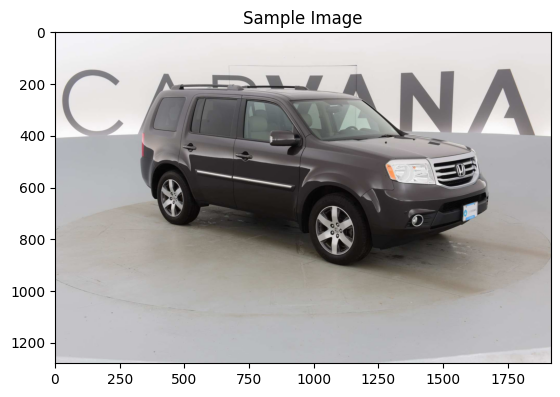

Image shape: (1280, 1918, 3)


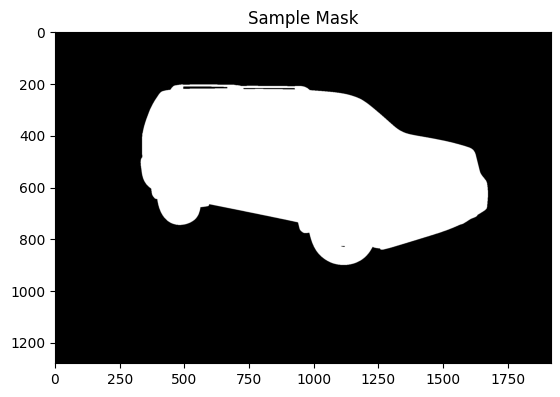

Mask shape: (1280, 1918)


In [ ]:
images = os.listdir(TRAIN_IMG_DIR)
masks = os.listdir(TRAIN_MASK_DIR)

# Visualize
img = np.array(Image.open(TRAIN_IMG_DIR+"/"+images[0]).convert("RGB"))
plt.imshow(img,cmap="gray")
plt.title("Sample Image")
plt.show()
print("Image shape:", img.shape)

msk = np.array(Image.open(TRAIN_MASK_DIR+"/"+images[0].replace(".jpg","_mask.gif")).convert("L"))
plt.imshow(msk,cmap="gray")
plt.title("Sample Mask")
plt.show()
print("Mask shape:", msk.shape)

## wrong

In [ ]:
def fit(model, dataloader, data, optimizer, criterion):
    print('-------------Training---------------')
    model.train()
    train_running_loss = 0.0
    counter = 0

    num_batches = int(np.ceil(len(data) / dataloader.batch_size))
    for i, batch_data in tqdm(enumerate(dataloader), total=num_batches):
        counter += 1
        image, mask = batch_data["image"].to(DEVICE), batch_data["mask"].to(DEVICE)
        optimizer.zero_grad()
        outputs = model(image)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, mask)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Print the loss for this batch
        print(f"Batch {i + 1}/{num_batches}, Loss: {loss.item():.6f}")

    train_loss = train_running_loss / counter
    return train_loss

def validate(model, dataloader, data, criterion):
    print("\n--------Validating---------\n")
    model.eval()
    valid_running_loss = 0.0
    counter = 0
    num_batches = int(np.ceil(len(data) / dataloader.batch_size))

    with torch.no_grad():
        for i, batch_data in tqdm(enumerate(dataloader), total=num_batches):
            counter += 1
            image, mask = batch_data["image"].to(DEVICE), batch_data["mask"].to(DEVICE)
            outputs = model(image)
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, mask)
            valid_running_loss += loss.item()

            # Print the loss for this batch
            print(f"Batch {i + 1}/{num_batches}, Loss: {loss.item():.6f}")

    valid_loss = valid_running_loss / counter
    return valid_loss


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1 of 2
-------------Training---------------


  0%|          | 1/1018 [00:04<1:23:50,  4.95s/it]

Batch 1/1018, Loss: 0.644639


  0%|          | 2/1018 [00:06<47:45,  2.82s/it]  

Batch 2/1018, Loss: 0.588718


  0%|          | 3/1018 [00:07<35:51,  2.12s/it]

Batch 3/1018, Loss: 0.528226


  0%|          | 4/1018 [00:08<30:41,  1.82s/it]

Batch 4/1018, Loss: 0.499007


  0%|          | 5/1018 [00:10<27:14,  1.61s/it]

Batch 5/1018, Loss: 0.511502


  1%|          | 6/1018 [00:11<25:18,  1.50s/it]

Batch 6/1018, Loss: 0.442711


  1%|          | 7/1018 [00:12<25:29,  1.51s/it]

Batch 7/1018, Loss: 0.420240


  1%|          | 8/1018 [00:14<25:12,  1.50s/it]

Batch 8/1018, Loss: 0.421972


  1%|          | 9/1018 [00:16<25:41,  1.53s/it]

Batch 9/1018, Loss: 0.431280


  1%|          | 10/1018 [00:17<25:30,  1.52s/it]

Batch 10/1018, Loss: 0.440363


  1%|          | 11/1018 [00:19<25:59,  1.55s/it]

Batch 11/1018, Loss: 0.430521


  1%|          | 12/1018 [00:20<24:14,  1.45s/it]

Batch 12/1018, Loss: 0.422199


  1%|▏         | 13/1018 [00:21<23:04,  1.38s/it]

Batch 13/1018, Loss: 0.342879


  1%|▏         | 14/1018 [00:22<22:14,  1.33s/it]

Batch 14/1018, Loss: 0.356995


  1%|▏         | 15/1018 [00:24<21:40,  1.30s/it]

Batch 15/1018, Loss: 0.377137


  2%|▏         | 16/1018 [00:25<21:15,  1.27s/it]

Batch 16/1018, Loss: 0.376723


  2%|▏         | 17/1018 [00:26<21:00,  1.26s/it]

Batch 17/1018, Loss: 0.328582


  2%|▏         | 18/1018 [00:27<20:55,  1.26s/it]

Batch 18/1018, Loss: 0.331347


  2%|▏         | 19/1018 [00:28<20:52,  1.25s/it]

Batch 19/1018, Loss: 0.309038


  2%|▏         | 20/1018 [00:30<21:07,  1.27s/it]

Batch 20/1018, Loss: 0.344702


  2%|▏         | 21/1018 [00:31<21:18,  1.28s/it]

Batch 21/1018, Loss: 0.318029


  2%|▏         | 22/1018 [00:32<21:33,  1.30s/it]

Batch 22/1018, Loss: 0.330444


  2%|▏         | 23/1018 [00:34<21:45,  1.31s/it]

Batch 23/1018, Loss: 0.290588


  2%|▏         | 24/1018 [00:35<21:44,  1.31s/it]

Batch 24/1018, Loss: 0.291474


  2%|▏         | 25/1018 [00:36<21:22,  1.29s/it]

Batch 25/1018, Loss: 0.296760


  3%|▎         | 26/1018 [00:38<21:10,  1.28s/it]

Batch 26/1018, Loss: 0.277199


  3%|▎         | 27/1018 [00:39<20:58,  1.27s/it]

Batch 27/1018, Loss: 0.284912


  3%|▎         | 28/1018 [00:40<20:54,  1.27s/it]

Batch 28/1018, Loss: 0.263741


  3%|▎         | 29/1018 [00:41<20:45,  1.26s/it]

Batch 29/1018, Loss: 0.278611


  3%|▎         | 30/1018 [00:43<20:38,  1.25s/it]

Batch 30/1018, Loss: 0.268629


  3%|▎         | 31/1018 [00:44<20:39,  1.26s/it]

Batch 31/1018, Loss: 0.261131


  3%|▎         | 32/1018 [00:45<20:37,  1.26s/it]

Batch 32/1018, Loss: 0.255707


  3%|▎         | 33/1018 [00:46<21:00,  1.28s/it]

Batch 33/1018, Loss: 0.261603


  3%|▎         | 34/1018 [00:48<21:33,  1.32s/it]

Batch 34/1018, Loss: 0.253514


  3%|▎         | 35/1018 [00:49<21:56,  1.34s/it]

Batch 35/1018, Loss: 0.259904


  4%|▎         | 36/1018 [00:51<22:07,  1.35s/it]

Batch 36/1018, Loss: 0.251377


  4%|▎         | 37/1018 [00:52<21:43,  1.33s/it]

Batch 37/1018, Loss: 0.230147


  4%|▎         | 38/1018 [00:53<21:21,  1.31s/it]

Batch 38/1018, Loss: 0.227536


  4%|▍         | 39/1018 [00:54<21:09,  1.30s/it]

Batch 39/1018, Loss: 0.229794


  4%|▍         | 40/1018 [00:56<22:08,  1.36s/it]

Batch 40/1018, Loss: 0.238806


  4%|▍         | 41/1018 [00:58<23:26,  1.44s/it]

Batch 41/1018, Loss: 0.236329


  4%|▍         | 42/1018 [00:59<23:49,  1.47s/it]

Batch 42/1018, Loss: 0.268479


  4%|▍         | 43/1018 [01:00<22:57,  1.41s/it]

Batch 43/1018, Loss: 0.244621


  4%|▍         | 44/1018 [01:02<22:15,  1.37s/it]

Batch 44/1018, Loss: 0.262086


  4%|▍         | 45/1018 [01:03<22:11,  1.37s/it]

Batch 45/1018, Loss: 0.266899


  5%|▍         | 46/1018 [01:04<22:29,  1.39s/it]

Batch 46/1018, Loss: 0.232603


  5%|▍         | 47/1018 [01:06<22:39,  1.40s/it]

Batch 47/1018, Loss: 0.219775


  5%|▍         | 48/1018 [01:07<22:47,  1.41s/it]

Batch 48/1018, Loss: 0.229080


  5%|▍         | 49/1018 [01:09<22:15,  1.38s/it]

Batch 49/1018, Loss: 0.236898


  5%|▍         | 50/1018 [01:10<21:51,  1.36s/it]

Batch 50/1018, Loss: 0.239252


  5%|▌         | 51/1018 [01:11<21:35,  1.34s/it]

Batch 51/1018, Loss: 0.238950


  5%|▌         | 52/1018 [01:12<21:23,  1.33s/it]

Batch 52/1018, Loss: 0.221735


  5%|▌         | 53/1018 [01:14<21:13,  1.32s/it]

Batch 53/1018, Loss: 0.250476


  5%|▌         | 54/1018 [01:15<21:08,  1.32s/it]

Batch 54/1018, Loss: 0.244391


  5%|▌         | 55/1018 [01:16<21:08,  1.32s/it]

Batch 55/1018, Loss: 0.266051


  6%|▌         | 56/1018 [01:18<21:02,  1.31s/it]

Batch 56/1018, Loss: 0.240815


  6%|▌         | 57/1018 [01:19<21:36,  1.35s/it]

Batch 57/1018, Loss: 0.219612


  6%|▌         | 58/1018 [01:21<22:02,  1.38s/it]

Batch 58/1018, Loss: 0.223563


  6%|▌         | 59/1018 [01:22<22:27,  1.41s/it]

Batch 59/1018, Loss: 0.227447


  6%|▌         | 60/1018 [01:24<22:37,  1.42s/it]

Batch 60/1018, Loss: 0.212099


  6%|▌         | 61/1018 [01:25<22:05,  1.39s/it]

Batch 61/1018, Loss: 0.236850


  6%|▌         | 62/1018 [01:26<21:43,  1.36s/it]

Batch 62/1018, Loss: 0.227404


  6%|▌         | 63/1018 [01:27<21:30,  1.35s/it]

Batch 63/1018, Loss: 0.248929


  6%|▋         | 64/1018 [01:29<21:23,  1.35s/it]

Batch 64/1018, Loss: 0.214478


  6%|▋         | 65/1018 [01:30<21:14,  1.34s/it]

Batch 65/1018, Loss: 0.219152


  6%|▋         | 66/1018 [01:31<21:07,  1.33s/it]

Batch 66/1018, Loss: 0.236875


  7%|▋         | 67/1018 [01:33<21:07,  1.33s/it]

Batch 67/1018, Loss: 0.215725


  7%|▋         | 68/1018 [01:34<21:23,  1.35s/it]

Batch 68/1018, Loss: 0.201097


  7%|▋         | 69/1018 [01:36<21:44,  1.37s/it]

Batch 69/1018, Loss: 0.227819


  7%|▋         | 70/1018 [01:37<21:56,  1.39s/it]

Batch 70/1018, Loss: 0.201609


  7%|▋         | 71/1018 [01:39<22:24,  1.42s/it]

Batch 71/1018, Loss: 0.219065


  7%|▋         | 72/1018 [01:40<22:45,  1.44s/it]

Batch 72/1018, Loss: 0.216956


  7%|▋         | 73/1018 [01:41<22:20,  1.42s/it]

Batch 73/1018, Loss: 0.211118


  7%|▋         | 74/1018 [01:43<22:00,  1.40s/it]

Batch 74/1018, Loss: 0.194901


  7%|▋         | 75/1018 [01:44<21:53,  1.39s/it]

Batch 75/1018, Loss: 0.211463


  7%|▋         | 76/1018 [01:45<21:52,  1.39s/it]

Batch 76/1018, Loss: 0.212162


  8%|▊         | 77/1018 [01:47<21:47,  1.39s/it]

Batch 77/1018, Loss: 0.201780


  8%|▊         | 78/1018 [01:48<21:42,  1.39s/it]

Batch 78/1018, Loss: 0.207350


  8%|▊         | 79/1018 [01:50<21:44,  1.39s/it]

Batch 79/1018, Loss: 0.199130


  8%|▊         | 80/1018 [01:51<21:53,  1.40s/it]

Batch 80/1018, Loss: 0.207932


  8%|▊         | 81/1018 [01:53<22:21,  1.43s/it]

Batch 81/1018, Loss: 0.201869


  8%|▊         | 82/1018 [01:54<22:44,  1.46s/it]

Batch 82/1018, Loss: 0.218750


  8%|▊         | 83/1018 [01:56<23:02,  1.48s/it]

Batch 83/1018, Loss: 0.203023


  8%|▊         | 84/1018 [01:57<22:44,  1.46s/it]

Batch 84/1018, Loss: 0.192672


  8%|▊         | 85/1018 [01:59<23:49,  1.53s/it]

Batch 85/1018, Loss: 0.196782


  8%|▊         | 86/1018 [02:00<23:16,  1.50s/it]

Batch 86/1018, Loss: 0.190711


  9%|▊         | 87/1018 [02:02<22:50,  1.47s/it]

Batch 87/1018, Loss: 0.192419


  9%|▊         | 88/1018 [02:03<22:35,  1.46s/it]

Batch 88/1018, Loss: 0.202049


  9%|▊         | 89/1018 [02:04<22:21,  1.44s/it]

Batch 89/1018, Loss: 0.195049


  9%|▉         | 90/1018 [02:06<22:11,  1.44s/it]

Batch 90/1018, Loss: 0.193894


  9%|▉         | 91/1018 [02:07<22:36,  1.46s/it]

Batch 91/1018, Loss: 0.196819


  9%|▉         | 92/1018 [02:09<22:50,  1.48s/it]

Batch 92/1018, Loss: 0.201410


  9%|▉         | 93/1018 [02:10<23:03,  1.50s/it]

Batch 93/1018, Loss: 0.212578


  9%|▉         | 94/1018 [02:12<22:58,  1.49s/it]

Batch 94/1018, Loss: 0.189756


  9%|▉         | 95/1018 [02:13<22:24,  1.46s/it]

Batch 95/1018, Loss: 0.181465


  9%|▉         | 96/1018 [02:15<22:04,  1.44s/it]

Batch 96/1018, Loss: 0.197600


 10%|▉         | 97/1018 [02:16<21:45,  1.42s/it]

Batch 97/1018, Loss: 0.187517


 10%|▉         | 98/1018 [02:17<21:33,  1.41s/it]

Batch 98/1018, Loss: 0.203100


 10%|▉         | 99/1018 [02:19<21:24,  1.40s/it]

Batch 99/1018, Loss: 0.197580


 10%|▉         | 100/1018 [02:20<21:10,  1.38s/it]

Batch 100/1018, Loss: 0.177179


 10%|▉         | 101/1018 [02:21<20:59,  1.37s/it]

Batch 101/1018, Loss: 0.206194


 10%|█         | 102/1018 [02:23<20:53,  1.37s/it]

Batch 102/1018, Loss: 0.189550


 10%|█         | 103/1018 [02:24<21:19,  1.40s/it]

Batch 103/1018, Loss: 0.196124


 10%|█         | 104/1018 [02:26<21:43,  1.43s/it]

Batch 104/1018, Loss: 0.180416


 10%|█         | 105/1018 [02:27<21:35,  1.42s/it]

Batch 105/1018, Loss: 0.187144


 10%|█         | 106/1018 [02:29<21:51,  1.44s/it]

Batch 106/1018, Loss: 0.191488


 11%|█         | 107/1018 [02:30<21:23,  1.41s/it]

Batch 107/1018, Loss: 0.175690


 11%|█         | 108/1018 [02:31<21:10,  1.40s/it]

Batch 108/1018, Loss: 0.181907


 11%|█         | 109/1018 [02:33<20:54,  1.38s/it]

Batch 109/1018, Loss: 0.193182


 11%|█         | 110/1018 [02:34<20:41,  1.37s/it]

Batch 110/1018, Loss: 0.167014


 11%|█         | 111/1018 [02:35<20:32,  1.36s/it]

Batch 111/1018, Loss: 0.175701


 11%|█         | 112/1018 [02:37<20:25,  1.35s/it]

Batch 112/1018, Loss: 0.196752


 11%|█         | 113/1018 [02:38<20:19,  1.35s/it]

Batch 113/1018, Loss: 0.196413


 11%|█         | 114/1018 [02:40<20:44,  1.38s/it]

Batch 114/1018, Loss: 0.177897


 11%|█▏        | 115/1018 [02:41<21:07,  1.40s/it]

Batch 115/1018, Loss: 0.169898


 11%|█▏        | 116/1018 [02:42<21:32,  1.43s/it]

Batch 116/1018, Loss: 0.168497


 11%|█▏        | 117/1018 [02:44<21:53,  1.46s/it]

Batch 117/1018, Loss: 0.180046


 12%|█▏        | 118/1018 [02:45<21:25,  1.43s/it]

Batch 118/1018, Loss: 0.189274


 12%|█▏        | 119/1018 [02:47<21:04,  1.41s/it]

Batch 119/1018, Loss: 0.168947


 12%|█▏        | 120/1018 [02:48<20:49,  1.39s/it]

Batch 120/1018, Loss: 0.176080


 12%|█▏        | 121/1018 [02:49<20:40,  1.38s/it]

Batch 121/1018, Loss: 0.169209


 12%|█▏        | 122/1018 [02:51<20:31,  1.37s/it]

Batch 122/1018, Loss: 0.173795


 12%|█▏        | 123/1018 [02:52<20:31,  1.38s/it]

Batch 123/1018, Loss: 0.178556


 12%|█▏        | 124/1018 [02:54<20:24,  1.37s/it]

Batch 124/1018, Loss: 0.172347


 12%|█▏        | 125/1018 [02:55<20:18,  1.36s/it]

Batch 125/1018, Loss: 0.201493


 12%|█▏        | 126/1018 [02:56<20:46,  1.40s/it]

Batch 126/1018, Loss: 0.181781


 12%|█▏        | 127/1018 [02:58<21:00,  1.41s/it]

Batch 127/1018, Loss: 0.189339


 13%|█▎        | 128/1018 [02:59<21:19,  1.44s/it]

Batch 128/1018, Loss: 0.190918


 13%|█▎        | 129/1018 [03:01<21:29,  1.45s/it]

Batch 129/1018, Loss: 0.204393


 13%|█▎        | 130/1018 [03:02<21:03,  1.42s/it]

Batch 130/1018, Loss: 0.166751


 13%|█▎        | 131/1018 [03:04<20:47,  1.41s/it]

Batch 131/1018, Loss: 0.164751


 13%|█▎        | 132/1018 [03:05<20:38,  1.40s/it]

Batch 132/1018, Loss: 0.167412


 13%|█▎        | 133/1018 [03:06<20:32,  1.39s/it]

Batch 133/1018, Loss: 0.176625


 13%|█▎        | 134/1018 [03:08<20:25,  1.39s/it]

Batch 134/1018, Loss: 0.184864


 13%|█▎        | 135/1018 [03:09<20:22,  1.38s/it]

Batch 135/1018, Loss: 0.178288


 13%|█▎        | 136/1018 [03:10<20:26,  1.39s/it]

Batch 136/1018, Loss: 0.164429


 13%|█▎        | 137/1018 [03:12<20:46,  1.41s/it]

Batch 137/1018, Loss: 0.166682


 14%|█▎        | 138/1018 [03:13<20:54,  1.43s/it]

Batch 138/1018, Loss: 0.179664


 14%|█▎        | 139/1018 [03:15<21:23,  1.46s/it]

Batch 139/1018, Loss: 0.170840


 14%|█▍        | 140/1018 [03:16<21:15,  1.45s/it]

Batch 140/1018, Loss: 0.167678


 14%|█▍        | 141/1018 [03:18<20:59,  1.44s/it]

Batch 141/1018, Loss: 0.164147


 14%|█▍        | 142/1018 [03:19<20:42,  1.42s/it]

Batch 142/1018, Loss: 0.177127


 14%|█▍        | 143/1018 [03:20<20:31,  1.41s/it]

Batch 143/1018, Loss: 0.192544


 14%|█▍        | 144/1018 [03:22<20:21,  1.40s/it]

Batch 144/1018, Loss: 0.192670


 14%|█▍        | 145/1018 [03:23<20:13,  1.39s/it]

Batch 145/1018, Loss: 0.180200


 14%|█▍        | 146/1018 [03:25<20:09,  1.39s/it]

Batch 146/1018, Loss: 0.160035


 14%|█▍        | 147/1018 [03:26<20:04,  1.38s/it]

Batch 147/1018, Loss: 0.168969


 15%|█▍        | 148/1018 [03:27<20:02,  1.38s/it]

Batch 148/1018, Loss: 0.159130


 15%|█▍        | 149/1018 [03:29<20:30,  1.42s/it]

Batch 149/1018, Loss: 0.161082


 15%|█▍        | 150/1018 [03:30<20:46,  1.44s/it]

Batch 150/1018, Loss: 0.169571


 15%|█▍        | 151/1018 [03:32<20:50,  1.44s/it]

Batch 151/1018, Loss: 0.174333


 15%|█▍        | 152/1018 [03:33<21:03,  1.46s/it]

Batch 152/1018, Loss: 0.158990


 15%|█▌        | 153/1018 [03:35<20:40,  1.43s/it]

Batch 153/1018, Loss: 0.171840


 15%|█▌        | 154/1018 [03:36<20:23,  1.42s/it]

Batch 154/1018, Loss: 0.158570


 15%|█▌        | 155/1018 [03:37<20:11,  1.40s/it]

Batch 155/1018, Loss: 0.161783


 15%|█▌        | 156/1018 [03:39<20:01,  1.39s/it]

Batch 156/1018, Loss: 0.160006


 15%|█▌        | 157/1018 [03:40<19:51,  1.38s/it]

Batch 157/1018, Loss: 0.157514


 16%|█▌        | 158/1018 [03:42<19:48,  1.38s/it]

Batch 158/1018, Loss: 0.169957


 16%|█▌        | 159/1018 [03:43<19:40,  1.37s/it]

Batch 159/1018, Loss: 0.155113


 16%|█▌        | 160/1018 [03:44<20:08,  1.41s/it]

Batch 160/1018, Loss: 0.171575


 16%|█▌        | 161/1018 [03:46<20:13,  1.42s/it]

Batch 161/1018, Loss: 0.173403


 16%|█▌        | 162/1018 [03:47<20:26,  1.43s/it]

Batch 162/1018, Loss: 0.154599


 16%|█▌        | 163/1018 [03:49<20:43,  1.45s/it]

Batch 163/1018, Loss: 0.152887


 16%|█▌        | 164/1018 [03:50<20:17,  1.43s/it]

Batch 164/1018, Loss: 0.155476


 16%|█▌        | 165/1018 [03:52<20:01,  1.41s/it]

Batch 165/1018, Loss: 0.158187


 16%|█▋        | 166/1018 [03:53<19:52,  1.40s/it]

Batch 166/1018, Loss: 0.163300


 16%|█▋        | 167/1018 [03:54<19:39,  1.39s/it]

Batch 167/1018, Loss: 0.164385


 17%|█▋        | 168/1018 [03:56<19:31,  1.38s/it]

Batch 168/1018, Loss: 0.148449


 17%|█▋        | 169/1018 [03:57<19:24,  1.37s/it]

Batch 169/1018, Loss: 0.147026


 17%|█▋        | 170/1018 [03:58<19:19,  1.37s/it]

Batch 170/1018, Loss: 0.150329


 17%|█▋        | 171/1018 [04:00<19:30,  1.38s/it]

Batch 171/1018, Loss: 0.165002


 17%|█▋        | 172/1018 [04:01<19:40,  1.40s/it]

Batch 172/1018, Loss: 0.161730


 17%|█▋        | 173/1018 [04:03<20:00,  1.42s/it]

Batch 173/1018, Loss: 0.151709


 17%|█▋        | 174/1018 [04:04<20:13,  1.44s/it]

Batch 174/1018, Loss: 0.146825


 17%|█▋        | 175/1018 [04:06<20:15,  1.44s/it]

Batch 175/1018, Loss: 0.149806


 17%|█▋        | 176/1018 [04:07<19:50,  1.41s/it]

Batch 176/1018, Loss: 0.155270


 17%|█▋        | 177/1018 [04:08<19:37,  1.40s/it]

Batch 177/1018, Loss: 0.154279


 17%|█▋        | 178/1018 [04:10<19:25,  1.39s/it]

Batch 178/1018, Loss: 0.147647


 18%|█▊        | 179/1018 [04:11<19:17,  1.38s/it]

Batch 179/1018, Loss: 0.154610


 18%|█▊        | 180/1018 [04:12<19:15,  1.38s/it]

Batch 180/1018, Loss: 0.147609


 18%|█▊        | 181/1018 [04:14<19:06,  1.37s/it]

Batch 181/1018, Loss: 0.148587


 18%|█▊        | 182/1018 [04:15<19:00,  1.36s/it]

Batch 182/1018, Loss: 0.173622


 18%|█▊        | 183/1018 [04:17<19:30,  1.40s/it]

Batch 183/1018, Loss: 0.154984


 18%|█▊        | 184/1018 [04:18<19:39,  1.41s/it]

Batch 184/1018, Loss: 0.144838


 18%|█▊        | 185/1018 [04:20<19:59,  1.44s/it]

Batch 185/1018, Loss: 0.139347


 18%|█▊        | 186/1018 [04:21<20:14,  1.46s/it]

Batch 186/1018, Loss: 0.154717


 18%|█▊        | 187/1018 [04:22<19:50,  1.43s/it]

Batch 187/1018, Loss: 0.168468


 18%|█▊        | 188/1018 [04:24<19:32,  1.41s/it]

Batch 188/1018, Loss: 0.137528


 19%|█▊        | 189/1018 [04:25<19:19,  1.40s/it]

Batch 189/1018, Loss: 0.148349


 19%|█▊        | 190/1018 [04:26<19:08,  1.39s/it]

Batch 190/1018, Loss: 0.142528


 19%|█▉        | 191/1018 [04:28<19:00,  1.38s/it]

Batch 191/1018, Loss: 0.150684


 19%|█▉        | 192/1018 [04:29<18:59,  1.38s/it]

Batch 192/1018, Loss: 0.142734


 19%|█▉        | 193/1018 [04:31<18:57,  1.38s/it]

Batch 193/1018, Loss: 0.151564


 19%|█▉        | 194/1018 [04:32<18:54,  1.38s/it]

Batch 194/1018, Loss: 0.161929


 19%|█▉        | 195/1018 [04:33<19:20,  1.41s/it]

Batch 195/1018, Loss: 0.152981


 19%|█▉        | 196/1018 [04:35<19:44,  1.44s/it]

Batch 196/1018, Loss: 0.169439


 19%|█▉        | 197/1018 [04:36<19:54,  1.46s/it]

Batch 197/1018, Loss: 0.136001


 19%|█▉        | 198/1018 [04:38<20:16,  1.48s/it]

Batch 198/1018, Loss: 0.151542


 20%|█▉        | 199/1018 [04:39<19:48,  1.45s/it]

Batch 199/1018, Loss: 0.137013


 20%|█▉        | 200/1018 [04:41<19:27,  1.43s/it]

Batch 200/1018, Loss: 0.135964


 20%|█▉        | 201/1018 [04:42<19:14,  1.41s/it]

Batch 201/1018, Loss: 0.155958


 20%|█▉        | 202/1018 [04:44<19:09,  1.41s/it]

Batch 202/1018, Loss: 0.139529


 20%|█▉        | 203/1018 [04:45<18:59,  1.40s/it]

Batch 203/1018, Loss: 0.142719


 20%|██        | 204/1018 [04:46<18:52,  1.39s/it]

Batch 204/1018, Loss: 0.147429


 20%|██        | 205/1018 [04:48<18:53,  1.39s/it]

Batch 205/1018, Loss: 0.138680


 20%|██        | 206/1018 [04:49<19:14,  1.42s/it]

Batch 206/1018, Loss: 0.141142


 20%|██        | 207/1018 [04:51<19:35,  1.45s/it]

Batch 207/1018, Loss: 0.135468


 20%|██        | 208/1018 [04:52<19:38,  1.45s/it]

Batch 208/1018, Loss: 0.138212


 21%|██        | 209/1018 [04:54<19:48,  1.47s/it]

Batch 209/1018, Loss: 0.138883


 21%|██        | 210/1018 [04:55<19:22,  1.44s/it]

Batch 210/1018, Loss: 0.135151


 21%|██        | 211/1018 [04:56<19:04,  1.42s/it]

Batch 211/1018, Loss: 0.139421


 21%|██        | 212/1018 [04:58<18:53,  1.41s/it]

Batch 212/1018, Loss: 0.132635


 21%|██        | 213/1018 [04:59<18:46,  1.40s/it]

Batch 213/1018, Loss: 0.135851


 21%|██        | 214/1018 [05:01<18:38,  1.39s/it]

Batch 214/1018, Loss: 0.148103


 21%|██        | 215/1018 [05:02<18:30,  1.38s/it]

Batch 215/1018, Loss: 0.143853


 21%|██        | 216/1018 [05:03<18:26,  1.38s/it]

Batch 216/1018, Loss: 0.130030


 21%|██▏       | 217/1018 [05:05<18:43,  1.40s/it]

Batch 217/1018, Loss: 0.168140


 21%|██▏       | 218/1018 [05:06<18:41,  1.40s/it]

Batch 218/1018, Loss: 0.144737


 22%|██▏       | 219/1018 [05:08<18:44,  1.41s/it]

Batch 219/1018, Loss: 0.134714


 22%|██▏       | 220/1018 [05:09<18:42,  1.41s/it]

Batch 220/1018, Loss: 0.151645


 22%|██▏       | 221/1018 [05:10<18:47,  1.41s/it]

Batch 221/1018, Loss: 0.137523


 22%|██▏       | 222/1018 [05:12<18:34,  1.40s/it]

Batch 222/1018, Loss: 0.153120


 22%|██▏       | 223/1018 [05:13<18:27,  1.39s/it]

Batch 223/1018, Loss: 0.166817


 22%|██▏       | 224/1018 [05:14<18:18,  1.38s/it]

Batch 224/1018, Loss: 0.162895


 22%|██▏       | 225/1018 [05:16<18:16,  1.38s/it]

Batch 225/1018, Loss: 0.139636


 22%|██▏       | 226/1018 [05:17<18:11,  1.38s/it]

Batch 226/1018, Loss: 0.137244


 22%|██▏       | 227/1018 [05:19<18:05,  1.37s/it]

Batch 227/1018, Loss: 0.150020


 22%|██▏       | 228/1018 [05:20<18:04,  1.37s/it]

Batch 228/1018, Loss: 0.138393


 22%|██▏       | 229/1018 [05:21<18:15,  1.39s/it]

Batch 229/1018, Loss: 0.129165


 23%|██▎       | 230/1018 [05:23<18:26,  1.40s/it]

Batch 230/1018, Loss: 0.139728


 23%|██▎       | 231/1018 [05:24<18:36,  1.42s/it]

Batch 231/1018, Loss: 0.133449


 23%|██▎       | 232/1018 [05:26<18:43,  1.43s/it]

Batch 232/1018, Loss: 0.136519


 23%|██▎       | 233/1018 [05:27<18:27,  1.41s/it]

Batch 233/1018, Loss: 0.134586


 23%|██▎       | 234/1018 [05:28<18:14,  1.40s/it]

Batch 234/1018, Loss: 0.130074


 23%|██▎       | 235/1018 [05:30<18:02,  1.38s/it]

Batch 235/1018, Loss: 0.133762


 23%|██▎       | 236/1018 [05:31<17:58,  1.38s/it]

Batch 236/1018, Loss: 0.123785


 23%|██▎       | 237/1018 [05:33<17:54,  1.38s/it]

Batch 237/1018, Loss: 0.150078


 23%|██▎       | 238/1018 [05:34<17:51,  1.37s/it]

Batch 238/1018, Loss: 0.125535


 23%|██▎       | 239/1018 [05:35<17:49,  1.37s/it]

Batch 239/1018, Loss: 0.133509


 24%|██▎       | 240/1018 [05:37<18:06,  1.40s/it]

Batch 240/1018, Loss: 0.129174


 24%|██▎       | 241/1018 [05:38<18:13,  1.41s/it]

Batch 241/1018, Loss: 0.157282


 24%|██▍       | 242/1018 [05:40<18:16,  1.41s/it]

Batch 242/1018, Loss: 0.134318


 24%|██▍       | 243/1018 [05:41<18:19,  1.42s/it]

Batch 243/1018, Loss: 0.139710


 24%|██▍       | 244/1018 [05:43<18:45,  1.45s/it]

Batch 244/1018, Loss: 0.128221


 24%|██▍       | 245/1018 [05:44<18:24,  1.43s/it]

Batch 245/1018, Loss: 0.131140


 24%|██▍       | 246/1018 [05:45<18:10,  1.41s/it]

Batch 246/1018, Loss: 0.123237


 24%|██▍       | 247/1018 [05:47<17:56,  1.40s/it]

Batch 247/1018, Loss: 0.133056


 24%|██▍       | 248/1018 [05:48<17:50,  1.39s/it]

Batch 248/1018, Loss: 0.154033


 24%|██▍       | 249/1018 [05:49<17:42,  1.38s/it]

Batch 249/1018, Loss: 0.136301


 25%|██▍       | 250/1018 [05:51<17:38,  1.38s/it]

Batch 250/1018, Loss: 0.154698


 25%|██▍       | 251/1018 [05:52<17:37,  1.38s/it]

Batch 251/1018, Loss: 0.128875


 25%|██▍       | 252/1018 [05:54<17:50,  1.40s/it]

Batch 252/1018, Loss: 0.132595


 25%|██▍       | 253/1018 [05:55<18:02,  1.41s/it]

Batch 253/1018, Loss: 0.135264


 25%|██▍       | 254/1018 [05:57<18:21,  1.44s/it]

Batch 254/1018, Loss: 0.131284


 25%|██▌       | 255/1018 [05:58<18:23,  1.45s/it]

Batch 255/1018, Loss: 0.131717


 25%|██▌       | 256/1018 [05:59<18:01,  1.42s/it]

Batch 256/1018, Loss: 0.124891


 25%|██▌       | 257/1018 [06:01<17:49,  1.40s/it]

Batch 257/1018, Loss: 0.126777


 25%|██▌       | 258/1018 [06:02<17:36,  1.39s/it]

Batch 258/1018, Loss: 0.130115


 25%|██▌       | 259/1018 [06:03<17:32,  1.39s/it]

Batch 259/1018, Loss: 0.127076


 26%|██▌       | 260/1018 [06:05<17:28,  1.38s/it]

Batch 260/1018, Loss: 0.139373


 26%|██▌       | 261/1018 [06:06<17:22,  1.38s/it]

Batch 261/1018, Loss: 0.126743


 26%|██▌       | 262/1018 [06:08<17:19,  1.37s/it]

Batch 262/1018, Loss: 0.134690


 26%|██▌       | 263/1018 [06:09<17:22,  1.38s/it]

Batch 263/1018, Loss: 0.118336


 26%|██▌       | 264/1018 [06:10<17:36,  1.40s/it]

Batch 264/1018, Loss: 0.126159


 26%|██▌       | 265/1018 [06:12<17:58,  1.43s/it]

Batch 265/1018, Loss: 0.128807


 26%|██▌       | 266/1018 [06:13<18:04,  1.44s/it]

Batch 266/1018, Loss: 0.125910


 26%|██▌       | 267/1018 [06:15<18:12,  1.46s/it]

Batch 267/1018, Loss: 0.126847


 26%|██▋       | 268/1018 [06:16<17:53,  1.43s/it]

Batch 268/1018, Loss: 0.120200


 26%|██▋       | 269/1018 [06:18<17:35,  1.41s/it]

Batch 269/1018, Loss: 0.130613


 27%|██▋       | 270/1018 [06:19<17:21,  1.39s/it]

Batch 270/1018, Loss: 0.127663


 27%|██▋       | 271/1018 [06:20<17:16,  1.39s/it]

Batch 271/1018, Loss: 0.125889


 27%|██▋       | 272/1018 [06:22<17:07,  1.38s/it]

Batch 272/1018, Loss: 0.119720


 27%|██▋       | 273/1018 [06:23<17:03,  1.37s/it]

Batch 273/1018, Loss: 0.116025


 27%|██▋       | 274/1018 [06:24<17:06,  1.38s/it]

Batch 274/1018, Loss: 0.114034


 27%|██▋       | 275/1018 [06:26<17:27,  1.41s/it]

Batch 275/1018, Loss: 0.119877


 27%|██▋       | 276/1018 [06:27<17:20,  1.40s/it]

Batch 276/1018, Loss: 0.123336


 27%|██▋       | 277/1018 [06:29<17:40,  1.43s/it]

Batch 277/1018, Loss: 0.112451


 27%|██▋       | 278/1018 [06:30<17:52,  1.45s/it]

Batch 278/1018, Loss: 0.126953


 27%|██▋       | 279/1018 [06:32<17:33,  1.43s/it]

Batch 279/1018, Loss: 0.121680


 28%|██▊       | 280/1018 [06:33<17:20,  1.41s/it]

Batch 280/1018, Loss: 0.119573


 28%|██▊       | 281/1018 [06:34<17:11,  1.40s/it]

Batch 281/1018, Loss: 0.117739


 28%|██▊       | 282/1018 [06:36<17:04,  1.39s/it]

Batch 282/1018, Loss: 0.114291


 28%|██▊       | 283/1018 [06:37<16:59,  1.39s/it]

Batch 283/1018, Loss: 0.113304


 28%|██▊       | 284/1018 [06:39<16:55,  1.38s/it]

Batch 284/1018, Loss: 0.122124


 28%|██▊       | 285/1018 [06:40<16:50,  1.38s/it]

Batch 285/1018, Loss: 0.117329


 28%|██▊       | 286/1018 [06:41<16:46,  1.38s/it]

Batch 286/1018, Loss: 0.112357


 28%|██▊       | 287/1018 [06:43<17:09,  1.41s/it]

Batch 287/1018, Loss: 0.144462


 28%|██▊       | 288/1018 [06:44<17:24,  1.43s/it]

Batch 288/1018, Loss: 0.117114


 28%|██▊       | 289/1018 [06:46<17:39,  1.45s/it]

Batch 289/1018, Loss: 0.118269


 28%|██▊       | 290/1018 [06:47<17:48,  1.47s/it]

Batch 290/1018, Loss: 0.127474


 29%|██▊       | 291/1018 [06:49<17:26,  1.44s/it]

Batch 291/1018, Loss: 0.109672


 29%|██▊       | 292/1018 [06:50<17:07,  1.42s/it]

Batch 292/1018, Loss: 0.116962


 29%|██▉       | 293/1018 [06:51<16:56,  1.40s/it]

Batch 293/1018, Loss: 0.116143


 29%|██▉       | 294/1018 [06:53<16:48,  1.39s/it]

Batch 294/1018, Loss: 0.122303


 29%|██▉       | 295/1018 [06:54<16:39,  1.38s/it]

Batch 295/1018, Loss: 0.104717


 29%|██▉       | 296/1018 [06:55<16:33,  1.38s/it]

Batch 296/1018, Loss: 0.113748


 29%|██▉       | 297/1018 [06:57<16:30,  1.37s/it]

Batch 297/1018, Loss: 0.109067


 29%|██▉       | 298/1018 [06:58<16:33,  1.38s/it]

Batch 298/1018, Loss: 0.113452


 29%|██▉       | 299/1018 [07:00<16:47,  1.40s/it]

Batch 299/1018, Loss: 0.114482


 29%|██▉       | 300/1018 [07:01<17:01,  1.42s/it]

Batch 300/1018, Loss: 0.111721


 30%|██▉       | 301/1018 [07:03<17:25,  1.46s/it]

Batch 301/1018, Loss: 0.109664


 30%|██▉       | 302/1018 [07:04<17:04,  1.43s/it]

Batch 302/1018, Loss: 0.110718


 30%|██▉       | 303/1018 [07:05<16:51,  1.41s/it]

Batch 303/1018, Loss: 0.110403


 30%|██▉       | 304/1018 [07:07<16:39,  1.40s/it]

Batch 304/1018, Loss: 0.114984


 30%|██▉       | 305/1018 [07:08<16:29,  1.39s/it]

Batch 305/1018, Loss: 0.121387


 30%|███       | 306/1018 [07:10<16:27,  1.39s/it]

Batch 306/1018, Loss: 0.107111


 30%|███       | 307/1018 [07:11<16:22,  1.38s/it]

Batch 307/1018, Loss: 0.109676


 30%|███       | 308/1018 [07:12<16:19,  1.38s/it]

Batch 308/1018, Loss: 0.113591


 30%|███       | 309/1018 [07:14<16:18,  1.38s/it]

Batch 309/1018, Loss: 0.110355


 30%|███       | 310/1018 [07:15<16:41,  1.41s/it]

Batch 310/1018, Loss: 0.110734


 31%|███       | 311/1018 [07:17<17:01,  1.44s/it]

Batch 311/1018, Loss: 0.101702


 31%|███       | 312/1018 [07:18<17:16,  1.47s/it]

Batch 312/1018, Loss: 0.119985


 31%|███       | 313/1018 [07:20<17:09,  1.46s/it]

Batch 313/1018, Loss: 0.109871


 31%|███       | 314/1018 [07:21<16:52,  1.44s/it]

Batch 314/1018, Loss: 0.114026


 31%|███       | 315/1018 [07:22<16:37,  1.42s/it]

Batch 315/1018, Loss: 0.111497


 31%|███       | 316/1018 [07:24<16:26,  1.40s/it]

Batch 316/1018, Loss: 0.115889


 31%|███       | 317/1018 [07:25<16:16,  1.39s/it]

Batch 317/1018, Loss: 0.115708


 31%|███       | 318/1018 [07:27<16:14,  1.39s/it]

Batch 318/1018, Loss: 0.113997


 31%|███▏      | 319/1018 [07:28<16:09,  1.39s/it]

Batch 319/1018, Loss: 0.134528


 31%|███▏      | 320/1018 [07:29<16:06,  1.39s/it]

Batch 320/1018, Loss: 0.111593


 32%|███▏      | 321/1018 [07:31<16:13,  1.40s/it]

Batch 321/1018, Loss: 0.100948


 32%|███▏      | 322/1018 [07:32<16:28,  1.42s/it]

Batch 322/1018, Loss: 0.111798


 32%|███▏      | 323/1018 [07:34<16:38,  1.44s/it]

Batch 323/1018, Loss: 0.135385


 32%|███▏      | 324/1018 [07:35<16:52,  1.46s/it]

Batch 324/1018, Loss: 0.169650


 32%|███▏      | 325/1018 [07:37<16:38,  1.44s/it]

Batch 325/1018, Loss: 0.105428


 32%|███▏      | 326/1018 [07:38<16:21,  1.42s/it]

Batch 326/1018, Loss: 0.151955


 32%|███▏      | 327/1018 [07:39<16:11,  1.41s/it]

Batch 327/1018, Loss: 0.118833


 32%|███▏      | 328/1018 [07:41<16:04,  1.40s/it]

Batch 328/1018, Loss: 0.144191


 32%|███▏      | 329/1018 [07:42<16:07,  1.40s/it]

Batch 329/1018, Loss: 0.121965


 32%|███▏      | 330/1018 [07:43<15:57,  1.39s/it]

Batch 330/1018, Loss: 0.129477


 33%|███▎      | 331/1018 [07:45<15:51,  1.38s/it]

Batch 331/1018, Loss: 0.115673


 33%|███▎      | 332/1018 [07:46<15:47,  1.38s/it]

Batch 332/1018, Loss: 0.141679


 33%|███▎      | 333/1018 [07:48<15:56,  1.40s/it]

Batch 333/1018, Loss: 0.135519


 33%|███▎      | 334/1018 [07:49<16:13,  1.42s/it]

Batch 334/1018, Loss: 0.113028


 33%|███▎      | 335/1018 [07:51<16:14,  1.43s/it]

Batch 335/1018, Loss: 0.112721


 33%|███▎      | 336/1018 [07:52<16:40,  1.47s/it]

Batch 336/1018, Loss: 0.115295


 33%|███▎      | 337/1018 [07:54<16:20,  1.44s/it]

Batch 337/1018, Loss: 0.134309


 33%|███▎      | 338/1018 [07:55<16:04,  1.42s/it]

Batch 338/1018, Loss: 0.120379


 33%|███▎      | 339/1018 [07:56<15:55,  1.41s/it]

Batch 339/1018, Loss: 0.111407


 33%|███▎      | 340/1018 [07:58<15:47,  1.40s/it]

Batch 340/1018, Loss: 0.118854


 33%|███▎      | 341/1018 [07:59<15:37,  1.38s/it]

Batch 341/1018, Loss: 0.123139


 34%|███▎      | 342/1018 [08:00<15:34,  1.38s/it]

Batch 342/1018, Loss: 0.108361


 34%|███▎      | 343/1018 [08:02<15:31,  1.38s/it]

Batch 343/1018, Loss: 0.118992


 34%|███▍      | 344/1018 [08:03<15:52,  1.41s/it]

Batch 344/1018, Loss: 0.115099


 34%|███▍      | 345/1018 [08:05<16:11,  1.44s/it]

Batch 345/1018, Loss: 0.104341


 34%|███▍      | 346/1018 [08:06<16:15,  1.45s/it]

Batch 346/1018, Loss: 0.117403


 34%|███▍      | 347/1018 [08:08<16:07,  1.44s/it]

Batch 347/1018, Loss: 0.108059


 34%|███▍      | 348/1018 [08:09<15:49,  1.42s/it]

Batch 348/1018, Loss: 0.116988


 34%|███▍      | 349/1018 [08:10<15:36,  1.40s/it]

Batch 349/1018, Loss: 0.116458


 34%|███▍      | 350/1018 [08:12<15:27,  1.39s/it]

Batch 350/1018, Loss: 0.103286


 34%|███▍      | 351/1018 [08:13<15:21,  1.38s/it]

Batch 351/1018, Loss: 0.102238


 35%|███▍      | 352/1018 [08:14<15:14,  1.37s/it]

Batch 352/1018, Loss: 0.117256


 35%|███▍      | 353/1018 [08:16<15:10,  1.37s/it]

Batch 353/1018, Loss: 0.102364


 35%|███▍      | 354/1018 [08:17<15:10,  1.37s/it]

Batch 354/1018, Loss: 0.103254


 35%|███▍      | 355/1018 [08:19<15:11,  1.38s/it]

Batch 355/1018, Loss: 0.097594


 35%|███▍      | 356/1018 [08:20<15:23,  1.40s/it]

Batch 356/1018, Loss: 0.102125


 35%|███▌      | 357/1018 [08:21<15:41,  1.42s/it]

Batch 357/1018, Loss: 0.102118


 35%|███▌      | 358/1018 [08:23<15:45,  1.43s/it]

Batch 358/1018, Loss: 0.106420


 35%|███▌      | 359/1018 [08:24<15:52,  1.45s/it]

Batch 359/1018, Loss: 0.105106


 35%|███▌      | 360/1018 [08:26<15:35,  1.42s/it]

Batch 360/1018, Loss: 0.129793


 35%|███▌      | 361/1018 [08:27<15:21,  1.40s/it]

Batch 361/1018, Loss: 0.107628


 36%|███▌      | 362/1018 [08:29<15:15,  1.40s/it]

Batch 362/1018, Loss: 0.105019


 36%|███▌      | 363/1018 [08:30<15:10,  1.39s/it]

Batch 363/1018, Loss: 0.107131


 36%|███▌      | 364/1018 [08:31<15:05,  1.38s/it]

Batch 364/1018, Loss: 0.107306


 36%|███▌      | 365/1018 [08:33<15:05,  1.39s/it]

Batch 365/1018, Loss: 0.112089


 36%|███▌      | 366/1018 [08:34<15:00,  1.38s/it]

Batch 366/1018, Loss: 0.114170


 36%|███▌      | 367/1018 [08:35<15:14,  1.40s/it]

Batch 367/1018, Loss: 0.101122


 36%|███▌      | 368/1018 [08:37<15:19,  1.41s/it]

Batch 368/1018, Loss: 0.141329


 36%|███▌      | 369/1018 [08:38<15:32,  1.44s/it]

Batch 369/1018, Loss: 0.095266


 36%|███▋      | 370/1018 [08:40<15:47,  1.46s/it]

Batch 370/1018, Loss: 0.098402


 36%|███▋      | 371/1018 [08:41<15:29,  1.44s/it]

Batch 371/1018, Loss: 0.112290


 37%|███▋      | 372/1018 [08:43<15:16,  1.42s/it]

Batch 372/1018, Loss: 0.108764


 37%|███▋      | 373/1018 [08:44<15:06,  1.41s/it]

Batch 373/1018, Loss: 0.108968


 37%|███▋      | 374/1018 [08:45<15:00,  1.40s/it]

Batch 374/1018, Loss: 0.101731


 37%|███▋      | 375/1018 [08:47<14:54,  1.39s/it]

Batch 375/1018, Loss: 0.116962


 37%|███▋      | 376/1018 [08:48<14:49,  1.39s/it]

Batch 376/1018, Loss: 0.105422


 37%|███▋      | 377/1018 [08:50<14:48,  1.39s/it]

Batch 377/1018, Loss: 0.105290


 37%|███▋      | 378/1018 [08:51<15:09,  1.42s/it]

Batch 378/1018, Loss: 0.098950


 37%|███▋      | 379/1018 [08:53<15:19,  1.44s/it]

Batch 379/1018, Loss: 0.106985


 37%|███▋      | 380/1018 [08:54<15:32,  1.46s/it]

Batch 380/1018, Loss: 0.093231


 37%|███▋      | 381/1018 [08:56<15:29,  1.46s/it]

Batch 381/1018, Loss: 0.096983


 38%|███▊      | 382/1018 [08:57<15:15,  1.44s/it]

Batch 382/1018, Loss: 0.104869


 38%|███▊      | 383/1018 [08:58<15:00,  1.42s/it]

Batch 383/1018, Loss: 0.112686


 38%|███▊      | 384/1018 [09:00<14:51,  1.41s/it]

Batch 384/1018, Loss: 0.094679


 38%|███▊      | 385/1018 [09:01<14:44,  1.40s/it]

Batch 385/1018, Loss: 0.094535


 38%|███▊      | 386/1018 [09:02<14:35,  1.39s/it]

Batch 386/1018, Loss: 0.103784


 38%|███▊      | 387/1018 [09:04<14:31,  1.38s/it]

Batch 387/1018, Loss: 0.090987


 38%|███▊      | 388/1018 [09:05<14:29,  1.38s/it]

Batch 388/1018, Loss: 0.104522


 38%|███▊      | 389/1018 [09:07<14:27,  1.38s/it]

Batch 389/1018, Loss: 0.102910


 38%|███▊      | 390/1018 [09:08<14:45,  1.41s/it]

Batch 390/1018, Loss: 0.100699


 38%|███▊      | 391/1018 [09:10<15:02,  1.44s/it]

Batch 391/1018, Loss: 0.117038


 39%|███▊      | 392/1018 [09:11<15:05,  1.45s/it]

Batch 392/1018, Loss: 0.099927


 39%|███▊      | 393/1018 [09:12<15:03,  1.44s/it]

Batch 393/1018, Loss: 0.097226


 39%|███▊      | 394/1018 [09:14<14:46,  1.42s/it]

Batch 394/1018, Loss: 0.102574


 39%|███▉      | 395/1018 [09:15<14:33,  1.40s/it]

Batch 395/1018, Loss: 0.095926


 39%|███▉      | 396/1018 [09:17<14:28,  1.40s/it]

Batch 396/1018, Loss: 0.103862


 39%|███▉      | 397/1018 [09:18<14:18,  1.38s/it]

Batch 397/1018, Loss: 0.097442


 39%|███▉      | 398/1018 [09:19<14:13,  1.38s/it]

Batch 398/1018, Loss: 0.108315


 39%|███▉      | 399/1018 [09:21<14:08,  1.37s/it]

Batch 399/1018, Loss: 0.101222


 39%|███▉      | 400/1018 [09:22<14:04,  1.37s/it]

Batch 400/1018, Loss: 0.102888


 39%|███▉      | 401/1018 [09:23<14:17,  1.39s/it]

Batch 401/1018, Loss: 0.102585


 39%|███▉      | 402/1018 [09:25<14:31,  1.41s/it]

Batch 402/1018, Loss: 0.093930


 40%|███▉      | 403/1018 [09:26<14:43,  1.44s/it]

Batch 403/1018, Loss: 0.089475


 40%|███▉      | 404/1018 [09:28<14:51,  1.45s/it]

Batch 404/1018, Loss: 0.143151


 40%|███▉      | 405/1018 [09:29<14:58,  1.47s/it]

Batch 405/1018, Loss: 0.092242


 40%|███▉      | 406/1018 [09:31<14:37,  1.43s/it]

Batch 406/1018, Loss: 0.090729


 40%|███▉      | 407/1018 [09:32<14:24,  1.42s/it]

Batch 407/1018, Loss: 0.090388


 40%|████      | 408/1018 [09:33<14:11,  1.40s/it]

Batch 408/1018, Loss: 0.108025


 40%|████      | 409/1018 [09:35<14:03,  1.38s/it]

Batch 409/1018, Loss: 0.092776


 40%|████      | 410/1018 [09:36<13:59,  1.38s/it]

Batch 410/1018, Loss: 0.090978


 40%|████      | 411/1018 [09:38<13:55,  1.38s/it]

Batch 411/1018, Loss: 0.094446


 40%|████      | 412/1018 [09:39<13:50,  1.37s/it]

Batch 412/1018, Loss: 0.089330


 41%|████      | 413/1018 [09:40<13:58,  1.39s/it]

Batch 413/1018, Loss: 0.091133


 41%|████      | 414/1018 [09:42<14:18,  1.42s/it]

Batch 414/1018, Loss: 0.098584


 41%|████      | 415/1018 [09:43<14:24,  1.43s/it]

Batch 415/1018, Loss: 0.105105


 41%|████      | 416/1018 [09:45<14:43,  1.47s/it]

Batch 416/1018, Loss: 0.103244


 41%|████      | 417/1018 [09:46<14:24,  1.44s/it]

Batch 417/1018, Loss: 0.094141


 41%|████      | 418/1018 [09:48<14:12,  1.42s/it]

Batch 418/1018, Loss: 0.092196


 41%|████      | 419/1018 [09:49<14:02,  1.41s/it]

Batch 419/1018, Loss: 0.095690


 41%|████▏     | 420/1018 [09:50<13:55,  1.40s/it]

Batch 420/1018, Loss: 0.093935


 41%|████▏     | 421/1018 [09:52<13:54,  1.40s/it]

Batch 421/1018, Loss: 0.086648


 41%|████▏     | 422/1018 [09:53<13:45,  1.39s/it]

Batch 422/1018, Loss: 0.107350


 42%|████▏     | 423/1018 [09:54<13:41,  1.38s/it]

Batch 423/1018, Loss: 0.092467


 42%|████▏     | 424/1018 [09:56<13:51,  1.40s/it]

Batch 424/1018, Loss: 0.090686


 42%|████▏     | 425/1018 [09:57<13:53,  1.41s/it]

Batch 425/1018, Loss: 0.086953


 42%|████▏     | 426/1018 [09:59<14:10,  1.44s/it]

Batch 426/1018, Loss: 0.100530


 42%|████▏     | 427/1018 [10:00<14:11,  1.44s/it]

Batch 427/1018, Loss: 0.088256


 42%|████▏     | 428/1018 [10:02<14:22,  1.46s/it]

Batch 428/1018, Loss: 0.093279


 42%|████▏     | 429/1018 [10:03<14:05,  1.44s/it]

Batch 429/1018, Loss: 0.095640


 42%|████▏     | 430/1018 [10:05<13:53,  1.42s/it]

Batch 430/1018, Loss: 0.088698


 42%|████▏     | 431/1018 [10:06<13:44,  1.40s/it]

Batch 431/1018, Loss: 0.087353


 42%|████▏     | 432/1018 [10:07<13:38,  1.40s/it]

Batch 432/1018, Loss: 0.088566


 43%|████▎     | 433/1018 [10:09<13:32,  1.39s/it]

Batch 433/1018, Loss: 0.089811


 43%|████▎     | 434/1018 [10:10<13:29,  1.39s/it]

Batch 434/1018, Loss: 0.088468


 43%|████▎     | 435/1018 [10:11<13:26,  1.38s/it]

Batch 435/1018, Loss: 0.092813


 43%|████▎     | 436/1018 [10:13<13:29,  1.39s/it]

Batch 436/1018, Loss: 0.088889


 43%|████▎     | 437/1018 [10:14<13:35,  1.40s/it]

Batch 437/1018, Loss: 0.095419


 43%|████▎     | 438/1018 [10:16<13:54,  1.44s/it]

Batch 438/1018, Loss: 0.098104


 43%|████▎     | 439/1018 [10:17<14:06,  1.46s/it]

Batch 439/1018, Loss: 0.095450


 43%|████▎     | 440/1018 [10:19<13:49,  1.43s/it]

Batch 440/1018, Loss: 0.082213


 43%|████▎     | 441/1018 [10:20<13:38,  1.42s/it]

Batch 441/1018, Loss: 0.083665


 43%|████▎     | 442/1018 [10:21<13:28,  1.40s/it]

Batch 442/1018, Loss: 0.087700


 44%|████▎     | 443/1018 [10:23<13:22,  1.40s/it]

Batch 443/1018, Loss: 0.094612


 44%|████▎     | 444/1018 [10:24<13:17,  1.39s/it]

Batch 444/1018, Loss: 0.082725


 44%|████▎     | 445/1018 [10:26<13:13,  1.39s/it]

Batch 445/1018, Loss: 0.089014


 44%|████▍     | 446/1018 [10:27<13:11,  1.38s/it]

Batch 446/1018, Loss: 0.112487


 44%|████▍     | 447/1018 [10:28<13:20,  1.40s/it]

Batch 447/1018, Loss: 0.089981


 44%|████▍     | 448/1018 [10:30<13:32,  1.43s/it]

Batch 448/1018, Loss: 0.087058


 44%|████▍     | 449/1018 [10:31<13:37,  1.44s/it]

Batch 449/1018, Loss: 0.085169


 44%|████▍     | 450/1018 [10:33<13:43,  1.45s/it]

Batch 450/1018, Loss: 0.089432


 44%|████▍     | 451/1018 [10:34<13:59,  1.48s/it]

Batch 451/1018, Loss: 0.094666


 44%|████▍     | 452/1018 [10:36<13:40,  1.45s/it]

Batch 452/1018, Loss: 0.084389


 44%|████▍     | 453/1018 [10:37<13:26,  1.43s/it]

Batch 453/1018, Loss: 0.093973


 45%|████▍     | 454/1018 [10:38<13:16,  1.41s/it]

Batch 454/1018, Loss: 0.082109


 45%|████▍     | 455/1018 [10:40<13:09,  1.40s/it]

Batch 455/1018, Loss: 0.089800


 45%|████▍     | 456/1018 [10:41<13:04,  1.40s/it]

Batch 456/1018, Loss: 0.085077


 45%|████▍     | 457/1018 [10:43<13:00,  1.39s/it]

Batch 457/1018, Loss: 0.081098


 45%|████▍     | 458/1018 [10:44<12:56,  1.39s/it]

Batch 458/1018, Loss: 0.085910


 45%|████▌     | 459/1018 [10:45<13:03,  1.40s/it]

Batch 459/1018, Loss: 0.086410


 45%|████▌     | 460/1018 [10:47<13:19,  1.43s/it]

Batch 460/1018, Loss: 0.085158


 45%|████▌     | 461/1018 [10:48<13:27,  1.45s/it]

Batch 461/1018, Loss: 0.092090


 45%|████▌     | 462/1018 [10:50<13:37,  1.47s/it]

Batch 462/1018, Loss: 0.076657


 45%|████▌     | 463/1018 [10:51<13:19,  1.44s/it]

Batch 463/1018, Loss: 0.082194


 46%|████▌     | 464/1018 [10:53<13:07,  1.42s/it]

Batch 464/1018, Loss: 0.086223


 46%|████▌     | 465/1018 [10:54<12:57,  1.41s/it]

Batch 465/1018, Loss: 0.088403


 46%|████▌     | 466/1018 [10:55<12:52,  1.40s/it]

Batch 466/1018, Loss: 0.085438


 46%|████▌     | 467/1018 [10:57<12:47,  1.39s/it]

Batch 467/1018, Loss: 0.082131


 46%|████▌     | 468/1018 [10:58<12:47,  1.39s/it]

Batch 468/1018, Loss: 0.080051


 46%|████▌     | 469/1018 [11:00<12:43,  1.39s/it]

Batch 469/1018, Loss: 0.084195


 46%|████▌     | 470/1018 [11:01<12:52,  1.41s/it]

Batch 470/1018, Loss: 0.082866


 46%|████▋     | 471/1018 [11:03<13:01,  1.43s/it]

Batch 471/1018, Loss: 0.084012


 46%|████▋     | 472/1018 [11:04<13:11,  1.45s/it]

Batch 472/1018, Loss: 0.083411


 46%|████▋     | 473/1018 [11:06<13:27,  1.48s/it]

Batch 473/1018, Loss: 0.077851


 47%|████▋     | 474/1018 [11:07<13:16,  1.46s/it]

Batch 474/1018, Loss: 0.088860


 47%|████▋     | 475/1018 [11:08<12:59,  1.44s/it]

Batch 475/1018, Loss: 0.084246


 47%|████▋     | 476/1018 [11:10<12:51,  1.42s/it]

Batch 476/1018, Loss: 0.079654


 47%|████▋     | 477/1018 [11:11<12:42,  1.41s/it]

Batch 477/1018, Loss: 0.081408


 47%|████▋     | 478/1018 [11:13<12:35,  1.40s/it]

Batch 478/1018, Loss: 0.085657


 47%|████▋     | 479/1018 [11:14<12:30,  1.39s/it]

Batch 479/1018, Loss: 0.081891


 47%|████▋     | 480/1018 [11:15<12:26,  1.39s/it]

Batch 480/1018, Loss: 0.074990


 47%|████▋     | 481/1018 [11:17<12:23,  1.38s/it]

Batch 481/1018, Loss: 0.082526


 47%|████▋     | 482/1018 [11:18<12:28,  1.40s/it]

Batch 482/1018, Loss: 0.080837


 47%|████▋     | 483/1018 [11:20<12:44,  1.43s/it]

Batch 483/1018, Loss: 0.084880


 48%|████▊     | 484/1018 [11:21<12:52,  1.45s/it]

Batch 484/1018, Loss: 0.077724


 48%|████▊     | 485/1018 [11:23<13:07,  1.48s/it]

Batch 485/1018, Loss: 0.103717


 48%|████▊     | 486/1018 [11:24<12:50,  1.45s/it]

Batch 486/1018, Loss: 0.078501


 48%|████▊     | 487/1018 [11:25<12:37,  1.43s/it]

Batch 487/1018, Loss: 0.076546


 48%|████▊     | 488/1018 [11:27<12:27,  1.41s/it]

Batch 488/1018, Loss: 0.098713


 48%|████▊     | 489/1018 [11:28<12:20,  1.40s/it]

Batch 489/1018, Loss: 0.090607


 48%|████▊     | 490/1018 [11:29<12:14,  1.39s/it]

Batch 490/1018, Loss: 0.094079


 48%|████▊     | 491/1018 [11:31<12:09,  1.38s/it]

Batch 491/1018, Loss: 0.081499


 48%|████▊     | 492/1018 [11:32<12:05,  1.38s/it]

Batch 492/1018, Loss: 0.099506


 48%|████▊     | 493/1018 [11:34<12:07,  1.39s/it]

Batch 493/1018, Loss: 0.094522


 49%|████▊     | 494/1018 [11:35<12:21,  1.41s/it]

Batch 494/1018, Loss: 0.087875


 49%|████▊     | 495/1018 [11:37<12:33,  1.44s/it]

Batch 495/1018, Loss: 0.103898


 49%|████▊     | 496/1018 [11:38<12:37,  1.45s/it]

Batch 496/1018, Loss: 0.117711


 49%|████▉     | 497/1018 [11:39<12:27,  1.43s/it]

Batch 497/1018, Loss: 0.086954


 49%|████▉     | 498/1018 [11:41<12:16,  1.42s/it]

Batch 498/1018, Loss: 0.114399


 49%|████▉     | 499/1018 [11:42<12:06,  1.40s/it]

Batch 499/1018, Loss: 0.085964


 49%|████▉     | 500/1018 [11:44<12:02,  1.39s/it]

Batch 500/1018, Loss: 0.080570


 49%|████▉     | 501/1018 [11:45<11:58,  1.39s/it]

Batch 501/1018, Loss: 0.097881


 49%|████▉     | 502/1018 [11:46<11:53,  1.38s/it]

Batch 502/1018, Loss: 0.080691


 49%|████▉     | 503/1018 [11:48<11:51,  1.38s/it]

Batch 503/1018, Loss: 0.079176


 50%|████▉     | 504/1018 [11:49<11:49,  1.38s/it]

Batch 504/1018, Loss: 0.077946


 50%|████▉     | 505/1018 [11:51<12:05,  1.41s/it]

Batch 505/1018, Loss: 0.076696


 50%|████▉     | 506/1018 [11:52<12:17,  1.44s/it]

Batch 506/1018, Loss: 0.081998


 50%|████▉     | 507/1018 [11:54<12:22,  1.45s/it]

Batch 507/1018, Loss: 0.074219


 50%|████▉     | 508/1018 [11:55<12:26,  1.46s/it]

Batch 508/1018, Loss: 0.080524


 50%|█████     | 509/1018 [11:56<12:11,  1.44s/it]

Batch 509/1018, Loss: 0.080515


 50%|█████     | 510/1018 [11:58<11:59,  1.42s/it]

Batch 510/1018, Loss: 0.107091


 50%|█████     | 511/1018 [11:59<11:48,  1.40s/it]

Batch 511/1018, Loss: 0.078093


 50%|█████     | 512/1018 [12:01<11:41,  1.39s/it]

Batch 512/1018, Loss: 0.078118


 50%|█████     | 513/1018 [12:02<11:38,  1.38s/it]

Batch 513/1018, Loss: 0.089393


 50%|█████     | 514/1018 [12:03<11:35,  1.38s/it]

Batch 514/1018, Loss: 0.087746


 51%|█████     | 515/1018 [12:05<11:33,  1.38s/it]

Batch 515/1018, Loss: 0.096591


 51%|█████     | 516/1018 [12:06<11:35,  1.39s/it]

Batch 516/1018, Loss: 0.087425


 51%|█████     | 517/1018 [12:08<11:54,  1.43s/it]

Batch 517/1018, Loss: 0.095312


 51%|█████     | 518/1018 [12:09<12:00,  1.44s/it]

Batch 518/1018, Loss: 0.079541


 51%|█████     | 519/1018 [12:11<12:12,  1.47s/it]

Batch 519/1018, Loss: 0.072277


 51%|█████     | 520/1018 [12:12<11:57,  1.44s/it]

Batch 520/1018, Loss: 0.087463


 51%|█████     | 521/1018 [12:13<11:45,  1.42s/it]

Batch 521/1018, Loss: 0.075961


 51%|█████▏    | 522/1018 [12:15<11:37,  1.41s/it]

Batch 522/1018, Loss: 0.085964


 51%|█████▏    | 523/1018 [12:16<11:29,  1.39s/it]

Batch 523/1018, Loss: 0.081519


 51%|█████▏    | 524/1018 [12:17<11:25,  1.39s/it]

Batch 524/1018, Loss: 0.087476


 52%|█████▏    | 525/1018 [12:19<11:22,  1.38s/it]

Batch 525/1018, Loss: 0.082944


 52%|█████▏    | 526/1018 [12:20<11:19,  1.38s/it]

Batch 526/1018, Loss: 0.089410


 52%|█████▏    | 527/1018 [12:22<11:17,  1.38s/it]

Batch 527/1018, Loss: 0.078564


 52%|█████▏    | 528/1018 [12:23<11:31,  1.41s/it]

Batch 528/1018, Loss: 0.080249


 52%|█████▏    | 529/1018 [12:25<11:42,  1.44s/it]

Batch 529/1018, Loss: 0.089162


 52%|█████▏    | 530/1018 [12:26<11:50,  1.46s/it]

Batch 530/1018, Loss: 0.072078


 52%|█████▏    | 531/1018 [12:28<11:56,  1.47s/it]

Batch 531/1018, Loss: 0.078689


 52%|█████▏    | 532/1018 [12:29<11:41,  1.44s/it]

Batch 532/1018, Loss: 0.080129


 52%|█████▏    | 533/1018 [12:30<11:29,  1.42s/it]

Batch 533/1018, Loss: 0.104645


 52%|█████▏    | 534/1018 [12:32<11:21,  1.41s/it]

Batch 534/1018, Loss: 0.075817


 53%|█████▎    | 535/1018 [12:33<11:15,  1.40s/it]

Batch 535/1018, Loss: 0.103008


 53%|█████▎    | 536/1018 [12:34<11:10,  1.39s/it]

Batch 536/1018, Loss: 0.077034


 53%|█████▎    | 537/1018 [12:36<11:08,  1.39s/it]

Batch 537/1018, Loss: 0.082257


 53%|█████▎    | 538/1018 [12:37<11:04,  1.38s/it]

Batch 538/1018, Loss: 0.078475


 53%|█████▎    | 539/1018 [12:39<11:13,  1.41s/it]

Batch 539/1018, Loss: 0.090984


 53%|█████▎    | 540/1018 [12:40<11:14,  1.41s/it]

Batch 540/1018, Loss: 0.094476


 53%|█████▎    | 541/1018 [12:42<11:22,  1.43s/it]

Batch 541/1018, Loss: 0.080831


 53%|█████▎    | 542/1018 [12:43<11:36,  1.46s/it]

Batch 542/1018, Loss: 0.094031


 53%|█████▎    | 543/1018 [12:44<11:22,  1.44s/it]

Batch 543/1018, Loss: 0.098652


 53%|█████▎    | 544/1018 [12:46<11:11,  1.42s/it]

Batch 544/1018, Loss: 0.081503


 54%|█████▎    | 545/1018 [12:47<11:05,  1.41s/it]

Batch 545/1018, Loss: 0.085305


 54%|█████▎    | 546/1018 [12:49<10:59,  1.40s/it]

Batch 546/1018, Loss: 0.074398


 54%|█████▎    | 547/1018 [12:50<10:55,  1.39s/it]

Batch 547/1018, Loss: 0.071115


 54%|█████▍    | 548/1018 [12:51<10:52,  1.39s/it]

Batch 548/1018, Loss: 0.078025


 54%|█████▍    | 549/1018 [12:53<10:49,  1.38s/it]

Batch 549/1018, Loss: 0.078231


 54%|█████▍    | 550/1018 [12:54<10:50,  1.39s/it]

Batch 550/1018, Loss: 0.075819


 54%|█████▍    | 551/1018 [12:56<11:01,  1.42s/it]

Batch 551/1018, Loss: 0.079750


 54%|█████▍    | 552/1018 [12:57<11:14,  1.45s/it]

Batch 552/1018, Loss: 0.092848


 54%|█████▍    | 553/1018 [12:59<11:17,  1.46s/it]

Batch 553/1018, Loss: 0.078450


 54%|█████▍    | 554/1018 [13:00<11:25,  1.48s/it]

Batch 554/1018, Loss: 0.071574


 55%|█████▍    | 555/1018 [13:01<11:08,  1.44s/it]

Batch 555/1018, Loss: 0.072202


 55%|█████▍    | 556/1018 [13:03<10:59,  1.43s/it]

Batch 556/1018, Loss: 0.081661


 55%|█████▍    | 557/1018 [13:04<10:52,  1.42s/it]

Batch 557/1018, Loss: 0.074552


 55%|█████▍    | 558/1018 [13:06<10:45,  1.40s/it]

Batch 558/1018, Loss: 0.071437


 55%|█████▍    | 559/1018 [13:07<10:41,  1.40s/it]

Batch 559/1018, Loss: 0.071476


 55%|█████▌    | 560/1018 [13:08<10:35,  1.39s/it]

Batch 560/1018, Loss: 0.084568


 55%|█████▌    | 561/1018 [13:10<10:32,  1.38s/it]

Batch 561/1018, Loss: 0.075539


 55%|█████▌    | 562/1018 [13:11<10:37,  1.40s/it]

Batch 562/1018, Loss: 0.074206


 55%|█████▌    | 563/1018 [13:13<10:45,  1.42s/it]

Batch 563/1018, Loss: 0.068415


 55%|█████▌    | 564/1018 [13:14<10:54,  1.44s/it]

Batch 564/1018, Loss: 0.076136


 56%|█████▌    | 565/1018 [13:16<11:04,  1.47s/it]

Batch 565/1018, Loss: 0.071812


 56%|█████▌    | 566/1018 [13:17<10:50,  1.44s/it]

Batch 566/1018, Loss: 0.083378


 56%|█████▌    | 567/1018 [13:18<10:43,  1.43s/it]

Batch 567/1018, Loss: 0.111426


 56%|█████▌    | 568/1018 [13:20<10:34,  1.41s/it]

Batch 568/1018, Loss: 0.068957


 56%|█████▌    | 569/1018 [13:21<10:29,  1.40s/it]

Batch 569/1018, Loss: 0.074320


 56%|█████▌    | 570/1018 [13:23<10:26,  1.40s/it]

Batch 570/1018, Loss: 0.068636


 56%|█████▌    | 571/1018 [13:24<10:22,  1.39s/it]

Batch 571/1018, Loss: 0.072009


 56%|█████▌    | 572/1018 [13:25<10:18,  1.39s/it]

Batch 572/1018, Loss: 0.090442


 56%|█████▋    | 573/1018 [13:27<10:24,  1.40s/it]

Batch 573/1018, Loss: 0.092966


 56%|█████▋    | 574/1018 [13:28<10:25,  1.41s/it]

Batch 574/1018, Loss: 0.071686


 56%|█████▋    | 575/1018 [13:30<10:33,  1.43s/it]

Batch 575/1018, Loss: 0.093126


 57%|█████▋    | 576/1018 [13:31<10:40,  1.45s/it]

Batch 576/1018, Loss: 0.067694


 57%|█████▋    | 577/1018 [13:33<10:28,  1.43s/it]

Batch 577/1018, Loss: 0.077341


 57%|█████▋    | 578/1018 [13:34<10:20,  1.41s/it]

Batch 578/1018, Loss: 0.072939


 57%|█████▋    | 579/1018 [13:35<10:14,  1.40s/it]

Batch 579/1018, Loss: 0.138968


 57%|█████▋    | 580/1018 [13:37<10:09,  1.39s/it]

Batch 580/1018, Loss: 0.073023


 57%|█████▋    | 581/1018 [13:38<10:06,  1.39s/it]

Batch 581/1018, Loss: 0.069909


 57%|█████▋    | 582/1018 [13:39<10:03,  1.38s/it]

Batch 582/1018, Loss: 0.082320


 57%|█████▋    | 583/1018 [13:41<10:00,  1.38s/it]

Batch 583/1018, Loss: 0.081931


 57%|█████▋    | 584/1018 [13:42<09:59,  1.38s/it]

Batch 584/1018, Loss: 0.075168


 57%|█████▋    | 585/1018 [13:44<10:15,  1.42s/it]

Batch 585/1018, Loss: 0.083691


 58%|█████▊    | 586/1018 [13:45<10:26,  1.45s/it]

Batch 586/1018, Loss: 0.070151


 58%|█████▊    | 587/1018 [13:47<10:27,  1.46s/it]

Batch 587/1018, Loss: 0.075323


 58%|█████▊    | 588/1018 [13:48<10:38,  1.49s/it]

Batch 588/1018, Loss: 0.068971


 58%|█████▊    | 589/1018 [13:50<10:22,  1.45s/it]

Batch 589/1018, Loss: 0.072246


 58%|█████▊    | 590/1018 [13:51<10:11,  1.43s/it]

Batch 590/1018, Loss: 0.066810


 58%|█████▊    | 591/1018 [13:52<10:03,  1.41s/it]

Batch 591/1018, Loss: 0.084786


 58%|█████▊    | 592/1018 [13:54<09:58,  1.40s/it]

Batch 592/1018, Loss: 0.070744


 58%|█████▊    | 593/1018 [13:55<09:52,  1.39s/it]

Batch 593/1018, Loss: 0.077641


 58%|█████▊    | 594/1018 [13:57<09:49,  1.39s/it]

Batch 594/1018, Loss: 0.092823


 58%|█████▊    | 595/1018 [13:58<09:46,  1.39s/it]

Batch 595/1018, Loss: 0.072277


 59%|█████▊    | 596/1018 [13:59<09:56,  1.41s/it]

Batch 596/1018, Loss: 0.067889


 59%|█████▊    | 597/1018 [14:01<09:56,  1.42s/it]

Batch 597/1018, Loss: 0.064931


 59%|█████▊    | 598/1018 [14:02<09:53,  1.41s/it]

Batch 598/1018, Loss: 0.085823


 59%|█████▉    | 599/1018 [14:04<10:04,  1.44s/it]

Batch 599/1018, Loss: 0.069704


 59%|█████▉    | 600/1018 [14:05<09:55,  1.42s/it]

Batch 600/1018, Loss: 0.066748


 59%|█████▉    | 601/1018 [14:06<09:47,  1.41s/it]

Batch 601/1018, Loss: 0.064467


 59%|█████▉    | 602/1018 [14:08<09:41,  1.40s/it]

Batch 602/1018, Loss: 0.072338


 59%|█████▉    | 603/1018 [14:09<09:38,  1.39s/it]

Batch 603/1018, Loss: 0.080112


 59%|█████▉    | 604/1018 [14:11<09:34,  1.39s/it]

Batch 604/1018, Loss: 0.071258


 59%|█████▉    | 605/1018 [14:12<09:31,  1.38s/it]

Batch 605/1018, Loss: 0.073179


 60%|█████▉    | 606/1018 [14:13<09:30,  1.38s/it]

Batch 606/1018, Loss: 0.065573


 60%|█████▉    | 607/1018 [14:15<09:39,  1.41s/it]

Batch 607/1018, Loss: 0.081688


 60%|█████▉    | 608/1018 [14:16<09:43,  1.42s/it]

Batch 608/1018, Loss: 0.062651


 60%|█████▉    | 609/1018 [14:18<09:50,  1.44s/it]

Batch 609/1018, Loss: 0.067135


 60%|█████▉    | 610/1018 [14:19<09:49,  1.44s/it]

Batch 610/1018, Loss: 0.073724


 60%|██████    | 611/1018 [14:21<09:39,  1.42s/it]

Batch 611/1018, Loss: 0.086396


 60%|██████    | 612/1018 [14:22<09:30,  1.40s/it]

Batch 612/1018, Loss: 0.080358


 60%|██████    | 613/1018 [14:23<09:23,  1.39s/it]

Batch 613/1018, Loss: 0.068945


 60%|██████    | 614/1018 [14:25<09:18,  1.38s/it]

Batch 614/1018, Loss: 0.061369


 60%|██████    | 615/1018 [14:26<09:15,  1.38s/it]

Batch 615/1018, Loss: 0.061663


 61%|██████    | 616/1018 [14:27<09:12,  1.37s/it]

Batch 616/1018, Loss: 0.062473


 61%|██████    | 617/1018 [14:29<09:10,  1.37s/it]

Batch 617/1018, Loss: 0.073068


 61%|██████    | 618/1018 [14:30<09:07,  1.37s/it]

Batch 618/1018, Loss: 0.066163


 61%|██████    | 619/1018 [14:32<09:14,  1.39s/it]

Batch 619/1018, Loss: 0.064538


 61%|██████    | 620/1018 [14:33<09:24,  1.42s/it]

Batch 620/1018, Loss: 0.068138


 61%|██████    | 621/1018 [14:35<09:32,  1.44s/it]

Batch 621/1018, Loss: 0.066632


 61%|██████    | 622/1018 [14:36<09:42,  1.47s/it]

Batch 622/1018, Loss: 0.071004


 61%|██████    | 623/1018 [14:37<09:29,  1.44s/it]

Batch 623/1018, Loss: 0.078720


 61%|██████▏   | 624/1018 [14:39<09:20,  1.42s/it]

Batch 624/1018, Loss: 0.065754


 61%|██████▏   | 625/1018 [14:40<09:11,  1.40s/it]

Batch 625/1018, Loss: 0.071083


 61%|██████▏   | 626/1018 [14:42<09:06,  1.39s/it]

Batch 626/1018, Loss: 0.062284


 62%|██████▏   | 627/1018 [14:43<09:03,  1.39s/it]

Batch 627/1018, Loss: 0.065831


 62%|██████▏   | 628/1018 [14:44<09:00,  1.39s/it]

Batch 628/1018, Loss: 0.060360


 62%|██████▏   | 629/1018 [14:46<08:57,  1.38s/it]

Batch 629/1018, Loss: 0.059191


 62%|██████▏   | 630/1018 [14:47<09:09,  1.42s/it]

Batch 630/1018, Loss: 0.063449


 62%|██████▏   | 631/1018 [14:49<09:19,  1.44s/it]

Batch 631/1018, Loss: 0.071933


 62%|██████▏   | 632/1018 [14:50<09:21,  1.45s/it]

Batch 632/1018, Loss: 0.077076


 62%|██████▏   | 633/1018 [14:52<09:29,  1.48s/it]

Batch 633/1018, Loss: 0.066324


 62%|██████▏   | 634/1018 [14:53<09:15,  1.45s/it]

Batch 634/1018, Loss: 0.070570


 62%|██████▏   | 635/1018 [14:54<09:05,  1.43s/it]

Batch 635/1018, Loss: 0.077942


 62%|██████▏   | 636/1018 [14:56<08:58,  1.41s/it]

Batch 636/1018, Loss: 0.059303


 63%|██████▎   | 637/1018 [14:57<08:54,  1.40s/it]

Batch 637/1018, Loss: 0.068065


 63%|██████▎   | 638/1018 [14:59<08:49,  1.39s/it]

Batch 638/1018, Loss: 0.061266


 63%|██████▎   | 639/1018 [15:00<08:46,  1.39s/it]

Batch 639/1018, Loss: 0.059012


 63%|██████▎   | 640/1018 [15:01<08:44,  1.39s/it]

Batch 640/1018, Loss: 0.070918


 63%|██████▎   | 641/1018 [15:03<08:51,  1.41s/it]

Batch 641/1018, Loss: 0.063865


 63%|██████▎   | 642/1018 [15:04<08:57,  1.43s/it]

Batch 642/1018, Loss: 0.065326


 63%|██████▎   | 643/1018 [15:06<09:00,  1.44s/it]

Batch 643/1018, Loss: 0.056544


 63%|██████▎   | 644/1018 [15:07<09:09,  1.47s/it]

Batch 644/1018, Loss: 0.068381


 63%|██████▎   | 645/1018 [15:09<09:06,  1.47s/it]

Batch 645/1018, Loss: 0.061617


 63%|██████▎   | 646/1018 [15:10<08:55,  1.44s/it]

Batch 646/1018, Loss: 0.060720


 64%|██████▎   | 647/1018 [15:12<08:46,  1.42s/it]

Batch 647/1018, Loss: 0.071003


 64%|██████▎   | 648/1018 [15:13<08:40,  1.41s/it]

Batch 648/1018, Loss: 0.063173


 64%|██████▍   | 649/1018 [15:14<08:33,  1.39s/it]

Batch 649/1018, Loss: 0.061065


 64%|██████▍   | 650/1018 [15:16<08:29,  1.39s/it]

Batch 650/1018, Loss: 0.059203


 64%|██████▍   | 651/1018 [15:17<08:29,  1.39s/it]

Batch 651/1018, Loss: 0.060162


 64%|██████▍   | 652/1018 [15:18<08:25,  1.38s/it]

Batch 652/1018, Loss: 0.060972


 64%|██████▍   | 653/1018 [15:20<08:28,  1.39s/it]

Batch 653/1018, Loss: 0.069394


 64%|██████▍   | 654/1018 [15:21<08:39,  1.43s/it]

Batch 654/1018, Loss: 0.070088


 64%|██████▍   | 655/1018 [15:23<08:44,  1.45s/it]

Batch 655/1018, Loss: 0.061936


 64%|██████▍   | 656/1018 [15:24<08:42,  1.44s/it]

Batch 656/1018, Loss: 0.063766


 65%|██████▍   | 657/1018 [15:26<08:34,  1.42s/it]

Batch 657/1018, Loss: 0.060266


 65%|██████▍   | 658/1018 [15:27<08:26,  1.41s/it]

Batch 658/1018, Loss: 0.072554


 65%|██████▍   | 659/1018 [15:28<08:21,  1.40s/it]

Batch 659/1018, Loss: 0.063539


 65%|██████▍   | 660/1018 [15:30<08:20,  1.40s/it]

Batch 660/1018, Loss: 0.062133


 65%|██████▍   | 661/1018 [15:31<08:16,  1.39s/it]

Batch 661/1018, Loss: 0.063418


 65%|██████▌   | 662/1018 [15:33<08:13,  1.39s/it]

Batch 662/1018, Loss: 0.063767


 65%|██████▌   | 663/1018 [15:34<08:11,  1.38s/it]

Batch 663/1018, Loss: 0.058656


 65%|██████▌   | 664/1018 [15:35<08:18,  1.41s/it]

Batch 664/1018, Loss: 0.054359


 65%|██████▌   | 665/1018 [15:37<08:20,  1.42s/it]

Batch 665/1018, Loss: 0.057735


 65%|██████▌   | 666/1018 [15:38<08:27,  1.44s/it]

Batch 666/1018, Loss: 0.063766


 66%|██████▌   | 667/1018 [15:40<08:29,  1.45s/it]

Batch 667/1018, Loss: 0.058477


 66%|██████▌   | 668/1018 [15:41<08:34,  1.47s/it]

Batch 668/1018, Loss: 0.066571


 66%|██████▌   | 669/1018 [15:43<08:23,  1.44s/it]

Batch 669/1018, Loss: 0.065291


 66%|██████▌   | 670/1018 [15:44<08:14,  1.42s/it]

Batch 670/1018, Loss: 0.058949


 66%|██████▌   | 671/1018 [15:45<08:08,  1.41s/it]

Batch 671/1018, Loss: 0.066621


 66%|██████▌   | 672/1018 [15:47<08:03,  1.40s/it]

Batch 672/1018, Loss: 0.056086


 66%|██████▌   | 673/1018 [15:48<07:59,  1.39s/it]

Batch 673/1018, Loss: 0.103168


 66%|██████▌   | 674/1018 [15:50<07:57,  1.39s/it]

Batch 674/1018, Loss: 0.070487


 66%|██████▋   | 675/1018 [15:51<07:54,  1.38s/it]

Batch 675/1018, Loss: 0.069530


 66%|██████▋   | 676/1018 [15:52<08:01,  1.41s/it]

Batch 676/1018, Loss: 0.065576


 67%|██████▋   | 677/1018 [15:54<08:03,  1.42s/it]

Batch 677/1018, Loss: 0.075377


 67%|██████▋   | 678/1018 [15:55<08:11,  1.45s/it]

Batch 678/1018, Loss: 0.066817


 67%|██████▋   | 679/1018 [15:57<08:19,  1.47s/it]

Batch 679/1018, Loss: 0.124193


 67%|██████▋   | 680/1018 [15:58<08:07,  1.44s/it]

Batch 680/1018, Loss: 0.068888


 67%|██████▋   | 681/1018 [16:00<07:59,  1.42s/it]

Batch 681/1018, Loss: 0.062631


 67%|██████▋   | 682/1018 [16:01<07:53,  1.41s/it]

Batch 682/1018, Loss: 0.059058


 67%|██████▋   | 683/1018 [16:02<07:48,  1.40s/it]

Batch 683/1018, Loss: 0.058205


 67%|██████▋   | 684/1018 [16:04<07:44,  1.39s/it]

Batch 684/1018, Loss: 0.071011


 67%|██████▋   | 685/1018 [16:05<07:42,  1.39s/it]

Batch 685/1018, Loss: 0.062251


 67%|██████▋   | 686/1018 [16:06<07:39,  1.38s/it]

Batch 686/1018, Loss: 0.064898


 67%|██████▋   | 687/1018 [16:08<07:42,  1.40s/it]

Batch 687/1018, Loss: 0.065692


 68%|██████▊   | 688/1018 [16:09<07:49,  1.42s/it]

Batch 688/1018, Loss: 0.055562


 68%|██████▊   | 689/1018 [16:11<07:52,  1.44s/it]

Batch 689/1018, Loss: 0.062761


 68%|██████▊   | 690/1018 [16:12<07:58,  1.46s/it]

Batch 690/1018, Loss: 0.066149


 68%|██████▊   | 691/1018 [16:14<07:49,  1.43s/it]

Batch 691/1018, Loss: 0.063835


 68%|██████▊   | 692/1018 [16:15<07:41,  1.41s/it]

Batch 692/1018, Loss: 0.057068


 68%|██████▊   | 693/1018 [16:17<07:36,  1.40s/it]

Batch 693/1018, Loss: 0.056349


 68%|██████▊   | 694/1018 [16:18<07:31,  1.39s/it]

Batch 694/1018, Loss: 0.056453


 68%|██████▊   | 695/1018 [16:19<07:28,  1.39s/it]

Batch 695/1018, Loss: 0.063859


 68%|██████▊   | 696/1018 [16:21<07:25,  1.38s/it]

Batch 696/1018, Loss: 0.064263


 68%|██████▊   | 697/1018 [16:22<07:23,  1.38s/it]

Batch 697/1018, Loss: 0.059102


 69%|██████▊   | 698/1018 [16:23<07:20,  1.38s/it]

Batch 698/1018, Loss: 0.063025


 69%|██████▊   | 699/1018 [16:25<07:28,  1.41s/it]

Batch 699/1018, Loss: 0.067953


 69%|██████▉   | 700/1018 [16:26<07:32,  1.42s/it]

Batch 700/1018, Loss: 0.062536


 69%|██████▉   | 701/1018 [16:28<07:33,  1.43s/it]

Batch 701/1018, Loss: 0.065747


 69%|██████▉   | 702/1018 [16:29<07:34,  1.44s/it]

Batch 702/1018, Loss: 0.054531


 69%|██████▉   | 703/1018 [16:31<07:27,  1.42s/it]

Batch 703/1018, Loss: 0.060157


 69%|██████▉   | 704/1018 [16:32<07:21,  1.40s/it]

Batch 704/1018, Loss: 0.057603


 69%|██████▉   | 705/1018 [16:33<07:16,  1.40s/it]

Batch 705/1018, Loss: 0.071175


 69%|██████▉   | 706/1018 [16:35<07:13,  1.39s/it]

Batch 706/1018, Loss: 0.053719


 69%|██████▉   | 707/1018 [16:36<07:10,  1.39s/it]

Batch 707/1018, Loss: 0.055067


 70%|██████▉   | 708/1018 [16:37<07:06,  1.38s/it]

Batch 708/1018, Loss: 0.056280


 70%|██████▉   | 709/1018 [16:39<07:05,  1.38s/it]

Batch 709/1018, Loss: 0.057228


 70%|██████▉   | 710/1018 [16:40<07:08,  1.39s/it]

Batch 710/1018, Loss: 0.066087


 70%|██████▉   | 711/1018 [16:42<07:10,  1.40s/it]

Batch 711/1018, Loss: 0.064152


 70%|██████▉   | 712/1018 [16:43<07:12,  1.41s/it]

Batch 712/1018, Loss: 0.058705


 70%|███████   | 713/1018 [16:45<07:21,  1.45s/it]

Batch 713/1018, Loss: 0.061089


 70%|███████   | 714/1018 [16:46<07:22,  1.46s/it]

Batch 714/1018, Loss: 0.055515


 70%|███████   | 715/1018 [16:47<07:13,  1.43s/it]

Batch 715/1018, Loss: 0.055090


 70%|███████   | 716/1018 [16:49<07:06,  1.41s/it]

Batch 716/1018, Loss: 0.065282


 70%|███████   | 717/1018 [16:50<07:02,  1.40s/it]

Batch 717/1018, Loss: 0.055061


 71%|███████   | 718/1018 [16:52<06:58,  1.39s/it]

Batch 718/1018, Loss: 0.071051


 71%|███████   | 719/1018 [16:53<06:55,  1.39s/it]

Batch 719/1018, Loss: 0.054036


 71%|███████   | 720/1018 [16:54<06:52,  1.38s/it]

Batch 720/1018, Loss: 0.061298


 71%|███████   | 721/1018 [16:56<06:50,  1.38s/it]

Batch 721/1018, Loss: 0.058874


 71%|███████   | 722/1018 [16:57<06:59,  1.42s/it]

Batch 722/1018, Loss: 0.054723


 71%|███████   | 723/1018 [16:59<07:05,  1.44s/it]

Batch 723/1018, Loss: 0.051825


 71%|███████   | 724/1018 [17:00<07:10,  1.47s/it]

Batch 724/1018, Loss: 0.061932


 71%|███████   | 725/1018 [17:02<07:13,  1.48s/it]

Batch 725/1018, Loss: 0.066498


 71%|███████▏  | 726/1018 [17:03<07:03,  1.45s/it]

Batch 726/1018, Loss: 0.059353


 71%|███████▏  | 727/1018 [17:05<06:55,  1.43s/it]

Batch 727/1018, Loss: 0.057864


 72%|███████▏  | 728/1018 [17:06<06:49,  1.41s/it]

Batch 728/1018, Loss: 0.054653


 72%|███████▏  | 729/1018 [17:07<06:45,  1.40s/it]

Batch 729/1018, Loss: 0.052642


 72%|███████▏  | 730/1018 [17:09<06:42,  1.40s/it]

Batch 730/1018, Loss: 0.056715


 72%|███████▏  | 731/1018 [17:10<06:39,  1.39s/it]

Batch 731/1018, Loss: 0.056130


 72%|███████▏  | 732/1018 [17:11<06:36,  1.39s/it]

Batch 732/1018, Loss: 0.054156


 72%|███████▏  | 733/1018 [17:13<06:46,  1.43s/it]

Batch 733/1018, Loss: 0.053529


 72%|███████▏  | 734/1018 [17:14<06:44,  1.42s/it]

Batch 734/1018, Loss: 0.054195


 72%|███████▏  | 735/1018 [17:16<06:50,  1.45s/it]

Batch 735/1018, Loss: 0.062763


 72%|███████▏  | 736/1018 [17:17<06:51,  1.46s/it]

Batch 736/1018, Loss: 0.051079


 72%|███████▏  | 737/1018 [17:19<06:53,  1.47s/it]

Batch 737/1018, Loss: 0.055534


 72%|███████▏  | 738/1018 [17:20<06:44,  1.44s/it]

Batch 738/1018, Loss: 0.066275


 73%|███████▎  | 739/1018 [17:22<06:36,  1.42s/it]

Batch 739/1018, Loss: 0.056002


 73%|███████▎  | 740/1018 [17:23<06:31,  1.41s/it]

Batch 740/1018, Loss: 0.059586


 73%|███████▎  | 741/1018 [17:24<06:28,  1.40s/it]

Batch 741/1018, Loss: 0.052277


 73%|███████▎  | 742/1018 [17:26<06:24,  1.39s/it]

Batch 742/1018, Loss: 0.058890


 73%|███████▎  | 743/1018 [17:27<06:21,  1.39s/it]

Batch 743/1018, Loss: 0.056525


 73%|███████▎  | 744/1018 [17:28<06:19,  1.39s/it]

Batch 744/1018, Loss: 0.049313


 73%|███████▎  | 745/1018 [17:30<06:25,  1.41s/it]

Batch 745/1018, Loss: 0.072957


 73%|███████▎  | 746/1018 [17:31<06:24,  1.41s/it]

Batch 746/1018, Loss: 0.078969


 73%|███████▎  | 747/1018 [17:33<06:30,  1.44s/it]

Batch 747/1018, Loss: 0.058490


 73%|███████▎  | 748/1018 [17:34<06:34,  1.46s/it]

Batch 748/1018, Loss: 0.057707


 74%|███████▎  | 749/1018 [17:36<06:26,  1.44s/it]

Batch 749/1018, Loss: 0.059550


 74%|███████▎  | 750/1018 [17:37<06:20,  1.42s/it]

Batch 750/1018, Loss: 0.056523


 74%|███████▍  | 751/1018 [17:39<06:14,  1.40s/it]

Batch 751/1018, Loss: 0.063610


 74%|███████▍  | 752/1018 [17:40<06:11,  1.40s/it]

Batch 752/1018, Loss: 0.064606


 74%|███████▍  | 753/1018 [17:41<06:07,  1.39s/it]

Batch 753/1018, Loss: 0.057909


 74%|███████▍  | 754/1018 [17:43<06:04,  1.38s/it]

Batch 754/1018, Loss: 0.056293


 74%|███████▍  | 755/1018 [17:44<06:02,  1.38s/it]

Batch 755/1018, Loss: 0.061462


 74%|███████▍  | 756/1018 [17:45<06:03,  1.39s/it]

Batch 756/1018, Loss: 0.057264


 74%|███████▍  | 757/1018 [17:47<06:09,  1.42s/it]

Batch 757/1018, Loss: 0.059998


 74%|███████▍  | 758/1018 [17:48<06:14,  1.44s/it]

Batch 758/1018, Loss: 0.056940


 75%|███████▍  | 759/1018 [17:50<06:16,  1.45s/it]

Batch 759/1018, Loss: 0.059157


 75%|███████▍  | 760/1018 [17:51<06:18,  1.47s/it]

Batch 760/1018, Loss: 0.065711


 75%|███████▍  | 761/1018 [17:53<06:09,  1.44s/it]

Batch 761/1018, Loss: 0.052007


 75%|███████▍  | 762/1018 [17:54<06:02,  1.42s/it]

Batch 762/1018, Loss: 0.051640


 75%|███████▍  | 763/1018 [17:55<05:59,  1.41s/it]

Batch 763/1018, Loss: 0.056112


 75%|███████▌  | 764/1018 [17:57<05:54,  1.40s/it]

Batch 764/1018, Loss: 0.059918


 75%|███████▌  | 765/1018 [17:58<05:51,  1.39s/it]

Batch 765/1018, Loss: 0.056504


 75%|███████▌  | 766/1018 [18:00<05:51,  1.39s/it]

Batch 766/1018, Loss: 0.072016


 75%|███████▌  | 767/1018 [18:01<05:48,  1.39s/it]

Batch 767/1018, Loss: 0.063224


 75%|███████▌  | 768/1018 [18:02<05:49,  1.40s/it]

Batch 768/1018, Loss: 0.057820


 76%|███████▌  | 769/1018 [18:04<05:51,  1.41s/it]

Batch 769/1018, Loss: 0.063180


 76%|███████▌  | 770/1018 [18:05<05:48,  1.41s/it]

Batch 770/1018, Loss: 0.052122


 76%|███████▌  | 771/1018 [18:07<05:58,  1.45s/it]

Batch 771/1018, Loss: 0.060499


 76%|███████▌  | 772/1018 [18:08<05:51,  1.43s/it]

Batch 772/1018, Loss: 0.051358


 76%|███████▌  | 773/1018 [18:10<05:46,  1.41s/it]

Batch 773/1018, Loss: 0.060647


 76%|███████▌  | 774/1018 [18:11<05:41,  1.40s/it]

Batch 774/1018, Loss: 0.059812


 76%|███████▌  | 775/1018 [18:12<05:38,  1.39s/it]

Batch 775/1018, Loss: 0.073555


 76%|███████▌  | 776/1018 [18:14<05:35,  1.39s/it]

Batch 776/1018, Loss: 0.058259


 76%|███████▋  | 777/1018 [18:15<05:33,  1.38s/it]

Batch 777/1018, Loss: 0.067145


 76%|███████▋  | 778/1018 [18:16<05:30,  1.38s/it]

Batch 778/1018, Loss: 0.080030


 77%|███████▋  | 779/1018 [18:18<05:32,  1.39s/it]

Batch 779/1018, Loss: 0.062668


 77%|███████▋  | 780/1018 [18:19<05:35,  1.41s/it]

Batch 780/1018, Loss: 0.056744


 77%|███████▋  | 781/1018 [18:21<05:40,  1.44s/it]

Batch 781/1018, Loss: 0.057632


 77%|███████▋  | 782/1018 [18:22<05:44,  1.46s/it]

Batch 782/1018, Loss: 0.056480


 77%|███████▋  | 783/1018 [18:24<05:47,  1.48s/it]

Batch 783/1018, Loss: 0.056725


 77%|███████▋  | 784/1018 [18:25<05:38,  1.45s/it]

Batch 784/1018, Loss: 0.060380


 77%|███████▋  | 785/1018 [18:27<05:32,  1.43s/it]

Batch 785/1018, Loss: 0.057401


 77%|███████▋  | 786/1018 [18:28<05:29,  1.42s/it]

Batch 786/1018, Loss: 0.051589


 77%|███████▋  | 787/1018 [18:29<05:24,  1.41s/it]

Batch 787/1018, Loss: 0.065834


 77%|███████▋  | 788/1018 [18:31<05:21,  1.40s/it]

Batch 788/1018, Loss: 0.056545


 78%|███████▊  | 789/1018 [18:32<05:20,  1.40s/it]

Batch 789/1018, Loss: 0.061202


 78%|███████▊  | 790/1018 [18:34<05:17,  1.39s/it]

Batch 790/1018, Loss: 0.060072


 78%|███████▊  | 791/1018 [18:35<05:20,  1.41s/it]

Batch 791/1018, Loss: 0.050265


 78%|███████▊  | 792/1018 [18:36<05:23,  1.43s/it]

Batch 792/1018, Loss: 0.050060


 78%|███████▊  | 793/1018 [18:38<05:25,  1.45s/it]

Batch 793/1018, Loss: 0.056556


 78%|███████▊  | 794/1018 [18:39<05:23,  1.45s/it]

Batch 794/1018, Loss: 0.049653


 78%|███████▊  | 795/1018 [18:41<05:18,  1.43s/it]

Batch 795/1018, Loss: 0.050825


 78%|███████▊  | 796/1018 [18:42<05:13,  1.41s/it]

Batch 796/1018, Loss: 0.052562


 78%|███████▊  | 797/1018 [18:44<05:10,  1.40s/it]

Batch 797/1018, Loss: 0.052490


 78%|███████▊  | 798/1018 [18:45<05:06,  1.39s/it]

Batch 798/1018, Loss: 0.057451


 78%|███████▊  | 799/1018 [18:46<05:07,  1.40s/it]

Batch 799/1018, Loss: 0.063191


 79%|███████▊  | 800/1018 [18:48<05:03,  1.39s/it]

Batch 800/1018, Loss: 0.050426


 79%|███████▊  | 801/1018 [18:49<05:01,  1.39s/it]

Batch 801/1018, Loss: 0.048930


 79%|███████▉  | 802/1018 [18:51<05:00,  1.39s/it]

Batch 802/1018, Loss: 0.061087


 79%|███████▉  | 803/1018 [18:52<05:03,  1.41s/it]

Batch 803/1018, Loss: 0.055979


 79%|███████▉  | 804/1018 [18:53<05:05,  1.43s/it]

Batch 804/1018, Loss: 0.069024


 79%|███████▉  | 805/1018 [18:55<05:07,  1.44s/it]

Batch 805/1018, Loss: 0.068296


 79%|███████▉  | 806/1018 [18:56<05:12,  1.47s/it]

Batch 806/1018, Loss: 0.059505


 79%|███████▉  | 807/1018 [18:58<05:04,  1.44s/it]

Batch 807/1018, Loss: 0.053431


 79%|███████▉  | 808/1018 [18:59<04:58,  1.42s/it]

Batch 808/1018, Loss: 0.058736


 79%|███████▉  | 809/1018 [19:01<04:53,  1.40s/it]

Batch 809/1018, Loss: 0.050606


 80%|███████▉  | 810/1018 [19:02<04:49,  1.39s/it]

Batch 810/1018, Loss: 0.050891


 80%|███████▉  | 811/1018 [19:03<04:47,  1.39s/it]

Batch 811/1018, Loss: 0.048601


 80%|███████▉  | 812/1018 [19:05<04:45,  1.39s/it]

Batch 812/1018, Loss: 0.050747


 80%|███████▉  | 813/1018 [19:06<04:43,  1.38s/it]

Batch 813/1018, Loss: 0.049071


 80%|███████▉  | 814/1018 [19:08<04:49,  1.42s/it]

Batch 814/1018, Loss: 0.053923


 80%|████████  | 815/1018 [19:09<04:49,  1.43s/it]

Batch 815/1018, Loss: 0.053703


 80%|████████  | 816/1018 [19:10<04:51,  1.45s/it]

Batch 816/1018, Loss: 0.048184


 80%|████████  | 817/1018 [19:12<04:56,  1.48s/it]

Batch 817/1018, Loss: 0.046713


 80%|████████  | 818/1018 [19:13<04:49,  1.45s/it]

Batch 818/1018, Loss: 0.056260


 80%|████████  | 819/1018 [19:15<04:44,  1.43s/it]

Batch 819/1018, Loss: 0.066593


 81%|████████  | 820/1018 [19:16<04:39,  1.41s/it]

Batch 820/1018, Loss: 0.048670


 81%|████████  | 821/1018 [19:18<04:35,  1.40s/it]

Batch 821/1018, Loss: 0.049310


 81%|████████  | 822/1018 [19:19<04:31,  1.38s/it]

Batch 822/1018, Loss: 0.122737


 81%|████████  | 823/1018 [19:20<04:29,  1.38s/it]

Batch 823/1018, Loss: 0.048989


 81%|████████  | 824/1018 [19:22<04:27,  1.38s/it]

Batch 824/1018, Loss: 0.060467


 81%|████████  | 825/1018 [19:23<04:30,  1.40s/it]

Batch 825/1018, Loss: 0.074759


 81%|████████  | 826/1018 [19:25<04:31,  1.42s/it]

Batch 826/1018, Loss: 0.146585


 81%|████████  | 827/1018 [19:26<04:33,  1.43s/it]

Batch 827/1018, Loss: 0.054442


 81%|████████▏ | 828/1018 [19:27<04:33,  1.44s/it]

Batch 828/1018, Loss: 0.066088


 81%|████████▏ | 829/1018 [19:29<04:32,  1.44s/it]

Batch 829/1018, Loss: 0.064129


 82%|████████▏ | 830/1018 [19:30<04:27,  1.42s/it]

Batch 830/1018, Loss: 0.109887


 82%|████████▏ | 831/1018 [19:32<04:22,  1.40s/it]

Batch 831/1018, Loss: 0.074283


 82%|████████▏ | 832/1018 [19:33<04:19,  1.39s/it]

Batch 832/1018, Loss: 0.054361


 82%|████████▏ | 833/1018 [19:34<04:17,  1.39s/it]

Batch 833/1018, Loss: 0.056693


 82%|████████▏ | 834/1018 [19:36<04:14,  1.38s/it]

Batch 834/1018, Loss: 0.057750


 82%|████████▏ | 835/1018 [19:37<04:12,  1.38s/it]

Batch 835/1018, Loss: 0.054882


 82%|████████▏ | 836/1018 [19:39<04:10,  1.38s/it]

Batch 836/1018, Loss: 0.061890


 82%|████████▏ | 837/1018 [19:40<04:13,  1.40s/it]

Batch 837/1018, Loss: 0.061016


 82%|████████▏ | 838/1018 [19:41<04:16,  1.43s/it]

Batch 838/1018, Loss: 0.053253


 82%|████████▏ | 839/1018 [19:43<04:18,  1.45s/it]

Batch 839/1018, Loss: 0.069591


 83%|████████▎ | 840/1018 [19:44<04:22,  1.47s/it]

Batch 840/1018, Loss: 0.073470


 83%|████████▎ | 841/1018 [19:46<04:17,  1.45s/it]

Batch 841/1018, Loss: 0.061807


 83%|████████▎ | 842/1018 [19:47<04:11,  1.43s/it]

Batch 842/1018, Loss: 0.055892


 83%|████████▎ | 843/1018 [19:49<04:07,  1.42s/it]

Batch 843/1018, Loss: 0.074986


 83%|████████▎ | 844/1018 [19:50<04:05,  1.41s/it]

Batch 844/1018, Loss: 0.066515


 83%|████████▎ | 845/1018 [19:51<04:02,  1.40s/it]

Batch 845/1018, Loss: 0.055328


 83%|████████▎ | 846/1018 [19:53<03:59,  1.39s/it]

Batch 846/1018, Loss: 0.065451


 83%|████████▎ | 847/1018 [19:54<03:57,  1.39s/it]

Batch 847/1018, Loss: 0.049177


 83%|████████▎ | 848/1018 [19:56<03:57,  1.40s/it]

Batch 848/1018, Loss: 0.061193


 83%|████████▎ | 849/1018 [19:57<03:59,  1.42s/it]

Batch 849/1018, Loss: 0.059205


 83%|████████▎ | 850/1018 [19:59<04:03,  1.45s/it]

Batch 850/1018, Loss: 0.066355


 84%|████████▎ | 851/1018 [20:00<04:04,  1.46s/it]

Batch 851/1018, Loss: 0.059855


 84%|████████▎ | 852/1018 [20:02<04:06,  1.48s/it]

Batch 852/1018, Loss: 0.054346


 84%|████████▍ | 853/1018 [20:03<03:58,  1.45s/it]

Batch 853/1018, Loss: 0.052053


 84%|████████▍ | 854/1018 [20:04<03:53,  1.42s/it]

Batch 854/1018, Loss: 0.049781


 84%|████████▍ | 855/1018 [20:06<03:50,  1.41s/it]

Batch 855/1018, Loss: 0.062881


 84%|████████▍ | 856/1018 [20:07<03:46,  1.40s/it]

Batch 856/1018, Loss: 0.063897


 84%|████████▍ | 857/1018 [20:08<03:44,  1.40s/it]

Batch 857/1018, Loss: 0.051453


 84%|████████▍ | 858/1018 [20:10<03:42,  1.39s/it]

Batch 858/1018, Loss: 0.048554


 84%|████████▍ | 859/1018 [20:11<03:40,  1.39s/it]

Batch 859/1018, Loss: 0.055663


 84%|████████▍ | 860/1018 [20:13<03:44,  1.42s/it]

Batch 860/1018, Loss: 0.055195


 85%|████████▍ | 861/1018 [20:14<03:45,  1.44s/it]

Batch 861/1018, Loss: 0.053288


 85%|████████▍ | 862/1018 [20:16<03:48,  1.46s/it]

Batch 862/1018, Loss: 0.049165


 85%|████████▍ | 863/1018 [20:17<03:47,  1.47s/it]

Batch 863/1018, Loss: 0.051135


 85%|████████▍ | 864/1018 [20:19<03:42,  1.44s/it]

Batch 864/1018, Loss: 0.052970


 85%|████████▍ | 865/1018 [20:20<03:37,  1.42s/it]

Batch 865/1018, Loss: 0.047160


 85%|████████▌ | 866/1018 [20:21<03:34,  1.41s/it]

Batch 866/1018, Loss: 0.053007


 85%|████████▌ | 867/1018 [20:23<03:31,  1.40s/it]

Batch 867/1018, Loss: 0.057774


 85%|████████▌ | 868/1018 [20:24<03:28,  1.39s/it]

Batch 868/1018, Loss: 0.049579


 85%|████████▌ | 869/1018 [20:25<03:27,  1.39s/it]

Batch 869/1018, Loss: 0.059187


 85%|████████▌ | 870/1018 [20:27<03:24,  1.38s/it]

Batch 870/1018, Loss: 0.051388


 86%|████████▌ | 871/1018 [20:28<03:24,  1.39s/it]

Batch 871/1018, Loss: 0.046121


 86%|████████▌ | 872/1018 [20:30<03:25,  1.41s/it]

Batch 872/1018, Loss: 0.048361


 86%|████████▌ | 873/1018 [20:31<03:26,  1.42s/it]

Batch 873/1018, Loss: 0.044603


 86%|████████▌ | 874/1018 [20:33<03:27,  1.44s/it]

Batch 874/1018, Loss: 0.068506


 86%|████████▌ | 875/1018 [20:34<03:26,  1.45s/it]

Batch 875/1018, Loss: 0.049017


 86%|████████▌ | 876/1018 [20:35<03:22,  1.42s/it]

Batch 876/1018, Loss: 0.048869


 86%|████████▌ | 877/1018 [20:37<03:18,  1.41s/it]

Batch 877/1018, Loss: 0.055861


 86%|████████▌ | 878/1018 [20:38<03:15,  1.40s/it]

Batch 878/1018, Loss: 0.064177


 86%|████████▋ | 879/1018 [20:40<03:13,  1.39s/it]

Batch 879/1018, Loss: 0.047768


 86%|████████▋ | 880/1018 [20:41<03:11,  1.38s/it]

Batch 880/1018, Loss: 0.049189


 87%|████████▋ | 881/1018 [20:42<03:09,  1.38s/it]

Batch 881/1018, Loss: 0.050172


 87%|████████▋ | 882/1018 [20:44<03:07,  1.38s/it]

Batch 882/1018, Loss: 0.062387


 87%|████████▋ | 883/1018 [20:45<03:10,  1.41s/it]

Batch 883/1018, Loss: 0.047866


 87%|████████▋ | 884/1018 [20:47<03:13,  1.44s/it]

Batch 884/1018, Loss: 0.048604


 87%|████████▋ | 885/1018 [20:48<03:13,  1.46s/it]

Batch 885/1018, Loss: 0.046270


 87%|████████▋ | 886/1018 [20:50<03:16,  1.49s/it]

Batch 886/1018, Loss: 0.081883


 87%|████████▋ | 887/1018 [20:51<03:10,  1.45s/it]

Batch 887/1018, Loss: 0.060716


 87%|████████▋ | 888/1018 [20:53<03:05,  1.43s/it]

Batch 888/1018, Loss: 0.048168


 87%|████████▋ | 889/1018 [20:54<03:02,  1.42s/it]

Batch 889/1018, Loss: 0.059266


 87%|████████▋ | 890/1018 [20:55<02:59,  1.40s/it]

Batch 890/1018, Loss: 0.047397


 88%|████████▊ | 891/1018 [20:57<02:57,  1.40s/it]

Batch 891/1018, Loss: 0.045332


 88%|████████▊ | 892/1018 [20:58<02:55,  1.39s/it]

Batch 892/1018, Loss: 0.052662


 88%|████████▊ | 893/1018 [20:59<02:53,  1.39s/it]

Batch 893/1018, Loss: 0.045257


 88%|████████▊ | 894/1018 [21:01<02:53,  1.40s/it]

Batch 894/1018, Loss: 0.053047


 88%|████████▊ | 895/1018 [21:02<02:54,  1.42s/it]

Batch 895/1018, Loss: 0.046086


 88%|████████▊ | 896/1018 [21:04<02:57,  1.45s/it]

Batch 896/1018, Loss: 0.059659


 88%|████████▊ | 897/1018 [21:05<02:54,  1.44s/it]

Batch 897/1018, Loss: 0.048670


 88%|████████▊ | 898/1018 [21:07<02:56,  1.47s/it]

Batch 898/1018, Loss: 0.051377


 88%|████████▊ | 899/1018 [21:08<02:51,  1.44s/it]

Batch 899/1018, Loss: 0.050424


 88%|████████▊ | 900/1018 [21:10<02:47,  1.42s/it]

Batch 900/1018, Loss: 0.052938


 89%|████████▊ | 901/1018 [21:11<02:44,  1.41s/it]

Batch 901/1018, Loss: 0.068915


 89%|████████▊ | 902/1018 [21:12<02:42,  1.40s/it]

Batch 902/1018, Loss: 0.047100


 89%|████████▊ | 903/1018 [21:14<02:40,  1.39s/it]

Batch 903/1018, Loss: 0.045650


 89%|████████▉ | 904/1018 [21:15<02:38,  1.39s/it]

Batch 904/1018, Loss: 0.056289


 89%|████████▉ | 905/1018 [21:16<02:36,  1.38s/it]

Batch 905/1018, Loss: 0.058321


 89%|████████▉ | 906/1018 [21:18<02:37,  1.41s/it]

Batch 906/1018, Loss: 0.061422


 89%|████████▉ | 907/1018 [21:19<02:37,  1.42s/it]

Batch 907/1018, Loss: 0.042861


 89%|████████▉ | 908/1018 [21:21<02:39,  1.45s/it]

Batch 908/1018, Loss: 0.051140


 89%|████████▉ | 909/1018 [21:22<02:39,  1.47s/it]

Batch 909/1018, Loss: 0.048556


 89%|████████▉ | 910/1018 [21:24<02:35,  1.44s/it]

Batch 910/1018, Loss: 0.043847


 89%|████████▉ | 911/1018 [21:25<02:32,  1.42s/it]

Batch 911/1018, Loss: 0.055506


 90%|████████▉ | 912/1018 [21:26<02:29,  1.41s/it]

Batch 912/1018, Loss: 0.044053


 90%|████████▉ | 913/1018 [21:28<02:27,  1.40s/it]

Batch 913/1018, Loss: 0.048726


 90%|████████▉ | 914/1018 [21:29<02:24,  1.39s/it]

Batch 914/1018, Loss: 0.046429


 90%|████████▉ | 915/1018 [21:31<02:23,  1.39s/it]

Batch 915/1018, Loss: 0.047300


 90%|████████▉ | 916/1018 [21:32<02:21,  1.39s/it]

Batch 916/1018, Loss: 0.044201


 90%|█████████ | 917/1018 [21:33<02:21,  1.40s/it]

Batch 917/1018, Loss: 0.048656


 90%|█████████ | 918/1018 [21:35<02:21,  1.42s/it]

Batch 918/1018, Loss: 0.051760


 90%|█████████ | 919/1018 [21:36<02:22,  1.44s/it]

Batch 919/1018, Loss: 0.043089


 90%|█████████ | 920/1018 [21:38<02:23,  1.46s/it]

Batch 920/1018, Loss: 0.045654


 90%|█████████ | 921/1018 [21:39<02:21,  1.46s/it]

Batch 921/1018, Loss: 0.045990


 91%|█████████ | 922/1018 [21:41<02:18,  1.44s/it]

Batch 922/1018, Loss: 0.046093


 91%|█████████ | 923/1018 [21:42<02:14,  1.42s/it]

Batch 923/1018, Loss: 0.049997


 91%|█████████ | 924/1018 [21:43<02:11,  1.40s/it]

Batch 924/1018, Loss: 0.047669


 91%|█████████ | 925/1018 [21:45<02:09,  1.39s/it]

Batch 925/1018, Loss: 0.045817


 91%|█████████ | 926/1018 [21:46<02:07,  1.38s/it]

Batch 926/1018, Loss: 0.052043


 91%|█████████ | 927/1018 [21:48<02:06,  1.39s/it]

Batch 927/1018, Loss: 0.049092


 91%|█████████ | 928/1018 [21:49<02:04,  1.38s/it]

Batch 928/1018, Loss: 0.046232


 91%|█████████▏| 929/1018 [21:50<02:05,  1.41s/it]

Batch 929/1018, Loss: 0.044303


 91%|█████████▏| 930/1018 [21:52<02:05,  1.42s/it]

Batch 930/1018, Loss: 0.067605


 91%|█████████▏| 931/1018 [21:53<02:05,  1.44s/it]

Batch 931/1018, Loss: 0.045018


 92%|█████████▏| 932/1018 [21:55<02:03,  1.44s/it]

Batch 932/1018, Loss: 0.043555


 92%|█████████▏| 933/1018 [21:56<02:00,  1.42s/it]

Batch 933/1018, Loss: 0.045515


 92%|█████████▏| 934/1018 [21:58<01:58,  1.41s/it]

Batch 934/1018, Loss: 0.046151


 92%|█████████▏| 935/1018 [21:59<01:56,  1.40s/it]

Batch 935/1018, Loss: 0.068446


 92%|█████████▏| 936/1018 [22:00<01:53,  1.39s/it]

Batch 936/1018, Loss: 0.052370


 92%|█████████▏| 937/1018 [22:02<01:52,  1.39s/it]

Batch 937/1018, Loss: 0.085148


 92%|█████████▏| 938/1018 [22:03<01:50,  1.39s/it]

Batch 938/1018, Loss: 0.042266


 92%|█████████▏| 939/1018 [22:04<01:49,  1.38s/it]

Batch 939/1018, Loss: 0.047545


 92%|█████████▏| 940/1018 [22:06<01:48,  1.39s/it]

Batch 940/1018, Loss: 0.046019


 92%|█████████▏| 941/1018 [22:07<01:48,  1.41s/it]

Batch 941/1018, Loss: 0.048823


 93%|█████████▎| 942/1018 [22:09<01:48,  1.43s/it]

Batch 942/1018, Loss: 0.040252


 93%|█████████▎| 943/1018 [22:10<01:47,  1.43s/it]

Batch 943/1018, Loss: 0.042056


 93%|█████████▎| 944/1018 [22:12<01:46,  1.44s/it]

Batch 944/1018, Loss: 0.041633


 93%|█████████▎| 945/1018 [22:13<01:43,  1.42s/it]

Batch 945/1018, Loss: 0.040850


 93%|█████████▎| 946/1018 [22:14<01:40,  1.40s/it]

Batch 946/1018, Loss: 0.052630


 93%|█████████▎| 947/1018 [22:16<01:39,  1.40s/it]

Batch 947/1018, Loss: 0.047861


 93%|█████████▎| 948/1018 [22:17<01:37,  1.39s/it]

Batch 948/1018, Loss: 0.070659


 93%|█████████▎| 949/1018 [22:19<01:35,  1.39s/it]

Batch 949/1018, Loss: 0.046651


 93%|█████████▎| 950/1018 [22:20<01:34,  1.38s/it]

Batch 950/1018, Loss: 0.045371


 93%|█████████▎| 951/1018 [22:21<01:32,  1.38s/it]

Batch 951/1018, Loss: 0.043606


 94%|█████████▎| 952/1018 [22:23<01:33,  1.41s/it]

Batch 952/1018, Loss: 0.056391


 94%|█████████▎| 953/1018 [22:24<01:32,  1.42s/it]

Batch 953/1018, Loss: 0.050846


 94%|█████████▎| 954/1018 [22:26<01:31,  1.42s/it]

Batch 954/1018, Loss: 0.064236


 94%|█████████▍| 955/1018 [22:27<01:31,  1.46s/it]

Batch 955/1018, Loss: 0.049748


 94%|█████████▍| 956/1018 [22:29<01:28,  1.43s/it]

Batch 956/1018, Loss: 0.053970


 94%|█████████▍| 957/1018 [22:30<01:26,  1.41s/it]

Batch 957/1018, Loss: 0.048403


 94%|█████████▍| 958/1018 [22:31<01:24,  1.40s/it]

Batch 958/1018, Loss: 0.041174


 94%|█████████▍| 959/1018 [22:33<01:22,  1.39s/it]

Batch 959/1018, Loss: 0.040256


 94%|█████████▍| 960/1018 [22:34<01:20,  1.38s/it]

Batch 960/1018, Loss: 0.041739


 94%|█████████▍| 961/1018 [22:35<01:18,  1.38s/it]

Batch 961/1018, Loss: 0.054610


 94%|█████████▍| 962/1018 [22:37<01:17,  1.38s/it]

Batch 962/1018, Loss: 0.042346


 95%|█████████▍| 963/1018 [22:38<01:17,  1.40s/it]

Batch 963/1018, Loss: 0.051550


 95%|█████████▍| 964/1018 [22:40<01:16,  1.42s/it]

Batch 964/1018, Loss: 0.041229


 95%|█████████▍| 965/1018 [22:41<01:16,  1.45s/it]

Batch 965/1018, Loss: 0.040094


 95%|█████████▍| 966/1018 [22:43<01:16,  1.47s/it]

Batch 966/1018, Loss: 0.047407


 95%|█████████▍| 967/1018 [22:44<01:15,  1.47s/it]

Batch 967/1018, Loss: 0.047591


 95%|█████████▌| 968/1018 [22:46<01:12,  1.44s/it]

Batch 968/1018, Loss: 0.045886


 95%|█████████▌| 969/1018 [22:47<01:09,  1.42s/it]

Batch 969/1018, Loss: 0.039642


 95%|█████████▌| 970/1018 [22:48<01:07,  1.41s/it]

Batch 970/1018, Loss: 0.047478


 95%|█████████▌| 971/1018 [22:50<01:05,  1.40s/it]

Batch 971/1018, Loss: 0.042555


 95%|█████████▌| 972/1018 [22:51<01:04,  1.39s/it]

Batch 972/1018, Loss: 0.043611


 96%|█████████▌| 973/1018 [22:53<01:02,  1.39s/it]

Batch 973/1018, Loss: 0.044438


 96%|█████████▌| 974/1018 [22:54<01:01,  1.39s/it]

Batch 974/1018, Loss: 0.041859


 96%|█████████▌| 975/1018 [22:55<01:00,  1.41s/it]

Batch 975/1018, Loss: 0.042384


 96%|█████████▌| 976/1018 [22:57<00:59,  1.42s/it]

Batch 976/1018, Loss: 0.040862


 96%|█████████▌| 977/1018 [22:58<00:58,  1.44s/it]

Batch 977/1018, Loss: 0.041683


 96%|█████████▌| 978/1018 [23:00<00:58,  1.46s/it]

Batch 978/1018, Loss: 0.040728


 96%|█████████▌| 979/1018 [23:01<00:55,  1.44s/it]

Batch 979/1018, Loss: 0.040221


 96%|█████████▋| 980/1018 [23:03<00:53,  1.42s/it]

Batch 980/1018, Loss: 0.043299


 96%|█████████▋| 981/1018 [23:04<00:52,  1.41s/it]

Batch 981/1018, Loss: 0.035990


 96%|█████████▋| 982/1018 [23:05<00:50,  1.40s/it]

Batch 982/1018, Loss: 0.041952


 97%|█████████▋| 983/1018 [23:07<00:48,  1.39s/it]

Batch 983/1018, Loss: 0.040111


 97%|█████████▋| 984/1018 [23:08<00:47,  1.39s/it]

Batch 984/1018, Loss: 0.037564


 97%|█████████▋| 985/1018 [23:09<00:45,  1.38s/it]

Batch 985/1018, Loss: 0.043137


 97%|█████████▋| 986/1018 [23:11<00:44,  1.40s/it]

Batch 986/1018, Loss: 0.044816


 97%|█████████▋| 987/1018 [23:12<00:43,  1.42s/it]

Batch 987/1018, Loss: 0.041506


 97%|█████████▋| 988/1018 [23:14<00:43,  1.45s/it]

Batch 988/1018, Loss: 0.037480


 97%|█████████▋| 989/1018 [23:15<00:42,  1.46s/it]

Batch 989/1018, Loss: 0.045919


 97%|█████████▋| 990/1018 [23:17<00:40,  1.44s/it]

Batch 990/1018, Loss: 0.051283


 97%|█████████▋| 991/1018 [23:18<00:38,  1.44s/it]

Batch 991/1018, Loss: 0.042823


 97%|█████████▋| 992/1018 [23:20<00:36,  1.42s/it]

Batch 992/1018, Loss: 0.042688


 98%|█████████▊| 993/1018 [23:21<00:35,  1.41s/it]

Batch 993/1018, Loss: 0.076175


 98%|█████████▊| 994/1018 [23:22<00:33,  1.40s/it]

Batch 994/1018, Loss: 0.097321


 98%|█████████▊| 995/1018 [23:24<00:32,  1.39s/it]

Batch 995/1018, Loss: 0.039708


 98%|█████████▊| 996/1018 [23:25<00:30,  1.39s/it]

Batch 996/1018, Loss: 0.040294


 98%|█████████▊| 997/1018 [23:26<00:29,  1.38s/it]

Batch 997/1018, Loss: 0.039579


 98%|█████████▊| 998/1018 [23:28<00:28,  1.41s/it]

Batch 998/1018, Loss: 0.043548


 98%|█████████▊| 999/1018 [23:29<00:26,  1.42s/it]

Batch 999/1018, Loss: 0.050119


 98%|█████████▊| 1000/1018 [23:31<00:25,  1.44s/it]

Batch 1000/1018, Loss: 0.045439


 98%|█████████▊| 1001/1018 [23:32<00:24,  1.47s/it]

Batch 1001/1018, Loss: 0.049095


 98%|█████████▊| 1002/1018 [23:34<00:23,  1.44s/it]

Batch 1002/1018, Loss: 0.043860


 99%|█████████▊| 1003/1018 [23:35<00:21,  1.42s/it]

Batch 1003/1018, Loss: 0.041057


 99%|█████████▊| 1004/1018 [23:36<00:19,  1.41s/it]

Batch 1004/1018, Loss: 0.041786


 99%|█████████▊| 1005/1018 [23:38<00:18,  1.40s/it]

Batch 1005/1018, Loss: 0.039915


 99%|█████████▉| 1006/1018 [23:39<00:16,  1.39s/it]

Batch 1006/1018, Loss: 0.038261


 99%|█████████▉| 1007/1018 [23:41<00:15,  1.39s/it]

Batch 1007/1018, Loss: 0.040013


 99%|█████████▉| 1008/1018 [23:42<00:13,  1.39s/it]

Batch 1008/1018, Loss: 0.042885


 99%|█████████▉| 1009/1018 [23:43<00:12,  1.41s/it]

Batch 1009/1018, Loss: 0.041858


 99%|█████████▉| 1010/1018 [23:45<00:11,  1.42s/it]

Batch 1010/1018, Loss: 0.082205


 99%|█████████▉| 1011/1018 [23:46<00:09,  1.40s/it]

Batch 1011/1018, Loss: 0.035716


 99%|█████████▉| 1012/1018 [23:48<00:08,  1.40s/it]

Batch 1012/1018, Loss: 0.038245


100%|█████████▉| 1013/1018 [23:49<00:06,  1.39s/it]

Batch 1013/1018, Loss: 0.041561


100%|█████████▉| 1014/1018 [23:50<00:05,  1.38s/it]

Batch 1014/1018, Loss: 0.038695


100%|█████████▉| 1015/1018 [23:52<00:04,  1.37s/it]

Batch 1015/1018, Loss: 0.055381


100%|█████████▉| 1016/1018 [23:53<00:02,  1.37s/it]

Batch 1016/1018, Loss: 0.037973


100%|█████████▉| 1017/1018 [23:54<00:01,  1.37s/it]

Batch 1017/1018, Loss: 0.041099


100%|██████████| 1018/1018 [23:56<00:00,  1.41s/it]

Batch 1018/1018, Loss: 0.052180

--------Validating---------




  0%|          | 1/255 [00:01<05:02,  1.19s/it]

Batch 1/255, Loss: 0.059673


  1%|          | 2/255 [00:01<03:30,  1.20it/s]

Batch 2/255, Loss: 0.061521


  1%|          | 3/255 [00:02<02:50,  1.48it/s]

Batch 3/255, Loss: 0.055931


  2%|▏         | 4/255 [00:02<02:35,  1.61it/s]

Batch 4/255, Loss: 0.052219


  2%|▏         | 5/255 [00:03<02:33,  1.63it/s]

Batch 5/255, Loss: 0.065936


  2%|▏         | 6/255 [00:04<02:32,  1.64it/s]

Batch 6/255, Loss: 0.052222


  3%|▎         | 7/255 [00:04<02:26,  1.69it/s]

Batch 7/255, Loss: 0.041336


  3%|▎         | 8/255 [00:05<02:24,  1.71it/s]

Batch 8/255, Loss: 0.047179


  4%|▎         | 9/255 [00:05<02:20,  1.75it/s]

Batch 9/255, Loss: 0.046290


  4%|▍         | 10/255 [00:06<02:22,  1.72it/s]

Batch 10/255, Loss: 0.045218


  4%|▍         | 11/255 [00:06<02:21,  1.73it/s]

Batch 11/255, Loss: 0.040493


  5%|▍         | 12/255 [00:07<02:18,  1.76it/s]

Batch 12/255, Loss: 0.040621


  5%|▌         | 13/255 [00:08<02:21,  1.71it/s]

Batch 13/255, Loss: 0.042704


  5%|▌         | 14/255 [00:08<02:24,  1.67it/s]

Batch 14/255, Loss: 0.045202


  6%|▌         | 15/255 [00:09<02:15,  1.77it/s]

Batch 15/255, Loss: 0.045231


  6%|▋         | 16/255 [00:09<02:11,  1.81it/s]

Batch 16/255, Loss: 0.041643


  7%|▋         | 17/255 [00:10<02:06,  1.88it/s]

Batch 17/255, Loss: 0.041621


  7%|▋         | 18/255 [00:10<02:05,  1.89it/s]

Batch 18/255, Loss: 0.064272


  7%|▋         | 19/255 [00:11<02:01,  1.94it/s]

Batch 19/255, Loss: 0.077671


  8%|▊         | 20/255 [00:11<02:01,  1.94it/s]

Batch 20/255, Loss: 0.049343


  8%|▊         | 21/255 [00:12<01:58,  1.97it/s]

Batch 21/255, Loss: 0.045234


  9%|▊         | 22/255 [00:12<01:58,  1.97it/s]

Batch 22/255, Loss: 0.048316


  9%|▉         | 23/255 [00:13<01:57,  1.97it/s]

Batch 23/255, Loss: 0.053042


  9%|▉         | 24/255 [00:13<01:56,  1.98it/s]

Batch 24/255, Loss: 0.052018


 10%|▉         | 25/255 [00:14<01:55,  1.99it/s]

Batch 25/255, Loss: 0.063100


 10%|█         | 26/255 [00:14<01:55,  1.99it/s]

Batch 26/255, Loss: 0.059496


 11%|█         | 27/255 [00:15<01:54,  2.00it/s]

Batch 27/255, Loss: 0.062588


 11%|█         | 28/255 [00:15<01:53,  1.99it/s]

Batch 28/255, Loss: 0.053171


 11%|█▏        | 29/255 [00:16<01:52,  2.00it/s]

Batch 29/255, Loss: 0.110947


 12%|█▏        | 30/255 [00:16<01:52,  2.01it/s]

Batch 30/255, Loss: 0.046461


 12%|█▏        | 31/255 [00:17<01:51,  2.01it/s]

Batch 31/255, Loss: 0.064573


 13%|█▎        | 32/255 [00:17<01:50,  2.01it/s]

Batch 32/255, Loss: 0.071939


 13%|█▎        | 33/255 [00:18<01:50,  2.01it/s]

Batch 33/255, Loss: 0.048906


 13%|█▎        | 34/255 [00:18<01:49,  2.01it/s]

Batch 34/255, Loss: 0.045276


 14%|█▎        | 35/255 [00:19<01:53,  1.94it/s]

Batch 35/255, Loss: 0.057103


 14%|█▍        | 36/255 [00:19<01:59,  1.84it/s]

Batch 36/255, Loss: 0.102266


 15%|█▍        | 37/255 [00:20<02:01,  1.79it/s]

Batch 37/255, Loss: 0.067514


 15%|█▍        | 38/255 [00:20<02:02,  1.78it/s]

Batch 38/255, Loss: 0.040432


 15%|█▌        | 39/255 [00:21<02:04,  1.74it/s]

Batch 39/255, Loss: 0.039254


 16%|█▌        | 40/255 [00:22<02:03,  1.74it/s]

Batch 40/255, Loss: 0.059903


 16%|█▌        | 41/255 [00:22<02:03,  1.73it/s]

Batch 41/255, Loss: 0.057337


 16%|█▋        | 42/255 [00:23<02:02,  1.74it/s]

Batch 42/255, Loss: 0.043342


 17%|█▋        | 43/255 [00:23<02:01,  1.75it/s]

Batch 43/255, Loss: 0.050402


 17%|█▋        | 44/255 [00:24<02:03,  1.71it/s]

Batch 44/255, Loss: 0.043382


 18%|█▊        | 45/255 [00:25<02:03,  1.69it/s]

Batch 45/255, Loss: 0.063693


 18%|█▊        | 46/255 [00:25<01:58,  1.76it/s]

Batch 46/255, Loss: 0.051407


 18%|█▊        | 47/255 [00:26<01:54,  1.82it/s]

Batch 47/255, Loss: 0.040020


 19%|█▉        | 48/255 [00:26<01:50,  1.87it/s]

Batch 48/255, Loss: 0.045753


 19%|█▉        | 49/255 [00:27<01:47,  1.92it/s]

Batch 49/255, Loss: 0.068988


 20%|█▉        | 50/255 [00:27<01:45,  1.94it/s]

Batch 50/255, Loss: 0.059165


 20%|██        | 51/255 [00:28<01:44,  1.96it/s]

Batch 51/255, Loss: 0.049313


 20%|██        | 52/255 [00:28<01:43,  1.96it/s]

Batch 52/255, Loss: 0.046300


 21%|██        | 53/255 [00:29<01:42,  1.97it/s]

Batch 53/255, Loss: 0.076806


 21%|██        | 54/255 [00:29<01:41,  1.99it/s]

Batch 54/255, Loss: 0.053920


 22%|██▏       | 55/255 [00:30<01:40,  2.00it/s]

Batch 55/255, Loss: 0.041786


 22%|██▏       | 56/255 [00:30<01:39,  2.00it/s]

Batch 56/255, Loss: 0.043456


 22%|██▏       | 57/255 [00:31<01:38,  2.01it/s]

Batch 57/255, Loss: 0.041245


 23%|██▎       | 58/255 [00:31<01:38,  2.01it/s]

Batch 58/255, Loss: 0.051646


 23%|██▎       | 59/255 [00:32<01:37,  2.01it/s]

Batch 59/255, Loss: 0.059126


 24%|██▎       | 60/255 [00:32<01:37,  2.00it/s]

Batch 60/255, Loss: 0.043114


 24%|██▍       | 61/255 [00:33<01:36,  2.00it/s]

Batch 61/255, Loss: 0.044456


 24%|██▍       | 62/255 [00:33<01:36,  2.00it/s]

Batch 62/255, Loss: 0.061655


 25%|██▍       | 63/255 [00:34<01:36,  2.00it/s]

Batch 63/255, Loss: 0.053367


 25%|██▌       | 64/255 [00:34<01:35,  1.99it/s]

Batch 64/255, Loss: 0.053290


 25%|██▌       | 65/255 [00:35<01:35,  2.00it/s]

Batch 65/255, Loss: 0.053905


 26%|██▌       | 66/255 [00:35<01:37,  1.95it/s]

Batch 66/255, Loss: 0.057856


 26%|██▋       | 67/255 [00:36<01:41,  1.86it/s]

Batch 67/255, Loss: 0.077615


 27%|██▋       | 68/255 [00:36<01:39,  1.88it/s]

Batch 68/255, Loss: 0.061597


 27%|██▋       | 69/255 [00:37<01:42,  1.81it/s]

Batch 69/255, Loss: 0.047227


 27%|██▋       | 70/255 [00:37<01:43,  1.79it/s]

Batch 70/255, Loss: 0.052223


 28%|██▊       | 71/255 [00:38<01:46,  1.73it/s]

Batch 71/255, Loss: 0.051303


 28%|██▊       | 72/255 [00:39<01:47,  1.71it/s]

Batch 72/255, Loss: 0.042604


 29%|██▊       | 73/255 [00:39<01:47,  1.69it/s]

Batch 73/255, Loss: 0.043737


 29%|██▉       | 74/255 [00:40<01:44,  1.74it/s]

Batch 74/255, Loss: 0.044192


 29%|██▉       | 75/255 [00:40<01:44,  1.73it/s]

Batch 75/255, Loss: 0.076702


 30%|██▉       | 76/255 [00:41<01:45,  1.69it/s]

Batch 76/255, Loss: 0.061817


 30%|███       | 77/255 [00:42<01:45,  1.68it/s]

Batch 77/255, Loss: 0.041964


 31%|███       | 78/255 [00:42<01:39,  1.79it/s]

Batch 78/255, Loss: 0.062947


 31%|███       | 79/255 [00:43<01:35,  1.83it/s]

Batch 79/255, Loss: 0.059954


 31%|███▏      | 80/255 [00:43<01:33,  1.88it/s]

Batch 80/255, Loss: 0.047476


 32%|███▏      | 81/255 [00:44<01:31,  1.90it/s]

Batch 81/255, Loss: 0.039141


 32%|███▏      | 82/255 [00:44<01:29,  1.93it/s]

Batch 82/255, Loss: 0.070256


 33%|███▎      | 83/255 [00:45<01:28,  1.95it/s]

Batch 83/255, Loss: 0.079307


 33%|███▎      | 84/255 [00:45<01:26,  1.97it/s]

Batch 84/255, Loss: 0.045220


 33%|███▎      | 85/255 [00:46<01:26,  1.96it/s]

Batch 85/255, Loss: 0.071973


 34%|███▎      | 86/255 [00:46<01:25,  1.97it/s]

Batch 86/255, Loss: 0.040830


 34%|███▍      | 87/255 [00:47<01:25,  1.95it/s]

Batch 87/255, Loss: 0.050038


 35%|███▍      | 88/255 [00:47<01:24,  1.97it/s]

Batch 88/255, Loss: 0.051628


 35%|███▍      | 89/255 [00:48<01:24,  1.96it/s]

Batch 89/255, Loss: 0.062944


 35%|███▌      | 90/255 [00:48<01:23,  1.98it/s]

Batch 90/255, Loss: 0.049021


 36%|███▌      | 91/255 [00:49<01:23,  1.97it/s]

Batch 91/255, Loss: 0.045393


 36%|███▌      | 92/255 [00:49<01:22,  1.98it/s]

Batch 92/255, Loss: 0.053560


 36%|███▋      | 93/255 [00:50<01:22,  1.97it/s]

Batch 93/255, Loss: 0.051354


 37%|███▋      | 94/255 [00:50<01:21,  1.98it/s]

Batch 94/255, Loss: 0.073155


 37%|███▋      | 95/255 [00:51<01:20,  1.98it/s]

Batch 95/255, Loss: 0.058674


 38%|███▊      | 96/255 [00:51<01:20,  1.98it/s]

Batch 96/255, Loss: 0.049770


 38%|███▊      | 97/255 [00:52<01:20,  1.97it/s]

Batch 97/255, Loss: 0.046232


 38%|███▊      | 98/255 [00:52<01:23,  1.89it/s]

Batch 98/255, Loss: 0.045438


 39%|███▉      | 99/255 [00:53<01:23,  1.87it/s]

Batch 99/255, Loss: 0.051643


 39%|███▉      | 100/255 [00:53<01:23,  1.86it/s]

Batch 100/255, Loss: 0.087116


 40%|███▉      | 101/255 [00:54<01:24,  1.83it/s]

Batch 101/255, Loss: 0.047951


 40%|████      | 102/255 [00:55<01:26,  1.77it/s]

Batch 102/255, Loss: 0.044025


 40%|████      | 103/255 [00:55<01:26,  1.75it/s]

Batch 103/255, Loss: 0.045381


 41%|████      | 104/255 [00:56<01:26,  1.74it/s]

Batch 104/255, Loss: 0.068523


 41%|████      | 105/255 [00:56<01:27,  1.71it/s]

Batch 105/255, Loss: 0.052552


 42%|████▏     | 106/255 [00:57<01:28,  1.68it/s]

Batch 106/255, Loss: 0.048226


 42%|████▏     | 107/255 [00:58<01:27,  1.68it/s]

Batch 107/255, Loss: 0.081565


 42%|████▏     | 108/255 [00:58<01:29,  1.63it/s]

Batch 108/255, Loss: 0.046046


 43%|████▎     | 109/255 [00:59<01:28,  1.65it/s]

Batch 109/255, Loss: 0.044646


 43%|████▎     | 110/255 [00:59<01:23,  1.75it/s]

Batch 110/255, Loss: 0.042090


 44%|████▎     | 111/255 [01:00<01:19,  1.81it/s]

Batch 111/255, Loss: 0.055719


 44%|████▍     | 112/255 [01:00<01:16,  1.86it/s]

Batch 112/255, Loss: 0.045734


 44%|████▍     | 113/255 [01:01<01:15,  1.89it/s]

Batch 113/255, Loss: 0.055260


 45%|████▍     | 114/255 [01:01<01:13,  1.92it/s]

Batch 114/255, Loss: 0.073167


 45%|████▌     | 115/255 [01:02<01:12,  1.94it/s]

Batch 115/255, Loss: 0.051281


 45%|████▌     | 116/255 [01:02<01:11,  1.95it/s]

Batch 116/255, Loss: 0.059035


 46%|████▌     | 117/255 [01:03<01:09,  1.97it/s]

Batch 117/255, Loss: 0.066848


 46%|████▋     | 118/255 [01:03<01:09,  1.97it/s]

Batch 118/255, Loss: 0.044937


 47%|████▋     | 119/255 [01:04<01:08,  1.98it/s]

Batch 119/255, Loss: 0.056574


 47%|████▋     | 120/255 [01:04<01:07,  1.99it/s]

Batch 120/255, Loss: 0.057510


 47%|████▋     | 121/255 [01:05<01:07,  1.99it/s]

Batch 121/255, Loss: 0.061279


 48%|████▊     | 122/255 [01:05<01:06,  1.99it/s]

Batch 122/255, Loss: 0.060220


 48%|████▊     | 123/255 [01:06<01:06,  1.99it/s]

Batch 123/255, Loss: 0.043997


 49%|████▊     | 124/255 [01:06<01:05,  2.00it/s]

Batch 124/255, Loss: 0.047417


 49%|████▉     | 125/255 [01:07<01:04,  2.00it/s]

Batch 125/255, Loss: 0.077586


 49%|████▉     | 126/255 [01:07<01:04,  2.00it/s]

Batch 126/255, Loss: 0.058955


 50%|████▉     | 127/255 [01:08<01:04,  1.99it/s]

Batch 127/255, Loss: 0.045501


 50%|█████     | 128/255 [01:08<01:03,  2.01it/s]

Batch 128/255, Loss: 0.052378


 51%|█████     | 129/255 [01:09<01:03,  1.98it/s]

Batch 129/255, Loss: 0.051825


 51%|█████     | 130/255 [01:09<01:04,  1.93it/s]

Batch 130/255, Loss: 0.043503


 51%|█████▏    | 131/255 [01:10<01:06,  1.85it/s]

Batch 131/255, Loss: 0.054650


 52%|█████▏    | 132/255 [01:11<01:08,  1.79it/s]

Batch 132/255, Loss: 0.052118


 52%|█████▏    | 133/255 [01:11<01:08,  1.78it/s]

Batch 133/255, Loss: 0.041324


 53%|█████▎    | 134/255 [01:12<01:10,  1.72it/s]

Batch 134/255, Loss: 0.040542


 53%|█████▎    | 135/255 [01:12<01:10,  1.71it/s]

Batch 135/255, Loss: 0.052124


 53%|█████▎    | 136/255 [01:13<01:10,  1.70it/s]

Batch 136/255, Loss: 0.040542


 54%|█████▎    | 137/255 [01:14<01:10,  1.68it/s]

Batch 137/255, Loss: 0.043435


 54%|█████▍    | 138/255 [01:14<01:10,  1.67it/s]

Batch 138/255, Loss: 0.056899


 55%|█████▍    | 139/255 [01:15<01:09,  1.67it/s]

Batch 139/255, Loss: 0.046462


 55%|█████▍    | 140/255 [01:15<01:09,  1.66it/s]

Batch 140/255, Loss: 0.044247


 55%|█████▌    | 141/255 [01:16<01:05,  1.74it/s]

Batch 141/255, Loss: 0.042678


 56%|█████▌    | 142/255 [01:16<01:02,  1.81it/s]

Batch 142/255, Loss: 0.053852


 56%|█████▌    | 143/255 [01:17<01:00,  1.85it/s]

Batch 143/255, Loss: 0.057958


 56%|█████▋    | 144/255 [01:17<00:58,  1.90it/s]

Batch 144/255, Loss: 0.050885


 57%|█████▋    | 145/255 [01:18<00:57,  1.92it/s]

Batch 145/255, Loss: 0.045487


 57%|█████▋    | 146/255 [01:18<00:56,  1.94it/s]

Batch 146/255, Loss: 0.058333


 58%|█████▊    | 147/255 [01:19<00:55,  1.95it/s]

Batch 147/255, Loss: 0.077873


 58%|█████▊    | 148/255 [01:19<00:54,  1.97it/s]

Batch 148/255, Loss: 0.047851


 58%|█████▊    | 149/255 [01:20<00:53,  1.97it/s]

Batch 149/255, Loss: 0.040950


 59%|█████▉    | 150/255 [01:20<00:52,  1.98it/s]

Batch 150/255, Loss: 0.042873


 59%|█████▉    | 151/255 [01:21<00:52,  1.99it/s]

Batch 151/255, Loss: 0.065660


 60%|█████▉    | 152/255 [01:21<00:51,  1.99it/s]

Batch 152/255, Loss: 0.045982


 60%|██████    | 153/255 [01:22<00:51,  1.98it/s]

Batch 153/255, Loss: 0.075023


 60%|██████    | 154/255 [01:22<00:51,  1.97it/s]

Batch 154/255, Loss: 0.042061


 61%|██████    | 155/255 [01:23<00:50,  1.98it/s]

Batch 155/255, Loss: 0.050489


 61%|██████    | 156/255 [01:23<00:50,  1.97it/s]

Batch 156/255, Loss: 0.053859


 62%|██████▏   | 157/255 [01:24<00:49,  1.99it/s]

Batch 157/255, Loss: 0.058886


 62%|██████▏   | 158/255 [01:24<00:48,  1.99it/s]

Batch 158/255, Loss: 0.042591


 62%|██████▏   | 159/255 [01:25<00:47,  2.00it/s]

Batch 159/255, Loss: 0.050669


 63%|██████▎   | 160/255 [01:25<00:47,  1.99it/s]

Batch 160/255, Loss: 0.050970


 63%|██████▎   | 161/255 [01:26<00:49,  1.91it/s]

Batch 161/255, Loss: 0.067014


 64%|██████▎   | 162/255 [01:27<00:50,  1.86it/s]

Batch 162/255, Loss: 0.088774


 64%|██████▍   | 163/255 [01:27<00:51,  1.79it/s]

Batch 163/255, Loss: 0.049643


 64%|██████▍   | 164/255 [01:28<00:50,  1.82it/s]

Batch 164/255, Loss: 0.051768


 65%|██████▍   | 165/255 [01:28<00:51,  1.75it/s]

Batch 165/255, Loss: 0.051738


 65%|██████▌   | 166/255 [01:29<00:52,  1.70it/s]

Batch 166/255, Loss: 0.055998


 65%|██████▌   | 167/255 [01:30<00:52,  1.68it/s]

Batch 167/255, Loss: 0.053555


 66%|██████▌   | 168/255 [01:30<00:52,  1.67it/s]

Batch 168/255, Loss: 0.041959


 66%|██████▋   | 169/255 [01:31<00:51,  1.68it/s]

Batch 169/255, Loss: 0.042513


 67%|██████▋   | 170/255 [01:31<00:52,  1.63it/s]

Batch 170/255, Loss: 0.053317


 67%|██████▋   | 171/255 [01:32<00:52,  1.60it/s]

Batch 171/255, Loss: 0.095354


 67%|██████▋   | 172/255 [01:33<00:48,  1.70it/s]

Batch 172/255, Loss: 0.059456


 68%|██████▊   | 173/255 [01:33<00:46,  1.77it/s]

Batch 173/255, Loss: 0.079683


 68%|██████▊   | 174/255 [01:34<00:44,  1.84it/s]

Batch 174/255, Loss: 0.052147


 69%|██████▊   | 175/255 [01:34<00:42,  1.89it/s]

Batch 175/255, Loss: 0.090391


 69%|██████▉   | 176/255 [01:35<00:41,  1.91it/s]

Batch 176/255, Loss: 0.059553


 69%|██████▉   | 177/255 [01:35<00:40,  1.95it/s]

Batch 177/255, Loss: 0.054168


 70%|██████▉   | 178/255 [01:36<00:39,  1.95it/s]

Batch 178/255, Loss: 0.059174


 70%|███████   | 179/255 [01:36<00:38,  1.97it/s]

Batch 179/255, Loss: 0.046714


 71%|███████   | 180/255 [01:37<00:38,  1.97it/s]

Batch 180/255, Loss: 0.056036


 71%|███████   | 181/255 [01:37<00:37,  1.99it/s]

Batch 181/255, Loss: 0.057680


 71%|███████▏  | 182/255 [01:38<00:36,  1.98it/s]

Batch 182/255, Loss: 0.051346


 72%|███████▏  | 183/255 [01:38<00:36,  2.00it/s]

Batch 183/255, Loss: 0.059250


 72%|███████▏  | 184/255 [01:39<00:35,  2.00it/s]

Batch 184/255, Loss: 0.085170


 73%|███████▎  | 185/255 [01:39<00:34,  2.01it/s]

Batch 185/255, Loss: 0.064512


 73%|███████▎  | 186/255 [01:40<00:34,  2.01it/s]

Batch 186/255, Loss: 0.047191


 73%|███████▎  | 187/255 [01:40<00:33,  2.02it/s]

Batch 187/255, Loss: 0.048341


 74%|███████▎  | 188/255 [01:41<00:33,  2.01it/s]

Batch 188/255, Loss: 0.070463


 74%|███████▍  | 189/255 [01:41<00:32,  2.01it/s]

Batch 189/255, Loss: 0.045236


 75%|███████▍  | 190/255 [01:42<00:32,  2.01it/s]

Batch 190/255, Loss: 0.051958


 75%|███████▍  | 191/255 [01:42<00:31,  2.02it/s]

Batch 191/255, Loss: 0.056423


 75%|███████▌  | 192/255 [01:43<00:32,  1.96it/s]

Batch 192/255, Loss: 0.048910


 76%|███████▌  | 193/255 [01:43<00:33,  1.85it/s]

Batch 193/255, Loss: 0.046315


 76%|███████▌  | 194/255 [01:44<00:33,  1.80it/s]

Batch 194/255, Loss: 0.047907


 76%|███████▋  | 195/255 [01:44<00:33,  1.78it/s]

Batch 195/255, Loss: 0.049772


 77%|███████▋  | 196/255 [01:45<00:33,  1.79it/s]

Batch 196/255, Loss: 0.066675


 77%|███████▋  | 197/255 [01:46<00:33,  1.75it/s]

Batch 197/255, Loss: 0.064881


 78%|███████▊  | 198/255 [01:46<00:32,  1.75it/s]

Batch 198/255, Loss: 0.049817


 78%|███████▊  | 199/255 [01:47<00:32,  1.70it/s]

Batch 199/255, Loss: 0.064478


 78%|███████▊  | 200/255 [01:47<00:31,  1.75it/s]

Batch 200/255, Loss: 0.095269


 79%|███████▉  | 201/255 [01:48<00:31,  1.73it/s]

Batch 201/255, Loss: 0.086485


 79%|███████▉  | 202/255 [01:48<00:31,  1.70it/s]

Batch 202/255, Loss: 0.041342


 80%|███████▉  | 203/255 [01:49<00:30,  1.70it/s]

Batch 203/255, Loss: 0.078071


 80%|████████  | 204/255 [01:50<00:29,  1.73it/s]

Batch 204/255, Loss: 0.069003


 80%|████████  | 205/255 [01:50<00:27,  1.80it/s]

Batch 205/255, Loss: 0.094907


 81%|████████  | 206/255 [01:51<00:26,  1.84it/s]

Batch 206/255, Loss: 0.039355


 81%|████████  | 207/255 [01:51<00:25,  1.90it/s]

Batch 207/255, Loss: 0.053342


 82%|████████▏ | 208/255 [01:52<00:24,  1.92it/s]

Batch 208/255, Loss: 0.042315


 82%|████████▏ | 209/255 [01:52<00:23,  1.96it/s]

Batch 209/255, Loss: 0.052163


 82%|████████▏ | 210/255 [01:53<00:23,  1.94it/s]

Batch 210/255, Loss: 0.048053


 83%|████████▎ | 211/255 [01:53<00:22,  1.96it/s]

Batch 211/255, Loss: 0.043603


 83%|████████▎ | 212/255 [01:54<00:22,  1.95it/s]

Batch 212/255, Loss: 0.051904


 84%|████████▎ | 213/255 [01:54<00:21,  1.99it/s]

Batch 213/255, Loss: 0.088680


 84%|████████▍ | 214/255 [01:55<00:20,  1.98it/s]

Batch 214/255, Loss: 0.051568


 84%|████████▍ | 215/255 [01:55<00:19,  2.01it/s]

Batch 215/255, Loss: 0.047101


 85%|████████▍ | 216/255 [01:56<00:19,  2.00it/s]

Batch 216/255, Loss: 0.042123


 85%|████████▌ | 217/255 [01:56<00:18,  2.01it/s]

Batch 217/255, Loss: 0.086139


 85%|████████▌ | 218/255 [01:57<00:18,  2.01it/s]

Batch 218/255, Loss: 0.069002


 86%|████████▌ | 219/255 [01:57<00:18,  2.00it/s]

Batch 219/255, Loss: 0.058334


 86%|████████▋ | 220/255 [01:58<00:17,  2.00it/s]

Batch 220/255, Loss: 0.063669


 87%|████████▋ | 221/255 [01:58<00:16,  2.00it/s]

Batch 221/255, Loss: 0.056400


 87%|████████▋ | 222/255 [01:59<00:16,  1.99it/s]

Batch 222/255, Loss: 0.068324


 87%|████████▋ | 223/255 [01:59<00:16,  2.00it/s]

Batch 223/255, Loss: 0.045155


 88%|████████▊ | 224/255 [02:00<00:15,  1.97it/s]

Batch 224/255, Loss: 0.044126


 88%|████████▊ | 225/255 [02:00<00:16,  1.86it/s]

Batch 225/255, Loss: 0.080783


 89%|████████▊ | 226/255 [02:01<00:15,  1.87it/s]

Batch 226/255, Loss: 0.060466


 89%|████████▉ | 227/255 [02:01<00:15,  1.84it/s]

Batch 227/255, Loss: 0.049992


 89%|████████▉ | 228/255 [02:02<00:14,  1.82it/s]

Batch 228/255, Loss: 0.059587


 90%|████████▉ | 229/255 [02:03<00:14,  1.76it/s]

Batch 229/255, Loss: 0.039904


 90%|█████████ | 230/255 [02:03<00:14,  1.74it/s]

Batch 230/255, Loss: 0.068710


 91%|█████████ | 231/255 [02:04<00:13,  1.72it/s]

Batch 231/255, Loss: 0.048302


 91%|█████████ | 232/255 [02:04<00:13,  1.70it/s]

Batch 232/255, Loss: 0.066184


 91%|█████████▏| 233/255 [02:05<00:13,  1.66it/s]

Batch 233/255, Loss: 0.065358


 92%|█████████▏| 234/255 [02:06<00:12,  1.62it/s]

Batch 234/255, Loss: 0.075354


 92%|█████████▏| 235/255 [02:06<00:12,  1.62it/s]

Batch 235/255, Loss: 0.042431


 93%|█████████▎| 236/255 [02:07<00:11,  1.71it/s]

Batch 236/255, Loss: 0.045261


 93%|█████████▎| 237/255 [02:07<00:10,  1.78it/s]

Batch 237/255, Loss: 0.045709


 93%|█████████▎| 238/255 [02:08<00:09,  1.84it/s]

Batch 238/255, Loss: 0.047575


 94%|█████████▎| 239/255 [02:08<00:08,  1.88it/s]

Batch 239/255, Loss: 0.044701


 94%|█████████▍| 240/255 [02:09<00:07,  1.92it/s]

Batch 240/255, Loss: 0.053682


 95%|█████████▍| 241/255 [02:09<00:07,  1.94it/s]

Batch 241/255, Loss: 0.056944


 95%|█████████▍| 242/255 [02:10<00:06,  1.95it/s]

Batch 242/255, Loss: 0.054427


 95%|█████████▌| 243/255 [02:10<00:06,  1.96it/s]

Batch 243/255, Loss: 0.046299


 96%|█████████▌| 244/255 [02:11<00:05,  1.97it/s]

Batch 244/255, Loss: 0.045374


 96%|█████████▌| 245/255 [02:11<00:05,  1.98it/s]

Batch 245/255, Loss: 0.069400


 96%|█████████▋| 246/255 [02:12<00:04,  1.98it/s]

Batch 246/255, Loss: 0.049852


 97%|█████████▋| 247/255 [02:12<00:04,  1.99it/s]

Batch 247/255, Loss: 0.082764


 97%|█████████▋| 248/255 [02:13<00:03,  2.00it/s]

Batch 248/255, Loss: 0.062104


 98%|█████████▊| 249/255 [02:13<00:02,  2.02it/s]

Batch 249/255, Loss: 0.054789


 98%|█████████▊| 250/255 [02:14<00:02,  2.01it/s]

Batch 250/255, Loss: 0.067163


 98%|█████████▊| 251/255 [02:14<00:01,  2.02it/s]

Batch 251/255, Loss: 0.048051


 99%|█████████▉| 252/255 [02:15<00:01,  2.02it/s]

Batch 252/255, Loss: 0.053414


 99%|█████████▉| 253/255 [02:15<00:00,  2.02it/s]

Batch 253/255, Loss: 0.041773


100%|██████████| 255/255 [02:16<00:00,  1.87it/s]

Batch 254/255, Loss: 0.042012
Batch 255/255, Loss: 0.054856
Train Loss: 0.1071
Val Loss: 0.0554
Epoch 2 of 2
-------------Training---------------



  0%|          | 1/1018 [00:02<43:45,  2.58s/it]

Batch 1/1018, Loss: 0.036482


  0%|          | 2/1018 [00:04<32:26,  1.92s/it]

Batch 2/1018, Loss: 0.041786


  0%|          | 3/1018 [00:05<29:08,  1.72s/it]

Batch 3/1018, Loss: 0.041118


  0%|          | 4/1018 [00:07<27:51,  1.65s/it]

Batch 4/1018, Loss: 0.039893


  0%|          | 5/1018 [00:08<26:15,  1.56s/it]

Batch 5/1018, Loss: 0.043943


  1%|          | 6/1018 [00:09<25:12,  1.49s/it]

Batch 6/1018, Loss: 0.043155


  1%|          | 7/1018 [00:11<24:30,  1.45s/it]

Batch 7/1018, Loss: 0.042406


  1%|          | 8/1018 [00:12<24:04,  1.43s/it]

Batch 8/1018, Loss: 0.037767


  1%|          | 9/1018 [00:13<23:47,  1.41s/it]

Batch 9/1018, Loss: 0.038550


  1%|          | 10/1018 [00:15<23:34,  1.40s/it]

Batch 10/1018, Loss: 0.077855


  1%|          | 11/1018 [00:16<23:26,  1.40s/it]

Batch 11/1018, Loss: 0.039966


  1%|          | 12/1018 [00:18<23:17,  1.39s/it]

Batch 12/1018, Loss: 0.037265


  1%|▏         | 13/1018 [00:19<23:53,  1.43s/it]

Batch 13/1018, Loss: 0.045992


  1%|▏         | 14/1018 [00:21<23:57,  1.43s/it]

Batch 14/1018, Loss: 0.048353


  1%|▏         | 15/1018 [00:22<24:21,  1.46s/it]

Batch 15/1018, Loss: 0.043419


  2%|▏         | 16/1018 [00:24<24:40,  1.48s/it]

Batch 16/1018, Loss: 0.039538


  2%|▏         | 17/1018 [00:25<24:06,  1.45s/it]

Batch 17/1018, Loss: 0.036966


  2%|▏         | 18/1018 [00:26<23:44,  1.42s/it]

Batch 18/1018, Loss: 0.042100


  2%|▏         | 19/1018 [00:28<23:28,  1.41s/it]

Batch 19/1018, Loss: 0.041335


  2%|▏         | 20/1018 [00:29<23:23,  1.41s/it]

Batch 20/1018, Loss: 0.055220


  2%|▏         | 21/1018 [00:30<23:12,  1.40s/it]

Batch 21/1018, Loss: 0.040369


  2%|▏         | 22/1018 [00:32<23:06,  1.39s/it]

Batch 22/1018, Loss: 0.037512


  2%|▏         | 23/1018 [00:33<22:59,  1.39s/it]

Batch 23/1018, Loss: 0.049633


  2%|▏         | 24/1018 [00:35<23:31,  1.42s/it]

Batch 24/1018, Loss: 0.038073


  2%|▏         | 25/1018 [00:36<23:29,  1.42s/it]

Batch 25/1018, Loss: 0.038045


  3%|▎         | 26/1018 [00:38<23:55,  1.45s/it]

Batch 26/1018, Loss: 0.041771


  3%|▎         | 27/1018 [00:39<24:05,  1.46s/it]

Batch 27/1018, Loss: 0.050651


  3%|▎         | 28/1018 [00:41<23:49,  1.44s/it]

Batch 28/1018, Loss: 0.039626


  3%|▎         | 29/1018 [00:42<23:27,  1.42s/it]

Batch 29/1018, Loss: 0.044094


  3%|▎         | 30/1018 [00:43<23:17,  1.41s/it]

Batch 30/1018, Loss: 0.067589


  3%|▎         | 31/1018 [00:45<22:59,  1.40s/it]

Batch 31/1018, Loss: 0.040647


  3%|▎         | 32/1018 [00:46<22:51,  1.39s/it]

Batch 32/1018, Loss: 0.037660


  3%|▎         | 33/1018 [00:47<22:45,  1.39s/it]

Batch 33/1018, Loss: 0.038340


  3%|▎         | 34/1018 [00:49<22:38,  1.38s/it]

Batch 34/1018, Loss: 0.039277


  3%|▎         | 35/1018 [00:50<22:35,  1.38s/it]

Batch 35/1018, Loss: 0.036082


  4%|▎         | 36/1018 [00:52<22:58,  1.40s/it]

Batch 36/1018, Loss: 0.041151


  4%|▎         | 37/1018 [00:53<23:14,  1.42s/it]

Batch 37/1018, Loss: 0.039967


  4%|▎         | 38/1018 [00:55<23:33,  1.44s/it]

Batch 38/1018, Loss: 0.047516


  4%|▍         | 39/1018 [00:56<23:16,  1.43s/it]

Batch 39/1018, Loss: 0.043995


  4%|▍         | 40/1018 [00:57<22:56,  1.41s/it]

Batch 40/1018, Loss: 0.034960


  4%|▍         | 41/1018 [00:59<22:41,  1.39s/it]

Batch 41/1018, Loss: 0.036051


  4%|▍         | 42/1018 [01:00<22:32,  1.39s/it]

Batch 42/1018, Loss: 0.038784


  4%|▍         | 43/1018 [01:01<22:22,  1.38s/it]

Batch 43/1018, Loss: 0.040903


  4%|▍         | 44/1018 [01:03<22:21,  1.38s/it]

Batch 44/1018, Loss: 0.038511


  4%|▍         | 45/1018 [01:04<22:21,  1.38s/it]

Batch 45/1018, Loss: 0.041735


  5%|▍         | 46/1018 [01:06<22:11,  1.37s/it]

Batch 46/1018, Loss: 0.036781


  5%|▍         | 47/1018 [01:07<22:21,  1.38s/it]

Batch 47/1018, Loss: 0.036186


  5%|▍         | 48/1018 [01:08<22:31,  1.39s/it]

Batch 48/1018, Loss: 0.038076


  5%|▍         | 49/1018 [01:10<23:01,  1.43s/it]

Batch 49/1018, Loss: 0.043464


  5%|▍         | 50/1018 [01:11<23:14,  1.44s/it]

Batch 50/1018, Loss: 0.034939


  5%|▌         | 51/1018 [01:13<23:37,  1.47s/it]

Batch 51/1018, Loss: 0.037148


  5%|▌         | 52/1018 [01:14<23:07,  1.44s/it]

Batch 52/1018, Loss: 0.036588


  5%|▌         | 53/1018 [01:16<22:45,  1.42s/it]

Batch 53/1018, Loss: 0.036088


  5%|▌         | 54/1018 [01:17<22:32,  1.40s/it]

Batch 54/1018, Loss: 0.036358


  5%|▌         | 55/1018 [01:18<22:22,  1.39s/it]

Batch 55/1018, Loss: 0.041497


  6%|▌         | 56/1018 [01:20<22:11,  1.38s/it]

Batch 56/1018, Loss: 0.038322


  6%|▌         | 57/1018 [01:21<22:04,  1.38s/it]

Batch 57/1018, Loss: 0.037382


  6%|▌         | 58/1018 [01:22<22:00,  1.38s/it]

Batch 58/1018, Loss: 0.037507


  6%|▌         | 59/1018 [01:24<22:32,  1.41s/it]

Batch 59/1018, Loss: 0.037131


  6%|▌         | 60/1018 [01:25<22:38,  1.42s/it]

Batch 60/1018, Loss: 0.041123


  6%|▌         | 61/1018 [01:27<22:59,  1.44s/it]

Batch 61/1018, Loss: 0.032733


  6%|▌         | 62/1018 [01:28<23:16,  1.46s/it]

Batch 62/1018, Loss: 0.036429


  6%|▌         | 63/1018 [01:30<22:47,  1.43s/it]

Batch 63/1018, Loss: 0.033481


  6%|▋         | 64/1018 [01:31<22:38,  1.42s/it]

Batch 64/1018, Loss: 0.036411


  6%|▋         | 65/1018 [01:33<22:20,  1.41s/it]

Batch 65/1018, Loss: 0.041021


  6%|▋         | 66/1018 [01:34<22:09,  1.40s/it]

Batch 66/1018, Loss: 0.042984


  7%|▋         | 67/1018 [01:35<22:09,  1.40s/it]

Batch 67/1018, Loss: 0.038794


  7%|▋         | 68/1018 [01:37<22:00,  1.39s/it]

Batch 68/1018, Loss: 0.035761


  7%|▋         | 69/1018 [01:38<22:01,  1.39s/it]

Batch 69/1018, Loss: 0.037529


  7%|▋         | 70/1018 [01:39<22:13,  1.41s/it]

Batch 70/1018, Loss: 0.035899


  7%|▋         | 71/1018 [01:41<22:27,  1.42s/it]

Batch 71/1018, Loss: 0.034088


  7%|▋         | 72/1018 [01:42<22:43,  1.44s/it]

Batch 72/1018, Loss: 0.037920


  7%|▋         | 73/1018 [01:44<23:02,  1.46s/it]

Batch 73/1018, Loss: 0.039861


  7%|▋         | 74/1018 [01:45<22:53,  1.46s/it]

Batch 74/1018, Loss: 0.035543


  7%|▋         | 75/1018 [01:47<22:35,  1.44s/it]

Batch 75/1018, Loss: 0.034084


  7%|▋         | 76/1018 [01:48<22:18,  1.42s/it]

Batch 76/1018, Loss: 0.038342


  8%|▊         | 77/1018 [01:50<22:05,  1.41s/it]

Batch 77/1018, Loss: 0.034050


  8%|▊         | 78/1018 [01:51<22:01,  1.41s/it]

Batch 78/1018, Loss: 0.035418


  8%|▊         | 79/1018 [01:52<21:50,  1.40s/it]

Batch 79/1018, Loss: 0.038956


  8%|▊         | 80/1018 [01:54<21:44,  1.39s/it]

Batch 80/1018, Loss: 0.034972


  8%|▊         | 81/1018 [01:55<21:40,  1.39s/it]

Batch 81/1018, Loss: 0.033168


  8%|▊         | 82/1018 [01:57<22:08,  1.42s/it]

Batch 82/1018, Loss: 0.038228


  8%|▊         | 83/1018 [01:58<22:19,  1.43s/it]

Batch 83/1018, Loss: 0.036569


  8%|▊         | 84/1018 [02:00<22:36,  1.45s/it]

Batch 84/1018, Loss: 0.036643


  8%|▊         | 85/1018 [02:01<22:50,  1.47s/it]

Batch 85/1018, Loss: 0.041657


  8%|▊         | 86/1018 [02:02<22:25,  1.44s/it]

Batch 86/1018, Loss: 0.035424


  9%|▊         | 87/1018 [02:04<22:02,  1.42s/it]

Batch 87/1018, Loss: 0.040520


  9%|▊         | 88/1018 [02:05<21:46,  1.41s/it]

Batch 88/1018, Loss: 0.043248


  9%|▊         | 89/1018 [02:07<21:35,  1.39s/it]

Batch 89/1018, Loss: 0.039829


  9%|▉         | 90/1018 [02:08<21:28,  1.39s/it]

Batch 90/1018, Loss: 0.040801


  9%|▉         | 91/1018 [02:09<21:23,  1.38s/it]

Batch 91/1018, Loss: 0.036611


  9%|▉         | 92/1018 [02:11<21:22,  1.38s/it]

Batch 92/1018, Loss: 0.039246


  9%|▉         | 93/1018 [02:12<21:17,  1.38s/it]

Batch 93/1018, Loss: 0.040436


  9%|▉         | 94/1018 [02:14<21:43,  1.41s/it]

Batch 94/1018, Loss: 0.037380


  9%|▉         | 95/1018 [02:15<22:01,  1.43s/it]

Batch 95/1018, Loss: 0.038604


  9%|▉         | 96/1018 [02:16<22:07,  1.44s/it]

Batch 96/1018, Loss: 0.038810


 10%|▉         | 97/1018 [02:18<22:28,  1.46s/it]

Batch 97/1018, Loss: 0.036122


 10%|▉         | 98/1018 [02:19<22:00,  1.44s/it]

Batch 98/1018, Loss: 0.037686


 10%|▉         | 99/1018 [02:21<21:43,  1.42s/it]

Batch 99/1018, Loss: 0.037140


 10%|▉         | 100/1018 [02:22<21:32,  1.41s/it]

Batch 100/1018, Loss: 0.043851


 10%|▉         | 101/1018 [02:23<21:20,  1.40s/it]

Batch 101/1018, Loss: 0.041784


 10%|█         | 102/1018 [02:25<21:10,  1.39s/it]

Batch 102/1018, Loss: 0.036267


 10%|█         | 103/1018 [02:26<21:06,  1.38s/it]

Batch 103/1018, Loss: 0.037853


 10%|█         | 104/1018 [02:28<21:02,  1.38s/it]

Batch 104/1018, Loss: 0.035264


 10%|█         | 105/1018 [02:29<21:44,  1.43s/it]

Batch 105/1018, Loss: 0.032826


 10%|█         | 106/1018 [02:31<21:46,  1.43s/it]

Batch 106/1018, Loss: 0.034635


 11%|█         | 107/1018 [02:32<21:58,  1.45s/it]

Batch 107/1018, Loss: 0.039717


 11%|█         | 108/1018 [02:34<22:10,  1.46s/it]

Batch 108/1018, Loss: 0.039676


 11%|█         | 109/1018 [02:35<21:44,  1.43s/it]

Batch 109/1018, Loss: 0.036440


 11%|█         | 110/1018 [02:36<21:27,  1.42s/it]

Batch 110/1018, Loss: 0.040089


 11%|█         | 111/1018 [02:38<21:19,  1.41s/it]

Batch 111/1018, Loss: 0.040533


 11%|█         | 112/1018 [02:39<21:09,  1.40s/it]

Batch 112/1018, Loss: 0.032990


 11%|█         | 113/1018 [02:40<21:01,  1.39s/it]

Batch 113/1018, Loss: 0.033423


 11%|█         | 114/1018 [02:42<20:59,  1.39s/it]

Batch 114/1018, Loss: 0.031359


 11%|█▏        | 115/1018 [02:43<20:53,  1.39s/it]

Batch 115/1018, Loss: 0.038309


 11%|█▏        | 116/1018 [02:45<20:56,  1.39s/it]

Batch 116/1018, Loss: 0.046232


 11%|█▏        | 117/1018 [02:46<21:17,  1.42s/it]

Batch 117/1018, Loss: 0.032695


 12%|█▏        | 118/1018 [02:48<21:35,  1.44s/it]

Batch 118/1018, Loss: 0.033829


 12%|█▏        | 119/1018 [02:49<21:57,  1.47s/it]

Batch 119/1018, Loss: 0.036835


 12%|█▏        | 120/1018 [02:51<21:37,  1.45s/it]

Batch 120/1018, Loss: 0.036032


 12%|█▏        | 121/1018 [02:52<21:22,  1.43s/it]

Batch 121/1018, Loss: 0.034729


 12%|█▏        | 122/1018 [02:53<21:12,  1.42s/it]

Batch 122/1018, Loss: 0.045316


 12%|█▏        | 123/1018 [02:55<20:58,  1.41s/it]

Batch 123/1018, Loss: 0.035079


 12%|█▏        | 124/1018 [02:56<20:48,  1.40s/it]

Batch 124/1018, Loss: 0.036551


 12%|█▏        | 125/1018 [02:57<20:47,  1.40s/it]

Batch 125/1018, Loss: 0.035744


 12%|█▏        | 126/1018 [02:59<20:40,  1.39s/it]

Batch 126/1018, Loss: 0.033640


 12%|█▏        | 127/1018 [03:00<20:34,  1.39s/it]

Batch 127/1018, Loss: 0.035982


 13%|█▎        | 128/1018 [03:02<21:01,  1.42s/it]

Batch 128/1018, Loss: 0.035914


 13%|█▎        | 129/1018 [03:03<21:19,  1.44s/it]

Batch 129/1018, Loss: 0.041444


 13%|█▎        | 130/1018 [03:05<21:28,  1.45s/it]

Batch 130/1018, Loss: 0.035945


 13%|█▎        | 131/1018 [03:06<21:27,  1.45s/it]

Batch 131/1018, Loss: 0.033152


 13%|█▎        | 132/1018 [03:07<21:05,  1.43s/it]

Batch 132/1018, Loss: 0.031620


 13%|█▎        | 133/1018 [03:09<20:55,  1.42s/it]

Batch 133/1018, Loss: 0.036546


 13%|█▎        | 134/1018 [03:10<20:42,  1.41s/it]

Batch 134/1018, Loss: 0.031329


 13%|█▎        | 135/1018 [03:12<20:28,  1.39s/it]

Batch 135/1018, Loss: 0.032768


 13%|█▎        | 136/1018 [03:13<20:28,  1.39s/it]

Batch 136/1018, Loss: 0.041301


 13%|█▎        | 137/1018 [03:14<20:22,  1.39s/it]

Batch 137/1018, Loss: 0.046548


 14%|█▎        | 138/1018 [03:16<20:17,  1.38s/it]

Batch 138/1018, Loss: 0.030488


 14%|█▎        | 139/1018 [03:17<20:38,  1.41s/it]

Batch 139/1018, Loss: 0.035173


 14%|█▍        | 140/1018 [03:19<20:51,  1.43s/it]

Batch 140/1018, Loss: 0.036700


 14%|█▍        | 141/1018 [03:20<21:06,  1.44s/it]

Batch 141/1018, Loss: 0.033772


 14%|█▍        | 142/1018 [03:22<21:23,  1.47s/it]

Batch 142/1018, Loss: 0.036982


 14%|█▍        | 143/1018 [03:23<20:57,  1.44s/it]

Batch 143/1018, Loss: 0.040575


 14%|█▍        | 144/1018 [03:24<20:43,  1.42s/it]

Batch 144/1018, Loss: 0.041960


 14%|█▍        | 145/1018 [03:26<20:29,  1.41s/it]

Batch 145/1018, Loss: 0.034888


 14%|█▍        | 146/1018 [03:27<20:16,  1.39s/it]

Batch 146/1018, Loss: 0.032415


 14%|█▍        | 147/1018 [03:29<20:06,  1.38s/it]

Batch 147/1018, Loss: 0.035244


 15%|█▍        | 148/1018 [03:30<19:59,  1.38s/it]

Batch 148/1018, Loss: 0.040013


 15%|█▍        | 149/1018 [03:31<19:55,  1.38s/it]

Batch 149/1018, Loss: 0.035415


 15%|█▍        | 150/1018 [03:33<19:58,  1.38s/it]

Batch 150/1018, Loss: 0.029903


 15%|█▍        | 151/1018 [03:34<20:24,  1.41s/it]

Batch 151/1018, Loss: 0.036396


 15%|█▍        | 152/1018 [03:36<20:44,  1.44s/it]

Batch 152/1018, Loss: 0.050565


 15%|█▌        | 153/1018 [03:37<20:53,  1.45s/it]

Batch 153/1018, Loss: 0.030570


 15%|█▌        | 154/1018 [03:39<21:08,  1.47s/it]

Batch 154/1018, Loss: 0.030538


 15%|█▌        | 155/1018 [03:40<20:38,  1.44s/it]

Batch 155/1018, Loss: 0.032368


 15%|█▌        | 156/1018 [03:41<20:22,  1.42s/it]

Batch 156/1018, Loss: 0.034280


 15%|█▌        | 157/1018 [03:43<20:10,  1.41s/it]

Batch 157/1018, Loss: 0.039067


 16%|█▌        | 158/1018 [03:44<19:57,  1.39s/it]

Batch 158/1018, Loss: 0.033574


 16%|█▌        | 159/1018 [03:46<19:48,  1.38s/it]

Batch 159/1018, Loss: 0.052741


 16%|█▌        | 160/1018 [03:47<19:46,  1.38s/it]

Batch 160/1018, Loss: 0.033378


 16%|█▌        | 161/1018 [03:48<19:43,  1.38s/it]

Batch 161/1018, Loss: 0.035573


 16%|█▌        | 162/1018 [03:50<19:57,  1.40s/it]

Batch 162/1018, Loss: 0.034292


 16%|█▌        | 163/1018 [03:51<20:11,  1.42s/it]

Batch 163/1018, Loss: 0.039850


 16%|█▌        | 164/1018 [03:53<20:15,  1.42s/it]

Batch 164/1018, Loss: 0.064398


 16%|█▌        | 165/1018 [03:54<20:37,  1.45s/it]

Batch 165/1018, Loss: 0.035006


 16%|█▋        | 166/1018 [03:55<20:17,  1.43s/it]

Batch 166/1018, Loss: 0.040927


 16%|█▋        | 167/1018 [03:57<20:06,  1.42s/it]

Batch 167/1018, Loss: 0.052109


 17%|█▋        | 168/1018 [03:58<19:53,  1.40s/it]

Batch 168/1018, Loss: 0.033371


 17%|█▋        | 169/1018 [04:00<19:45,  1.40s/it]

Batch 169/1018, Loss: 0.032978


 17%|█▋        | 170/1018 [04:01<19:45,  1.40s/it]

Batch 170/1018, Loss: 0.036645


 17%|█▋        | 171/1018 [04:02<19:38,  1.39s/it]

Batch 171/1018, Loss: 0.041970


 17%|█▋        | 172/1018 [04:04<19:37,  1.39s/it]

Batch 172/1018, Loss: 0.035172


 17%|█▋        | 173/1018 [04:05<19:34,  1.39s/it]

Batch 173/1018, Loss: 0.037285


 17%|█▋        | 174/1018 [04:07<19:53,  1.41s/it]

Batch 174/1018, Loss: 0.034336


 17%|█▋        | 175/1018 [04:08<20:05,  1.43s/it]

Batch 175/1018, Loss: 0.035716


 17%|█▋        | 176/1018 [04:10<20:13,  1.44s/it]

Batch 176/1018, Loss: 0.035230


 17%|█▋        | 177/1018 [04:11<20:21,  1.45s/it]

Batch 177/1018, Loss: 0.043861


 17%|█▋        | 178/1018 [04:12<20:06,  1.44s/it]

Batch 178/1018, Loss: 0.036897


 18%|█▊        | 179/1018 [04:14<19:48,  1.42s/it]

Batch 179/1018, Loss: 0.040265


 18%|█▊        | 180/1018 [04:15<19:36,  1.40s/it]

Batch 180/1018, Loss: 0.035900


 18%|█▊        | 181/1018 [04:17<19:34,  1.40s/it]

Batch 181/1018, Loss: 0.039264


 18%|█▊        | 182/1018 [04:18<19:26,  1.40s/it]

Batch 182/1018, Loss: 0.036264


 18%|█▊        | 183/1018 [04:19<19:24,  1.39s/it]

Batch 183/1018, Loss: 0.032061


 18%|█▊        | 184/1018 [04:21<19:19,  1.39s/it]

Batch 184/1018, Loss: 0.052672


 18%|█▊        | 185/1018 [04:22<19:40,  1.42s/it]

Batch 185/1018, Loss: 0.032296


 18%|█▊        | 186/1018 [04:24<19:35,  1.41s/it]

Batch 186/1018, Loss: 0.029676


 18%|█▊        | 187/1018 [04:25<19:39,  1.42s/it]

Batch 187/1018, Loss: 0.032354


 18%|█▊        | 188/1018 [04:27<19:58,  1.44s/it]

Batch 188/1018, Loss: 0.030976


 19%|█▊        | 189/1018 [04:28<19:43,  1.43s/it]

Batch 189/1018, Loss: 0.034967


 19%|█▊        | 190/1018 [04:29<19:26,  1.41s/it]

Batch 190/1018, Loss: 0.032297


 19%|█▉        | 191/1018 [04:31<19:12,  1.39s/it]

Batch 191/1018, Loss: 0.035690


 19%|█▉        | 192/1018 [04:32<19:02,  1.38s/it]

Batch 192/1018, Loss: 0.038853


 19%|█▉        | 193/1018 [04:33<18:58,  1.38s/it]

Batch 193/1018, Loss: 0.032250


 19%|█▉        | 194/1018 [04:35<18:57,  1.38s/it]

Batch 194/1018, Loss: 0.032764


 19%|█▉        | 195/1018 [04:36<18:55,  1.38s/it]

Batch 195/1018, Loss: 0.030938


 19%|█▉        | 196/1018 [04:38<18:53,  1.38s/it]

Batch 196/1018, Loss: 0.036402


 19%|█▉        | 197/1018 [04:39<19:19,  1.41s/it]

Batch 197/1018, Loss: 0.032307


 19%|█▉        | 198/1018 [04:41<19:29,  1.43s/it]

Batch 198/1018, Loss: 0.033202


 20%|█▉        | 199/1018 [04:42<19:35,  1.44s/it]

Batch 199/1018, Loss: 0.039088


 20%|█▉        | 200/1018 [04:43<19:53,  1.46s/it]

Batch 200/1018, Loss: 0.030375


 20%|█▉        | 201/1018 [04:45<19:32,  1.43s/it]

Batch 201/1018, Loss: 0.032404


 20%|█▉        | 202/1018 [04:46<19:16,  1.42s/it]

Batch 202/1018, Loss: 0.035262


 20%|█▉        | 203/1018 [04:48<19:01,  1.40s/it]

Batch 203/1018, Loss: 0.032530


 20%|██        | 204/1018 [04:49<18:54,  1.39s/it]

Batch 204/1018, Loss: 0.035176


 20%|██        | 205/1018 [04:50<18:47,  1.39s/it]

Batch 205/1018, Loss: 0.030340


 20%|██        | 206/1018 [04:52<18:44,  1.38s/it]

Batch 206/1018, Loss: 0.038506


 20%|██        | 207/1018 [04:53<18:40,  1.38s/it]

Batch 207/1018, Loss: 0.031090


 20%|██        | 208/1018 [04:55<19:09,  1.42s/it]

Batch 208/1018, Loss: 0.033288


 21%|██        | 209/1018 [04:56<19:33,  1.45s/it]

Batch 209/1018, Loss: 0.040535


 21%|██        | 210/1018 [04:58<19:22,  1.44s/it]

Batch 210/1018, Loss: 0.036264


 21%|██        | 211/1018 [04:59<19:19,  1.44s/it]

Batch 211/1018, Loss: 0.032108


 21%|██        | 212/1018 [05:00<19:08,  1.43s/it]

Batch 212/1018, Loss: 0.029592


 21%|██        | 213/1018 [05:02<18:55,  1.41s/it]

Batch 213/1018, Loss: 0.032857


 21%|██        | 214/1018 [05:03<18:44,  1.40s/it]

Batch 214/1018, Loss: 0.031509


 21%|██        | 215/1018 [05:05<18:44,  1.40s/it]

Batch 215/1018, Loss: 0.028945


 21%|██        | 216/1018 [05:06<18:36,  1.39s/it]

Batch 216/1018, Loss: 0.032919


 21%|██▏       | 217/1018 [05:07<18:30,  1.39s/it]

Batch 217/1018, Loss: 0.037227


 21%|██▏       | 218/1018 [05:09<18:26,  1.38s/it]

Batch 218/1018, Loss: 0.031420


 22%|██▏       | 219/1018 [05:10<18:34,  1.40s/it]

Batch 219/1018, Loss: 0.037926


 22%|██▏       | 220/1018 [05:12<18:48,  1.41s/it]

Batch 220/1018, Loss: 0.034378


 22%|██▏       | 221/1018 [05:13<19:06,  1.44s/it]

Batch 221/1018, Loss: 0.030045


 22%|██▏       | 222/1018 [05:15<19:15,  1.45s/it]

Batch 222/1018, Loss: 0.036596


 22%|██▏       | 223/1018 [05:16<19:34,  1.48s/it]

Batch 223/1018, Loss: 0.050365


 22%|██▏       | 224/1018 [05:17<19:07,  1.45s/it]

Batch 224/1018, Loss: 0.038380


 22%|██▏       | 225/1018 [05:19<18:53,  1.43s/it]

Batch 225/1018, Loss: 0.033791


 22%|██▏       | 226/1018 [05:20<18:41,  1.42s/it]

Batch 226/1018, Loss: 0.035257


 22%|██▏       | 227/1018 [05:22<18:28,  1.40s/it]

Batch 227/1018, Loss: 0.034990


 22%|██▏       | 228/1018 [05:23<18:20,  1.39s/it]

Batch 228/1018, Loss: 0.032171


 22%|██▏       | 229/1018 [05:24<18:15,  1.39s/it]

Batch 229/1018, Loss: 0.032017


 23%|██▎       | 230/1018 [05:26<18:11,  1.39s/it]

Batch 230/1018, Loss: 0.036244


 23%|██▎       | 231/1018 [05:27<18:27,  1.41s/it]

Batch 231/1018, Loss: 0.028830


 23%|██▎       | 232/1018 [05:29<18:36,  1.42s/it]

Batch 232/1018, Loss: 0.029440


 23%|██▎       | 233/1018 [05:30<18:56,  1.45s/it]

Batch 233/1018, Loss: 0.029796


 23%|██▎       | 234/1018 [05:32<19:01,  1.46s/it]

Batch 234/1018, Loss: 0.033461


 23%|██▎       | 235/1018 [05:33<18:48,  1.44s/it]

Batch 235/1018, Loss: 0.036396


 23%|██▎       | 236/1018 [05:34<18:31,  1.42s/it]

Batch 236/1018, Loss: 0.029619


 23%|██▎       | 237/1018 [05:36<18:19,  1.41s/it]

Batch 237/1018, Loss: 0.033944


 23%|██▎       | 238/1018 [05:37<18:11,  1.40s/it]

Batch 238/1018, Loss: 0.032362


 23%|██▎       | 239/1018 [05:39<18:05,  1.39s/it]

Batch 239/1018, Loss: 0.043436


 24%|██▎       | 240/1018 [05:40<18:03,  1.39s/it]

Batch 240/1018, Loss: 0.031641


 24%|██▎       | 241/1018 [05:41<17:56,  1.39s/it]

Batch 241/1018, Loss: 0.026648


 24%|██▍       | 242/1018 [05:43<17:53,  1.38s/it]

Batch 242/1018, Loss: 0.030262


 24%|██▍       | 243/1018 [05:44<18:12,  1.41s/it]

Batch 243/1018, Loss: 0.031428


 24%|██▍       | 244/1018 [05:46<18:33,  1.44s/it]

Batch 244/1018, Loss: 0.050075


 24%|██▍       | 245/1018 [05:47<18:38,  1.45s/it]

Batch 245/1018, Loss: 0.048111


 24%|██▍       | 246/1018 [05:49<18:43,  1.46s/it]

Batch 246/1018, Loss: 0.031109


 24%|██▍       | 247/1018 [05:50<18:23,  1.43s/it]

Batch 247/1018, Loss: 0.037744


 24%|██▍       | 248/1018 [05:51<18:08,  1.41s/it]

Batch 248/1018, Loss: 0.035193


 24%|██▍       | 249/1018 [05:53<17:59,  1.40s/it]

Batch 249/1018, Loss: 0.037221


 25%|██▍       | 250/1018 [05:54<17:52,  1.40s/it]

Batch 250/1018, Loss: 0.032949


 25%|██▍       | 251/1018 [05:55<17:45,  1.39s/it]

Batch 251/1018, Loss: 0.032817


 25%|██▍       | 252/1018 [05:57<17:40,  1.38s/it]

Batch 252/1018, Loss: 0.029944


 25%|██▍       | 253/1018 [05:58<17:38,  1.38s/it]

Batch 253/1018, Loss: 0.048773


 25%|██▍       | 254/1018 [06:00<18:00,  1.41s/it]

Batch 254/1018, Loss: 0.028664


 25%|██▌       | 255/1018 [06:01<18:09,  1.43s/it]

Batch 255/1018, Loss: 0.034108


 25%|██▌       | 256/1018 [06:03<18:18,  1.44s/it]

Batch 256/1018, Loss: 0.034711


 25%|██▌       | 257/1018 [06:04<18:20,  1.45s/it]

Batch 257/1018, Loss: 0.030075


 25%|██▌       | 258/1018 [06:05<18:01,  1.42s/it]

Batch 258/1018, Loss: 0.027817


 25%|██▌       | 259/1018 [06:07<17:49,  1.41s/it]

Batch 259/1018, Loss: 0.031105


 26%|██▌       | 260/1018 [06:08<17:40,  1.40s/it]

Batch 260/1018, Loss: 0.035181


 26%|██▌       | 261/1018 [06:10<17:34,  1.39s/it]

Batch 261/1018, Loss: 0.034724


 26%|██▌       | 262/1018 [06:11<17:29,  1.39s/it]

Batch 262/1018, Loss: 0.031481


 26%|██▌       | 263/1018 [06:12<17:23,  1.38s/it]

Batch 263/1018, Loss: 0.029607


 26%|██▌       | 264/1018 [06:14<17:20,  1.38s/it]

Batch 264/1018, Loss: 0.029446


 26%|██▌       | 265/1018 [06:15<17:21,  1.38s/it]

Batch 265/1018, Loss: 0.030318


 26%|██▌       | 266/1018 [06:17<17:38,  1.41s/it]

Batch 266/1018, Loss: 0.030281


 26%|██▌       | 267/1018 [06:18<17:40,  1.41s/it]

Batch 267/1018, Loss: 0.029025


 26%|██▋       | 268/1018 [06:19<17:58,  1.44s/it]

Batch 268/1018, Loss: 0.035790


 26%|██▋       | 269/1018 [06:21<18:18,  1.47s/it]

Batch 269/1018, Loss: 0.036252


 27%|██▋       | 270/1018 [06:22<17:56,  1.44s/it]

Batch 270/1018, Loss: 0.031301


 27%|██▋       | 271/1018 [06:24<17:40,  1.42s/it]

Batch 271/1018, Loss: 0.038787


 27%|██▋       | 272/1018 [06:25<17:29,  1.41s/it]

Batch 272/1018, Loss: 0.031004


 27%|██▋       | 273/1018 [06:27<17:21,  1.40s/it]

Batch 273/1018, Loss: 0.030041


 27%|██▋       | 274/1018 [06:28<17:14,  1.39s/it]

Batch 274/1018, Loss: 0.032410


 27%|██▋       | 275/1018 [06:29<17:15,  1.39s/it]

Batch 275/1018, Loss: 0.035783


 27%|██▋       | 276/1018 [06:31<17:05,  1.38s/it]

Batch 276/1018, Loss: 0.038168


 27%|██▋       | 277/1018 [06:32<17:10,  1.39s/it]

Batch 277/1018, Loss: 0.028748


 27%|██▋       | 278/1018 [06:34<17:26,  1.41s/it]

Batch 278/1018, Loss: 0.039939


 27%|██▋       | 279/1018 [06:35<17:42,  1.44s/it]

Batch 279/1018, Loss: 0.034975


 28%|██▊       | 280/1018 [06:37<18:03,  1.47s/it]

Batch 280/1018, Loss: 0.033949


 28%|██▊       | 281/1018 [06:38<17:41,  1.44s/it]

Batch 281/1018, Loss: 0.033762


 28%|██▊       | 282/1018 [06:39<17:28,  1.42s/it]

Batch 282/1018, Loss: 0.030030


 28%|██▊       | 283/1018 [06:41<17:14,  1.41s/it]

Batch 283/1018, Loss: 0.028509


 28%|██▊       | 284/1018 [06:42<17:07,  1.40s/it]

Batch 284/1018, Loss: 0.045457


 28%|██▊       | 285/1018 [06:43<17:00,  1.39s/it]

Batch 285/1018, Loss: 0.039546


 28%|██▊       | 286/1018 [06:45<16:51,  1.38s/it]

Batch 286/1018, Loss: 0.047065


 28%|██▊       | 287/1018 [06:46<16:51,  1.38s/it]

Batch 287/1018, Loss: 0.032612


 28%|██▊       | 288/1018 [06:48<16:49,  1.38s/it]

Batch 288/1018, Loss: 0.029274


 28%|██▊       | 289/1018 [06:49<17:08,  1.41s/it]

Batch 289/1018, Loss: 0.027392


 28%|██▊       | 290/1018 [06:51<17:24,  1.43s/it]

Batch 290/1018, Loss: 0.033241


 29%|██▊       | 291/1018 [06:52<17:21,  1.43s/it]

Batch 291/1018, Loss: 0.031633


 29%|██▊       | 292/1018 [06:53<17:31,  1.45s/it]

Batch 292/1018, Loss: 0.044098


 29%|██▉       | 293/1018 [06:55<17:13,  1.43s/it]

Batch 293/1018, Loss: 0.028635


 29%|██▉       | 294/1018 [06:56<17:00,  1.41s/it]

Batch 294/1018, Loss: 0.030498


 29%|██▉       | 295/1018 [06:58<16:52,  1.40s/it]

Batch 295/1018, Loss: 0.028276


 29%|██▉       | 296/1018 [06:59<16:51,  1.40s/it]

Batch 296/1018, Loss: 0.032578


 29%|██▉       | 297/1018 [07:00<16:43,  1.39s/it]

Batch 297/1018, Loss: 0.029742


 29%|██▉       | 298/1018 [07:02<16:39,  1.39s/it]

Batch 298/1018, Loss: 0.027420


 29%|██▉       | 299/1018 [07:03<16:36,  1.39s/it]

Batch 299/1018, Loss: 0.042238


 29%|██▉       | 300/1018 [07:05<16:50,  1.41s/it]

Batch 300/1018, Loss: 0.030968


 30%|██▉       | 301/1018 [07:06<16:51,  1.41s/it]

Batch 301/1018, Loss: 0.031483


 30%|██▉       | 302/1018 [07:07<17:13,  1.44s/it]

Batch 302/1018, Loss: 0.035431


 30%|██▉       | 303/1018 [07:09<17:14,  1.45s/it]

Batch 303/1018, Loss: 0.027375


 30%|██▉       | 304/1018 [07:10<17:02,  1.43s/it]

Batch 304/1018, Loss: 0.054491


 30%|██▉       | 305/1018 [07:12<16:52,  1.42s/it]

Batch 305/1018, Loss: 0.028401


 30%|███       | 306/1018 [07:13<16:41,  1.41s/it]

Batch 306/1018, Loss: 0.032157


 30%|███       | 307/1018 [07:14<16:32,  1.40s/it]

Batch 307/1018, Loss: 0.029698


 30%|███       | 308/1018 [07:16<16:28,  1.39s/it]

Batch 308/1018, Loss: 0.026068


 30%|███       | 309/1018 [07:17<16:23,  1.39s/it]

Batch 309/1018, Loss: 0.026811


 30%|███       | 310/1018 [07:19<16:18,  1.38s/it]

Batch 310/1018, Loss: 0.029904


 31%|███       | 311/1018 [07:20<16:17,  1.38s/it]

Batch 311/1018, Loss: 0.031598


 31%|███       | 312/1018 [07:21<16:38,  1.41s/it]

Batch 312/1018, Loss: 0.025653


 31%|███       | 313/1018 [07:23<16:48,  1.43s/it]

Batch 313/1018, Loss: 0.032000


 31%|███       | 314/1018 [07:24<17:01,  1.45s/it]

Batch 314/1018, Loss: 0.032975


 31%|███       | 315/1018 [07:26<17:14,  1.47s/it]

Batch 315/1018, Loss: 0.026858


 31%|███       | 316/1018 [07:27<16:51,  1.44s/it]

Batch 316/1018, Loss: 0.032979


 31%|███       | 317/1018 [07:29<16:36,  1.42s/it]

Batch 317/1018, Loss: 0.029761


 31%|███       | 318/1018 [07:30<16:24,  1.41s/it]

Batch 318/1018, Loss: 0.029537


 31%|███▏      | 319/1018 [07:31<16:18,  1.40s/it]

Batch 319/1018, Loss: 0.026163


 31%|███▏      | 320/1018 [07:33<16:10,  1.39s/it]

Batch 320/1018, Loss: 0.027997


 32%|███▏      | 321/1018 [07:34<16:06,  1.39s/it]

Batch 321/1018, Loss: 0.028250


 32%|███▏      | 322/1018 [07:36<16:04,  1.39s/it]

Batch 322/1018, Loss: 0.026393


 32%|███▏      | 323/1018 [07:37<16:03,  1.39s/it]

Batch 323/1018, Loss: 0.042908


 32%|███▏      | 324/1018 [07:38<16:14,  1.40s/it]

Batch 324/1018, Loss: 0.026223


 32%|███▏      | 325/1018 [07:40<16:31,  1.43s/it]

Batch 325/1018, Loss: 0.035746


 32%|███▏      | 326/1018 [07:41<16:34,  1.44s/it]

Batch 326/1018, Loss: 0.030456


 32%|███▏      | 327/1018 [07:43<16:42,  1.45s/it]

Batch 327/1018, Loss: 0.029771


 32%|███▏      | 328/1018 [07:44<16:29,  1.43s/it]

Batch 328/1018, Loss: 0.027655


 32%|███▏      | 329/1018 [07:46<16:16,  1.42s/it]

Batch 329/1018, Loss: 0.027433


 32%|███▏      | 330/1018 [07:47<16:05,  1.40s/it]

Batch 330/1018, Loss: 0.031478


 33%|███▎      | 331/1018 [07:48<15:58,  1.39s/it]

Batch 331/1018, Loss: 0.028714


 33%|███▎      | 332/1018 [07:50<15:53,  1.39s/it]

Batch 332/1018, Loss: 0.030277


 33%|███▎      | 333/1018 [07:51<15:49,  1.39s/it]

Batch 333/1018, Loss: 0.028210


 33%|███▎      | 334/1018 [07:53<15:47,  1.38s/it]

Batch 334/1018, Loss: 0.026795


 33%|███▎      | 335/1018 [07:54<15:49,  1.39s/it]

Batch 335/1018, Loss: 0.027993


 33%|███▎      | 336/1018 [07:55<15:53,  1.40s/it]

Batch 336/1018, Loss: 0.031667


 33%|███▎      | 337/1018 [07:57<16:11,  1.43s/it]

Batch 337/1018, Loss: 0.028085


 33%|███▎      | 338/1018 [07:58<16:21,  1.44s/it]

Batch 338/1018, Loss: 0.029627


 33%|███▎      | 339/1018 [08:00<16:28,  1.46s/it]

Batch 339/1018, Loss: 0.044735


 33%|███▎      | 340/1018 [08:01<16:09,  1.43s/it]

Batch 340/1018, Loss: 0.027010


 33%|███▎      | 341/1018 [08:03<15:58,  1.42s/it]

Batch 341/1018, Loss: 0.028890


 34%|███▎      | 342/1018 [08:04<15:45,  1.40s/it]

Batch 342/1018, Loss: 0.038118


 34%|███▎      | 343/1018 [08:05<15:37,  1.39s/it]

Batch 343/1018, Loss: 0.038050


 34%|███▍      | 344/1018 [08:07<15:32,  1.38s/it]

Batch 344/1018, Loss: 0.031290


 34%|███▍      | 345/1018 [08:08<15:30,  1.38s/it]

Batch 345/1018, Loss: 0.026365


 34%|███▍      | 346/1018 [08:09<15:24,  1.38s/it]

Batch 346/1018, Loss: 0.026727


 34%|███▍      | 347/1018 [08:11<15:48,  1.41s/it]

Batch 347/1018, Loss: 0.027691


 34%|███▍      | 348/1018 [08:12<15:45,  1.41s/it]

Batch 348/1018, Loss: 0.030833


 34%|███▍      | 349/1018 [08:14<15:58,  1.43s/it]

Batch 349/1018, Loss: 0.032990


 34%|███▍      | 350/1018 [08:15<15:59,  1.44s/it]

Batch 350/1018, Loss: 0.040540


 34%|███▍      | 351/1018 [08:17<15:43,  1.41s/it]

Batch 351/1018, Loss: 0.033240


 35%|███▍      | 352/1018 [08:18<15:33,  1.40s/it]

Batch 352/1018, Loss: 0.028630


 35%|███▍      | 353/1018 [08:19<15:27,  1.39s/it]

Batch 353/1018, Loss: 0.028786


 35%|███▍      | 354/1018 [08:21<15:22,  1.39s/it]

Batch 354/1018, Loss: 0.029994


 35%|███▍      | 355/1018 [08:22<15:17,  1.38s/it]

Batch 355/1018, Loss: 0.027495


 35%|███▍      | 356/1018 [08:23<15:15,  1.38s/it]

Batch 356/1018, Loss: 0.026117


 35%|███▌      | 357/1018 [08:25<15:12,  1.38s/it]

Batch 357/1018, Loss: 0.028006


 35%|███▌      | 358/1018 [08:26<15:07,  1.37s/it]

Batch 358/1018, Loss: 0.029531


 35%|███▌      | 359/1018 [08:28<15:21,  1.40s/it]

Batch 359/1018, Loss: 0.028137


 35%|███▌      | 360/1018 [08:29<15:35,  1.42s/it]

Batch 360/1018, Loss: 0.028746


 35%|███▌      | 361/1018 [08:31<15:36,  1.43s/it]

Batch 361/1018, Loss: 0.028707


 36%|███▌      | 362/1018 [08:32<15:54,  1.45s/it]

Batch 362/1018, Loss: 0.031691


 36%|███▌      | 363/1018 [08:33<15:35,  1.43s/it]

Batch 363/1018, Loss: 0.027243


 36%|███▌      | 364/1018 [08:35<15:25,  1.41s/it]

Batch 364/1018, Loss: 0.031474


 36%|███▌      | 365/1018 [08:36<15:15,  1.40s/it]

Batch 365/1018, Loss: 0.031447


 36%|███▌      | 366/1018 [08:38<15:08,  1.39s/it]

Batch 366/1018, Loss: 0.037990


 36%|███▌      | 367/1018 [08:39<15:05,  1.39s/it]

Batch 367/1018, Loss: 0.025374


 36%|███▌      | 368/1018 [08:40<15:00,  1.38s/it]

Batch 368/1018, Loss: 0.029533


 36%|███▌      | 369/1018 [08:42<14:56,  1.38s/it]

Batch 369/1018, Loss: 0.038450


 36%|███▋      | 370/1018 [08:43<15:19,  1.42s/it]

Batch 370/1018, Loss: 0.029185


 36%|███▋      | 371/1018 [08:45<15:24,  1.43s/it]

Batch 371/1018, Loss: 0.028972


 37%|███▋      | 372/1018 [08:46<15:37,  1.45s/it]

Batch 372/1018, Loss: 0.026661


 37%|███▋      | 373/1018 [08:48<15:52,  1.48s/it]

Batch 373/1018, Loss: 0.027655


 37%|███▋      | 374/1018 [08:49<15:30,  1.44s/it]

Batch 374/1018, Loss: 0.034679


 37%|███▋      | 375/1018 [08:50<15:18,  1.43s/it]

Batch 375/1018, Loss: 0.032533


 37%|███▋      | 376/1018 [08:52<15:08,  1.41s/it]

Batch 376/1018, Loss: 0.026976


 37%|███▋      | 377/1018 [08:53<14:59,  1.40s/it]

Batch 377/1018, Loss: 0.033561


 37%|███▋      | 378/1018 [08:55<14:54,  1.40s/it]

Batch 378/1018, Loss: 0.036392


 37%|███▋      | 379/1018 [08:56<14:48,  1.39s/it]

Batch 379/1018, Loss: 0.040660


 37%|███▋      | 380/1018 [08:57<14:43,  1.38s/it]

Batch 380/1018, Loss: 0.025874


 37%|███▋      | 381/1018 [08:59<14:54,  1.40s/it]

Batch 381/1018, Loss: 0.030015


 38%|███▊      | 382/1018 [09:00<15:09,  1.43s/it]

Batch 382/1018, Loss: 0.026972


 38%|███▊      | 383/1018 [09:02<15:22,  1.45s/it]

Batch 383/1018, Loss: 0.029785


 38%|███▊      | 384/1018 [09:03<15:26,  1.46s/it]

Batch 384/1018, Loss: 0.025963


 38%|███▊      | 385/1018 [09:05<15:23,  1.46s/it]

Batch 385/1018, Loss: 0.027534


 38%|███▊      | 386/1018 [09:06<15:10,  1.44s/it]

Batch 386/1018, Loss: 0.027762


 38%|███▊      | 387/1018 [09:08<14:56,  1.42s/it]

Batch 387/1018, Loss: 0.027274


 38%|███▊      | 388/1018 [09:09<14:44,  1.40s/it]

Batch 388/1018, Loss: 0.024665


 38%|███▊      | 389/1018 [09:10<14:37,  1.40s/it]

Batch 389/1018, Loss: 0.047562


 38%|███▊      | 390/1018 [09:12<14:33,  1.39s/it]

Batch 390/1018, Loss: 0.029844


 38%|███▊      | 391/1018 [09:13<14:28,  1.39s/it]

Batch 391/1018, Loss: 0.028807


 39%|███▊      | 392/1018 [09:14<14:26,  1.38s/it]

Batch 392/1018, Loss: 0.030636


 39%|███▊      | 393/1018 [09:16<14:43,  1.41s/it]

Batch 393/1018, Loss: 0.037849


 39%|███▊      | 394/1018 [09:17<14:49,  1.43s/it]

Batch 394/1018, Loss: 0.028515


 39%|███▉      | 395/1018 [09:19<14:46,  1.42s/it]

Batch 395/1018, Loss: 0.035673


 39%|███▉      | 396/1018 [09:20<15:06,  1.46s/it]

Batch 396/1018, Loss: 0.057362


 39%|███▉      | 397/1018 [09:22<14:48,  1.43s/it]

Batch 397/1018, Loss: 0.030614


 39%|███▉      | 398/1018 [09:23<14:40,  1.42s/it]

Batch 398/1018, Loss: 0.028358


 39%|███▉      | 399/1018 [09:24<14:30,  1.41s/it]

Batch 399/1018, Loss: 0.045440


 39%|███▉      | 400/1018 [09:26<14:24,  1.40s/it]

Batch 400/1018, Loss: 0.037398


 39%|███▉      | 401/1018 [09:27<14:19,  1.39s/it]

Batch 401/1018, Loss: 0.028596


 39%|███▉      | 402/1018 [09:29<14:14,  1.39s/it]

Batch 402/1018, Loss: 0.044888


 40%|███▉      | 403/1018 [09:30<14:15,  1.39s/it]

Batch 403/1018, Loss: 0.030824


 40%|███▉      | 404/1018 [09:31<14:31,  1.42s/it]

Batch 404/1018, Loss: 0.030773


 40%|███▉      | 405/1018 [09:33<14:31,  1.42s/it]

Batch 405/1018, Loss: 0.041317


 40%|███▉      | 406/1018 [09:34<14:29,  1.42s/it]

Batch 406/1018, Loss: 0.037130


 40%|███▉      | 407/1018 [09:36<14:42,  1.44s/it]

Batch 407/1018, Loss: 0.042464


 40%|████      | 408/1018 [09:37<14:28,  1.42s/it]

Batch 408/1018, Loss: 0.028432


 40%|████      | 409/1018 [09:39<14:17,  1.41s/it]

Batch 409/1018, Loss: 0.031755


 40%|████      | 410/1018 [09:40<14:10,  1.40s/it]

Batch 410/1018, Loss: 0.037459


 40%|████      | 411/1018 [09:41<14:04,  1.39s/it]

Batch 411/1018, Loss: 0.036568


 40%|████      | 412/1018 [09:43<14:01,  1.39s/it]

Batch 412/1018, Loss: 0.026308


 41%|████      | 413/1018 [09:44<13:57,  1.38s/it]

Batch 413/1018, Loss: 0.034209


 41%|████      | 414/1018 [09:45<13:54,  1.38s/it]

Batch 414/1018, Loss: 0.028429


 41%|████      | 415/1018 [09:47<13:52,  1.38s/it]

Batch 415/1018, Loss: 0.037579


 41%|████      | 416/1018 [09:48<14:06,  1.41s/it]

Batch 416/1018, Loss: 0.029260


 41%|████      | 417/1018 [09:50<14:23,  1.44s/it]

Batch 417/1018, Loss: 0.036672


 41%|████      | 418/1018 [09:51<14:30,  1.45s/it]

Batch 418/1018, Loss: 0.033544


 41%|████      | 419/1018 [09:53<14:39,  1.47s/it]

Batch 419/1018, Loss: 0.056805


 41%|████▏     | 420/1018 [09:54<14:22,  1.44s/it]

Batch 420/1018, Loss: 0.026238


 41%|████▏     | 421/1018 [09:56<14:08,  1.42s/it]

Batch 421/1018, Loss: 0.028723


 41%|████▏     | 422/1018 [09:57<13:58,  1.41s/it]

Batch 422/1018, Loss: 0.029444


 42%|████▏     | 423/1018 [09:58<13:55,  1.40s/it]

Batch 423/1018, Loss: 0.031312


 42%|████▏     | 424/1018 [10:00<13:49,  1.40s/it]

Batch 424/1018, Loss: 0.035920


 42%|████▏     | 425/1018 [10:01<13:44,  1.39s/it]

Batch 425/1018, Loss: 0.045127


 42%|████▏     | 426/1018 [10:02<13:44,  1.39s/it]

Batch 426/1018, Loss: 0.041242


 42%|████▏     | 427/1018 [10:04<14:01,  1.42s/it]

Batch 427/1018, Loss: 0.034784


 42%|████▏     | 428/1018 [10:05<14:03,  1.43s/it]

Batch 428/1018, Loss: 0.045041


 42%|████▏     | 429/1018 [10:07<14:11,  1.44s/it]

Batch 429/1018, Loss: 0.035945


 42%|████▏     | 430/1018 [10:08<14:19,  1.46s/it]

Batch 430/1018, Loss: 0.026814


 42%|████▏     | 431/1018 [10:10<14:11,  1.45s/it]

Batch 431/1018, Loss: 0.025239


 42%|████▏     | 432/1018 [10:11<13:57,  1.43s/it]

Batch 432/1018, Loss: 0.035096


 43%|████▎     | 433/1018 [10:13<13:46,  1.41s/it]

Batch 433/1018, Loss: 0.033711


 43%|████▎     | 434/1018 [10:14<13:42,  1.41s/it]

Batch 434/1018, Loss: 0.026694


 43%|████▎     | 435/1018 [10:15<13:34,  1.40s/it]

Batch 435/1018, Loss: 0.033207


 43%|████▎     | 436/1018 [10:17<13:31,  1.39s/it]

Batch 436/1018, Loss: 0.033954


 43%|████▎     | 437/1018 [10:18<13:26,  1.39s/it]

Batch 437/1018, Loss: 0.039101


 43%|████▎     | 438/1018 [10:19<13:24,  1.39s/it]

Batch 438/1018, Loss: 0.031395


 43%|████▎     | 439/1018 [10:21<13:37,  1.41s/it]

Batch 439/1018, Loss: 0.032801


 43%|████▎     | 440/1018 [10:22<13:53,  1.44s/it]

Batch 440/1018, Loss: 0.032693


 43%|████▎     | 441/1018 [10:24<14:00,  1.46s/it]

Batch 441/1018, Loss: 0.054417


 43%|████▎     | 442/1018 [10:25<14:07,  1.47s/it]

Batch 442/1018, Loss: 0.027656


 44%|████▎     | 443/1018 [10:27<13:51,  1.45s/it]

Batch 443/1018, Loss: 0.029314


 44%|████▎     | 444/1018 [10:28<13:37,  1.42s/it]

Batch 444/1018, Loss: 0.031887


 44%|████▎     | 445/1018 [10:30<13:29,  1.41s/it]

Batch 445/1018, Loss: 0.031847


 44%|████▍     | 446/1018 [10:31<13:24,  1.41s/it]

Batch 446/1018, Loss: 0.036228


 44%|████▍     | 447/1018 [10:32<13:16,  1.40s/it]

Batch 447/1018, Loss: 0.047344


 44%|████▍     | 448/1018 [10:34<13:09,  1.38s/it]

Batch 448/1018, Loss: 0.030238


 44%|████▍     | 449/1018 [10:35<13:06,  1.38s/it]

Batch 449/1018, Loss: 0.030839


 44%|████▍     | 450/1018 [10:36<13:11,  1.39s/it]

Batch 450/1018, Loss: 0.033012


 44%|████▍     | 451/1018 [10:38<13:20,  1.41s/it]

Batch 451/1018, Loss: 0.036750


 44%|████▍     | 452/1018 [10:39<13:33,  1.44s/it]

Batch 452/1018, Loss: 0.030781


 44%|████▍     | 453/1018 [10:41<13:29,  1.43s/it]

Batch 453/1018, Loss: 0.033286


 45%|████▍     | 454/1018 [10:42<13:38,  1.45s/it]

Batch 454/1018, Loss: 0.027862


 45%|████▍     | 455/1018 [10:44<13:24,  1.43s/it]

Batch 455/1018, Loss: 0.024798


 45%|████▍     | 456/1018 [10:45<13:17,  1.42s/it]

Batch 456/1018, Loss: 0.028788


 45%|████▍     | 457/1018 [10:46<13:04,  1.40s/it]

Batch 457/1018, Loss: 0.028814


 45%|████▍     | 458/1018 [10:48<12:59,  1.39s/it]

Batch 458/1018, Loss: 0.027298


 45%|████▌     | 459/1018 [10:49<12:56,  1.39s/it]

Batch 459/1018, Loss: 0.028045


 45%|████▌     | 460/1018 [10:51<12:51,  1.38s/it]

Batch 460/1018, Loss: 0.040998


 45%|████▌     | 461/1018 [10:52<12:48,  1.38s/it]

Batch 461/1018, Loss: 0.027856


 45%|████▌     | 462/1018 [10:53<13:05,  1.41s/it]

Batch 462/1018, Loss: 0.025955


 45%|████▌     | 463/1018 [10:55<13:01,  1.41s/it]

Batch 463/1018, Loss: 0.031965


 46%|████▌     | 464/1018 [10:56<13:15,  1.44s/it]

Batch 464/1018, Loss: 0.029054


 46%|████▌     | 465/1018 [10:58<13:34,  1.47s/it]

Batch 465/1018, Loss: 0.029231


 46%|████▌     | 466/1018 [10:59<13:19,  1.45s/it]

Batch 466/1018, Loss: 0.034887


 46%|████▌     | 467/1018 [11:01<13:05,  1.43s/it]

Batch 467/1018, Loss: 0.034929


 46%|████▌     | 468/1018 [11:02<12:56,  1.41s/it]

Batch 468/1018, Loss: 0.030610


 46%|████▌     | 469/1018 [11:03<12:49,  1.40s/it]

Batch 469/1018, Loss: 0.026743


 46%|████▌     | 470/1018 [11:05<12:46,  1.40s/it]

Batch 470/1018, Loss: 0.038065


 46%|████▋     | 471/1018 [11:06<12:41,  1.39s/it]

Batch 471/1018, Loss: 0.025322


 46%|████▋     | 472/1018 [11:08<12:37,  1.39s/it]

Batch 472/1018, Loss: 0.035772


 46%|████▋     | 473/1018 [11:09<12:37,  1.39s/it]

Batch 473/1018, Loss: 0.032371


 47%|████▋     | 474/1018 [11:10<12:48,  1.41s/it]

Batch 474/1018, Loss: 0.030485


 47%|████▋     | 475/1018 [11:12<12:53,  1.43s/it]

Batch 475/1018, Loss: 0.025109


 47%|████▋     | 476/1018 [11:13<13:02,  1.44s/it]

Batch 476/1018, Loss: 0.036304


 47%|████▋     | 477/1018 [11:15<13:09,  1.46s/it]

Batch 477/1018, Loss: 0.034235


 47%|████▋     | 478/1018 [11:16<12:53,  1.43s/it]

Batch 478/1018, Loss: 0.032502


 47%|████▋     | 479/1018 [11:18<12:43,  1.42s/it]

Batch 479/1018, Loss: 0.029923


 47%|████▋     | 480/1018 [11:19<12:35,  1.40s/it]

Batch 480/1018, Loss: 0.038563


 47%|████▋     | 481/1018 [11:20<12:29,  1.40s/it]

Batch 481/1018, Loss: 0.030344


 47%|████▋     | 482/1018 [11:22<12:26,  1.39s/it]

Batch 482/1018, Loss: 0.035532


 47%|████▋     | 483/1018 [11:23<12:22,  1.39s/it]

Batch 483/1018, Loss: 0.033840


 48%|████▊     | 484/1018 [11:25<12:19,  1.38s/it]

Batch 484/1018, Loss: 0.029089


 48%|████▊     | 485/1018 [11:26<12:29,  1.41s/it]

Batch 485/1018, Loss: 0.025530


 48%|████▊     | 486/1018 [11:27<12:37,  1.42s/it]

Batch 486/1018, Loss: 0.026216


 48%|████▊     | 487/1018 [11:29<12:53,  1.46s/it]

Batch 487/1018, Loss: 0.027462


 48%|████▊     | 488/1018 [11:30<12:46,  1.45s/it]

Batch 488/1018, Loss: 0.025497


 48%|████▊     | 489/1018 [11:32<12:56,  1.47s/it]

Batch 489/1018, Loss: 0.026393


 48%|████▊     | 490/1018 [11:33<12:39,  1.44s/it]

Batch 490/1018, Loss: 0.026425


 48%|████▊     | 491/1018 [11:35<12:28,  1.42s/it]

Batch 491/1018, Loss: 0.025620


 48%|████▊     | 492/1018 [11:36<12:21,  1.41s/it]

Batch 492/1018, Loss: 0.029556


 48%|████▊     | 493/1018 [11:37<12:14,  1.40s/it]

Batch 493/1018, Loss: 0.026651


 49%|████▊     | 494/1018 [11:39<12:08,  1.39s/it]

Batch 494/1018, Loss: 0.026316


 49%|████▊     | 495/1018 [11:40<12:07,  1.39s/it]

Batch 495/1018, Loss: 0.026732


 49%|████▊     | 496/1018 [11:42<12:05,  1.39s/it]

Batch 496/1018, Loss: 0.029839


 49%|████▉     | 497/1018 [11:43<12:05,  1.39s/it]

Batch 497/1018, Loss: 0.023416


 49%|████▉     | 498/1018 [11:44<12:19,  1.42s/it]

Batch 498/1018, Loss: 0.028800


 49%|████▉     | 499/1018 [11:46<12:31,  1.45s/it]

Batch 499/1018, Loss: 0.023611


 49%|████▉     | 500/1018 [11:47<12:33,  1.46s/it]

Batch 500/1018, Loss: 0.026957


 49%|████▉     | 501/1018 [11:49<12:23,  1.44s/it]

Batch 501/1018, Loss: 0.028451


 49%|████▉     | 502/1018 [11:50<12:12,  1.42s/it]

Batch 502/1018, Loss: 0.050788


 49%|████▉     | 503/1018 [11:52<12:06,  1.41s/it]

Batch 503/1018, Loss: 0.036109


 50%|████▉     | 504/1018 [11:53<11:59,  1.40s/it]

Batch 504/1018, Loss: 0.031178


 50%|████▉     | 505/1018 [11:54<11:54,  1.39s/it]

Batch 505/1018, Loss: 0.035799


 50%|████▉     | 506/1018 [11:56<11:48,  1.38s/it]

Batch 506/1018, Loss: 0.027832


 50%|████▉     | 507/1018 [11:57<11:48,  1.39s/it]

Batch 507/1018, Loss: 0.023977


 50%|████▉     | 508/1018 [11:59<11:54,  1.40s/it]

Batch 508/1018, Loss: 0.024514


 50%|█████     | 509/1018 [12:00<12:03,  1.42s/it]

Batch 509/1018, Loss: 0.034644


 50%|█████     | 510/1018 [12:02<12:14,  1.45s/it]

Batch 510/1018, Loss: 0.033964


 50%|█████     | 511/1018 [12:03<12:22,  1.46s/it]

Batch 511/1018, Loss: 0.024732


 50%|█████     | 512/1018 [12:05<12:32,  1.49s/it]

Batch 512/1018, Loss: 0.038922


 50%|█████     | 513/1018 [12:06<12:16,  1.46s/it]

Batch 513/1018, Loss: 0.024708


 50%|█████     | 514/1018 [12:07<12:04,  1.44s/it]

Batch 514/1018, Loss: 0.025214


 51%|█████     | 515/1018 [12:09<11:54,  1.42s/it]

Batch 515/1018, Loss: 0.032549


 51%|█████     | 516/1018 [12:10<11:46,  1.41s/it]

Batch 516/1018, Loss: 0.034435


 51%|█████     | 517/1018 [12:12<11:43,  1.40s/it]

Batch 517/1018, Loss: 0.025944


 51%|█████     | 518/1018 [12:13<11:38,  1.40s/it]

Batch 518/1018, Loss: 0.031764


 51%|█████     | 519/1018 [12:14<11:34,  1.39s/it]

Batch 519/1018, Loss: 0.033027


 51%|█████     | 520/1018 [12:16<11:46,  1.42s/it]

Batch 520/1018, Loss: 0.029090


 51%|█████     | 521/1018 [12:17<11:52,  1.43s/it]

Batch 521/1018, Loss: 0.030669


 51%|█████▏    | 522/1018 [12:19<11:45,  1.42s/it]

Batch 522/1018, Loss: 0.022767


 51%|█████▏    | 523/1018 [12:20<11:55,  1.45s/it]

Batch 523/1018, Loss: 0.037002


 51%|█████▏    | 524/1018 [12:21<11:43,  1.42s/it]

Batch 524/1018, Loss: 0.028470


 52%|█████▏    | 525/1018 [12:23<11:34,  1.41s/it]

Batch 525/1018, Loss: 0.027836


 52%|█████▏    | 526/1018 [12:24<11:28,  1.40s/it]

Batch 526/1018, Loss: 0.026574


 52%|█████▏    | 527/1018 [12:26<11:20,  1.39s/it]

Batch 527/1018, Loss: 0.026493


 52%|█████▏    | 528/1018 [12:27<11:18,  1.38s/it]

Batch 528/1018, Loss: 0.024841


 52%|█████▏    | 529/1018 [12:28<11:13,  1.38s/it]

Batch 529/1018, Loss: 0.023379


 52%|█████▏    | 530/1018 [12:30<11:11,  1.38s/it]

Batch 530/1018, Loss: 0.030880


 52%|█████▏    | 531/1018 [12:31<11:20,  1.40s/it]

Batch 531/1018, Loss: 0.048858


 52%|█████▏    | 532/1018 [12:33<11:25,  1.41s/it]

Batch 532/1018, Loss: 0.026210


 52%|█████▏    | 533/1018 [12:34<11:25,  1.41s/it]

Batch 533/1018, Loss: 0.031555


 52%|█████▏    | 534/1018 [12:36<11:36,  1.44s/it]

Batch 534/1018, Loss: 0.032830


 53%|█████▎    | 535/1018 [12:37<11:46,  1.46s/it]

Batch 535/1018, Loss: 0.024524


 53%|█████▎    | 536/1018 [12:38<11:32,  1.44s/it]

Batch 536/1018, Loss: 0.024704


 53%|█████▎    | 537/1018 [12:40<11:22,  1.42s/it]

Batch 537/1018, Loss: 0.030137


 53%|█████▎    | 538/1018 [12:41<11:14,  1.41s/it]

Batch 538/1018, Loss: 0.028814


 53%|█████▎    | 539/1018 [12:43<11:09,  1.40s/it]

Batch 539/1018, Loss: 0.026284


 53%|█████▎    | 540/1018 [12:44<11:04,  1.39s/it]

Batch 540/1018, Loss: 0.036664


 53%|█████▎    | 541/1018 [12:45<11:01,  1.39s/it]

Batch 541/1018, Loss: 0.025447


 53%|█████▎    | 542/1018 [12:47<10:59,  1.39s/it]

Batch 542/1018, Loss: 0.030051


 53%|█████▎    | 543/1018 [12:48<11:10,  1.41s/it]

Batch 543/1018, Loss: 0.025130


 53%|█████▎    | 544/1018 [12:50<11:15,  1.42s/it]

Batch 544/1018, Loss: 0.022814


 54%|█████▎    | 545/1018 [12:51<11:24,  1.45s/it]

Batch 545/1018, Loss: 0.031163


 54%|█████▎    | 546/1018 [12:53<11:30,  1.46s/it]

Batch 546/1018, Loss: 0.036800


 54%|█████▎    | 547/1018 [12:54<11:18,  1.44s/it]

Batch 547/1018, Loss: 0.024516


 54%|█████▍    | 548/1018 [12:55<11:07,  1.42s/it]

Batch 548/1018, Loss: 0.021246


 54%|█████▍    | 549/1018 [12:57<10:59,  1.41s/it]

Batch 549/1018, Loss: 0.023393


 54%|█████▍    | 550/1018 [12:58<10:54,  1.40s/it]

Batch 550/1018, Loss: 0.025325


 54%|█████▍    | 551/1018 [13:00<10:50,  1.39s/it]

Batch 551/1018, Loss: 0.026130


 54%|█████▍    | 552/1018 [13:01<10:47,  1.39s/it]

Batch 552/1018, Loss: 0.022236


 54%|█████▍    | 553/1018 [13:02<10:42,  1.38s/it]

Batch 553/1018, Loss: 0.034527


 54%|█████▍    | 554/1018 [13:04<10:41,  1.38s/it]

Batch 554/1018, Loss: 0.025428


 55%|█████▍    | 555/1018 [13:05<10:55,  1.42s/it]

Batch 555/1018, Loss: 0.027326


 55%|█████▍    | 556/1018 [13:07<11:03,  1.44s/it]

Batch 556/1018, Loss: 0.027243


 55%|█████▍    | 557/1018 [13:08<11:13,  1.46s/it]

Batch 557/1018, Loss: 0.023422


 55%|█████▍    | 558/1018 [13:10<11:21,  1.48s/it]

Batch 558/1018, Loss: 0.022009


 55%|█████▍    | 559/1018 [13:11<11:06,  1.45s/it]

Batch 559/1018, Loss: 0.024703


 55%|█████▌    | 560/1018 [13:12<10:54,  1.43s/it]

Batch 560/1018, Loss: 0.025647


 55%|█████▌    | 561/1018 [13:14<10:45,  1.41s/it]

Batch 561/1018, Loss: 0.028812


 55%|█████▌    | 562/1018 [13:15<10:39,  1.40s/it]

Batch 562/1018, Loss: 0.026213


 55%|█████▌    | 563/1018 [13:17<10:34,  1.39s/it]

Batch 563/1018, Loss: 0.026594


 55%|█████▌    | 564/1018 [13:18<10:30,  1.39s/it]

Batch 564/1018, Loss: 0.024068


 56%|█████▌    | 565/1018 [13:19<10:27,  1.38s/it]

Batch 565/1018, Loss: 0.023660


 56%|█████▌    | 566/1018 [13:21<10:40,  1.42s/it]

Batch 566/1018, Loss: 0.024752


 56%|█████▌    | 567/1018 [13:22<10:49,  1.44s/it]

Batch 567/1018, Loss: 0.037033


 56%|█████▌    | 568/1018 [13:24<10:51,  1.45s/it]

Batch 568/1018, Loss: 0.022179


 56%|█████▌    | 569/1018 [13:25<11:00,  1.47s/it]

Batch 569/1018, Loss: 0.043109


 56%|█████▌    | 570/1018 [13:27<10:45,  1.44s/it]

Batch 570/1018, Loss: 0.027470


 56%|█████▌    | 571/1018 [13:28<10:35,  1.42s/it]

Batch 571/1018, Loss: 0.027170


 56%|█████▌    | 572/1018 [13:29<10:28,  1.41s/it]

Batch 572/1018, Loss: 0.032656


 56%|█████▋    | 573/1018 [13:31<10:22,  1.40s/it]

Batch 573/1018, Loss: 0.023744


 56%|█████▋    | 574/1018 [13:32<10:18,  1.39s/it]

Batch 574/1018, Loss: 0.025882


 56%|█████▋    | 575/1018 [13:34<10:15,  1.39s/it]

Batch 575/1018, Loss: 0.025109


 57%|█████▋    | 576/1018 [13:35<10:15,  1.39s/it]

Batch 576/1018, Loss: 0.022864


 57%|█████▋    | 577/1018 [13:36<10:18,  1.40s/it]

Batch 577/1018, Loss: 0.026577


 57%|█████▋    | 578/1018 [13:38<10:26,  1.42s/it]

Batch 578/1018, Loss: 0.031714


 57%|█████▋    | 579/1018 [13:39<10:33,  1.44s/it]

Batch 579/1018, Loss: 0.027291


 57%|█████▋    | 580/1018 [13:41<10:38,  1.46s/it]

Batch 580/1018, Loss: 0.027126


 57%|█████▋    | 581/1018 [13:42<10:40,  1.47s/it]

Batch 581/1018, Loss: 0.027004


 57%|█████▋    | 582/1018 [13:44<10:26,  1.44s/it]

Batch 582/1018, Loss: 0.027440


 57%|█████▋    | 583/1018 [13:45<10:16,  1.42s/it]

Batch 583/1018, Loss: 0.024814


 57%|█████▋    | 584/1018 [13:46<10:09,  1.40s/it]

Batch 584/1018, Loss: 0.031508


 57%|█████▋    | 585/1018 [13:48<10:04,  1.40s/it]

Batch 585/1018, Loss: 0.025137


 58%|█████▊    | 586/1018 [13:49<10:01,  1.39s/it]

Batch 586/1018, Loss: 0.023957


 58%|█████▊    | 587/1018 [13:51<09:57,  1.39s/it]

Batch 587/1018, Loss: 0.028569


 58%|█████▊    | 588/1018 [13:52<09:55,  1.38s/it]

Batch 588/1018, Loss: 0.026818


 58%|█████▊    | 589/1018 [13:53<09:58,  1.40s/it]

Batch 589/1018, Loss: 0.029110


 58%|█████▊    | 590/1018 [13:55<10:09,  1.42s/it]

Batch 590/1018, Loss: 0.027806


 58%|█████▊    | 591/1018 [13:56<10:18,  1.45s/it]

Batch 591/1018, Loss: 0.024008


 58%|█████▊    | 592/1018 [13:58<10:30,  1.48s/it]

Batch 592/1018, Loss: 0.045015


 58%|█████▊    | 593/1018 [13:59<10:17,  1.45s/it]

Batch 593/1018, Loss: 0.023720


 58%|█████▊    | 594/1018 [14:01<10:05,  1.43s/it]

Batch 594/1018, Loss: 0.023569


 58%|█████▊    | 595/1018 [14:02<10:01,  1.42s/it]

Batch 595/1018, Loss: 0.022710


 59%|█████▊    | 596/1018 [14:03<09:56,  1.41s/it]

Batch 596/1018, Loss: 0.022630


 59%|█████▊    | 597/1018 [14:05<09:53,  1.41s/it]

Batch 597/1018, Loss: 0.021622


 59%|█████▊    | 598/1018 [14:06<09:49,  1.40s/it]

Batch 598/1018, Loss: 0.034208


 59%|█████▉    | 599/1018 [14:08<09:44,  1.40s/it]

Batch 599/1018, Loss: 0.026623


 59%|█████▉    | 600/1018 [14:09<09:51,  1.42s/it]

Batch 600/1018, Loss: 0.025618


 59%|█████▉    | 601/1018 [14:10<09:48,  1.41s/it]

Batch 601/1018, Loss: 0.031785


 59%|█████▉    | 602/1018 [14:12<09:47,  1.41s/it]

Batch 602/1018, Loss: 0.024613


 59%|█████▉    | 603/1018 [14:13<09:53,  1.43s/it]

Batch 603/1018, Loss: 0.020333


 59%|█████▉    | 604/1018 [14:15<09:53,  1.43s/it]

Batch 604/1018, Loss: 0.027916


 59%|█████▉    | 605/1018 [14:16<09:46,  1.42s/it]

Batch 605/1018, Loss: 0.028086


 60%|█████▉    | 606/1018 [14:18<09:39,  1.41s/it]

Batch 606/1018, Loss: 0.024279


 60%|█████▉    | 607/1018 [14:19<09:34,  1.40s/it]

Batch 607/1018, Loss: 0.024914


 60%|█████▉    | 608/1018 [14:20<09:30,  1.39s/it]

Batch 608/1018, Loss: 0.023145


 60%|█████▉    | 609/1018 [14:22<09:26,  1.39s/it]

Batch 609/1018, Loss: 0.022981


 60%|█████▉    | 610/1018 [14:23<09:24,  1.38s/it]

Batch 610/1018, Loss: 0.024872


 60%|██████    | 611/1018 [14:24<09:20,  1.38s/it]

Batch 611/1018, Loss: 0.024156


 60%|██████    | 612/1018 [14:26<09:30,  1.41s/it]

Batch 612/1018, Loss: 0.022443


 60%|██████    | 613/1018 [14:27<09:38,  1.43s/it]

Batch 613/1018, Loss: 0.024573


 60%|██████    | 614/1018 [14:29<09:49,  1.46s/it]

Batch 614/1018, Loss: 0.037824


 60%|██████    | 615/1018 [14:30<09:45,  1.45s/it]

Batch 615/1018, Loss: 0.025429


 61%|██████    | 616/1018 [14:32<09:34,  1.43s/it]

Batch 616/1018, Loss: 0.024174


 61%|██████    | 617/1018 [14:33<09:27,  1.41s/it]

Batch 617/1018, Loss: 0.022800


 61%|██████    | 618/1018 [14:35<09:23,  1.41s/it]

Batch 618/1018, Loss: 0.023513


 61%|██████    | 619/1018 [14:36<09:17,  1.40s/it]

Batch 619/1018, Loss: 0.026372


 61%|██████    | 620/1018 [14:37<09:16,  1.40s/it]

Batch 620/1018, Loss: 0.046298


 61%|██████    | 621/1018 [14:39<09:11,  1.39s/it]

Batch 621/1018, Loss: 0.023695


 61%|██████    | 622/1018 [14:40<09:07,  1.38s/it]

Batch 622/1018, Loss: 0.039853


 61%|██████    | 623/1018 [14:41<09:15,  1.41s/it]

Batch 623/1018, Loss: 0.026247


 61%|██████▏   | 624/1018 [14:43<09:15,  1.41s/it]

Batch 624/1018, Loss: 0.033465


 61%|██████▏   | 625/1018 [14:44<09:23,  1.43s/it]

Batch 625/1018, Loss: 0.031577


 61%|██████▏   | 626/1018 [14:46<09:29,  1.45s/it]

Batch 626/1018, Loss: 0.036661


 62%|██████▏   | 627/1018 [14:47<09:18,  1.43s/it]

Batch 627/1018, Loss: 0.025160


 62%|██████▏   | 628/1018 [14:49<09:13,  1.42s/it]

Batch 628/1018, Loss: 0.029585


 62%|██████▏   | 629/1018 [14:50<09:07,  1.41s/it]

Batch 629/1018, Loss: 0.058517


 62%|██████▏   | 630/1018 [14:51<09:02,  1.40s/it]

Batch 630/1018, Loss: 0.024713


 62%|██████▏   | 631/1018 [14:53<09:00,  1.40s/it]

Batch 631/1018, Loss: 0.027576


 62%|██████▏   | 632/1018 [14:54<08:56,  1.39s/it]

Batch 632/1018, Loss: 0.031258


 62%|██████▏   | 633/1018 [14:56<08:53,  1.39s/it]

Batch 633/1018, Loss: 0.035363


 62%|██████▏   | 634/1018 [14:57<08:56,  1.40s/it]

Batch 634/1018, Loss: 0.028206


 62%|██████▏   | 635/1018 [14:58<09:04,  1.42s/it]

Batch 635/1018, Loss: 0.036074


 62%|██████▏   | 636/1018 [15:00<09:12,  1.45s/it]

Batch 636/1018, Loss: 0.037126


 63%|██████▎   | 637/1018 [15:01<09:15,  1.46s/it]

Batch 637/1018, Loss: 0.033388


 63%|██████▎   | 638/1018 [15:03<09:17,  1.47s/it]

Batch 638/1018, Loss: 0.027922


 63%|██████▎   | 639/1018 [15:04<09:07,  1.44s/it]

Batch 639/1018, Loss: 0.046150


 63%|██████▎   | 640/1018 [15:06<08:57,  1.42s/it]

Batch 640/1018, Loss: 0.032450


 63%|██████▎   | 641/1018 [15:07<08:51,  1.41s/it]

Batch 641/1018, Loss: 0.036766


 63%|██████▎   | 642/1018 [15:08<08:44,  1.39s/it]

Batch 642/1018, Loss: 0.029693


 63%|██████▎   | 643/1018 [15:10<08:42,  1.39s/it]

Batch 643/1018, Loss: 0.025093


 63%|██████▎   | 644/1018 [15:11<08:39,  1.39s/it]

Batch 644/1018, Loss: 0.041385


 63%|██████▎   | 645/1018 [15:13<08:39,  1.39s/it]

Batch 645/1018, Loss: 0.028584


 63%|██████▎   | 646/1018 [15:14<08:38,  1.39s/it]

Batch 646/1018, Loss: 0.026396


 64%|██████▎   | 647/1018 [15:15<08:46,  1.42s/it]

Batch 647/1018, Loss: 0.026418


 64%|██████▎   | 648/1018 [15:17<08:42,  1.41s/it]

Batch 648/1018, Loss: 0.040705


 64%|██████▍   | 649/1018 [15:18<08:52,  1.44s/it]

Batch 649/1018, Loss: 0.024510


 64%|██████▍   | 650/1018 [15:20<08:51,  1.44s/it]

Batch 650/1018, Loss: 0.022730


 64%|██████▍   | 651/1018 [15:21<08:41,  1.42s/it]

Batch 651/1018, Loss: 0.036155


 64%|██████▍   | 652/1018 [15:23<08:35,  1.41s/it]

Batch 652/1018, Loss: 0.025007


 64%|██████▍   | 653/1018 [15:24<08:32,  1.40s/it]

Batch 653/1018, Loss: 0.023113


 64%|██████▍   | 654/1018 [15:25<08:27,  1.39s/it]

Batch 654/1018, Loss: 0.032396


 64%|██████▍   | 655/1018 [15:27<08:24,  1.39s/it]

Batch 655/1018, Loss: 0.029500


 64%|██████▍   | 656/1018 [15:28<08:23,  1.39s/it]

Batch 656/1018, Loss: 0.025696


 65%|██████▍   | 657/1018 [15:30<08:20,  1.39s/it]

Batch 657/1018, Loss: 0.021419


 65%|██████▍   | 658/1018 [15:31<08:29,  1.42s/it]

Batch 658/1018, Loss: 0.029798


 65%|██████▍   | 659/1018 [15:32<08:29,  1.42s/it]

Batch 659/1018, Loss: 0.019763


 65%|██████▍   | 660/1018 [15:34<08:28,  1.42s/it]

Batch 660/1018, Loss: 0.024969


 65%|██████▍   | 661/1018 [15:35<08:36,  1.45s/it]

Batch 661/1018, Loss: 0.026896


 65%|██████▌   | 662/1018 [15:37<08:27,  1.43s/it]

Batch 662/1018, Loss: 0.043326


 65%|██████▌   | 663/1018 [15:38<08:21,  1.41s/it]

Batch 663/1018, Loss: 0.023151


 65%|██████▌   | 664/1018 [15:39<08:16,  1.40s/it]

Batch 664/1018, Loss: 0.026152


 65%|██████▌   | 665/1018 [15:41<08:12,  1.40s/it]

Batch 665/1018, Loss: 0.031291


 65%|██████▌   | 666/1018 [15:42<08:08,  1.39s/it]

Batch 666/1018, Loss: 0.024905


 66%|██████▌   | 667/1018 [15:44<08:06,  1.39s/it]

Batch 667/1018, Loss: 0.029632


 66%|██████▌   | 668/1018 [15:45<08:04,  1.38s/it]

Batch 668/1018, Loss: 0.023102


 66%|██████▌   | 669/1018 [15:46<08:08,  1.40s/it]

Batch 669/1018, Loss: 0.022850


 66%|██████▌   | 670/1018 [15:48<08:13,  1.42s/it]

Batch 670/1018, Loss: 0.027908


 66%|██████▌   | 671/1018 [15:49<08:20,  1.44s/it]

Batch 671/1018, Loss: 0.019460


 66%|██████▌   | 672/1018 [15:51<08:25,  1.46s/it]

Batch 672/1018, Loss: 0.025001


 66%|██████▌   | 673/1018 [15:52<08:28,  1.47s/it]

Batch 673/1018, Loss: 0.031631


 66%|██████▌   | 674/1018 [15:54<08:18,  1.45s/it]

Batch 674/1018, Loss: 0.029081


 66%|██████▋   | 675/1018 [15:55<08:11,  1.43s/it]

Batch 675/1018, Loss: 0.020927


 66%|██████▋   | 676/1018 [15:57<08:03,  1.41s/it]

Batch 676/1018, Loss: 0.022854


 67%|██████▋   | 677/1018 [15:58<07:58,  1.40s/it]

Batch 677/1018, Loss: 0.019723


 67%|██████▋   | 678/1018 [15:59<07:55,  1.40s/it]

Batch 678/1018, Loss: 0.038298


 67%|██████▋   | 679/1018 [16:01<07:53,  1.40s/it]

Batch 679/1018, Loss: 0.019675


 67%|██████▋   | 680/1018 [16:02<07:49,  1.39s/it]

Batch 680/1018, Loss: 0.023272


 67%|██████▋   | 681/1018 [16:04<08:00,  1.43s/it]

Batch 681/1018, Loss: 0.021234


 67%|██████▋   | 682/1018 [16:05<08:13,  1.47s/it]

Batch 682/1018, Loss: 0.027263


 67%|██████▋   | 683/1018 [16:07<08:39,  1.55s/it]

Batch 683/1018, Loss: 0.030403


 67%|██████▋   | 684/1018 [16:09<08:48,  1.58s/it]

Batch 684/1018, Loss: 0.025608


 67%|██████▋   | 685/1018 [16:10<08:42,  1.57s/it]

Batch 685/1018, Loss: 0.023591


 67%|██████▋   | 686/1018 [16:12<08:31,  1.54s/it]

Batch 686/1018, Loss: 0.030359


 67%|██████▋   | 687/1018 [16:13<08:22,  1.52s/it]

Batch 687/1018, Loss: 0.022996


 68%|██████▊   | 688/1018 [16:14<08:06,  1.47s/it]

Batch 688/1018, Loss: 0.023945


 68%|██████▊   | 689/1018 [16:16<07:54,  1.44s/it]

Batch 689/1018, Loss: 0.019593


 68%|██████▊   | 690/1018 [16:17<07:45,  1.42s/it]

Batch 690/1018, Loss: 0.031660


 68%|██████▊   | 691/1018 [16:19<07:39,  1.40s/it]

Batch 691/1018, Loss: 0.027434


 68%|██████▊   | 692/1018 [16:20<07:35,  1.40s/it]

Batch 692/1018, Loss: 0.022028


 68%|██████▊   | 693/1018 [16:21<07:43,  1.43s/it]

Batch 693/1018, Loss: 0.022671


 68%|██████▊   | 694/1018 [16:23<07:43,  1.43s/it]

Batch 694/1018, Loss: 0.024511


 68%|██████▊   | 695/1018 [16:24<07:42,  1.43s/it]

Batch 695/1018, Loss: 0.027762


 68%|██████▊   | 696/1018 [16:26<07:47,  1.45s/it]

Batch 696/1018, Loss: 0.022039


 68%|██████▊   | 697/1018 [16:27<07:38,  1.43s/it]

Batch 697/1018, Loss: 0.024790


 69%|██████▊   | 698/1018 [16:29<07:31,  1.41s/it]

Batch 698/1018, Loss: 0.030163


 69%|██████▊   | 699/1018 [16:30<07:25,  1.40s/it]

Batch 699/1018, Loss: 0.024240


 69%|██████▉   | 700/1018 [16:31<07:22,  1.39s/it]

Batch 700/1018, Loss: 0.024460


 69%|██████▉   | 701/1018 [16:33<07:20,  1.39s/it]

Batch 701/1018, Loss: 0.020305


 69%|██████▉   | 702/1018 [16:34<07:17,  1.38s/it]

Batch 702/1018, Loss: 0.025370


 69%|██████▉   | 703/1018 [16:35<07:16,  1.39s/it]

Batch 703/1018, Loss: 0.021430


 69%|██████▉   | 704/1018 [16:37<07:25,  1.42s/it]

Batch 704/1018, Loss: 0.021632


 69%|██████▉   | 705/1018 [16:38<07:32,  1.45s/it]

Batch 705/1018, Loss: 0.021785


 69%|██████▉   | 706/1018 [16:40<08:01,  1.54s/it]

Batch 706/1018, Loss: 0.020947


 69%|██████▉   | 707/1018 [16:42<08:06,  1.56s/it]

Batch 707/1018, Loss: 0.026733


 70%|██████▉   | 708/1018 [16:43<07:51,  1.52s/it]

Batch 708/1018, Loss: 0.037673


 70%|██████▉   | 709/1018 [16:45<07:55,  1.54s/it]

Batch 709/1018, Loss: 0.021587


 70%|██████▉   | 710/1018 [16:46<07:54,  1.54s/it]

Batch 710/1018, Loss: 0.021639


 70%|██████▉   | 711/1018 [16:48<07:36,  1.49s/it]

Batch 711/1018, Loss: 0.020352


 70%|██████▉   | 712/1018 [16:49<07:24,  1.45s/it]

Batch 712/1018, Loss: 0.021881


 70%|███████   | 713/1018 [16:50<07:16,  1.43s/it]

Batch 713/1018, Loss: 0.026299


 70%|███████   | 714/1018 [16:52<07:10,  1.42s/it]

Batch 714/1018, Loss: 0.020414


 70%|███████   | 715/1018 [16:53<07:15,  1.44s/it]

Batch 715/1018, Loss: 0.026529


 70%|███████   | 716/1018 [16:55<07:12,  1.43s/it]

Batch 716/1018, Loss: 0.022902


 70%|███████   | 717/1018 [16:56<07:26,  1.48s/it]

Batch 717/1018, Loss: 0.020597


 71%|███████   | 718/1018 [16:58<07:23,  1.48s/it]

Batch 718/1018, Loss: 0.020375


 71%|███████   | 719/1018 [16:59<07:17,  1.46s/it]

Batch 719/1018, Loss: 0.022501


 71%|███████   | 720/1018 [17:01<07:19,  1.47s/it]

Batch 720/1018, Loss: 0.019463


 71%|███████   | 721/1018 [17:02<07:21,  1.49s/it]

Batch 721/1018, Loss: 0.019919


 71%|███████   | 722/1018 [17:04<07:09,  1.45s/it]

Batch 722/1018, Loss: 0.021116


 71%|███████   | 723/1018 [17:05<07:11,  1.46s/it]

Batch 723/1018, Loss: 0.019878


 71%|███████   | 724/1018 [17:07<07:09,  1.46s/it]

Batch 724/1018, Loss: 0.023373


 71%|███████   | 725/1018 [17:08<07:01,  1.44s/it]

Batch 725/1018, Loss: 0.021505


 71%|███████▏  | 726/1018 [17:09<07:00,  1.44s/it]

Batch 726/1018, Loss: 0.019503


 71%|███████▏  | 727/1018 [17:11<06:56,  1.43s/it]

Batch 727/1018, Loss: 0.024093


 72%|███████▏  | 728/1018 [17:12<07:00,  1.45s/it]

Batch 728/1018, Loss: 0.025196


 72%|███████▏  | 729/1018 [17:14<06:57,  1.44s/it]

Batch 729/1018, Loss: 0.026304


 72%|███████▏  | 730/1018 [17:15<07:00,  1.46s/it]

Batch 730/1018, Loss: 0.021482


 72%|███████▏  | 731/1018 [17:17<06:53,  1.44s/it]

Batch 731/1018, Loss: 0.023005


 72%|███████▏  | 732/1018 [17:18<06:46,  1.42s/it]

Batch 732/1018, Loss: 0.024096


 72%|███████▏  | 733/1018 [17:19<06:42,  1.41s/it]

Batch 733/1018, Loss: 0.022827


 72%|███████▏  | 734/1018 [17:21<06:38,  1.40s/it]

Batch 734/1018, Loss: 0.020993


 72%|███████▏  | 735/1018 [17:22<06:34,  1.39s/it]

Batch 735/1018, Loss: 0.021533


 72%|███████▏  | 736/1018 [17:24<06:32,  1.39s/it]

Batch 736/1018, Loss: 0.020927


 72%|███████▏  | 737/1018 [17:25<06:31,  1.39s/it]

Batch 737/1018, Loss: 0.020982


 72%|███████▏  | 738/1018 [17:26<06:35,  1.41s/it]

Batch 738/1018, Loss: 0.025538


 73%|███████▎  | 739/1018 [17:28<06:37,  1.43s/it]

Batch 739/1018, Loss: 0.025623


 73%|███████▎  | 740/1018 [17:29<06:40,  1.44s/it]

Batch 740/1018, Loss: 0.021929


 73%|███████▎  | 741/1018 [17:31<06:41,  1.45s/it]

Batch 741/1018, Loss: 0.021407


 73%|███████▎  | 742/1018 [17:32<06:41,  1.45s/it]

Batch 742/1018, Loss: 0.028472


 73%|███████▎  | 743/1018 [17:34<06:33,  1.43s/it]

Batch 743/1018, Loss: 0.022156


 73%|███████▎  | 744/1018 [17:35<06:28,  1.42s/it]

Batch 744/1018, Loss: 0.020073


 73%|███████▎  | 745/1018 [17:36<06:24,  1.41s/it]

Batch 745/1018, Loss: 0.023521


 73%|███████▎  | 746/1018 [17:38<06:19,  1.40s/it]

Batch 746/1018, Loss: 0.020853


 73%|███████▎  | 747/1018 [17:39<06:17,  1.39s/it]

Batch 747/1018, Loss: 0.019688


 73%|███████▎  | 748/1018 [17:41<06:14,  1.39s/it]

Batch 748/1018, Loss: 0.023656


 74%|███████▎  | 749/1018 [17:42<06:12,  1.39s/it]

Batch 749/1018, Loss: 0.026841


 74%|███████▎  | 750/1018 [17:43<06:22,  1.43s/it]

Batch 750/1018, Loss: 0.034811


 74%|███████▍  | 751/1018 [17:45<06:18,  1.42s/it]

Batch 751/1018, Loss: 0.022251


 74%|███████▍  | 752/1018 [17:46<06:18,  1.42s/it]

Batch 752/1018, Loss: 0.018972


 74%|███████▍  | 753/1018 [17:48<06:23,  1.45s/it]

Batch 753/1018, Loss: 0.020027


 74%|███████▍  | 754/1018 [17:49<06:16,  1.42s/it]

Batch 754/1018, Loss: 0.021181


 74%|███████▍  | 755/1018 [17:51<06:10,  1.41s/it]

Batch 755/1018, Loss: 0.028598


 74%|███████▍  | 756/1018 [17:52<06:08,  1.41s/it]

Batch 756/1018, Loss: 0.029327


 74%|███████▍  | 757/1018 [17:53<06:04,  1.40s/it]

Batch 757/1018, Loss: 0.022735


 74%|███████▍  | 758/1018 [17:55<06:01,  1.39s/it]

Batch 758/1018, Loss: 0.026801


 75%|███████▍  | 759/1018 [17:56<06:00,  1.39s/it]

Batch 759/1018, Loss: 0.021761


 75%|███████▍  | 760/1018 [17:57<05:58,  1.39s/it]

Batch 760/1018, Loss: 0.036193


 75%|███████▍  | 761/1018 [17:59<05:56,  1.39s/it]

Batch 761/1018, Loss: 0.035009


 75%|███████▍  | 762/1018 [18:01<06:23,  1.50s/it]

Batch 762/1018, Loss: 0.026065


 75%|███████▍  | 763/1018 [18:02<06:22,  1.50s/it]

Batch 763/1018, Loss: 0.021040


 75%|███████▌  | 764/1018 [18:04<06:22,  1.51s/it]

Batch 764/1018, Loss: 0.045375


 75%|███████▌  | 765/1018 [18:05<06:21,  1.51s/it]

Batch 765/1018, Loss: 0.019345


 75%|███████▌  | 766/1018 [18:07<06:11,  1.47s/it]

Batch 766/1018, Loss: 0.035048


 75%|███████▌  | 767/1018 [18:08<06:01,  1.44s/it]

Batch 767/1018, Loss: 0.027350


 75%|███████▌  | 768/1018 [18:09<05:55,  1.42s/it]

Batch 768/1018, Loss: 0.023134


 76%|███████▌  | 769/1018 [18:11<05:52,  1.41s/it]

Batch 769/1018, Loss: 0.020996


 76%|███████▌  | 770/1018 [18:12<05:49,  1.41s/it]

Batch 770/1018, Loss: 0.024376


 76%|███████▌  | 771/1018 [18:13<05:45,  1.40s/it]

Batch 771/1018, Loss: 0.022015


 76%|███████▌  | 772/1018 [18:15<05:42,  1.39s/it]

Batch 772/1018, Loss: 0.035768


 76%|███████▌  | 773/1018 [18:16<05:46,  1.41s/it]

Batch 773/1018, Loss: 0.024435


 76%|███████▌  | 774/1018 [18:18<05:51,  1.44s/it]

Batch 774/1018, Loss: 0.021356


 76%|███████▌  | 775/1018 [18:19<05:53,  1.46s/it]

Batch 775/1018, Loss: 0.024199


 76%|███████▌  | 776/1018 [18:21<05:51,  1.45s/it]

Batch 776/1018, Loss: 0.019631


 76%|███████▋  | 777/1018 [18:22<05:46,  1.44s/it]

Batch 777/1018, Loss: 0.033098


 76%|███████▋  | 778/1018 [18:23<05:41,  1.42s/it]

Batch 778/1018, Loss: 0.026705


 77%|███████▋  | 779/1018 [18:25<05:37,  1.41s/it]

Batch 779/1018, Loss: 0.023003


 77%|███████▋  | 780/1018 [18:26<05:35,  1.41s/it]

Batch 780/1018, Loss: 0.020310


 77%|███████▋  | 781/1018 [18:28<05:31,  1.40s/it]

Batch 781/1018, Loss: 0.023388


 77%|███████▋  | 782/1018 [18:29<05:28,  1.39s/it]

Batch 782/1018, Loss: 0.019760


 77%|███████▋  | 783/1018 [18:30<05:26,  1.39s/it]

Batch 783/1018, Loss: 0.021691


 77%|███████▋  | 784/1018 [18:32<05:25,  1.39s/it]

Batch 784/1018, Loss: 0.023920


 77%|███████▋  | 785/1018 [18:33<05:33,  1.43s/it]

Batch 785/1018, Loss: 0.022631


 77%|███████▋  | 786/1018 [18:35<05:34,  1.44s/it]

Batch 786/1018, Loss: 0.025952


 77%|███████▋  | 787/1018 [18:36<05:34,  1.45s/it]

Batch 787/1018, Loss: 0.020467


 77%|███████▋  | 788/1018 [18:38<05:38,  1.47s/it]

Batch 788/1018, Loss: 0.027538


 78%|███████▊  | 789/1018 [18:39<05:30,  1.44s/it]

Batch 789/1018, Loss: 0.019457


 78%|███████▊  | 790/1018 [18:41<05:24,  1.42s/it]

Batch 790/1018, Loss: 0.029108


 78%|███████▊  | 791/1018 [18:42<05:21,  1.42s/it]

Batch 791/1018, Loss: 0.019771


 78%|███████▊  | 792/1018 [18:43<05:16,  1.40s/it]

Batch 792/1018, Loss: 0.039924


 78%|███████▊  | 793/1018 [18:45<05:14,  1.40s/it]

Batch 793/1018, Loss: 0.021030


 78%|███████▊  | 794/1018 [18:46<05:12,  1.40s/it]

Batch 794/1018, Loss: 0.026033


 78%|███████▊  | 795/1018 [18:47<05:11,  1.40s/it]

Batch 795/1018, Loss: 0.028349


 78%|███████▊  | 796/1018 [18:49<05:16,  1.43s/it]

Batch 796/1018, Loss: 0.023394


 78%|███████▊  | 797/1018 [18:50<05:17,  1.44s/it]

Batch 797/1018, Loss: 0.019369


 78%|███████▊  | 798/1018 [18:52<05:21,  1.46s/it]

Batch 798/1018, Loss: 0.028013


 78%|███████▊  | 799/1018 [18:53<05:19,  1.46s/it]

Batch 799/1018, Loss: 0.024276


 79%|███████▊  | 800/1018 [18:55<05:13,  1.44s/it]

Batch 800/1018, Loss: 0.044072


 79%|███████▊  | 801/1018 [18:56<05:08,  1.42s/it]

Batch 801/1018, Loss: 0.021231


 79%|███████▉  | 802/1018 [18:58<05:05,  1.41s/it]

Batch 802/1018, Loss: 0.025060


 79%|███████▉  | 803/1018 [18:59<05:02,  1.41s/it]

Batch 803/1018, Loss: 0.021186


 79%|███████▉  | 804/1018 [19:00<05:00,  1.40s/it]

Batch 804/1018, Loss: 0.022674


 79%|███████▉  | 805/1018 [19:02<04:57,  1.40s/it]

Batch 805/1018, Loss: 0.019649


 79%|███████▉  | 806/1018 [19:03<04:54,  1.39s/it]

Batch 806/1018, Loss: 0.022735


 79%|███████▉  | 807/1018 [19:05<04:53,  1.39s/it]

Batch 807/1018, Loss: 0.019271


 79%|███████▉  | 808/1018 [19:06<04:59,  1.42s/it]

Batch 808/1018, Loss: 0.020418


 79%|███████▉  | 809/1018 [19:07<05:00,  1.44s/it]

Batch 809/1018, Loss: 0.020770


 80%|███████▉  | 810/1018 [19:09<04:59,  1.44s/it]

Batch 810/1018, Loss: 0.050238


 80%|███████▉  | 811/1018 [19:10<05:01,  1.46s/it]

Batch 811/1018, Loss: 0.032579


 80%|███████▉  | 812/1018 [19:12<04:55,  1.44s/it]

Batch 812/1018, Loss: 0.029217


 80%|███████▉  | 813/1018 [19:13<04:52,  1.43s/it]

Batch 813/1018, Loss: 0.023274


 80%|███████▉  | 814/1018 [19:15<04:47,  1.41s/it]

Batch 814/1018, Loss: 0.023467


 80%|████████  | 815/1018 [19:16<04:44,  1.40s/it]

Batch 815/1018, Loss: 0.030047


 80%|████████  | 816/1018 [19:17<04:42,  1.40s/it]

Batch 816/1018, Loss: 0.022630


 80%|████████  | 817/1018 [19:19<04:40,  1.40s/it]

Batch 817/1018, Loss: 0.032198


 80%|████████  | 818/1018 [19:20<04:37,  1.39s/it]

Batch 818/1018, Loss: 0.023018


 80%|████████  | 819/1018 [19:22<04:43,  1.42s/it]

Batch 819/1018, Loss: 0.022080


 81%|████████  | 820/1018 [19:23<04:46,  1.45s/it]

Batch 820/1018, Loss: 0.019053


 81%|████████  | 821/1018 [19:25<04:46,  1.45s/it]

Batch 821/1018, Loss: 0.021384


 81%|████████  | 822/1018 [19:26<04:47,  1.47s/it]

Batch 822/1018, Loss: 0.020290


 81%|████████  | 823/1018 [19:27<04:40,  1.44s/it]

Batch 823/1018, Loss: 0.020939


 81%|████████  | 824/1018 [19:29<04:35,  1.42s/it]

Batch 824/1018, Loss: 0.022987


 81%|████████  | 825/1018 [19:30<04:31,  1.41s/it]

Batch 825/1018, Loss: 0.041286


 81%|████████  | 826/1018 [19:32<04:28,  1.40s/it]

Batch 826/1018, Loss: 0.021825


 81%|████████  | 827/1018 [19:33<04:27,  1.40s/it]

Batch 827/1018, Loss: 0.022772


 81%|████████▏ | 828/1018 [19:34<04:25,  1.40s/it]

Batch 828/1018, Loss: 0.018792


 81%|████████▏ | 829/1018 [19:36<04:22,  1.39s/it]

Batch 829/1018, Loss: 0.019593


 82%|████████▏ | 830/1018 [19:37<04:25,  1.41s/it]

Batch 830/1018, Loss: 0.028440


 82%|████████▏ | 831/1018 [19:39<04:24,  1.41s/it]

Batch 831/1018, Loss: 0.020478


 82%|████████▏ | 832/1018 [19:40<04:25,  1.43s/it]

Batch 832/1018, Loss: 0.021273


 82%|████████▏ | 833/1018 [19:42<04:26,  1.44s/it]

Batch 833/1018, Loss: 0.025704


 82%|████████▏ | 834/1018 [19:43<04:22,  1.43s/it]

Batch 834/1018, Loss: 0.025060


 82%|████████▏ | 835/1018 [19:44<04:18,  1.41s/it]

Batch 835/1018, Loss: 0.021138


 82%|████████▏ | 836/1018 [19:46<04:14,  1.40s/it]

Batch 836/1018, Loss: 0.022001


 82%|████████▏ | 837/1018 [19:47<04:20,  1.44s/it]

Batch 837/1018, Loss: 0.022006


 82%|████████▏ | 838/1018 [19:49<04:21,  1.45s/it]

Batch 838/1018, Loss: 0.024601


 82%|████████▏ | 839/1018 [19:50<04:15,  1.43s/it]

Batch 839/1018, Loss: 0.020879


 83%|████████▎ | 840/1018 [19:52<04:11,  1.41s/it]

Batch 840/1018, Loss: 0.019071


 83%|████████▎ | 841/1018 [19:53<04:10,  1.42s/it]

Batch 841/1018, Loss: 0.023364


 83%|████████▎ | 842/1018 [19:54<04:11,  1.43s/it]

Batch 842/1018, Loss: 0.019967


 83%|████████▎ | 843/1018 [19:56<04:11,  1.44s/it]

Batch 843/1018, Loss: 0.032230


 83%|████████▎ | 844/1018 [19:57<04:10,  1.44s/it]

Batch 844/1018, Loss: 0.019448


 83%|████████▎ | 845/1018 [19:59<04:08,  1.44s/it]

Batch 845/1018, Loss: 0.018046


 83%|████████▎ | 846/1018 [20:00<04:04,  1.42s/it]

Batch 846/1018, Loss: 0.031345


 83%|████████▎ | 847/1018 [20:01<04:00,  1.41s/it]

Batch 847/1018, Loss: 0.017344


 83%|████████▎ | 848/1018 [20:03<03:57,  1.40s/it]

Batch 848/1018, Loss: 0.021839


 83%|████████▎ | 849/1018 [20:04<03:56,  1.40s/it]

Batch 849/1018, Loss: 0.020489


 83%|████████▎ | 850/1018 [20:06<03:53,  1.39s/it]

Batch 850/1018, Loss: 0.022804


 84%|████████▎ | 851/1018 [20:07<03:51,  1.39s/it]

Batch 851/1018, Loss: 0.021787


 84%|████████▎ | 852/1018 [20:08<03:49,  1.38s/it]

Batch 852/1018, Loss: 0.022085


 84%|████████▍ | 853/1018 [20:10<03:49,  1.39s/it]

Batch 853/1018, Loss: 0.033594


 84%|████████▍ | 854/1018 [20:11<03:51,  1.41s/it]

Batch 854/1018, Loss: 0.022700


 84%|████████▍ | 855/1018 [20:13<03:54,  1.44s/it]

Batch 855/1018, Loss: 0.025607


 84%|████████▍ | 856/1018 [20:14<03:54,  1.45s/it]

Batch 856/1018, Loss: 0.020331


 84%|████████▍ | 857/1018 [20:16<03:53,  1.45s/it]

Batch 857/1018, Loss: 0.021277


 84%|████████▍ | 858/1018 [20:17<03:49,  1.43s/it]

Batch 858/1018, Loss: 0.024074


 84%|████████▍ | 859/1018 [20:18<03:44,  1.41s/it]

Batch 859/1018, Loss: 0.018877


 84%|████████▍ | 860/1018 [20:20<03:41,  1.40s/it]

Batch 860/1018, Loss: 0.022923


 85%|████████▍ | 861/1018 [20:21<03:39,  1.40s/it]

Batch 861/1018, Loss: 0.030410


 85%|████████▍ | 862/1018 [20:23<03:36,  1.39s/it]

Batch 862/1018, Loss: 0.027251


 85%|████████▍ | 863/1018 [20:24<03:35,  1.39s/it]

Batch 863/1018, Loss: 0.018619


 85%|████████▍ | 864/1018 [20:25<03:34,  1.39s/it]

Batch 864/1018, Loss: 0.022997


 85%|████████▍ | 865/1018 [20:27<03:37,  1.42s/it]

Batch 865/1018, Loss: 0.019704


 85%|████████▌ | 866/1018 [20:28<03:39,  1.44s/it]

Batch 866/1018, Loss: 0.023154


 85%|████████▌ | 867/1018 [20:30<03:39,  1.46s/it]

Batch 867/1018, Loss: 0.018214


 85%|████████▌ | 868/1018 [20:31<03:41,  1.48s/it]

Batch 868/1018, Loss: 0.024991


 85%|████████▌ | 869/1018 [20:33<03:35,  1.44s/it]

Batch 869/1018, Loss: 0.020937


 85%|████████▌ | 870/1018 [20:34<03:30,  1.43s/it]

Batch 870/1018, Loss: 0.020222


 86%|████████▌ | 871/1018 [20:35<03:27,  1.41s/it]

Batch 871/1018, Loss: 0.022473


 86%|████████▌ | 872/1018 [20:37<03:24,  1.40s/it]

Batch 872/1018, Loss: 0.030613


 86%|████████▌ | 873/1018 [20:38<03:22,  1.39s/it]

Batch 873/1018, Loss: 0.018989


 86%|████████▌ | 874/1018 [20:40<03:21,  1.40s/it]

Batch 874/1018, Loss: 0.019196


 86%|████████▌ | 875/1018 [20:41<03:19,  1.39s/it]

Batch 875/1018, Loss: 0.018258


 86%|████████▌ | 876/1018 [20:43<03:23,  1.43s/it]

Batch 876/1018, Loss: 0.024286


 86%|████████▌ | 877/1018 [20:44<03:25,  1.46s/it]

Batch 877/1018, Loss: 0.021583


 86%|████████▌ | 878/1018 [20:46<03:25,  1.47s/it]

Batch 878/1018, Loss: 0.019355


 86%|████████▋ | 879/1018 [20:47<03:27,  1.49s/it]

Batch 879/1018, Loss: 0.019319


 86%|████████▋ | 880/1018 [20:48<03:21,  1.46s/it]

Batch 880/1018, Loss: 0.020106


 87%|████████▋ | 881/1018 [20:50<03:17,  1.44s/it]

Batch 881/1018, Loss: 0.023345


 87%|████████▋ | 882/1018 [20:51<03:13,  1.42s/it]

Batch 882/1018, Loss: 0.018311


 87%|████████▋ | 883/1018 [20:53<03:10,  1.41s/it]

Batch 883/1018, Loss: 0.018500


 87%|████████▋ | 884/1018 [20:54<03:08,  1.41s/it]

Batch 884/1018, Loss: 0.022463


 87%|████████▋ | 885/1018 [20:55<03:06,  1.40s/it]

Batch 885/1018, Loss: 0.018920


 87%|████████▋ | 886/1018 [20:57<03:03,  1.39s/it]

Batch 886/1018, Loss: 0.017927


 87%|████████▋ | 887/1018 [20:58<03:04,  1.41s/it]

Batch 887/1018, Loss: 0.018508


 87%|████████▋ | 888/1018 [21:00<03:04,  1.42s/it]

Batch 888/1018, Loss: 0.023574


 87%|████████▋ | 889/1018 [21:01<03:05,  1.43s/it]

Batch 889/1018, Loss: 0.020922


 87%|████████▋ | 890/1018 [21:03<03:06,  1.46s/it]

Batch 890/1018, Loss: 0.020739


 88%|████████▊ | 891/1018 [21:04<03:06,  1.47s/it]

Batch 891/1018, Loss: 0.022168


 88%|████████▊ | 892/1018 [21:06<03:02,  1.45s/it]

Batch 892/1018, Loss: 0.029924


 88%|████████▊ | 893/1018 [21:07<02:58,  1.43s/it]

Batch 893/1018, Loss: 0.018447


 88%|████████▊ | 894/1018 [21:08<02:54,  1.41s/it]

Batch 894/1018, Loss: 0.017498


 88%|████████▊ | 895/1018 [21:10<02:52,  1.40s/it]

Batch 895/1018, Loss: 0.021880


 88%|████████▊ | 896/1018 [21:11<02:49,  1.39s/it]

Batch 896/1018, Loss: 0.018186


 88%|████████▊ | 897/1018 [21:12<02:47,  1.39s/it]

Batch 897/1018, Loss: 0.019504


 88%|████████▊ | 898/1018 [21:14<02:46,  1.39s/it]

Batch 898/1018, Loss: 0.018597


 88%|████████▊ | 899/1018 [21:15<02:46,  1.40s/it]

Batch 899/1018, Loss: 0.019781


 88%|████████▊ | 900/1018 [21:17<02:47,  1.42s/it]

Batch 900/1018, Loss: 0.026779


 89%|████████▊ | 901/1018 [21:18<02:46,  1.42s/it]

Batch 901/1018, Loss: 0.043614


 89%|████████▊ | 902/1018 [21:20<02:47,  1.44s/it]

Batch 902/1018, Loss: 0.021566


 89%|████████▊ | 903/1018 [21:21<02:48,  1.47s/it]

Batch 903/1018, Loss: 0.019288


 89%|████████▉ | 904/1018 [21:23<02:45,  1.45s/it]

Batch 904/1018, Loss: 0.028811


 89%|████████▉ | 905/1018 [21:24<02:41,  1.43s/it]

Batch 905/1018, Loss: 0.019366


 89%|████████▉ | 906/1018 [21:25<02:38,  1.42s/it]

Batch 906/1018, Loss: 0.024012


 89%|████████▉ | 907/1018 [21:27<02:36,  1.41s/it]

Batch 907/1018, Loss: 0.019161


 89%|████████▉ | 908/1018 [21:28<02:33,  1.40s/it]

Batch 908/1018, Loss: 0.020353


 89%|████████▉ | 909/1018 [21:29<02:32,  1.40s/it]

Batch 909/1018, Loss: 0.017730


 89%|████████▉ | 910/1018 [21:31<02:30,  1.39s/it]

Batch 910/1018, Loss: 0.019159


 89%|████████▉ | 911/1018 [21:32<02:30,  1.41s/it]

Batch 911/1018, Loss: 0.020367


 90%|████████▉ | 912/1018 [21:34<02:30,  1.42s/it]

Batch 912/1018, Loss: 0.017429


 90%|████████▉ | 913/1018 [21:35<02:31,  1.45s/it]

Batch 913/1018, Loss: 0.018689


 90%|████████▉ | 914/1018 [21:37<02:31,  1.45s/it]

Batch 914/1018, Loss: 0.018581


 90%|████████▉ | 915/1018 [21:38<02:27,  1.43s/it]

Batch 915/1018, Loss: 0.020615


 90%|████████▉ | 916/1018 [21:40<02:24,  1.42s/it]

Batch 916/1018, Loss: 0.024060


 90%|█████████ | 917/1018 [21:41<02:22,  1.41s/it]

Batch 917/1018, Loss: 0.017220


 90%|█████████ | 918/1018 [21:42<02:19,  1.40s/it]

Batch 918/1018, Loss: 0.025509


 90%|█████████ | 919/1018 [21:44<02:17,  1.39s/it]

Batch 919/1018, Loss: 0.041592


 90%|█████████ | 920/1018 [21:45<02:15,  1.39s/it]

Batch 920/1018, Loss: 0.018552


 90%|█████████ | 921/1018 [21:46<02:14,  1.39s/it]

Batch 921/1018, Loss: 0.019442


 91%|█████████ | 922/1018 [21:48<02:13,  1.40s/it]

Batch 922/1018, Loss: 0.018664


 91%|█████████ | 923/1018 [21:49<02:15,  1.43s/it]

Batch 923/1018, Loss: 0.021162


 91%|█████████ | 924/1018 [21:51<02:16,  1.45s/it]

Batch 924/1018, Loss: 0.025985


 91%|█████████ | 925/1018 [21:52<02:15,  1.46s/it]

Batch 925/1018, Loss: 0.027219


 91%|█████████ | 926/1018 [21:54<02:16,  1.48s/it]

Batch 926/1018, Loss: 0.019099


 91%|█████████ | 927/1018 [21:55<02:11,  1.45s/it]

Batch 927/1018, Loss: 0.019034


 91%|█████████ | 928/1018 [21:57<02:08,  1.43s/it]

Batch 928/1018, Loss: 0.022824


 91%|█████████▏| 929/1018 [21:58<02:06,  1.42s/it]

Batch 929/1018, Loss: 0.022507


 91%|█████████▏| 930/1018 [21:59<02:03,  1.41s/it]

Batch 930/1018, Loss: 0.020734


 91%|█████████▏| 931/1018 [22:01<02:01,  1.40s/it]

Batch 931/1018, Loss: 0.017962


 92%|█████████▏| 932/1018 [22:02<01:59,  1.39s/it]

Batch 932/1018, Loss: 0.018441


 92%|█████████▏| 933/1018 [22:04<01:58,  1.39s/it]

Batch 933/1018, Loss: 0.021947


 92%|█████████▏| 934/1018 [22:05<01:59,  1.43s/it]

Batch 934/1018, Loss: 0.019556


 92%|█████████▏| 935/1018 [22:06<01:58,  1.43s/it]

Batch 935/1018, Loss: 0.019939


 92%|█████████▏| 936/1018 [22:08<01:58,  1.44s/it]

Batch 936/1018, Loss: 0.016868


 92%|█████████▏| 937/1018 [22:09<01:58,  1.46s/it]

Batch 937/1018, Loss: 0.019281


 92%|█████████▏| 938/1018 [22:11<01:55,  1.44s/it]

Batch 938/1018, Loss: 0.023023


 92%|█████████▏| 939/1018 [22:12<01:52,  1.42s/it]

Batch 939/1018, Loss: 0.017629


 92%|█████████▏| 940/1018 [22:14<01:50,  1.42s/it]

Batch 940/1018, Loss: 0.021188


 92%|█████████▏| 941/1018 [22:15<01:48,  1.40s/it]

Batch 941/1018, Loss: 0.033537


 93%|█████████▎| 942/1018 [22:16<01:45,  1.39s/it]

Batch 942/1018, Loss: 0.018101


 93%|█████████▎| 943/1018 [22:18<01:44,  1.39s/it]

Batch 943/1018, Loss: 0.022060


 93%|█████████▎| 944/1018 [22:19<01:42,  1.39s/it]

Batch 944/1018, Loss: 0.018748


 93%|█████████▎| 945/1018 [22:21<01:42,  1.40s/it]

Batch 945/1018, Loss: 0.020101


 93%|█████████▎| 946/1018 [22:22<01:42,  1.42s/it]

Batch 946/1018, Loss: 0.019665


 93%|█████████▎| 947/1018 [22:24<01:42,  1.45s/it]

Batch 947/1018, Loss: 0.017280


 93%|█████████▎| 948/1018 [22:25<01:42,  1.46s/it]

Batch 948/1018, Loss: 0.024653


 93%|█████████▎| 949/1018 [22:26<01:40,  1.45s/it]

Batch 949/1018, Loss: 0.024363


 93%|█████████▎| 950/1018 [22:28<01:37,  1.43s/it]

Batch 950/1018, Loss: 0.024043


 93%|█████████▎| 951/1018 [22:29<01:35,  1.42s/it]

Batch 951/1018, Loss: 0.018733


 94%|█████████▎| 952/1018 [22:31<01:33,  1.41s/it]

Batch 952/1018, Loss: 0.019669


 94%|█████████▎| 953/1018 [22:32<01:31,  1.40s/it]

Batch 953/1018, Loss: 0.024030


 94%|█████████▎| 954/1018 [22:33<01:29,  1.40s/it]

Batch 954/1018, Loss: 0.019091


 94%|█████████▍| 955/1018 [22:35<01:28,  1.40s/it]

Batch 955/1018, Loss: 0.019592


 94%|█████████▍| 956/1018 [22:36<01:26,  1.39s/it]

Batch 956/1018, Loss: 0.021320


 94%|█████████▍| 957/1018 [22:38<01:27,  1.43s/it]

Batch 957/1018, Loss: 0.018893


 94%|█████████▍| 958/1018 [22:39<01:25,  1.43s/it]

Batch 958/1018, Loss: 0.024258


 94%|█████████▍| 959/1018 [22:41<01:25,  1.45s/it]

Batch 959/1018, Loss: 0.019472


 94%|█████████▍| 960/1018 [22:42<01:25,  1.48s/it]

Batch 960/1018, Loss: 0.019540


 94%|█████████▍| 961/1018 [22:44<01:22,  1.45s/it]

Batch 961/1018, Loss: 0.016839


 94%|█████████▍| 962/1018 [22:45<01:20,  1.43s/it]

Batch 962/1018, Loss: 0.033044


 95%|█████████▍| 963/1018 [22:46<01:17,  1.42s/it]

Batch 963/1018, Loss: 0.017765


 95%|█████████▍| 964/1018 [22:48<01:15,  1.41s/it]

Batch 964/1018, Loss: 0.018359


 95%|█████████▍| 965/1018 [22:49<01:14,  1.40s/it]

Batch 965/1018, Loss: 0.016517


 95%|█████████▍| 966/1018 [22:50<01:12,  1.39s/it]

Batch 966/1018, Loss: 0.016702


 95%|█████████▍| 967/1018 [22:52<01:10,  1.39s/it]

Batch 967/1018, Loss: 0.018752


 95%|█████████▌| 968/1018 [22:53<01:09,  1.39s/it]

Batch 968/1018, Loss: 0.022856


 95%|█████████▌| 969/1018 [22:55<01:09,  1.42s/it]

Batch 969/1018, Loss: 0.021060


 95%|█████████▌| 970/1018 [22:56<01:09,  1.44s/it]

Batch 970/1018, Loss: 0.019115


 95%|█████████▌| 971/1018 [22:58<01:08,  1.46s/it]

Batch 971/1018, Loss: 0.018634


 95%|█████████▌| 972/1018 [22:59<01:07,  1.47s/it]

Batch 972/1018, Loss: 0.017318


 96%|█████████▌| 973/1018 [23:01<01:05,  1.45s/it]

Batch 973/1018, Loss: 0.022988


 96%|█████████▌| 974/1018 [23:02<01:02,  1.42s/it]

Batch 974/1018, Loss: 0.026470


 96%|█████████▌| 975/1018 [23:03<01:00,  1.41s/it]

Batch 975/1018, Loss: 0.023724


 96%|█████████▌| 976/1018 [23:05<00:58,  1.40s/it]

Batch 976/1018, Loss: 0.029742


 96%|█████████▌| 977/1018 [23:06<00:57,  1.39s/it]

Batch 977/1018, Loss: 0.017312


 96%|█████████▌| 978/1018 [23:08<00:55,  1.39s/it]

Batch 978/1018, Loss: 0.017443


 96%|█████████▌| 979/1018 [23:09<00:53,  1.38s/it]

Batch 979/1018, Loss: 0.019175


 96%|█████████▋| 980/1018 [23:10<00:53,  1.42s/it]

Batch 980/1018, Loss: 0.018992


 96%|█████████▋| 981/1018 [23:12<00:53,  1.43s/it]

Batch 981/1018, Loss: 0.032298


 96%|█████████▋| 982/1018 [23:13<00:52,  1.45s/it]

Batch 982/1018, Loss: 0.054853


 97%|█████████▋| 983/1018 [23:15<00:51,  1.47s/it]

Batch 983/1018, Loss: 0.017341


 97%|█████████▋| 984/1018 [23:16<00:49,  1.46s/it]

Batch 984/1018, Loss: 0.021911


 97%|█████████▋| 985/1018 [23:18<00:47,  1.43s/it]

Batch 985/1018, Loss: 0.029017


 97%|█████████▋| 986/1018 [23:19<00:45,  1.42s/it]

Batch 986/1018, Loss: 0.021421


 97%|█████████▋| 987/1018 [23:20<00:43,  1.40s/it]

Batch 987/1018, Loss: 0.026301


 97%|█████████▋| 988/1018 [23:22<00:41,  1.40s/it]

Batch 988/1018, Loss: 0.036642


 97%|█████████▋| 989/1018 [23:23<00:40,  1.39s/it]

Batch 989/1018, Loss: 0.025499


 97%|█████████▋| 990/1018 [23:25<00:38,  1.39s/it]

Batch 990/1018, Loss: 0.022692


 97%|█████████▋| 991/1018 [23:26<00:37,  1.38s/it]

Batch 991/1018, Loss: 0.024358


 97%|█████████▋| 992/1018 [23:27<00:36,  1.41s/it]

Batch 992/1018, Loss: 0.028660


 98%|█████████▊| 993/1018 [23:29<00:35,  1.42s/it]

Batch 993/1018, Loss: 0.021389


 98%|█████████▊| 994/1018 [23:30<00:34,  1.45s/it]

Batch 994/1018, Loss: 0.021793


 98%|█████████▊| 995/1018 [23:32<00:33,  1.47s/it]

Batch 995/1018, Loss: 0.027138


 98%|█████████▊| 996/1018 [23:33<00:31,  1.45s/it]

Batch 996/1018, Loss: 0.031125


 98%|█████████▊| 997/1018 [23:35<00:29,  1.43s/it]

Batch 997/1018, Loss: 0.039770


 98%|█████████▊| 998/1018 [23:36<00:28,  1.41s/it]

Batch 998/1018, Loss: 0.022423


 98%|█████████▊| 999/1018 [23:37<00:26,  1.40s/it]

Batch 999/1018, Loss: 0.019540


 98%|█████████▊| 1000/1018 [23:39<00:25,  1.39s/it]

Batch 1000/1018, Loss: 0.022668


 98%|█████████▊| 1001/1018 [23:40<00:23,  1.39s/it]

Batch 1001/1018, Loss: 0.022607


 98%|█████████▊| 1002/1018 [23:42<00:22,  1.38s/it]

Batch 1002/1018, Loss: 0.030035


 99%|█████████▊| 1003/1018 [23:43<00:21,  1.41s/it]

Batch 1003/1018, Loss: 0.040907


 99%|█████████▊| 1004/1018 [23:44<00:19,  1.42s/it]

Batch 1004/1018, Loss: 0.021178


 99%|█████████▊| 1005/1018 [23:46<00:18,  1.43s/it]

Batch 1005/1018, Loss: 0.024022


 99%|█████████▉| 1006/1018 [23:47<00:17,  1.45s/it]

Batch 1006/1018, Loss: 0.020552


 99%|█████████▉| 1007/1018 [23:49<00:15,  1.44s/it]

Batch 1007/1018, Loss: 0.020341


 99%|█████████▉| 1008/1018 [23:50<00:14,  1.42s/it]

Batch 1008/1018, Loss: 0.041013


 99%|█████████▉| 1009/1018 [23:52<00:12,  1.41s/it]

Batch 1009/1018, Loss: 0.037207


 99%|█████████▉| 1010/1018 [23:53<00:11,  1.40s/it]

Batch 1010/1018, Loss: 0.034933


 99%|█████████▉| 1011/1018 [23:54<00:09,  1.39s/it]

Batch 1011/1018, Loss: 0.021893


 99%|█████████▉| 1012/1018 [23:56<00:08,  1.38s/it]

Batch 1012/1018, Loss: 0.019017


100%|█████████▉| 1013/1018 [23:57<00:06,  1.37s/it]

Batch 1013/1018, Loss: 0.025101


100%|█████████▉| 1014/1018 [23:58<00:05,  1.37s/it]

Batch 1014/1018, Loss: 0.019227


100%|█████████▉| 1015/1018 [24:00<00:04,  1.38s/it]

Batch 1015/1018, Loss: 0.020173


100%|█████████▉| 1016/1018 [24:01<00:02,  1.37s/it]

Batch 1016/1018, Loss: 0.029311


100%|█████████▉| 1017/1018 [24:03<00:01,  1.37s/it]

Batch 1017/1018, Loss: 0.022477


100%|██████████| 1018/1018 [24:04<00:00,  1.42s/it]

Batch 1018/1018, Loss: 0.018821

--------Validating---------




  0%|          | 1/255 [00:01<05:48,  1.37s/it]

Batch 1/255, Loss: 0.022615


  1%|          | 2/255 [00:01<03:42,  1.14it/s]

Batch 2/255, Loss: 0.023997


  1%|          | 3/255 [00:02<02:59,  1.40it/s]

Batch 3/255, Loss: 0.016204


  2%|▏         | 4/255 [00:02<02:38,  1.59it/s]

Batch 4/255, Loss: 0.017271


  2%|▏         | 5/255 [00:03<02:27,  1.69it/s]

Batch 5/255, Loss: 0.022645


  2%|▏         | 6/255 [00:03<02:19,  1.78it/s]

Batch 6/255, Loss: 0.020850


  3%|▎         | 7/255 [00:04<02:15,  1.83it/s]

Batch 7/255, Loss: 0.017487


  3%|▎         | 8/255 [00:04<02:11,  1.88it/s]

Batch 8/255, Loss: 0.023515


  4%|▎         | 9/255 [00:05<02:09,  1.90it/s]

Batch 9/255, Loss: 0.017624


  4%|▍         | 10/255 [00:05<02:06,  1.93it/s]

Batch 10/255, Loss: 0.018649


  4%|▍         | 11/255 [00:06<02:05,  1.95it/s]

Batch 11/255, Loss: 0.021817


  5%|▍         | 12/255 [00:06<02:04,  1.96it/s]

Batch 12/255, Loss: 0.016803


  5%|▌         | 13/255 [00:07<02:02,  1.97it/s]

Batch 13/255, Loss: 0.018359


  5%|▌         | 14/255 [00:07<02:02,  1.97it/s]

Batch 14/255, Loss: 0.018261


  6%|▌         | 15/255 [00:08<02:01,  1.98it/s]

Batch 15/255, Loss: 0.018194


  6%|▋         | 16/255 [00:08<02:00,  1.98it/s]

Batch 16/255, Loss: 0.021264


  7%|▋         | 17/255 [00:09<01:59,  1.99it/s]

Batch 17/255, Loss: 0.016351


  7%|▋         | 18/255 [00:10<01:59,  1.98it/s]

Batch 18/255, Loss: 0.019909


  7%|▋         | 19/255 [00:10<02:06,  1.87it/s]

Batch 19/255, Loss: 0.023640


  8%|▊         | 20/255 [00:11<02:07,  1.84it/s]

Batch 20/255, Loss: 0.018748


  8%|▊         | 21/255 [00:11<02:13,  1.76it/s]

Batch 21/255, Loss: 0.018439


  9%|▊         | 22/255 [00:12<02:11,  1.77it/s]

Batch 22/255, Loss: 0.018457


  9%|▉         | 23/255 [00:12<02:14,  1.72it/s]

Batch 23/255, Loss: 0.019789


  9%|▉         | 24/255 [00:13<02:15,  1.70it/s]

Batch 24/255, Loss: 0.018578


 10%|▉         | 25/255 [00:14<02:16,  1.68it/s]

Batch 25/255, Loss: 0.018503


 10%|█         | 26/255 [00:14<02:17,  1.67it/s]

Batch 26/255, Loss: 0.025617


 11%|█         | 27/255 [00:15<02:15,  1.68it/s]

Batch 27/255, Loss: 0.020751


 11%|█         | 28/255 [00:15<02:15,  1.68it/s]

Batch 28/255, Loss: 0.021113


 11%|█▏        | 29/255 [00:16<02:18,  1.64it/s]

Batch 29/255, Loss: 0.020864


 12%|█▏        | 30/255 [00:17<02:16,  1.65it/s]

Batch 30/255, Loss: 0.019149


 12%|█▏        | 31/255 [00:17<02:08,  1.74it/s]

Batch 31/255, Loss: 0.019794


 13%|█▎        | 32/255 [00:18<02:04,  1.79it/s]

Batch 32/255, Loss: 0.016943


 13%|█▎        | 33/255 [00:18<02:00,  1.84it/s]

Batch 33/255, Loss: 0.027270


 13%|█▎        | 34/255 [00:19<01:57,  1.87it/s]

Batch 34/255, Loss: 0.021113


 14%|█▎        | 35/255 [00:19<01:55,  1.91it/s]

Batch 35/255, Loss: 0.027679


 14%|█▍        | 36/255 [00:20<01:54,  1.91it/s]

Batch 36/255, Loss: 0.024954


 15%|█▍        | 37/255 [00:20<01:53,  1.92it/s]

Batch 37/255, Loss: 0.018629


 15%|█▍        | 38/255 [00:21<01:52,  1.93it/s]

Batch 38/255, Loss: 0.017180


 15%|█▌        | 39/255 [00:21<01:50,  1.95it/s]

Batch 39/255, Loss: 0.017202


 16%|█▌        | 40/255 [00:22<01:49,  1.96it/s]

Batch 40/255, Loss: 0.019895


 16%|█▌        | 41/255 [00:22<01:48,  1.97it/s]

Batch 41/255, Loss: 0.026130


 16%|█▋        | 42/255 [00:23<01:48,  1.96it/s]

Batch 42/255, Loss: 0.019998


 17%|█▋        | 43/255 [00:23<01:47,  1.97it/s]

Batch 43/255, Loss: 0.017462


 17%|█▋        | 44/255 [00:24<01:48,  1.94it/s]

Batch 44/255, Loss: 0.017231


 18%|█▊        | 45/255 [00:24<01:46,  1.96it/s]

Batch 45/255, Loss: 0.025733


 18%|█▊        | 46/255 [00:25<01:46,  1.96it/s]

Batch 46/255, Loss: 0.021908


 18%|█▊        | 47/255 [00:25<01:45,  1.98it/s]

Batch 47/255, Loss: 0.017778


 19%|█▉        | 48/255 [00:26<01:45,  1.97it/s]

Batch 48/255, Loss: 0.022982


 19%|█▉        | 49/255 [00:26<01:43,  1.99it/s]

Batch 49/255, Loss: 0.017019


 20%|█▉        | 50/255 [00:27<01:47,  1.90it/s]

Batch 50/255, Loss: 0.017667


 20%|██        | 51/255 [00:28<01:52,  1.81it/s]

Batch 51/255, Loss: 0.020276


 20%|██        | 52/255 [00:28<01:54,  1.78it/s]

Batch 52/255, Loss: 0.019868


 21%|██        | 53/255 [00:29<01:51,  1.81it/s]

Batch 53/255, Loss: 0.023998


 21%|██        | 54/255 [00:29<01:51,  1.80it/s]

Batch 54/255, Loss: 0.018619


 22%|██▏       | 55/255 [00:30<01:56,  1.72it/s]

Batch 55/255, Loss: 0.019477


 22%|██▏       | 56/255 [00:30<01:55,  1.72it/s]

Batch 56/255, Loss: 0.018123


 22%|██▏       | 57/255 [00:31<01:56,  1.70it/s]

Batch 57/255, Loss: 0.019291


 23%|██▎       | 58/255 [00:32<01:55,  1.70it/s]

Batch 58/255, Loss: 0.026087


 23%|██▎       | 59/255 [00:32<01:58,  1.66it/s]

Batch 59/255, Loss: 0.019414


 24%|██▎       | 60/255 [00:33<01:59,  1.64it/s]

Batch 60/255, Loss: 0.017374


 24%|██▍       | 61/255 [00:34<01:56,  1.67it/s]

Batch 61/255, Loss: 0.018120


 24%|██▍       | 62/255 [00:34<01:49,  1.76it/s]

Batch 62/255, Loss: 0.018675


 25%|██▍       | 63/255 [00:35<01:46,  1.80it/s]

Batch 63/255, Loss: 0.019400


 25%|██▌       | 64/255 [00:35<01:42,  1.86it/s]

Batch 64/255, Loss: 0.023780


 25%|██▌       | 65/255 [00:36<01:41,  1.88it/s]

Batch 65/255, Loss: 0.019923


 26%|██▌       | 66/255 [00:36<01:38,  1.92it/s]

Batch 66/255, Loss: 0.019916


 26%|██▋       | 67/255 [00:37<01:37,  1.92it/s]

Batch 67/255, Loss: 0.025179


 27%|██▋       | 68/255 [00:37<01:36,  1.94it/s]

Batch 68/255, Loss: 0.017093


 27%|██▋       | 69/255 [00:38<01:35,  1.95it/s]

Batch 69/255, Loss: 0.018625


 27%|██▋       | 70/255 [00:38<01:34,  1.97it/s]

Batch 70/255, Loss: 0.022149


 28%|██▊       | 71/255 [00:39<01:33,  1.96it/s]

Batch 71/255, Loss: 0.023451


 28%|██▊       | 72/255 [00:39<01:32,  1.97it/s]

Batch 72/255, Loss: 0.018777


 29%|██▊       | 73/255 [00:40<01:32,  1.98it/s]

Batch 73/255, Loss: 0.017668


 29%|██▉       | 74/255 [00:40<01:31,  1.98it/s]

Batch 74/255, Loss: 0.017063


 29%|██▉       | 75/255 [00:41<01:30,  1.98it/s]

Batch 75/255, Loss: 0.018102


 30%|██▉       | 76/255 [00:41<01:30,  1.98it/s]

Batch 76/255, Loss: 0.023002


 30%|███       | 77/255 [00:42<01:30,  1.97it/s]

Batch 77/255, Loss: 0.019954


 31%|███       | 78/255 [00:42<01:29,  1.97it/s]

Batch 78/255, Loss: 0.023029


 31%|███       | 79/255 [00:43<01:29,  1.96it/s]

Batch 79/255, Loss: 0.018987


 31%|███▏      | 80/255 [00:43<01:29,  1.96it/s]

Batch 80/255, Loss: 0.016279


 32%|███▏      | 81/255 [00:44<01:29,  1.95it/s]

Batch 81/255, Loss: 0.015444


 32%|███▏      | 82/255 [00:44<01:31,  1.88it/s]

Batch 82/255, Loss: 0.018178


 33%|███▎      | 83/255 [00:45<01:33,  1.84it/s]

Batch 83/255, Loss: 0.020597


 33%|███▎      | 84/255 [00:45<01:35,  1.79it/s]

Batch 84/255, Loss: 0.018060


 33%|███▎      | 85/255 [00:46<01:35,  1.77it/s]

Batch 85/255, Loss: 0.019469


 34%|███▎      | 86/255 [00:47<01:34,  1.79it/s]

Batch 86/255, Loss: 0.017987


 34%|███▍      | 87/255 [00:47<01:32,  1.82it/s]

Batch 87/255, Loss: 0.019118


 35%|███▍      | 88/255 [00:48<01:35,  1.75it/s]

Batch 88/255, Loss: 0.019141


 35%|███▍      | 89/255 [00:48<01:34,  1.75it/s]

Batch 89/255, Loss: 0.019703


 35%|███▌      | 90/255 [00:49<01:38,  1.68it/s]

Batch 90/255, Loss: 0.018499


 36%|███▌      | 91/255 [00:49<01:36,  1.69it/s]

Batch 91/255, Loss: 0.017979


 36%|███▌      | 92/255 [00:50<01:37,  1.66it/s]

Batch 92/255, Loss: 0.016487


 36%|███▋      | 93/255 [00:51<01:32,  1.74it/s]

Batch 93/255, Loss: 0.021976


 37%|███▋      | 94/255 [00:51<01:29,  1.79it/s]

Batch 94/255, Loss: 0.022888


 37%|███▋      | 95/255 [00:52<01:26,  1.85it/s]

Batch 95/255, Loss: 0.018599


 38%|███▊      | 96/255 [00:52<01:24,  1.87it/s]

Batch 96/255, Loss: 0.018793


 38%|███▊      | 97/255 [00:53<01:22,  1.91it/s]

Batch 97/255, Loss: 0.019779


 38%|███▊      | 98/255 [00:53<01:22,  1.91it/s]

Batch 98/255, Loss: 0.020988


 39%|███▉      | 99/255 [00:54<01:20,  1.94it/s]

Batch 99/255, Loss: 0.022615


 39%|███▉      | 100/255 [00:54<01:19,  1.95it/s]

Batch 100/255, Loss: 0.020091


 40%|███▉      | 101/255 [00:55<01:18,  1.97it/s]

Batch 101/255, Loss: 0.019659


 40%|████      | 102/255 [00:55<01:17,  1.97it/s]

Batch 102/255, Loss: 0.017135


 40%|████      | 103/255 [00:56<01:17,  1.97it/s]

Batch 103/255, Loss: 0.021942


 41%|████      | 104/255 [00:56<01:16,  1.98it/s]

Batch 104/255, Loss: 0.020806


 41%|████      | 105/255 [00:57<01:16,  1.97it/s]

Batch 105/255, Loss: 0.018484


 42%|████▏     | 106/255 [00:57<01:15,  1.97it/s]

Batch 106/255, Loss: 0.018665


 42%|████▏     | 107/255 [00:58<01:15,  1.97it/s]

Batch 107/255, Loss: 0.030937


 42%|████▏     | 108/255 [00:58<01:14,  1.98it/s]

Batch 108/255, Loss: 0.017755


 43%|████▎     | 109/255 [00:59<01:14,  1.97it/s]

Batch 109/255, Loss: 0.020995


 43%|████▎     | 110/255 [00:59<01:13,  1.98it/s]

Batch 110/255, Loss: 0.017824


 44%|████▎     | 111/255 [01:00<01:13,  1.96it/s]

Batch 111/255, Loss: 0.024815


 44%|████▍     | 112/255 [01:00<01:12,  1.97it/s]

Batch 112/255, Loss: 0.018137


 44%|████▍     | 113/255 [01:01<01:14,  1.91it/s]

Batch 113/255, Loss: 0.023625


 45%|████▍     | 114/255 [01:01<01:16,  1.84it/s]

Batch 114/255, Loss: 0.018266


 45%|████▌     | 115/255 [01:02<01:17,  1.81it/s]

Batch 115/255, Loss: 0.021325


 45%|████▌     | 116/255 [01:03<01:19,  1.76it/s]

Batch 116/255, Loss: 0.023126


 46%|████▌     | 117/255 [01:03<01:18,  1.75it/s]

Batch 117/255, Loss: 0.023764


 46%|████▋     | 118/255 [01:04<01:18,  1.74it/s]

Batch 118/255, Loss: 0.019053


 47%|████▋     | 119/255 [01:04<01:18,  1.73it/s]

Batch 119/255, Loss: 0.017999


 47%|████▋     | 120/255 [01:05<01:19,  1.70it/s]

Batch 120/255, Loss: 0.024844


 47%|████▋     | 121/255 [01:06<01:19,  1.68it/s]

Batch 121/255, Loss: 0.016562


 48%|████▊     | 122/255 [01:06<01:18,  1.69it/s]

Batch 122/255, Loss: 0.020992


 48%|████▊     | 123/255 [01:07<01:20,  1.64it/s]

Batch 123/255, Loss: 0.018708


 49%|████▊     | 124/255 [01:07<01:17,  1.68it/s]

Batch 124/255, Loss: 0.020225


 49%|████▉     | 125/255 [01:08<01:19,  1.64it/s]

Batch 125/255, Loss: 0.016965


 49%|████▉     | 126/255 [01:08<01:14,  1.74it/s]

Batch 126/255, Loss: 0.018609


 50%|████▉     | 127/255 [01:09<01:12,  1.77it/s]

Batch 127/255, Loss: 0.017547


 50%|█████     | 128/255 [01:10<01:09,  1.84it/s]

Batch 128/255, Loss: 0.019797


 51%|█████     | 129/255 [01:10<01:08,  1.85it/s]

Batch 129/255, Loss: 0.015735


 51%|█████     | 130/255 [01:11<01:05,  1.90it/s]

Batch 130/255, Loss: 0.017972


 51%|█████▏    | 131/255 [01:11<01:05,  1.89it/s]

Batch 131/255, Loss: 0.023334


 52%|█████▏    | 132/255 [01:12<01:04,  1.91it/s]

Batch 132/255, Loss: 0.016955


 52%|█████▏    | 133/255 [01:12<01:03,  1.91it/s]

Batch 133/255, Loss: 0.016177


 53%|█████▎    | 134/255 [01:13<01:02,  1.93it/s]

Batch 134/255, Loss: 0.016635


 53%|█████▎    | 135/255 [01:13<01:02,  1.93it/s]

Batch 135/255, Loss: 0.018943


 53%|█████▎    | 136/255 [01:14<01:01,  1.93it/s]

Batch 136/255, Loss: 0.017556


 54%|█████▎    | 137/255 [01:14<01:01,  1.92it/s]

Batch 137/255, Loss: 0.018039


 54%|█████▍    | 138/255 [01:15<01:00,  1.94it/s]

Batch 138/255, Loss: 0.020319


 55%|█████▍    | 139/255 [01:15<00:59,  1.94it/s]

Batch 139/255, Loss: 0.021380


 55%|█████▍    | 140/255 [01:16<00:58,  1.95it/s]

Batch 140/255, Loss: 0.017655


 55%|█████▌    | 141/255 [01:16<00:58,  1.94it/s]

Batch 141/255, Loss: 0.017134


 56%|█████▌    | 142/255 [01:17<00:58,  1.93it/s]

Batch 142/255, Loss: 0.021541


 56%|█████▌    | 143/255 [01:17<00:58,  1.93it/s]

Batch 143/255, Loss: 0.023124


 56%|█████▋    | 144/255 [01:18<00:57,  1.94it/s]

Batch 144/255, Loss: 0.024447


 57%|█████▋    | 145/255 [01:18<00:59,  1.86it/s]

Batch 145/255, Loss: 0.019327


 57%|█████▋    | 146/255 [01:19<01:01,  1.77it/s]

Batch 146/255, Loss: 0.021071


 58%|█████▊    | 147/255 [01:20<01:02,  1.72it/s]

Batch 147/255, Loss: 0.025152


 58%|█████▊    | 148/255 [01:20<01:02,  1.71it/s]

Batch 148/255, Loss: 0.020829


 58%|█████▊    | 149/255 [01:21<01:03,  1.68it/s]

Batch 149/255, Loss: 0.017132


 59%|█████▉    | 150/255 [01:21<01:02,  1.67it/s]

Batch 150/255, Loss: 0.018207


 59%|█████▉    | 151/255 [01:22<01:02,  1.67it/s]

Batch 151/255, Loss: 0.021931


 60%|█████▉    | 152/255 [01:23<01:02,  1.64it/s]

Batch 152/255, Loss: 0.018900


 60%|██████    | 153/255 [01:23<01:02,  1.63it/s]

Batch 153/255, Loss: 0.021076


 60%|██████    | 154/255 [01:24<01:02,  1.61it/s]

Batch 154/255, Loss: 0.018910


 61%|██████    | 155/255 [01:25<01:02,  1.61it/s]

Batch 155/255, Loss: 0.018929


 61%|██████    | 156/255 [01:25<01:01,  1.60it/s]

Batch 156/255, Loss: 0.016346


 62%|██████▏   | 157/255 [01:26<00:57,  1.71it/s]

Batch 157/255, Loss: 0.020579


 62%|██████▏   | 158/255 [01:26<00:55,  1.75it/s]

Batch 158/255, Loss: 0.016328


 62%|██████▏   | 159/255 [01:27<00:52,  1.82it/s]

Batch 159/255, Loss: 0.018859


 63%|██████▎   | 160/255 [01:27<00:51,  1.85it/s]

Batch 160/255, Loss: 0.016719


 63%|██████▎   | 161/255 [01:28<00:49,  1.88it/s]

Batch 161/255, Loss: 0.021998


 64%|██████▎   | 162/255 [01:28<00:48,  1.90it/s]

Batch 162/255, Loss: 0.026878


 64%|██████▍   | 163/255 [01:29<00:47,  1.93it/s]

Batch 163/255, Loss: 0.023630


 64%|██████▍   | 164/255 [01:29<00:46,  1.95it/s]

Batch 164/255, Loss: 0.019641


 65%|██████▍   | 165/255 [01:30<00:46,  1.95it/s]

Batch 165/255, Loss: 0.019130


 65%|██████▌   | 166/255 [01:30<00:45,  1.96it/s]

Batch 166/255, Loss: 0.018272


 65%|██████▌   | 167/255 [01:31<00:44,  1.96it/s]

Batch 167/255, Loss: 0.018666


 66%|██████▌   | 168/255 [01:31<00:44,  1.97it/s]

Batch 168/255, Loss: 0.017454


 66%|██████▋   | 169/255 [01:32<00:43,  1.96it/s]

Batch 169/255, Loss: 0.020589


 67%|██████▋   | 170/255 [01:32<00:43,  1.96it/s]

Batch 170/255, Loss: 0.017403


 67%|██████▋   | 171/255 [01:33<00:42,  1.96it/s]

Batch 171/255, Loss: 0.021064


 67%|██████▋   | 172/255 [01:33<00:42,  1.96it/s]

Batch 172/255, Loss: 0.027223


 68%|██████▊   | 173/255 [01:34<00:41,  1.97it/s]

Batch 173/255, Loss: 0.023939


 68%|██████▊   | 174/255 [01:34<00:41,  1.97it/s]

Batch 174/255, Loss: 0.022558


 69%|██████▊   | 175/255 [01:35<00:40,  1.96it/s]

Batch 175/255, Loss: 0.023756


 69%|██████▉   | 176/255 [01:35<00:40,  1.95it/s]

Batch 176/255, Loss: 0.018435


 69%|██████▉   | 177/255 [01:36<00:41,  1.89it/s]

Batch 177/255, Loss: 0.021270


 70%|██████▉   | 178/255 [01:37<00:42,  1.81it/s]

Batch 178/255, Loss: 0.018761


 70%|███████   | 179/255 [01:37<00:42,  1.77it/s]

Batch 179/255, Loss: 0.020413


 71%|███████   | 180/255 [01:38<00:42,  1.77it/s]

Batch 180/255, Loss: 0.020620


 71%|███████   | 181/255 [01:38<00:41,  1.76it/s]

Batch 181/255, Loss: 0.018803


 71%|███████▏  | 182/255 [01:39<00:42,  1.71it/s]

Batch 182/255, Loss: 0.019607


 72%|███████▏  | 183/255 [01:40<00:42,  1.69it/s]

Batch 183/255, Loss: 0.027811


 72%|███████▏  | 184/255 [01:40<00:42,  1.68it/s]

Batch 184/255, Loss: 0.033421


 73%|███████▎  | 185/255 [01:41<00:42,  1.66it/s]

Batch 185/255, Loss: 0.026524


 73%|███████▎  | 186/255 [01:41<00:42,  1.63it/s]

Batch 186/255, Loss: 0.019506


 73%|███████▎  | 187/255 [01:42<00:42,  1.61it/s]

Batch 187/255, Loss: 0.016852


 74%|███████▎  | 188/255 [01:43<00:39,  1.70it/s]

Batch 188/255, Loss: 0.041217


 74%|███████▍  | 189/255 [01:43<00:37,  1.77it/s]

Batch 189/255, Loss: 0.022677


 75%|███████▍  | 190/255 [01:44<00:35,  1.82it/s]

Batch 190/255, Loss: 0.019649


 75%|███████▍  | 191/255 [01:44<00:34,  1.88it/s]

Batch 191/255, Loss: 0.019977


 75%|███████▌  | 192/255 [01:45<00:33,  1.89it/s]

Batch 192/255, Loss: 0.023402


 76%|███████▌  | 193/255 [01:45<00:32,  1.92it/s]

Batch 193/255, Loss: 0.018781


 76%|███████▌  | 194/255 [01:46<00:31,  1.92it/s]

Batch 194/255, Loss: 0.022010


 76%|███████▋  | 195/255 [01:46<00:30,  1.94it/s]

Batch 195/255, Loss: 0.018448


 77%|███████▋  | 196/255 [01:47<00:30,  1.93it/s]

Batch 196/255, Loss: 0.025705


 77%|███████▋  | 197/255 [01:47<00:29,  1.94it/s]

Batch 197/255, Loss: 0.020718


 78%|███████▊  | 198/255 [01:48<00:29,  1.91it/s]

Batch 198/255, Loss: 0.017262


 78%|███████▊  | 199/255 [01:48<00:28,  1.94it/s]

Batch 199/255, Loss: 0.019047


 78%|███████▊  | 200/255 [01:49<00:28,  1.93it/s]

Batch 200/255, Loss: 0.021997


 79%|███████▉  | 201/255 [01:49<00:27,  1.95it/s]

Batch 201/255, Loss: 0.019928


 79%|███████▉  | 202/255 [01:50<00:27,  1.94it/s]

Batch 202/255, Loss: 0.016923


 80%|███████▉  | 203/255 [01:50<00:26,  1.95it/s]

Batch 203/255, Loss: 0.025207


 80%|████████  | 204/255 [01:51<00:26,  1.95it/s]

Batch 204/255, Loss: 0.023790


 80%|████████  | 205/255 [01:51<00:25,  1.95it/s]

Batch 205/255, Loss: 0.031148


 81%|████████  | 206/255 [01:52<00:25,  1.94it/s]

Batch 206/255, Loss: 0.018182


 81%|████████  | 207/255 [01:52<00:25,  1.90it/s]

Batch 207/255, Loss: 0.017165


 82%|████████▏ | 208/255 [01:53<00:26,  1.79it/s]

Batch 208/255, Loss: 0.017420


 82%|████████▏ | 209/255 [01:54<00:26,  1.74it/s]

Batch 209/255, Loss: 0.020543


 82%|████████▏ | 210/255 [01:54<00:25,  1.79it/s]

Batch 210/255, Loss: 0.019073


 83%|████████▎ | 211/255 [01:55<00:24,  1.77it/s]

Batch 211/255, Loss: 0.016519


 83%|████████▎ | 212/255 [01:55<00:24,  1.73it/s]

Batch 212/255, Loss: 0.018474


 84%|████████▎ | 213/255 [01:56<00:24,  1.70it/s]

Batch 213/255, Loss: 0.023890


 84%|████████▍ | 214/255 [01:57<00:24,  1.68it/s]

Batch 214/255, Loss: 0.017331


 84%|████████▍ | 215/255 [01:57<00:23,  1.67it/s]

Batch 215/255, Loss: 0.015739


 85%|████████▍ | 216/255 [01:58<00:22,  1.71it/s]

Batch 216/255, Loss: 0.018978


 85%|████████▌ | 217/255 [01:58<00:23,  1.65it/s]

Batch 217/255, Loss: 0.021944


 85%|████████▌ | 218/255 [01:59<00:22,  1.65it/s]

Batch 218/255, Loss: 0.029076


 86%|████████▌ | 219/255 [02:00<00:21,  1.66it/s]

Batch 219/255, Loss: 0.021723


 86%|████████▋ | 220/255 [02:00<00:19,  1.75it/s]

Batch 220/255, Loss: 0.022427


 87%|████████▋ | 221/255 [02:01<00:18,  1.80it/s]

Batch 221/255, Loss: 0.016485


 87%|████████▋ | 222/255 [02:01<00:17,  1.85it/s]

Batch 222/255, Loss: 0.023254


 87%|████████▋ | 223/255 [02:02<00:17,  1.87it/s]

Batch 223/255, Loss: 0.018305


 88%|████████▊ | 224/255 [02:02<00:16,  1.90it/s]

Batch 224/255, Loss: 0.019061


 88%|████████▊ | 225/255 [02:03<00:15,  1.92it/s]

Batch 225/255, Loss: 0.018998


 89%|████████▊ | 226/255 [02:03<00:14,  1.94it/s]

Batch 226/255, Loss: 0.022296


 89%|████████▉ | 227/255 [02:04<00:14,  1.94it/s]

Batch 227/255, Loss: 0.020255


 89%|████████▉ | 228/255 [02:04<00:13,  1.96it/s]

Batch 228/255, Loss: 0.019569


 90%|████████▉ | 229/255 [02:05<00:13,  1.96it/s]

Batch 229/255, Loss: 0.016273


 90%|█████████ | 230/255 [02:05<00:12,  1.97it/s]

Batch 230/255, Loss: 0.028825


 91%|█████████ | 231/255 [02:06<00:12,  1.96it/s]

Batch 231/255, Loss: 0.018982


 91%|█████████ | 232/255 [02:06<00:11,  1.97it/s]

Batch 232/255, Loss: 0.017552


 91%|█████████▏| 233/255 [02:07<00:11,  1.96it/s]

Batch 233/255, Loss: 0.024960


 92%|█████████▏| 234/255 [02:07<00:10,  1.96it/s]

Batch 234/255, Loss: 0.024605


 92%|█████████▏| 235/255 [02:08<00:10,  1.95it/s]

Batch 235/255, Loss: 0.018125


 93%|█████████▎| 236/255 [02:08<00:09,  1.97it/s]

Batch 236/255, Loss: 0.019456


 93%|█████████▎| 237/255 [02:09<00:09,  1.95it/s]

Batch 237/255, Loss: 0.019294


 93%|█████████▎| 238/255 [02:09<00:08,  1.96it/s]

Batch 238/255, Loss: 0.019797


 94%|█████████▎| 239/255 [02:10<00:08,  1.90it/s]

Batch 239/255, Loss: 0.018165


 94%|█████████▍| 240/255 [02:10<00:08,  1.87it/s]

Batch 240/255, Loss: 0.017571


 95%|█████████▍| 241/255 [02:11<00:07,  1.86it/s]

Batch 241/255, Loss: 0.022900


 95%|█████████▍| 242/255 [02:11<00:07,  1.80it/s]

Batch 242/255, Loss: 0.021525


 95%|█████████▌| 243/255 [02:12<00:06,  1.82it/s]

Batch 243/255, Loss: 0.022102


 96%|█████████▌| 244/255 [02:13<00:05,  1.83it/s]

Batch 244/255, Loss: 0.019001


 96%|█████████▌| 245/255 [02:13<00:05,  1.78it/s]

Batch 245/255, Loss: 0.020652


 96%|█████████▋| 246/255 [02:14<00:05,  1.79it/s]

Batch 246/255, Loss: 0.020717


 97%|█████████▋| 247/255 [02:14<00:04,  1.83it/s]

Batch 247/255, Loss: 0.023397


 97%|█████████▋| 248/255 [02:15<00:03,  1.84it/s]

Batch 248/255, Loss: 0.020067


 98%|█████████▊| 249/255 [02:15<00:03,  1.88it/s]

Batch 249/255, Loss: 0.027157


 98%|█████████▊| 250/255 [02:16<00:02,  1.88it/s]

Batch 250/255, Loss: 0.017211


 98%|█████████▊| 251/255 [02:16<00:02,  1.90it/s]

Batch 251/255, Loss: 0.017813


 99%|█████████▉| 252/255 [02:17<00:01,  1.90it/s]

Batch 252/255, Loss: 0.021092


 99%|█████████▉| 253/255 [02:17<00:01,  1.94it/s]

Batch 253/255, Loss: 0.016979


100%|██████████| 255/255 [02:18<00:00,  2.54it/s]

Batch 254/255, Loss: 0.016812
Batch 255/255, Loss: 0.019887


100%|██████████| 255/255 [02:18<00:00,  1.84it/s]


Train Loss: 0.0299
Val Loss: 0.0203


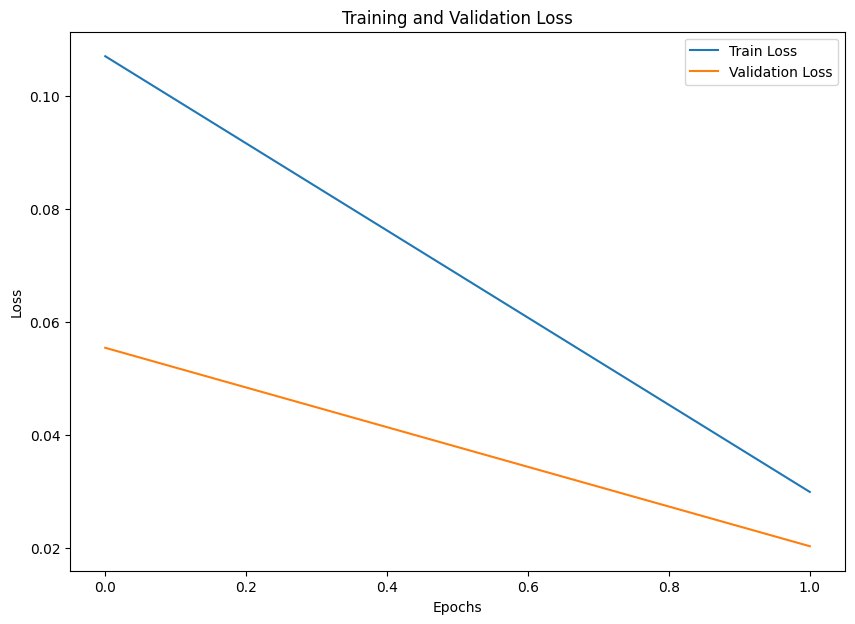


---------DONE TRAINING----------



In [ ]:
train_loss = []
val_loss =[]
model = UNet().to(DEVICE)
optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss = fit(model, train_dataloader, train_data,optimizer,criterion)
    val_epoch_loss = validate(model, valid_dataloader, valid_data, criterion)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {val_epoch_loss:.4f}')

# Plot the training and validation loss
plt.figure(figsize=(10, 7))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Save the model
torch.save({
    'epoch': EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': criterion,
}, "./model.pth")

print("\n---------DONE TRAINING----------\n")

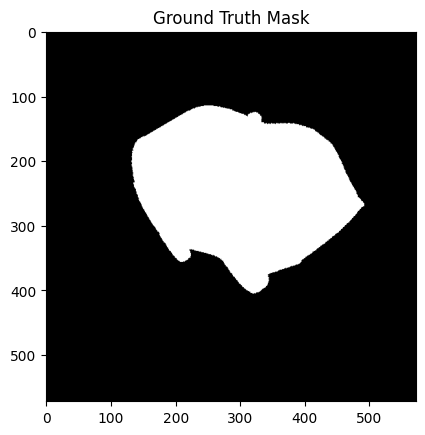

Mask shape: torch.Size([572, 572])


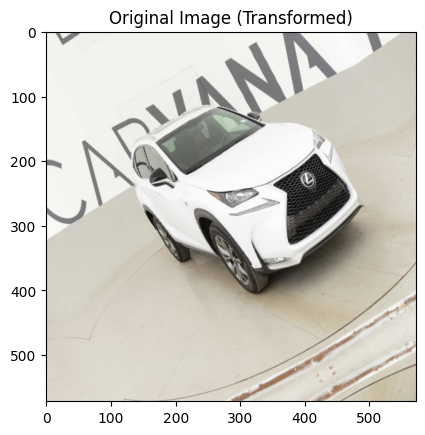

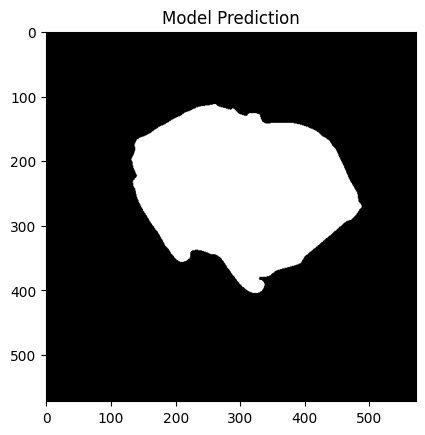

Prediction shape: torch.Size([572, 572])


In [ ]:
# Test on a single datapoint
data_sample = train_data.__getitem__(100)
plt.imshow(data_sample['mask'],cmap="gray")
plt.title("Ground Truth Mask")
plt.show()
print("Mask shape:", train_data.__getitem__(0)['mask'].shape)

# Display the original image
plt.imshow(np.transpose(np.array(data_sample['image'].cpu()),(1,2,0)),cmap="gray")
plt.title("Original Image (Transformed)")
plt.show()

# Generate predictions
img_tensor = data_sample['image'].unsqueeze(0).to(device=DEVICE)
output = model(img_tensor)
output = torch.squeeze(output)
output = (output > 0.0).float()
disp = output.detach().cpu()

plt.imshow(disp,cmap="gray")
plt.title("Model Prediction")
plt.show()
print("Prediction shape:", disp.shape)

## V 1.51

In [ ]:
def calculate_iou(pred, mask):
    pred = (pred > 0.0).float()  # Predict
    intersection = torch.sum(pred * mask)
    union = torch.sum(pred) + torch.sum(mask) - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)  # IOU
    return iou.item()

def fit(model, dataloader, data, optimizer, criterion):
    print('-------------Training---------------')
    model.train()
    train_running_loss = 0.0
    train_running_iou = 0.0
    counter = 0

    num_batches = int(np.ceil(len(data) / dataloader.batch_size))
    for i, batch_data in tqdm(enumerate(dataloader), total=num_batches):
        counter += 1
        image, mask = batch_data["image"].to(DEVICE), batch_data["mask"].to(DEVICE)
        optimizer.zero_grad()
        outputs = model(image)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, mask)
        train_running_loss += loss.item()
        iou = calculate_iou(outputs, mask)
        train_running_iou += iou
        loss.backward()
        optimizer.step()

        # Print the loss and IoU for this batch
        print(f"Batch {i + 1}/{num_batches}, Loss: {loss.item():.6f}, IoU: {iou:.6f}")

    train_loss = train_running_loss / counter
    train_iou = train_running_iou / counter
    return train_loss, train_iou

def validate(model, dataloader, data, criterion):
    print("\n--------Validating---------\n")
    model.eval()
    valid_running_loss = 0.0
    valid_running_iou = 0.0
    counter = 0
    num_batches = int(np.ceil(len(data) / dataloader.batch_size))

    with torch.no_grad():
        for i, batch_data in tqdm(enumerate(dataloader), total=num_batches):
            counter += 1
            image, mask = batch_data["image"].to(DEVICE), batch_data["mask"].to(DEVICE)
            outputs = model(image)
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, mask)
            valid_running_loss += loss.item()
            iou = calculate_iou(outputs, mask)
            valid_running_iou += iou

            # Print the loss and IoU for this batch
            print(f"Batch {i + 1}/{num_batches}, Loss: {loss.item():.6f}, IoU: {iou:.6f}")

    valid_loss = valid_running_loss / counter
    valid_iou = valid_running_iou / counter
    return valid_loss, valid_iou


In [ ]:
train_transform = A.Compose([
    A.Resize(IMAGE_HEIGHT, IMAGE_WIDTH),
    A.Rotate(limit=35, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
        max_pixel_value=255.0
    ),
    ToTensorV2()
])

validation_transform = A.Compose([
    A.Resize(IMAGE_HEIGHT, IMAGE_WIDTH),
    A.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
        max_pixel_value=255.0,
    ),
    ToTensorV2()
])

In [ ]:
def train_test_split(images,splitSize):
    imageLen = len(images)
    val_len = int(splitSize*imageLen)
    train_len = imageLen - val_len
    train_images,val_images = images[:train_len],images[train_len:]
    return train_images,val_images

In [ ]:
# Split the data
train_images_path,val_images_path = train_test_split(images,SPLIT)
train_data = CarvanaDataset(train_images_path,TRAIN_IMG_DIR,TRAIN_MASK_DIR,train_transform,True)
valid_data = CarvanaDataset(val_images_path,TRAIN_IMG_DIR,TRAIN_MASK_DIR,validation_transform,True)
train_dataloader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKERS,pin_memory=PIN_MEMORY)
valid_dataloader = DataLoader(valid_data,batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKERS,pin_memory=PIN_MEMORY)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)


In [ ]:
from sklearn.model_selection import train_test_split

train_images_path, val_images_path = train_test_split(images, test_size=SPLIT)
print("Number of training images:", len(train_images_path))
print("Number of validation images:", len(val_images_path))


Number of training images: 4070
Number of validation images: 1018


In [ ]:
train_data = CarvanaDataset(
    images=train_images_path,
    image_dir=TRAIN_IMG_DIR,
    mask_dir=TRAIN_MASK_DIR,
    transform=train_transform,
    train=True
)
valid_data = CarvanaDataset(
    images=val_images_path,
    image_dir=TRAIN_IMG_DIR,
    mask_dir=TRAIN_MASK_DIR,
    transform=validation_transform,
    train=True
)


Epoch 1 of 2
-------------Training---------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
  0%|          | 1/1018 [00:05<1:26:13,  5.09s/it]

Batch 1/1018, Loss: 0.780547, IoU: 0.118316


  0%|          | 2/1018 [00:06<47:21,  2.80s/it]  

Batch 2/1018, Loss: 0.673022, IoU: 0.341301


  0%|          | 3/1018 [00:07<34:43,  2.05s/it]

Batch 3/1018, Loss: 0.652367, IoU: 0.318087


  0%|          | 4/1018 [00:08<28:45,  1.70s/it]

Batch 4/1018, Loss: 0.592331, IoU: 0.496959


  0%|          | 5/1018 [00:09<25:27,  1.51s/it]

Batch 5/1018, Loss: 0.597274, IoU: 0.428943


  1%|          | 6/1018 [00:10<23:29,  1.39s/it]

Batch 6/1018, Loss: 0.521647, IoU: 0.565424


  1%|          | 7/1018 [00:12<22:15,  1.32s/it]

Batch 7/1018, Loss: 0.516366, IoU: 0.565676


  1%|          | 8/1018 [00:13<21:29,  1.28s/it]

Batch 8/1018, Loss: 0.478864, IoU: 0.607096


  1%|          | 9/1018 [00:14<20:58,  1.25s/it]

Batch 9/1018, Loss: 0.496016, IoU: 0.521147


  1%|          | 10/1018 [00:15<20:32,  1.22s/it]

Batch 10/1018, Loss: 0.427097, IoU: 0.693058


  1%|          | 11/1018 [00:16<20:46,  1.24s/it]

Batch 11/1018, Loss: 0.540149, IoU: 0.459029


  1%|          | 12/1018 [00:18<20:56,  1.25s/it]

Batch 12/1018, Loss: 0.464268, IoU: 0.573531


  1%|▏         | 13/1018 [00:19<21:21,  1.28s/it]

Batch 13/1018, Loss: 0.462364, IoU: 0.550103


  1%|▏         | 14/1018 [00:20<21:05,  1.26s/it]

Batch 14/1018, Loss: 0.405543, IoU: 0.674463


  1%|▏         | 15/1018 [00:22<21:19,  1.28s/it]

Batch 15/1018, Loss: 0.432984, IoU: 0.587733


  2%|▏         | 16/1018 [00:23<21:04,  1.26s/it]

Batch 16/1018, Loss: 0.382752, IoU: 0.712490


  2%|▏         | 17/1018 [00:24<20:37,  1.24s/it]

Batch 17/1018, Loss: 0.438012, IoU: 0.551356


  2%|▏         | 18/1018 [00:25<20:17,  1.22s/it]

Batch 18/1018, Loss: 0.430137, IoU: 0.537931


  2%|▏         | 19/1018 [00:26<20:02,  1.20s/it]

Batch 19/1018, Loss: 0.414542, IoU: 0.590422


  2%|▏         | 20/1018 [00:27<19:52,  1.20s/it]

Batch 20/1018, Loss: 0.403486, IoU: 0.614920


  2%|▏         | 21/1018 [00:29<19:48,  1.19s/it]

Batch 21/1018, Loss: 0.380440, IoU: 0.690077


  2%|▏         | 22/1018 [00:30<19:45,  1.19s/it]

Batch 22/1018, Loss: 0.396537, IoU: 0.633454


  2%|▏         | 23/1018 [00:31<19:41,  1.19s/it]

Batch 23/1018, Loss: 0.365282, IoU: 0.718831


  2%|▏         | 24/1018 [00:32<19:37,  1.19s/it]

Batch 24/1018, Loss: 0.342782, IoU: 0.802120


  2%|▏         | 25/1018 [00:33<19:37,  1.19s/it]

Batch 25/1018, Loss: 0.334784, IoU: 0.776557


  3%|▎         | 26/1018 [00:35<20:13,  1.22s/it]

Batch 26/1018, Loss: 0.338244, IoU: 0.765561


  3%|▎         | 27/1018 [00:36<20:44,  1.26s/it]

Batch 27/1018, Loss: 0.333313, IoU: 0.780907


  3%|▎         | 28/1018 [00:37<21:08,  1.28s/it]

Batch 28/1018, Loss: 0.357465, IoU: 0.720202


  3%|▎         | 29/1018 [00:39<21:20,  1.29s/it]

Batch 29/1018, Loss: 0.323782, IoU: 0.829796


  3%|▎         | 30/1018 [00:40<21:23,  1.30s/it]

Batch 30/1018, Loss: 0.296011, IoU: 0.885413


  3%|▎         | 31/1018 [00:41<21:32,  1.31s/it]

Batch 31/1018, Loss: 0.363776, IoU: 0.711807


  3%|▎         | 32/1018 [00:43<21:41,  1.32s/it]

Batch 32/1018, Loss: 0.293981, IoU: 0.872310


  3%|▎         | 33/1018 [00:44<21:49,  1.33s/it]

Batch 33/1018, Loss: 0.294251, IoU: 0.856627


  3%|▎         | 34/1018 [00:45<21:30,  1.31s/it]

Batch 34/1018, Loss: 0.285878, IoU: 0.893161


  3%|▎         | 35/1018 [00:47<21:36,  1.32s/it]

Batch 35/1018, Loss: 0.295020, IoU: 0.862789


  4%|▎         | 36/1018 [00:48<20:59,  1.28s/it]

Batch 36/1018, Loss: 0.271867, IoU: 0.914553


  4%|▎         | 37/1018 [00:49<20:35,  1.26s/it]

Batch 37/1018, Loss: 0.281205, IoU: 0.885725


  4%|▎         | 38/1018 [00:50<20:17,  1.24s/it]

Batch 38/1018, Loss: 0.266697, IoU: 0.913253


  4%|▍         | 39/1018 [00:51<20:03,  1.23s/it]

Batch 39/1018, Loss: 0.395129, IoU: 0.663858


  4%|▍         | 40/1018 [00:53<20:19,  1.25s/it]

Batch 40/1018, Loss: 0.318483, IoU: 0.764898


  4%|▍         | 41/1018 [00:54<20:38,  1.27s/it]

Batch 41/1018, Loss: 0.276749, IoU: 0.865964


  4%|▍         | 42/1018 [00:55<20:52,  1.28s/it]

Batch 42/1018, Loss: 0.307806, IoU: 0.801887


  4%|▍         | 43/1018 [00:57<21:13,  1.31s/it]

Batch 43/1018, Loss: 0.308594, IoU: 0.796757


  4%|▍         | 44/1018 [00:58<21:18,  1.31s/it]

Batch 44/1018, Loss: 0.266895, IoU: 0.894189


  4%|▍         | 45/1018 [00:59<21:29,  1.33s/it]

Batch 45/1018, Loss: 0.335956, IoU: 0.778690


  5%|▍         | 46/1018 [01:01<20:54,  1.29s/it]

Batch 46/1018, Loss: 0.294181, IoU: 0.854896


  5%|▍         | 47/1018 [01:02<20:28,  1.26s/it]

Batch 47/1018, Loss: 0.273924, IoU: 0.902983


  5%|▍         | 48/1018 [01:03<20:13,  1.25s/it]

Batch 48/1018, Loss: 0.301803, IoU: 0.821723


  5%|▍         | 49/1018 [01:04<20:02,  1.24s/it]

Batch 49/1018, Loss: 0.271033, IoU: 0.866348


  5%|▍         | 50/1018 [01:06<19:54,  1.23s/it]

Batch 50/1018, Loss: 0.289537, IoU: 0.843257


  5%|▌         | 51/1018 [01:07<19:50,  1.23s/it]

Batch 51/1018, Loss: 0.272033, IoU: 0.890023


  5%|▌         | 52/1018 [01:08<19:44,  1.23s/it]

Batch 52/1018, Loss: 0.277835, IoU: 0.873703


  5%|▌         | 53/1018 [01:09<19:41,  1.22s/it]

Batch 53/1018, Loss: 0.254082, IoU: 0.911172


  5%|▌         | 54/1018 [01:10<19:55,  1.24s/it]

Batch 54/1018, Loss: 0.261976, IoU: 0.895840


  5%|▌         | 55/1018 [01:12<20:13,  1.26s/it]

Batch 55/1018, Loss: 0.255827, IoU: 0.897070


  6%|▌         | 56/1018 [01:13<20:54,  1.30s/it]

Batch 56/1018, Loss: 0.268095, IoU: 0.885770


  6%|▌         | 57/1018 [01:15<21:13,  1.32s/it]

Batch 57/1018, Loss: 0.254641, IoU: 0.931618


  6%|▌         | 58/1018 [01:16<21:25,  1.34s/it]

Batch 58/1018, Loss: 0.263419, IoU: 0.853522


  6%|▌         | 59/1018 [01:17<21:44,  1.36s/it]

Batch 59/1018, Loss: 0.256817, IoU: 0.884755


  6%|▌         | 60/1018 [01:19<21:04,  1.32s/it]

Batch 60/1018, Loss: 0.255055, IoU: 0.914614


  6%|▌         | 61/1018 [01:20<20:39,  1.29s/it]

Batch 61/1018, Loss: 0.253690, IoU: 0.914169


  6%|▌         | 62/1018 [01:21<20:28,  1.28s/it]

Batch 62/1018, Loss: 0.238983, IoU: 0.926568


  6%|▌         | 63/1018 [01:22<20:16,  1.27s/it]

Batch 63/1018, Loss: 0.299688, IoU: 0.769476


  6%|▋         | 64/1018 [01:24<20:05,  1.26s/it]

Batch 64/1018, Loss: 0.293369, IoU: 0.823246


  6%|▋         | 65/1018 [01:25<19:57,  1.26s/it]

Batch 65/1018, Loss: 0.261009, IoU: 0.863214


  6%|▋         | 66/1018 [01:26<19:52,  1.25s/it]

Batch 66/1018, Loss: 0.258749, IoU: 0.891598


  7%|▋         | 67/1018 [01:27<19:51,  1.25s/it]

Batch 67/1018, Loss: 0.258526, IoU: 0.857092


  7%|▋         | 68/1018 [01:29<20:11,  1.28s/it]

Batch 68/1018, Loss: 0.277535, IoU: 0.837542


  7%|▋         | 69/1018 [01:30<20:24,  1.29s/it]

Batch 69/1018, Loss: 0.246661, IoU: 0.894066


  7%|▋         | 70/1018 [01:31<20:44,  1.31s/it]

Batch 70/1018, Loss: 0.251058, IoU: 0.903885


  7%|▋         | 71/1018 [01:33<21:08,  1.34s/it]

Batch 71/1018, Loss: 0.244264, IoU: 0.884424


  7%|▋         | 72/1018 [01:34<21:34,  1.37s/it]

Batch 72/1018, Loss: 0.277295, IoU: 0.827364


  7%|▋         | 73/1018 [01:36<21:55,  1.39s/it]

Batch 73/1018, Loss: 0.248893, IoU: 0.857370


  7%|▋         | 74/1018 [01:37<21:13,  1.35s/it]

Batch 74/1018, Loss: 0.259465, IoU: 0.856093


  7%|▋         | 75/1018 [01:38<20:44,  1.32s/it]

Batch 75/1018, Loss: 0.251209, IoU: 0.859849


  7%|▋         | 76/1018 [01:39<20:25,  1.30s/it]

Batch 76/1018, Loss: 0.243029, IoU: 0.892814


  8%|▊         | 77/1018 [01:41<20:11,  1.29s/it]

Batch 77/1018, Loss: 0.236045, IoU: 0.911311


  8%|▊         | 78/1018 [01:42<20:08,  1.29s/it]

Batch 78/1018, Loss: 0.240143, IoU: 0.897552


  8%|▊         | 79/1018 [01:43<19:58,  1.28s/it]

Batch 79/1018, Loss: 0.233505, IoU: 0.905919


  8%|▊         | 80/1018 [01:44<19:50,  1.27s/it]

Batch 80/1018, Loss: 0.271734, IoU: 0.826616


  8%|▊         | 81/1018 [01:46<19:47,  1.27s/it]

Batch 81/1018, Loss: 0.229227, IoU: 0.922072


  8%|▊         | 82/1018 [01:47<20:13,  1.30s/it]

Batch 82/1018, Loss: 0.238646, IoU: 0.895177


  8%|▊         | 83/1018 [01:48<20:33,  1.32s/it]

Batch 83/1018, Loss: 0.248153, IoU: 0.888828


  8%|▊         | 84/1018 [01:50<20:59,  1.35s/it]

Batch 84/1018, Loss: 0.229541, IoU: 0.932846


  8%|▊         | 85/1018 [01:51<21:06,  1.36s/it]

Batch 85/1018, Loss: 0.223679, IoU: 0.931774


  8%|▊         | 86/1018 [01:52<20:58,  1.35s/it]

Batch 86/1018, Loss: 0.232403, IoU: 0.926492


  9%|▊         | 87/1018 [01:54<20:38,  1.33s/it]

Batch 87/1018, Loss: 0.239871, IoU: 0.861467


  9%|▊         | 88/1018 [01:55<20:28,  1.32s/it]

Batch 88/1018, Loss: 0.224313, IoU: 0.906217


  9%|▊         | 89/1018 [01:56<20:16,  1.31s/it]

Batch 89/1018, Loss: 0.266050, IoU: 0.826155


  9%|▉         | 90/1018 [01:58<20:11,  1.31s/it]

Batch 90/1018, Loss: 0.241720, IoU: 0.871273


  9%|▉         | 91/1018 [01:59<20:03,  1.30s/it]

Batch 91/1018, Loss: 0.266331, IoU: 0.826388


  9%|▉         | 92/1018 [02:00<20:01,  1.30s/it]

Batch 92/1018, Loss: 0.229485, IoU: 0.902021


  9%|▉         | 93/1018 [02:02<19:58,  1.30s/it]

Batch 93/1018, Loss: 0.273960, IoU: 0.804023


  9%|▉         | 94/1018 [02:03<19:58,  1.30s/it]

Batch 94/1018, Loss: 0.222710, IoU: 0.933758


  9%|▉         | 95/1018 [02:04<20:32,  1.33s/it]

Batch 95/1018, Loss: 0.232227, IoU: 0.914278


  9%|▉         | 96/1018 [02:06<20:43,  1.35s/it]

Batch 96/1018, Loss: 0.243613, IoU: 0.888155


 10%|▉         | 97/1018 [02:07<21:16,  1.39s/it]

Batch 97/1018, Loss: 0.235395, IoU: 0.885530


 10%|▉         | 98/1018 [02:09<21:26,  1.40s/it]

Batch 98/1018, Loss: 0.231425, IoU: 0.884718


 10%|▉         | 99/1018 [02:10<21:33,  1.41s/it]

Batch 99/1018, Loss: 0.248448, IoU: 0.877595


 10%|▉         | 100/1018 [02:11<21:36,  1.41s/it]

Batch 100/1018, Loss: 0.240513, IoU: 0.916482


 10%|▉         | 101/1018 [02:13<21:07,  1.38s/it]

Batch 101/1018, Loss: 0.234347, IoU: 0.899646


 10%|█         | 102/1018 [02:14<20:49,  1.36s/it]

Batch 102/1018, Loss: 0.218373, IoU: 0.941383


 10%|█         | 103/1018 [02:15<20:40,  1.36s/it]

Batch 103/1018, Loss: 0.233567, IoU: 0.890539


 10%|█         | 104/1018 [02:17<20:31,  1.35s/it]

Batch 104/1018, Loss: 0.247053, IoU: 0.862476


 10%|█         | 105/1018 [02:18<20:21,  1.34s/it]

Batch 105/1018, Loss: 0.212346, IoU: 0.923425


 10%|█         | 106/1018 [02:19<20:18,  1.34s/it]

Batch 106/1018, Loss: 0.232960, IoU: 0.869641


 11%|█         | 107/1018 [02:21<20:12,  1.33s/it]

Batch 107/1018, Loss: 0.225416, IoU: 0.916194


 11%|█         | 108/1018 [02:22<20:41,  1.36s/it]

Batch 108/1018, Loss: 0.214023, IoU: 0.932340


 11%|█         | 109/1018 [02:23<20:42,  1.37s/it]

Batch 109/1018, Loss: 0.235813, IoU: 0.885104


 11%|█         | 110/1018 [02:25<21:06,  1.39s/it]

Batch 110/1018, Loss: 0.238833, IoU: 0.860962


 11%|█         | 111/1018 [02:26<21:09,  1.40s/it]

Batch 111/1018, Loss: 0.247343, IoU: 0.859982


 11%|█         | 112/1018 [02:28<21:02,  1.39s/it]

Batch 112/1018, Loss: 0.213900, IoU: 0.920049


 11%|█         | 113/1018 [02:29<20:39,  1.37s/it]

Batch 113/1018, Loss: 0.212880, IoU: 0.905605


 11%|█         | 114/1018 [02:30<20:19,  1.35s/it]

Batch 114/1018, Loss: 0.210560, IoU: 0.936271


 11%|█▏        | 115/1018 [02:32<20:04,  1.33s/it]

Batch 115/1018, Loss: 0.228810, IoU: 0.888498


 11%|█▏        | 116/1018 [02:33<19:51,  1.32s/it]

Batch 116/1018, Loss: 0.236271, IoU: 0.860789


 11%|█▏        | 117/1018 [02:34<19:43,  1.31s/it]

Batch 117/1018, Loss: 0.246242, IoU: 0.824606


 12%|█▏        | 118/1018 [02:36<19:37,  1.31s/it]

Batch 118/1018, Loss: 0.202024, IoU: 0.942060


 12%|█▏        | 119/1018 [02:37<19:31,  1.30s/it]

Batch 119/1018, Loss: 0.231811, IoU: 0.867162


 12%|█▏        | 120/1018 [02:38<19:24,  1.30s/it]

Batch 120/1018, Loss: 0.225665, IoU: 0.896442


 12%|█▏        | 121/1018 [02:39<19:45,  1.32s/it]

Batch 121/1018, Loss: 0.221675, IoU: 0.910601


 12%|█▏        | 122/1018 [02:41<19:59,  1.34s/it]

Batch 122/1018, Loss: 0.224441, IoU: 0.917685


 12%|█▏        | 123/1018 [02:42<20:26,  1.37s/it]

Batch 123/1018, Loss: 0.231029, IoU: 0.897867


 12%|█▏        | 124/1018 [02:44<20:30,  1.38s/it]

Batch 124/1018, Loss: 0.214681, IoU: 0.917699


 12%|█▏        | 125/1018 [02:45<20:26,  1.37s/it]

Batch 125/1018, Loss: 0.208434, IoU: 0.938098


 12%|█▏        | 126/1018 [02:47<20:50,  1.40s/it]

Batch 126/1018, Loss: 0.215847, IoU: 0.920257


 12%|█▏        | 127/1018 [02:48<20:15,  1.36s/it]

Batch 127/1018, Loss: 0.213689, IoU: 0.937144


 13%|█▎        | 128/1018 [02:49<19:49,  1.34s/it]

Batch 128/1018, Loss: 0.205430, IoU: 0.923565


 13%|█▎        | 129/1018 [02:50<19:33,  1.32s/it]

Batch 129/1018, Loss: 0.208360, IoU: 0.938616


 13%|█▎        | 130/1018 [02:52<19:20,  1.31s/it]

Batch 130/1018, Loss: 0.217493, IoU: 0.910194


 13%|█▎        | 131/1018 [02:53<19:16,  1.30s/it]

Batch 131/1018, Loss: 0.199489, IoU: 0.926992


 13%|█▎        | 132/1018 [02:54<19:06,  1.29s/it]

Batch 132/1018, Loss: 0.215295, IoU: 0.911594


 13%|█▎        | 133/1018 [02:55<19:07,  1.30s/it]

Batch 133/1018, Loss: 0.213917, IoU: 0.927302


 13%|█▎        | 134/1018 [02:57<19:14,  1.31s/it]

Batch 134/1018, Loss: 0.252990, IoU: 0.825976


 13%|█▎        | 135/1018 [02:58<19:32,  1.33s/it]

Batch 135/1018, Loss: 0.205862, IoU: 0.931046


 13%|█▎        | 136/1018 [03:00<20:00,  1.36s/it]

Batch 136/1018, Loss: 0.202404, IoU: 0.941120


 13%|█▎        | 137/1018 [03:01<20:13,  1.38s/it]

Batch 137/1018, Loss: 0.197955, IoU: 0.942600


 14%|█▎        | 138/1018 [03:02<20:11,  1.38s/it]

Batch 138/1018, Loss: 0.211930, IoU: 0.902553


 14%|█▎        | 139/1018 [03:04<20:26,  1.40s/it]

Batch 139/1018, Loss: 0.207207, IoU: 0.924450


 14%|█▍        | 140/1018 [03:05<19:59,  1.37s/it]

Batch 140/1018, Loss: 0.197236, IoU: 0.917473


 14%|█▍        | 141/1018 [03:06<19:38,  1.34s/it]

Batch 141/1018, Loss: 0.206788, IoU: 0.932018


 14%|█▍        | 142/1018 [03:08<19:25,  1.33s/it]

Batch 142/1018, Loss: 0.207337, IoU: 0.919056


 14%|█▍        | 143/1018 [03:09<19:10,  1.31s/it]

Batch 143/1018, Loss: 0.193930, IoU: 0.930959


 14%|█▍        | 144/1018 [03:10<19:02,  1.31s/it]

Batch 144/1018, Loss: 0.187599, IoU: 0.944666


 14%|█▍        | 145/1018 [03:12<18:58,  1.30s/it]

Batch 145/1018, Loss: 0.191597, IoU: 0.944783


 14%|█▍        | 146/1018 [03:13<18:55,  1.30s/it]

Batch 146/1018, Loss: 0.185699, IoU: 0.942864


 14%|█▍        | 147/1018 [03:14<19:07,  1.32s/it]

Batch 147/1018, Loss: 0.222058, IoU: 0.875181


 15%|█▍        | 148/1018 [03:16<19:35,  1.35s/it]

Batch 148/1018, Loss: 0.183835, IoU: 0.947688


 15%|█▍        | 149/1018 [03:17<19:57,  1.38s/it]

Batch 149/1018, Loss: 0.195054, IoU: 0.936829


 15%|█▍        | 150/1018 [03:19<20:00,  1.38s/it]

Batch 150/1018, Loss: 0.195362, IoU: 0.921947


 15%|█▍        | 151/1018 [03:20<20:09,  1.40s/it]

Batch 151/1018, Loss: 0.201400, IoU: 0.933741


 15%|█▍        | 152/1018 [03:21<19:56,  1.38s/it]

Batch 152/1018, Loss: 0.189679, IoU: 0.928410


 15%|█▌        | 153/1018 [03:23<19:33,  1.36s/it]

Batch 153/1018, Loss: 0.195420, IoU: 0.954134


 15%|█▌        | 154/1018 [03:24<19:16,  1.34s/it]

Batch 154/1018, Loss: 0.204642, IoU: 0.905042


 15%|█▌        | 155/1018 [03:25<19:07,  1.33s/it]

Batch 155/1018, Loss: 0.189876, IoU: 0.936163


 15%|█▌        | 156/1018 [03:27<19:02,  1.33s/it]

Batch 156/1018, Loss: 0.192606, IoU: 0.921788


 15%|█▌        | 157/1018 [03:28<18:53,  1.32s/it]

Batch 157/1018, Loss: 0.199568, IoU: 0.951246


 16%|█▌        | 158/1018 [03:29<18:47,  1.31s/it]

Batch 158/1018, Loss: 0.195807, IoU: 0.948692


 16%|█▌        | 159/1018 [03:30<18:51,  1.32s/it]

Batch 159/1018, Loss: 0.201540, IoU: 0.914711


 16%|█▌        | 160/1018 [03:32<18:54,  1.32s/it]

Batch 160/1018, Loss: 0.193715, IoU: 0.916583


 16%|█▌        | 161/1018 [03:33<19:14,  1.35s/it]

Batch 161/1018, Loss: 0.206734, IoU: 0.903191


 16%|█▌        | 162/1018 [03:35<19:34,  1.37s/it]

Batch 162/1018, Loss: 0.191476, IoU: 0.944133


 16%|█▌        | 163/1018 [03:36<19:40,  1.38s/it]

Batch 163/1018, Loss: 0.203168, IoU: 0.927936


 16%|█▌        | 164/1018 [03:37<19:48,  1.39s/it]

Batch 164/1018, Loss: 0.207329, IoU: 0.922078


 16%|█▌        | 165/1018 [03:39<20:02,  1.41s/it]

Batch 165/1018, Loss: 0.188715, IoU: 0.944910


 16%|█▋        | 166/1018 [03:40<19:32,  1.38s/it]

Batch 166/1018, Loss: 0.200225, IoU: 0.914378


 16%|█▋        | 167/1018 [03:41<19:09,  1.35s/it]

Batch 167/1018, Loss: 0.186380, IoU: 0.930515


 17%|█▋        | 168/1018 [03:43<18:55,  1.34s/it]

Batch 168/1018, Loss: 0.190238, IoU: 0.948547


 17%|█▋        | 169/1018 [03:44<18:43,  1.32s/it]

Batch 169/1018, Loss: 0.202337, IoU: 0.908217


 17%|█▋        | 170/1018 [03:45<18:36,  1.32s/it]

Batch 170/1018, Loss: 0.201220, IoU: 0.939760


 17%|█▋        | 171/1018 [03:47<18:30,  1.31s/it]

Batch 171/1018, Loss: 0.173932, IoU: 0.963068


 17%|█▋        | 172/1018 [03:48<18:30,  1.31s/it]

Batch 172/1018, Loss: 0.190176, IoU: 0.930064


 17%|█▋        | 173/1018 [03:49<18:42,  1.33s/it]

Batch 173/1018, Loss: 0.183658, IoU: 0.939645


 17%|█▋        | 174/1018 [03:51<18:51,  1.34s/it]

Batch 174/1018, Loss: 0.181268, IoU: 0.952063


 17%|█▋        | 175/1018 [03:52<18:49,  1.34s/it]

Batch 175/1018, Loss: 0.178576, IoU: 0.941179


 17%|█▋        | 176/1018 [03:53<18:47,  1.34s/it]

Batch 176/1018, Loss: 0.176441, IoU: 0.946648


 17%|█▋        | 177/1018 [03:55<19:18,  1.38s/it]

Batch 177/1018, Loss: 0.201489, IoU: 0.914948


 17%|█▋        | 178/1018 [03:56<18:57,  1.35s/it]

Batch 178/1018, Loss: 0.183631, IoU: 0.944960


 18%|█▊        | 179/1018 [03:57<18:42,  1.34s/it]

Batch 179/1018, Loss: 0.191979, IoU: 0.933015


 18%|█▊        | 180/1018 [03:59<18:30,  1.33s/it]

Batch 180/1018, Loss: 0.187874, IoU: 0.950918


 18%|█▊        | 181/1018 [04:00<18:20,  1.32s/it]

Batch 181/1018, Loss: 0.170942, IoU: 0.968642


 18%|█▊        | 182/1018 [04:01<18:13,  1.31s/it]

Batch 182/1018, Loss: 0.185515, IoU: 0.941529


 18%|█▊        | 183/1018 [04:03<18:10,  1.31s/it]

Batch 183/1018, Loss: 0.178375, IoU: 0.955279


 18%|█▊        | 184/1018 [04:04<18:06,  1.30s/it]

Batch 184/1018, Loss: 0.178579, IoU: 0.961030


 18%|█▊        | 185/1018 [04:05<18:02,  1.30s/it]

Batch 185/1018, Loss: 0.172476, IoU: 0.963751


 18%|█▊        | 186/1018 [04:07<18:25,  1.33s/it]

Batch 186/1018, Loss: 0.192837, IoU: 0.937816


 18%|█▊        | 187/1018 [04:08<18:28,  1.33s/it]

Batch 187/1018, Loss: 0.174955, IoU: 0.958587


 18%|█▊        | 188/1018 [04:09<18:34,  1.34s/it]

Batch 188/1018, Loss: 0.170868, IoU: 0.951770


 19%|█▊        | 189/1018 [04:11<18:54,  1.37s/it]

Batch 189/1018, Loss: 0.183034, IoU: 0.930774


 19%|█▊        | 190/1018 [04:12<19:14,  1.39s/it]

Batch 190/1018, Loss: 0.174723, IoU: 0.961941


 19%|█▉        | 191/1018 [04:13<18:42,  1.36s/it]

Batch 191/1018, Loss: 0.175251, IoU: 0.944241


 19%|█▉        | 192/1018 [04:15<18:25,  1.34s/it]

Batch 192/1018, Loss: 0.177234, IoU: 0.954807


 19%|█▉        | 193/1018 [04:16<18:14,  1.33s/it]

Batch 193/1018, Loss: 0.176781, IoU: 0.951635


 19%|█▉        | 194/1018 [04:17<18:10,  1.32s/it]

Batch 194/1018, Loss: 0.176224, IoU: 0.949825


 19%|█▉        | 195/1018 [04:19<18:00,  1.31s/it]

Batch 195/1018, Loss: 0.188552, IoU: 0.916527


 19%|█▉        | 196/1018 [04:20<17:56,  1.31s/it]

Batch 196/1018, Loss: 0.179743, IoU: 0.958856


 19%|█▉        | 197/1018 [04:21<17:51,  1.31s/it]

Batch 197/1018, Loss: 0.183694, IoU: 0.945454


 19%|█▉        | 198/1018 [04:23<17:58,  1.32s/it]

Batch 198/1018, Loss: 0.171384, IoU: 0.948931


 20%|█▉        | 199/1018 [04:24<18:16,  1.34s/it]

Batch 199/1018, Loss: 0.185853, IoU: 0.927023


 20%|█▉        | 200/1018 [04:25<18:39,  1.37s/it]

Batch 200/1018, Loss: 0.183742, IoU: 0.899365


 20%|█▉        | 201/1018 [04:27<18:51,  1.39s/it]

Batch 201/1018, Loss: 0.179307, IoU: 0.932060


 20%|█▉        | 202/1018 [04:28<18:56,  1.39s/it]

Batch 202/1018, Loss: 0.177288, IoU: 0.925414


 20%|█▉        | 203/1018 [04:30<18:56,  1.39s/it]

Batch 203/1018, Loss: 0.174338, IoU: 0.931216


 20%|██        | 204/1018 [04:31<18:34,  1.37s/it]

Batch 204/1018, Loss: 0.191368, IoU: 0.901440


 20%|██        | 205/1018 [04:32<18:14,  1.35s/it]

Batch 205/1018, Loss: 0.166261, IoU: 0.944055


 20%|██        | 206/1018 [04:34<18:01,  1.33s/it]

Batch 206/1018, Loss: 0.178583, IoU: 0.916393


 20%|██        | 207/1018 [04:35<17:51,  1.32s/it]

Batch 207/1018, Loss: 0.172969, IoU: 0.960710


 20%|██        | 208/1018 [04:36<17:47,  1.32s/it]

Batch 208/1018, Loss: 0.171492, IoU: 0.951705


 21%|██        | 209/1018 [04:38<17:42,  1.31s/it]

Batch 209/1018, Loss: 0.158902, IoU: 0.954942


 21%|██        | 210/1018 [04:39<17:38,  1.31s/it]

Batch 210/1018, Loss: 0.186338, IoU: 0.903270


 21%|██        | 211/1018 [04:40<17:52,  1.33s/it]

Batch 211/1018, Loss: 0.168613, IoU: 0.931376


 21%|██        | 212/1018 [04:41<17:49,  1.33s/it]

Batch 212/1018, Loss: 0.177262, IoU: 0.938618


 21%|██        | 213/1018 [04:43<18:14,  1.36s/it]

Batch 213/1018, Loss: 0.174849, IoU: 0.950939


 21%|██        | 214/1018 [04:44<18:25,  1.38s/it]

Batch 214/1018, Loss: 0.175242, IoU: 0.917571


 21%|██        | 215/1018 [04:46<18:34,  1.39s/it]

Batch 215/1018, Loss: 0.169995, IoU: 0.944162


 21%|██        | 216/1018 [04:47<18:55,  1.42s/it]

Batch 216/1018, Loss: 0.172109, IoU: 0.938690


 21%|██▏       | 217/1018 [04:49<19:08,  1.43s/it]

Batch 217/1018, Loss: 0.176113, IoU: 0.942920


 21%|██▏       | 218/1018 [04:50<19:08,  1.44s/it]

Batch 218/1018, Loss: 0.179186, IoU: 0.925180


 22%|██▏       | 219/1018 [04:52<19:07,  1.44s/it]

Batch 219/1018, Loss: 0.173577, IoU: 0.925319


 22%|██▏       | 220/1018 [04:53<19:02,  1.43s/it]

Batch 220/1018, Loss: 0.163737, IoU: 0.948276


 22%|██▏       | 221/1018 [04:54<19:02,  1.43s/it]

Batch 221/1018, Loss: 0.158901, IoU: 0.969492


 22%|██▏       | 222/1018 [04:56<18:29,  1.39s/it]

Batch 222/1018, Loss: 0.180841, IoU: 0.926122


 22%|██▏       | 223/1018 [04:57<18:07,  1.37s/it]

Batch 223/1018, Loss: 0.180760, IoU: 0.917831


 22%|██▏       | 224/1018 [04:58<17:49,  1.35s/it]

Batch 224/1018, Loss: 0.158006, IoU: 0.943792


 22%|██▏       | 225/1018 [05:00<17:50,  1.35s/it]

Batch 225/1018, Loss: 0.177620, IoU: 0.912328


 22%|██▏       | 226/1018 [05:01<17:57,  1.36s/it]

Batch 226/1018, Loss: 0.186990, IoU: 0.901168


 22%|██▏       | 227/1018 [05:03<18:15,  1.39s/it]

Batch 227/1018, Loss: 0.162400, IoU: 0.945640


 22%|██▏       | 228/1018 [05:04<18:21,  1.39s/it]

Batch 228/1018, Loss: 0.177133, IoU: 0.919005


 22%|██▏       | 229/1018 [05:05<18:34,  1.41s/it]

Batch 229/1018, Loss: 0.161956, IoU: 0.957001


 23%|██▎       | 230/1018 [05:07<18:43,  1.43s/it]

Batch 230/1018, Loss: 0.170768, IoU: 0.929763


 23%|██▎       | 231/1018 [05:08<18:14,  1.39s/it]

Batch 231/1018, Loss: 0.190024, IoU: 0.868697


 23%|██▎       | 232/1018 [05:09<17:52,  1.36s/it]

Batch 232/1018, Loss: 0.170484, IoU: 0.941949


 23%|██▎       | 233/1018 [05:11<17:40,  1.35s/it]

Batch 233/1018, Loss: 0.174035, IoU: 0.923003


 23%|██▎       | 234/1018 [05:12<17:26,  1.33s/it]

Batch 234/1018, Loss: 0.181031, IoU: 0.907581


 23%|██▎       | 235/1018 [05:13<17:17,  1.32s/it]

Batch 235/1018, Loss: 0.167925, IoU: 0.945889


 23%|██▎       | 236/1018 [05:15<17:09,  1.32s/it]

Batch 236/1018, Loss: 0.177071, IoU: 0.912500


 23%|██▎       | 237/1018 [05:16<17:06,  1.31s/it]

Batch 237/1018, Loss: 0.192396, IoU: 0.863261


 23%|██▎       | 238/1018 [05:17<17:09,  1.32s/it]

Batch 238/1018, Loss: 0.154639, IoU: 0.953698


 23%|██▎       | 239/1018 [05:19<17:34,  1.35s/it]

Batch 239/1018, Loss: 0.164817, IoU: 0.930488


 24%|██▎       | 240/1018 [05:20<17:44,  1.37s/it]

Batch 240/1018, Loss: 0.187987, IoU: 0.878401


 24%|██▎       | 241/1018 [05:22<17:51,  1.38s/it]

Batch 241/1018, Loss: 0.190762, IoU: 0.860924


 24%|██▍       | 242/1018 [05:23<18:13,  1.41s/it]

Batch 242/1018, Loss: 0.155276, IoU: 0.955828


 24%|██▍       | 243/1018 [05:24<18:17,  1.42s/it]

Batch 243/1018, Loss: 0.167482, IoU: 0.936557


 24%|██▍       | 244/1018 [05:26<17:47,  1.38s/it]

Batch 244/1018, Loss: 0.171970, IoU: 0.907102


 24%|██▍       | 245/1018 [05:27<17:26,  1.35s/it]

Batch 245/1018, Loss: 0.149189, IoU: 0.948476


 24%|██▍       | 246/1018 [05:28<17:10,  1.34s/it]

Batch 246/1018, Loss: 0.171292, IoU: 0.917396


 24%|██▍       | 247/1018 [05:30<17:00,  1.32s/it]

Batch 247/1018, Loss: 0.160318, IoU: 0.919964


 24%|██▍       | 248/1018 [05:31<16:52,  1.32s/it]

Batch 248/1018, Loss: 0.179182, IoU: 0.915471


 24%|██▍       | 249/1018 [05:32<16:46,  1.31s/it]

Batch 249/1018, Loss: 0.157346, IoU: 0.937031


 25%|██▍       | 250/1018 [05:34<16:43,  1.31s/it]

Batch 250/1018, Loss: 0.175137, IoU: 0.925893


 25%|██▍       | 251/1018 [05:35<17:10,  1.34s/it]

Batch 251/1018, Loss: 0.168170, IoU: 0.936234


 25%|██▍       | 252/1018 [05:36<17:24,  1.36s/it]

Batch 252/1018, Loss: 0.175876, IoU: 0.914403


 25%|██▍       | 253/1018 [05:38<17:24,  1.37s/it]

Batch 253/1018, Loss: 0.158082, IoU: 0.944924


 25%|██▍       | 254/1018 [05:39<17:31,  1.38s/it]

Batch 254/1018, Loss: 0.174897, IoU: 0.892157


 25%|██▌       | 255/1018 [05:41<17:43,  1.39s/it]

Batch 255/1018, Loss: 0.187400, IoU: 0.879120


 25%|██▌       | 256/1018 [05:42<17:57,  1.41s/it]

Batch 256/1018, Loss: 0.153163, IoU: 0.940378


 25%|██▌       | 257/1018 [05:43<17:29,  1.38s/it]

Batch 257/1018, Loss: 0.161021, IoU: 0.953615


 25%|██▌       | 258/1018 [05:45<17:06,  1.35s/it]

Batch 258/1018, Loss: 0.157801, IoU: 0.949879


 25%|██▌       | 259/1018 [05:46<16:52,  1.33s/it]

Batch 259/1018, Loss: 0.165941, IoU: 0.920807


 26%|██▌       | 260/1018 [05:47<16:45,  1.33s/it]

Batch 260/1018, Loss: 0.151240, IoU: 0.950286


 26%|██▌       | 261/1018 [05:49<16:38,  1.32s/it]

Batch 261/1018, Loss: 0.173293, IoU: 0.901152


 26%|██▌       | 262/1018 [05:50<16:32,  1.31s/it]

Batch 262/1018, Loss: 0.165603, IoU: 0.934486


 26%|██▌       | 263/1018 [05:51<16:27,  1.31s/it]

Batch 263/1018, Loss: 0.159949, IoU: 0.934163


 26%|██▌       | 264/1018 [05:52<16:28,  1.31s/it]

Batch 264/1018, Loss: 0.182759, IoU: 0.909655


 26%|██▌       | 265/1018 [05:54<16:49,  1.34s/it]

Batch 265/1018, Loss: 0.159536, IoU: 0.957031


 26%|██▌       | 266/1018 [05:55<17:04,  1.36s/it]

Batch 266/1018, Loss: 0.175695, IoU: 0.903724


 26%|██▌       | 267/1018 [05:57<17:15,  1.38s/it]

Batch 267/1018, Loss: 0.164568, IoU: 0.933978


 26%|██▋       | 268/1018 [05:58<17:21,  1.39s/it]

Batch 268/1018, Loss: 0.180517, IoU: 0.871708


 26%|██▋       | 269/1018 [06:00<17:37,  1.41s/it]

Batch 269/1018, Loss: 0.156833, IoU: 0.943700


 27%|██▋       | 270/1018 [06:01<17:13,  1.38s/it]

Batch 270/1018, Loss: 0.161926, IoU: 0.935481


 27%|██▋       | 271/1018 [06:02<16:55,  1.36s/it]

Batch 271/1018, Loss: 0.168564, IoU: 0.905161


 27%|██▋       | 272/1018 [06:04<16:42,  1.34s/it]

Batch 272/1018, Loss: 0.157352, IoU: 0.931676


 27%|██▋       | 273/1018 [06:05<16:33,  1.33s/it]

Batch 273/1018, Loss: 0.154773, IoU: 0.936941


 27%|██▋       | 274/1018 [06:06<16:25,  1.32s/it]

Batch 274/1018, Loss: 0.159067, IoU: 0.930605


 27%|██▋       | 275/1018 [06:07<16:17,  1.32s/it]

Batch 275/1018, Loss: 0.150868, IoU: 0.940567


 27%|██▋       | 276/1018 [06:09<16:11,  1.31s/it]

Batch 276/1018, Loss: 0.144389, IoU: 0.953909


 27%|██▋       | 277/1018 [06:10<16:07,  1.31s/it]

Batch 277/1018, Loss: 0.146090, IoU: 0.953011


 27%|██▋       | 278/1018 [06:11<16:27,  1.33s/it]

Batch 278/1018, Loss: 0.146757, IoU: 0.948635


 27%|██▋       | 279/1018 [06:13<16:47,  1.36s/it]

Batch 279/1018, Loss: 0.168649, IoU: 0.917320


 28%|██▊       | 280/1018 [06:14<17:04,  1.39s/it]

Batch 280/1018, Loss: 0.148678, IoU: 0.947057


 28%|██▊       | 281/1018 [06:16<16:57,  1.38s/it]

Batch 281/1018, Loss: 0.160129, IoU: 0.929658


 28%|██▊       | 282/1018 [06:17<17:09,  1.40s/it]

Batch 282/1018, Loss: 0.150235, IoU: 0.938509


 28%|██▊       | 283/1018 [06:18<16:45,  1.37s/it]

Batch 283/1018, Loss: 0.159789, IoU: 0.937008


 28%|██▊       | 284/1018 [06:20<16:28,  1.35s/it]

Batch 284/1018, Loss: 0.141401, IoU: 0.957380


 28%|██▊       | 285/1018 [06:21<16:16,  1.33s/it]

Batch 285/1018, Loss: 0.154210, IoU: 0.939675


 28%|██▊       | 286/1018 [06:22<16:09,  1.32s/it]

Batch 286/1018, Loss: 0.156421, IoU: 0.932023


 28%|██▊       | 287/1018 [06:24<16:03,  1.32s/it]

Batch 287/1018, Loss: 0.159063, IoU: 0.953231


 28%|██▊       | 288/1018 [06:25<16:01,  1.32s/it]

Batch 288/1018, Loss: 0.180165, IoU: 0.896310


 28%|██▊       | 289/1018 [06:26<15:58,  1.31s/it]

Batch 289/1018, Loss: 0.160672, IoU: 0.955830


 28%|██▊       | 290/1018 [06:28<15:55,  1.31s/it]

Batch 290/1018, Loss: 0.150349, IoU: 0.959388


 29%|██▊       | 291/1018 [06:29<16:01,  1.32s/it]

Batch 291/1018, Loss: 0.155874, IoU: 0.917634


 29%|██▊       | 292/1018 [06:30<16:05,  1.33s/it]

Batch 292/1018, Loss: 0.159317, IoU: 0.908913


 29%|██▉       | 293/1018 [06:32<16:09,  1.34s/it]

Batch 293/1018, Loss: 0.150131, IoU: 0.941339


 29%|██▉       | 294/1018 [06:33<16:37,  1.38s/it]

Batch 294/1018, Loss: 0.148429, IoU: 0.940662


 29%|██▉       | 295/1018 [06:35<16:53,  1.40s/it]

Batch 295/1018, Loss: 0.149447, IoU: 0.924940


 29%|██▉       | 296/1018 [06:36<16:34,  1.38s/it]

Batch 296/1018, Loss: 0.150418, IoU: 0.933214


 29%|██▉       | 297/1018 [06:37<16:15,  1.35s/it]

Batch 297/1018, Loss: 0.151366, IoU: 0.917050


 29%|██▉       | 298/1018 [06:38<16:04,  1.34s/it]

Batch 298/1018, Loss: 0.165079, IoU: 0.910668


 29%|██▉       | 299/1018 [06:40<15:55,  1.33s/it]

Batch 299/1018, Loss: 0.130395, IoU: 0.955232


 29%|██▉       | 300/1018 [06:41<15:45,  1.32s/it]

Batch 300/1018, Loss: 0.145306, IoU: 0.959547


 30%|██▉       | 301/1018 [06:42<15:38,  1.31s/it]

Batch 301/1018, Loss: 0.147927, IoU: 0.941712


 30%|██▉       | 302/1018 [06:44<15:31,  1.30s/it]

Batch 302/1018, Loss: 0.156264, IoU: 0.939076


 30%|██▉       | 303/1018 [06:45<15:28,  1.30s/it]

Batch 303/1018, Loss: 0.148728, IoU: 0.945222


 30%|██▉       | 304/1018 [06:46<15:51,  1.33s/it]

Batch 304/1018, Loss: 0.139625, IoU: 0.954146


 30%|██▉       | 305/1018 [06:48<16:02,  1.35s/it]

Batch 305/1018, Loss: 0.145419, IoU: 0.952697


 30%|███       | 306/1018 [06:49<16:10,  1.36s/it]

Batch 306/1018, Loss: 0.153398, IoU: 0.937385


 30%|███       | 307/1018 [06:51<16:21,  1.38s/it]

Batch 307/1018, Loss: 0.163532, IoU: 0.910955


 30%|███       | 308/1018 [06:52<16:31,  1.40s/it]

Batch 308/1018, Loss: 0.153750, IoU: 0.936091


 30%|███       | 309/1018 [06:53<16:06,  1.36s/it]

Batch 309/1018, Loss: 0.142427, IoU: 0.939598


 30%|███       | 310/1018 [06:55<15:50,  1.34s/it]

Batch 310/1018, Loss: 0.149428, IoU: 0.939626


 31%|███       | 311/1018 [06:56<15:38,  1.33s/it]

Batch 311/1018, Loss: 0.143586, IoU: 0.953095


 31%|███       | 312/1018 [06:57<15:32,  1.32s/it]

Batch 312/1018, Loss: 0.158566, IoU: 0.910308


 31%|███       | 313/1018 [06:58<15:24,  1.31s/it]

Batch 313/1018, Loss: 0.146434, IoU: 0.959068


 31%|███       | 314/1018 [07:00<15:20,  1.31s/it]

Batch 314/1018, Loss: 0.152843, IoU: 0.937762


 31%|███       | 315/1018 [07:01<15:16,  1.30s/it]

Batch 315/1018, Loss: 0.154819, IoU: 0.934855


 31%|███       | 316/1018 [07:02<15:11,  1.30s/it]

Batch 316/1018, Loss: 0.143098, IoU: 0.934930


 31%|███       | 317/1018 [07:04<15:18,  1.31s/it]

Batch 317/1018, Loss: 0.135269, IoU: 0.946350


 31%|███       | 318/1018 [07:05<15:33,  1.33s/it]

Batch 318/1018, Loss: 0.138182, IoU: 0.936232


 31%|███▏      | 319/1018 [07:06<15:56,  1.37s/it]

Batch 319/1018, Loss: 0.137949, IoU: 0.938353


 31%|███▏      | 320/1018 [07:08<16:02,  1.38s/it]

Batch 320/1018, Loss: 0.150244, IoU: 0.920839


 32%|███▏      | 321/1018 [07:09<16:05,  1.39s/it]

Batch 321/1018, Loss: 0.141609, IoU: 0.929037


 32%|███▏      | 322/1018 [07:11<16:14,  1.40s/it]

Batch 322/1018, Loss: 0.166168, IoU: 0.877477


 32%|███▏      | 323/1018 [07:12<15:50,  1.37s/it]

Batch 323/1018, Loss: 0.159285, IoU: 0.909979


 32%|███▏      | 324/1018 [07:13<15:34,  1.35s/it]

Batch 324/1018, Loss: 0.129631, IoU: 0.956586


 32%|███▏      | 325/1018 [07:15<15:23,  1.33s/it]

Batch 325/1018, Loss: 0.142078, IoU: 0.953732


 32%|███▏      | 326/1018 [07:16<15:19,  1.33s/it]

Batch 326/1018, Loss: 0.138549, IoU: 0.960373


 32%|███▏      | 327/1018 [07:17<15:15,  1.33s/it]

Batch 327/1018, Loss: 0.158544, IoU: 0.888978


 32%|███▏      | 328/1018 [07:19<15:07,  1.32s/it]

Batch 328/1018, Loss: 0.143160, IoU: 0.954298


 32%|███▏      | 329/1018 [07:20<15:02,  1.31s/it]

Batch 329/1018, Loss: 0.137425, IoU: 0.949936


 32%|███▏      | 330/1018 [07:21<15:19,  1.34s/it]

Batch 330/1018, Loss: 0.151179, IoU: 0.903503


 33%|███▎      | 331/1018 [07:23<15:25,  1.35s/it]

Batch 331/1018, Loss: 0.134313, IoU: 0.939460


 33%|███▎      | 332/1018 [07:24<15:44,  1.38s/it]

Batch 332/1018, Loss: 0.140722, IoU: 0.943291


 33%|███▎      | 333/1018 [07:25<15:51,  1.39s/it]

Batch 333/1018, Loss: 0.142430, IoU: 0.943414


 33%|███▎      | 334/1018 [07:27<16:08,  1.42s/it]

Batch 334/1018, Loss: 0.128411, IoU: 0.962834


 33%|███▎      | 335/1018 [07:28<15:41,  1.38s/it]

Batch 335/1018, Loss: 0.182542, IoU: 0.851780


 33%|███▎      | 336/1018 [07:30<15:26,  1.36s/it]

Batch 336/1018, Loss: 0.131192, IoU: 0.947632


 33%|███▎      | 337/1018 [07:31<15:15,  1.34s/it]

Batch 337/1018, Loss: 0.150809, IoU: 0.930011


 33%|███▎      | 338/1018 [07:32<15:06,  1.33s/it]

Batch 338/1018, Loss: 0.145337, IoU: 0.945425


 33%|███▎      | 339/1018 [07:33<14:59,  1.32s/it]

Batch 339/1018, Loss: 0.147702, IoU: 0.947566


 33%|███▎      | 340/1018 [07:35<14:51,  1.32s/it]

Batch 340/1018, Loss: 0.188358, IoU: 0.832872


 33%|███▎      | 341/1018 [07:36<14:46,  1.31s/it]

Batch 341/1018, Loss: 0.135712, IoU: 0.960030


 34%|███▎      | 342/1018 [07:37<14:41,  1.30s/it]

Batch 342/1018, Loss: 0.156993, IoU: 0.894558


 34%|███▎      | 343/1018 [07:39<15:14,  1.35s/it]

Batch 343/1018, Loss: 0.153797, IoU: 0.892093


 34%|███▍      | 344/1018 [07:40<15:25,  1.37s/it]

Batch 344/1018, Loss: 0.137330, IoU: 0.947408


 34%|███▍      | 345/1018 [07:42<15:36,  1.39s/it]

Batch 345/1018, Loss: 0.142773, IoU: 0.924577


 34%|███▍      | 346/1018 [07:43<15:26,  1.38s/it]

Batch 346/1018, Loss: 0.145171, IoU: 0.921817


 34%|███▍      | 347/1018 [07:44<15:42,  1.40s/it]

Batch 347/1018, Loss: 0.158359, IoU: 0.902819


 34%|███▍      | 348/1018 [07:46<15:20,  1.37s/it]

Batch 348/1018, Loss: 0.138717, IoU: 0.958469


 34%|███▍      | 349/1018 [07:47<15:03,  1.35s/it]

Batch 349/1018, Loss: 0.153390, IoU: 0.923342


 34%|███▍      | 350/1018 [07:48<14:51,  1.33s/it]

Batch 350/1018, Loss: 0.137250, IoU: 0.956312


 34%|███▍      | 351/1018 [07:50<14:41,  1.32s/it]

Batch 351/1018, Loss: 0.155431, IoU: 0.918360


 35%|███▍      | 352/1018 [07:51<14:35,  1.31s/it]

Batch 352/1018, Loss: 0.138478, IoU: 0.940376


 35%|███▍      | 353/1018 [07:52<14:30,  1.31s/it]

Batch 353/1018, Loss: 0.155150, IoU: 0.897327


 35%|███▍      | 354/1018 [07:54<14:30,  1.31s/it]

Batch 354/1018, Loss: 0.138864, IoU: 0.925876


 35%|███▍      | 355/1018 [07:55<14:26,  1.31s/it]

Batch 355/1018, Loss: 0.163188, IoU: 0.870287


 35%|███▍      | 356/1018 [07:56<14:47,  1.34s/it]

Batch 356/1018, Loss: 0.132392, IoU: 0.965872


 35%|███▌      | 357/1018 [07:58<14:50,  1.35s/it]

Batch 357/1018, Loss: 0.135742, IoU: 0.929102


 35%|███▌      | 358/1018 [07:59<15:05,  1.37s/it]

Batch 358/1018, Loss: 0.134770, IoU: 0.927585


 35%|███▌      | 359/1018 [08:01<15:13,  1.39s/it]

Batch 359/1018, Loss: 0.136778, IoU: 0.946023


 35%|███▌      | 360/1018 [08:02<15:29,  1.41s/it]

Batch 360/1018, Loss: 0.137810, IoU: 0.941292


 35%|███▌      | 361/1018 [08:03<15:09,  1.38s/it]

Batch 361/1018, Loss: 0.164517, IoU: 0.862543


 36%|███▌      | 362/1018 [08:05<14:50,  1.36s/it]

Batch 362/1018, Loss: 0.135228, IoU: 0.924257


 36%|███▌      | 363/1018 [08:06<14:37,  1.34s/it]

Batch 363/1018, Loss: 0.135017, IoU: 0.923797


 36%|███▌      | 364/1018 [08:07<14:27,  1.33s/it]

Batch 364/1018, Loss: 0.131701, IoU: 0.942673


 36%|███▌      | 365/1018 [08:08<14:19,  1.32s/it]

Batch 365/1018, Loss: 0.146866, IoU: 0.913608


 36%|███▌      | 366/1018 [08:10<14:14,  1.31s/it]

Batch 366/1018, Loss: 0.124112, IoU: 0.962685


 36%|███▌      | 367/1018 [08:11<14:12,  1.31s/it]

Batch 367/1018, Loss: 0.129313, IoU: 0.953051


 36%|███▌      | 368/1018 [08:12<14:10,  1.31s/it]

Batch 368/1018, Loss: 0.130319, IoU: 0.945450


 36%|███▌      | 369/1018 [08:14<14:31,  1.34s/it]

Batch 369/1018, Loss: 0.137409, IoU: 0.923503


 36%|███▋      | 370/1018 [08:15<14:46,  1.37s/it]

Batch 370/1018, Loss: 0.130003, IoU: 0.950206


 36%|███▋      | 371/1018 [08:17<15:02,  1.39s/it]

Batch 371/1018, Loss: 0.118545, IoU: 0.956821


 37%|███▋      | 372/1018 [08:18<15:09,  1.41s/it]

Batch 372/1018, Loss: 0.143976, IoU: 0.916822


 37%|███▋      | 373/1018 [08:20<15:17,  1.42s/it]

Batch 373/1018, Loss: 0.126615, IoU: 0.934695


 37%|███▋      | 374/1018 [08:21<15:02,  1.40s/it]

Batch 374/1018, Loss: 0.128615, IoU: 0.949431


 37%|███▋      | 375/1018 [08:22<14:40,  1.37s/it]

Batch 375/1018, Loss: 0.143352, IoU: 0.912510


 37%|███▋      | 376/1018 [08:24<14:24,  1.35s/it]

Batch 376/1018, Loss: 0.136121, IoU: 0.939699


 37%|███▋      | 377/1018 [08:25<14:14,  1.33s/it]

Batch 377/1018, Loss: 0.125103, IoU: 0.961365


 37%|███▋      | 378/1018 [08:26<14:05,  1.32s/it]

Batch 378/1018, Loss: 0.121035, IoU: 0.953482


 37%|███▋      | 379/1018 [08:27<13:58,  1.31s/it]

Batch 379/1018, Loss: 0.131088, IoU: 0.943449


 37%|███▋      | 380/1018 [08:29<13:54,  1.31s/it]

Batch 380/1018, Loss: 0.138302, IoU: 0.936996


 37%|███▋      | 381/1018 [08:30<13:52,  1.31s/it]

Batch 381/1018, Loss: 0.122937, IoU: 0.951536


 38%|███▊      | 382/1018 [08:31<14:02,  1.32s/it]

Batch 382/1018, Loss: 0.138427, IoU: 0.928838


 38%|███▊      | 383/1018 [08:33<14:17,  1.35s/it]

Batch 383/1018, Loss: 0.121999, IoU: 0.955667


 38%|███▊      | 384/1018 [08:34<14:37,  1.38s/it]

Batch 384/1018, Loss: 0.133078, IoU: 0.953294


 38%|███▊      | 385/1018 [08:36<14:45,  1.40s/it]

Batch 385/1018, Loss: 0.122070, IoU: 0.955201


 38%|███▊      | 386/1018 [08:37<14:51,  1.41s/it]

Batch 386/1018, Loss: 0.128760, IoU: 0.953671


 38%|███▊      | 387/1018 [08:39<15:02,  1.43s/it]

Batch 387/1018, Loss: 0.127237, IoU: 0.963003


 38%|███▊      | 388/1018 [08:40<14:43,  1.40s/it]

Batch 388/1018, Loss: 0.127461, IoU: 0.957388


 38%|███▊      | 389/1018 [08:41<14:23,  1.37s/it]

Batch 389/1018, Loss: 0.119175, IoU: 0.962073


 38%|███▊      | 390/1018 [08:43<14:08,  1.35s/it]

Batch 390/1018, Loss: 0.122874, IoU: 0.960914


 38%|███▊      | 391/1018 [08:44<13:57,  1.34s/it]

Batch 391/1018, Loss: 0.132259, IoU: 0.941285


 39%|███▊      | 392/1018 [08:45<13:51,  1.33s/it]

Batch 392/1018, Loss: 0.125772, IoU: 0.943905


 39%|███▊      | 393/1018 [08:46<13:44,  1.32s/it]

Batch 393/1018, Loss: 0.125776, IoU: 0.963614


 39%|███▊      | 394/1018 [08:48<13:37,  1.31s/it]

Batch 394/1018, Loss: 0.123946, IoU: 0.950608


 39%|███▉      | 395/1018 [08:49<13:47,  1.33s/it]

Batch 395/1018, Loss: 0.120529, IoU: 0.956345


 39%|███▉      | 396/1018 [08:51<13:58,  1.35s/it]

Batch 396/1018, Loss: 0.122886, IoU: 0.951428


 39%|███▉      | 397/1018 [08:52<14:13,  1.37s/it]

Batch 397/1018, Loss: 0.122070, IoU: 0.964007


 39%|███▉      | 398/1018 [08:53<14:20,  1.39s/it]

Batch 398/1018, Loss: 0.118033, IoU: 0.968358


 39%|███▉      | 399/1018 [08:55<14:32,  1.41s/it]

Batch 399/1018, Loss: 0.118388, IoU: 0.959289


 39%|███▉      | 400/1018 [08:56<14:39,  1.42s/it]

Batch 400/1018, Loss: 0.120678, IoU: 0.952767


 39%|███▉      | 401/1018 [08:58<14:33,  1.42s/it]

Batch 401/1018, Loss: 0.116023, IoU: 0.951347


 39%|███▉      | 402/1018 [08:59<14:39,  1.43s/it]

Batch 402/1018, Loss: 0.123379, IoU: 0.948096


 40%|███▉      | 403/1018 [09:01<14:43,  1.44s/it]

Batch 403/1018, Loss: 0.124529, IoU: 0.946150


 40%|███▉      | 404/1018 [09:02<14:48,  1.45s/it]

Batch 404/1018, Loss: 0.113404, IoU: 0.958531


 40%|███▉      | 405/1018 [09:03<14:33,  1.43s/it]

Batch 405/1018, Loss: 0.121690, IoU: 0.944389


 40%|███▉      | 406/1018 [09:05<14:11,  1.39s/it]

Batch 406/1018, Loss: 0.120092, IoU: 0.952955


 40%|███▉      | 407/1018 [09:06<13:52,  1.36s/it]

Batch 407/1018, Loss: 0.133629, IoU: 0.921542


 40%|████      | 408/1018 [09:07<13:38,  1.34s/it]

Batch 408/1018, Loss: 0.122593, IoU: 0.966049


 40%|████      | 409/1018 [09:09<13:49,  1.36s/it]

Batch 409/1018, Loss: 0.122512, IoU: 0.968866


 40%|████      | 410/1018 [09:10<14:01,  1.38s/it]

Batch 410/1018, Loss: 0.124707, IoU: 0.946017


 40%|████      | 411/1018 [09:12<14:13,  1.41s/it]

Batch 411/1018, Loss: 0.120365, IoU: 0.945530


 40%|████      | 412/1018 [09:13<14:17,  1.42s/it]

Batch 412/1018, Loss: 0.117193, IoU: 0.954890


 41%|████      | 413/1018 [09:15<14:27,  1.43s/it]

Batch 413/1018, Loss: 0.115825, IoU: 0.945402


 41%|████      | 414/1018 [09:16<14:03,  1.40s/it]

Batch 414/1018, Loss: 0.114229, IoU: 0.963435


 41%|████      | 415/1018 [09:17<13:43,  1.37s/it]

Batch 415/1018, Loss: 0.123281, IoU: 0.938014


 41%|████      | 416/1018 [09:18<13:30,  1.35s/it]

Batch 416/1018, Loss: 0.114431, IoU: 0.958921


 41%|████      | 417/1018 [09:20<13:23,  1.34s/it]

Batch 417/1018, Loss: 0.118932, IoU: 0.951315


 41%|████      | 418/1018 [09:21<13:12,  1.32s/it]

Batch 418/1018, Loss: 0.110949, IoU: 0.957384


 41%|████      | 419/1018 [09:22<13:05,  1.31s/it]

Batch 419/1018, Loss: 0.132098, IoU: 0.927678


 41%|████▏     | 420/1018 [09:24<13:03,  1.31s/it]

Batch 420/1018, Loss: 0.127543, IoU: 0.934594


 41%|████▏     | 421/1018 [09:25<13:02,  1.31s/it]

Batch 421/1018, Loss: 0.121517, IoU: 0.945435


 41%|████▏     | 422/1018 [09:26<13:15,  1.33s/it]

Batch 422/1018, Loss: 0.159022, IoU: 0.872028


 42%|████▏     | 423/1018 [09:28<13:32,  1.37s/it]

Batch 423/1018, Loss: 0.115461, IoU: 0.940990


 42%|████▏     | 424/1018 [09:29<13:33,  1.37s/it]

Batch 424/1018, Loss: 0.121870, IoU: 0.949599


 42%|████▏     | 425/1018 [09:31<13:47,  1.39s/it]

Batch 425/1018, Loss: 0.118540, IoU: 0.945680


 42%|████▏     | 426/1018 [09:32<13:32,  1.37s/it]

Batch 426/1018, Loss: 0.136230, IoU: 0.907596


 42%|████▏     | 427/1018 [09:33<13:20,  1.35s/it]

Batch 427/1018, Loss: 0.134607, IoU: 0.892028


 42%|████▏     | 428/1018 [09:35<13:08,  1.34s/it]

Batch 428/1018, Loss: 0.115099, IoU: 0.950222


 42%|████▏     | 429/1018 [09:36<13:02,  1.33s/it]

Batch 429/1018, Loss: 0.122094, IoU: 0.935318


 42%|████▏     | 430/1018 [09:37<12:59,  1.33s/it]

Batch 430/1018, Loss: 0.128793, IoU: 0.949159


 42%|████▏     | 431/1018 [09:38<12:54,  1.32s/it]

Batch 431/1018, Loss: 0.113168, IoU: 0.956574


 42%|████▏     | 432/1018 [09:40<12:49,  1.31s/it]

Batch 432/1018, Loss: 0.114664, IoU: 0.957422


 43%|████▎     | 433/1018 [09:41<12:45,  1.31s/it]

Batch 433/1018, Loss: 0.112330, IoU: 0.965942


 43%|████▎     | 434/1018 [09:42<12:56,  1.33s/it]

Batch 434/1018, Loss: 0.123817, IoU: 0.925508


 43%|████▎     | 435/1018 [09:44<13:12,  1.36s/it]

Batch 435/1018, Loss: 0.117875, IoU: 0.941276


 43%|████▎     | 436/1018 [09:45<13:29,  1.39s/it]

Batch 436/1018, Loss: 0.121668, IoU: 0.929211


 43%|████▎     | 437/1018 [09:47<13:37,  1.41s/it]

Batch 437/1018, Loss: 0.117248, IoU: 0.953878


 43%|████▎     | 438/1018 [09:48<13:45,  1.42s/it]

Batch 438/1018, Loss: 0.132539, IoU: 0.909186


 43%|████▎     | 439/1018 [09:50<13:23,  1.39s/it]

Batch 439/1018, Loss: 0.108541, IoU: 0.962616


 43%|████▎     | 440/1018 [09:51<13:09,  1.37s/it]

Batch 440/1018, Loss: 0.124240, IoU: 0.928442


 43%|████▎     | 441/1018 [09:52<12:55,  1.34s/it]

Batch 441/1018, Loss: 0.137993, IoU: 0.891873


 43%|████▎     | 442/1018 [09:53<12:44,  1.33s/it]

Batch 442/1018, Loss: 0.116769, IoU: 0.951196


 44%|████▎     | 443/1018 [09:55<12:39,  1.32s/it]

Batch 443/1018, Loss: 0.129250, IoU: 0.942050


 44%|████▎     | 444/1018 [09:56<12:33,  1.31s/it]

Batch 444/1018, Loss: 0.119590, IoU: 0.954912


 44%|████▎     | 445/1018 [09:57<12:30,  1.31s/it]

Batch 445/1018, Loss: 0.157373, IoU: 0.869671


 44%|████▍     | 446/1018 [09:59<12:25,  1.30s/it]

Batch 446/1018, Loss: 0.125030, IoU: 0.940681


 44%|████▍     | 447/1018 [10:00<12:48,  1.35s/it]

Batch 447/1018, Loss: 0.121734, IoU: 0.933478


 44%|████▍     | 448/1018 [10:01<12:54,  1.36s/it]

Batch 448/1018, Loss: 0.145596, IoU: 0.881204


 44%|████▍     | 449/1018 [10:03<13:04,  1.38s/it]

Batch 449/1018, Loss: 0.118623, IoU: 0.935422


 44%|████▍     | 450/1018 [10:04<13:16,  1.40s/it]

Batch 450/1018, Loss: 0.104628, IoU: 0.963585


 44%|████▍     | 451/1018 [10:06<13:12,  1.40s/it]

Batch 451/1018, Loss: 0.131055, IoU: 0.905374


 44%|████▍     | 452/1018 [10:07<12:57,  1.37s/it]

Batch 452/1018, Loss: 0.117554, IoU: 0.941244


 44%|████▍     | 453/1018 [10:08<12:45,  1.35s/it]

Batch 453/1018, Loss: 0.118899, IoU: 0.929271


 45%|████▍     | 454/1018 [10:10<12:31,  1.33s/it]

Batch 454/1018, Loss: 0.118139, IoU: 0.949544


 45%|████▍     | 455/1018 [10:11<12:34,  1.34s/it]

Batch 455/1018, Loss: 0.108231, IoU: 0.964027


 45%|████▍     | 456/1018 [10:12<12:24,  1.32s/it]

Batch 456/1018, Loss: 0.119701, IoU: 0.937305


 45%|████▍     | 457/1018 [10:14<12:18,  1.32s/it]

Batch 457/1018, Loss: 0.112346, IoU: 0.957131


 45%|████▍     | 458/1018 [10:15<12:13,  1.31s/it]

Batch 458/1018, Loss: 0.114164, IoU: 0.939149


 45%|████▌     | 459/1018 [10:16<12:10,  1.31s/it]

Batch 459/1018, Loss: 0.106437, IoU: 0.967664


 45%|████▌     | 460/1018 [10:18<12:31,  1.35s/it]

Batch 460/1018, Loss: 0.124018, IoU: 0.930903


 45%|████▌     | 461/1018 [10:19<12:27,  1.34s/it]

Batch 461/1018, Loss: 0.122925, IoU: 0.955535


 45%|████▌     | 462/1018 [10:20<12:41,  1.37s/it]

Batch 462/1018, Loss: 0.115677, IoU: 0.937771


 45%|████▌     | 463/1018 [10:22<12:45,  1.38s/it]

Batch 463/1018, Loss: 0.109320, IoU: 0.949931


 46%|████▌     | 464/1018 [10:23<12:55,  1.40s/it]

Batch 464/1018, Loss: 0.114972, IoU: 0.946664


 46%|████▌     | 465/1018 [10:25<12:59,  1.41s/it]

Batch 465/1018, Loss: 0.126740, IoU: 0.916066


 46%|████▌     | 466/1018 [10:26<12:37,  1.37s/it]

Batch 466/1018, Loss: 0.107595, IoU: 0.951974


 46%|████▌     | 467/1018 [10:27<12:24,  1.35s/it]

Batch 467/1018, Loss: 0.107529, IoU: 0.955937


 46%|████▌     | 468/1018 [10:29<12:14,  1.34s/it]

Batch 468/1018, Loss: 0.106917, IoU: 0.949744


 46%|████▌     | 469/1018 [10:30<12:05,  1.32s/it]

Batch 469/1018, Loss: 0.115943, IoU: 0.945761


 46%|████▌     | 470/1018 [10:31<12:00,  1.32s/it]

Batch 470/1018, Loss: 0.114080, IoU: 0.934239


 46%|████▋     | 471/1018 [10:32<11:58,  1.31s/it]

Batch 471/1018, Loss: 0.114048, IoU: 0.951180


 46%|████▋     | 472/1018 [10:34<11:54,  1.31s/it]

Batch 472/1018, Loss: 0.113582, IoU: 0.942032


 46%|████▋     | 473/1018 [10:35<12:09,  1.34s/it]

Batch 473/1018, Loss: 0.107276, IoU: 0.959817


 47%|████▋     | 474/1018 [10:36<12:03,  1.33s/it]

Batch 474/1018, Loss: 0.103652, IoU: 0.957238


 47%|████▋     | 475/1018 [10:38<12:23,  1.37s/it]

Batch 475/1018, Loss: 0.113205, IoU: 0.957297


 47%|████▋     | 476/1018 [10:39<12:34,  1.39s/it]

Batch 476/1018, Loss: 0.107128, IoU: 0.962608


 47%|████▋     | 477/1018 [10:41<12:43,  1.41s/it]

Batch 477/1018, Loss: 0.106309, IoU: 0.962108


 47%|████▋     | 478/1018 [10:42<12:34,  1.40s/it]

Batch 478/1018, Loss: 0.107467, IoU: 0.964409


 47%|████▋     | 479/1018 [10:44<12:17,  1.37s/it]

Batch 479/1018, Loss: 0.111550, IoU: 0.947117


 47%|████▋     | 480/1018 [10:45<12:03,  1.35s/it]

Batch 480/1018, Loss: 0.102430, IoU: 0.960510


 47%|████▋     | 481/1018 [10:46<11:54,  1.33s/it]

Batch 481/1018, Loss: 0.106535, IoU: 0.957269


 47%|████▋     | 482/1018 [10:47<11:46,  1.32s/it]

Batch 482/1018, Loss: 0.118583, IoU: 0.935683


 47%|████▋     | 483/1018 [10:49<11:42,  1.31s/it]

Batch 483/1018, Loss: 0.105897, IoU: 0.951747


 48%|████▊     | 484/1018 [10:50<11:38,  1.31s/it]

Batch 484/1018, Loss: 0.111334, IoU: 0.946236


 48%|████▊     | 485/1018 [10:51<11:35,  1.30s/it]

Batch 485/1018, Loss: 0.110208, IoU: 0.965719


 48%|████▊     | 486/1018 [10:53<11:42,  1.32s/it]

Batch 486/1018, Loss: 0.114477, IoU: 0.959327


 48%|████▊     | 487/1018 [10:54<11:54,  1.35s/it]

Batch 487/1018, Loss: 0.138915, IoU: 0.883732


 48%|████▊     | 488/1018 [10:55<12:02,  1.36s/it]

Batch 488/1018, Loss: 0.123286, IoU: 0.915365


 48%|████▊     | 489/1018 [10:57<12:10,  1.38s/it]

Batch 489/1018, Loss: 0.100475, IoU: 0.963648


 48%|████▊     | 490/1018 [10:58<12:16,  1.40s/it]

Batch 490/1018, Loss: 0.112098, IoU: 0.946174


 48%|████▊     | 491/1018 [11:00<12:00,  1.37s/it]

Batch 491/1018, Loss: 0.104181, IoU: 0.963997


 48%|████▊     | 492/1018 [11:01<11:48,  1.35s/it]

Batch 492/1018, Loss: 0.111963, IoU: 0.957046


 48%|████▊     | 493/1018 [11:02<11:39,  1.33s/it]

Batch 493/1018, Loss: 0.112655, IoU: 0.953385


 49%|████▊     | 494/1018 [11:03<11:31,  1.32s/it]

Batch 494/1018, Loss: 0.108449, IoU: 0.952323


 49%|████▊     | 495/1018 [11:05<11:26,  1.31s/it]

Batch 495/1018, Loss: 0.109656, IoU: 0.949667


 49%|████▊     | 496/1018 [11:06<11:26,  1.31s/it]

Batch 496/1018, Loss: 0.114244, IoU: 0.932144


 49%|████▉     | 497/1018 [11:07<11:23,  1.31s/it]

Batch 497/1018, Loss: 0.108443, IoU: 0.949161


 49%|████▉     | 498/1018 [11:09<11:19,  1.31s/it]

Batch 498/1018, Loss: 0.108136, IoU: 0.951205


 49%|████▉     | 499/1018 [11:10<11:36,  1.34s/it]

Batch 499/1018, Loss: 0.098815, IoU: 0.968372


 49%|████▉     | 500/1018 [11:12<11:49,  1.37s/it]

Batch 500/1018, Loss: 0.108546, IoU: 0.944858


 49%|████▉     | 501/1018 [11:13<11:50,  1.37s/it]

Batch 501/1018, Loss: 0.135669, IoU: 0.894564


 49%|████▉     | 502/1018 [11:14<11:45,  1.37s/it]

Batch 502/1018, Loss: 0.100541, IoU: 0.966797


 49%|████▉     | 503/1018 [11:16<11:49,  1.38s/it]

Batch 503/1018, Loss: 0.103668, IoU: 0.962718


 50%|████▉     | 504/1018 [11:17<11:37,  1.36s/it]

Batch 504/1018, Loss: 0.122867, IoU: 0.920504


 50%|████▉     | 505/1018 [11:18<11:26,  1.34s/it]

Batch 505/1018, Loss: 0.094260, IoU: 0.968738


 50%|████▉     | 506/1018 [11:20<11:21,  1.33s/it]

Batch 506/1018, Loss: 0.104984, IoU: 0.943810


 50%|████▉     | 507/1018 [11:21<11:15,  1.32s/it]

Batch 507/1018, Loss: 0.115741, IoU: 0.938300


 50%|████▉     | 508/1018 [11:22<11:11,  1.32s/it]

Batch 508/1018, Loss: 0.137138, IoU: 0.901909


 50%|█████     | 509/1018 [11:24<11:07,  1.31s/it]

Batch 509/1018, Loss: 0.102538, IoU: 0.960814


 50%|█████     | 510/1018 [11:25<11:07,  1.31s/it]

Batch 510/1018, Loss: 0.115792, IoU: 0.933372


 50%|█████     | 511/1018 [11:26<11:19,  1.34s/it]

Batch 511/1018, Loss: 0.109910, IoU: 0.935144


 50%|█████     | 512/1018 [11:28<11:30,  1.36s/it]

Batch 512/1018, Loss: 0.127804, IoU: 0.924047


 50%|█████     | 513/1018 [11:29<11:36,  1.38s/it]

Batch 513/1018, Loss: 0.139218, IoU: 0.876884


 50%|█████     | 514/1018 [11:31<11:47,  1.40s/it]

Batch 514/1018, Loss: 0.108659, IoU: 0.946744


 51%|█████     | 515/1018 [11:32<11:33,  1.38s/it]

Batch 515/1018, Loss: 0.098953, IoU: 0.953233


 51%|█████     | 516/1018 [11:33<11:26,  1.37s/it]

Batch 516/1018, Loss: 0.110730, IoU: 0.940115


 51%|█████     | 517/1018 [11:35<11:14,  1.35s/it]

Batch 517/1018, Loss: 0.143303, IoU: 0.882340


 51%|█████     | 518/1018 [11:36<11:05,  1.33s/it]

Batch 518/1018, Loss: 0.123356, IoU: 0.911222


 51%|█████     | 519/1018 [11:37<10:59,  1.32s/it]

Batch 519/1018, Loss: 0.098275, IoU: 0.956353


 51%|█████     | 520/1018 [11:38<10:54,  1.31s/it]

Batch 520/1018, Loss: 0.105936, IoU: 0.963385


 51%|█████     | 521/1018 [11:40<10:50,  1.31s/it]

Batch 521/1018, Loss: 0.114009, IoU: 0.931212


 51%|█████▏    | 522/1018 [11:41<10:47,  1.31s/it]

Batch 522/1018, Loss: 0.110957, IoU: 0.929973


 51%|█████▏    | 523/1018 [11:42<10:51,  1.32s/it]

Batch 523/1018, Loss: 0.120792, IoU: 0.915991


 51%|█████▏    | 524/1018 [11:44<11:01,  1.34s/it]

Batch 524/1018, Loss: 0.111568, IoU: 0.924254


 52%|█████▏    | 525/1018 [11:45<11:07,  1.35s/it]

Batch 525/1018, Loss: 0.103100, IoU: 0.953524


 52%|█████▏    | 526/1018 [11:47<11:16,  1.37s/it]

Batch 526/1018, Loss: 0.107232, IoU: 0.914494


 52%|█████▏    | 527/1018 [11:48<11:23,  1.39s/it]

Batch 527/1018, Loss: 0.106960, IoU: 0.940193


 52%|█████▏    | 528/1018 [11:49<11:31,  1.41s/it]

Batch 528/1018, Loss: 0.125590, IoU: 0.876443


 52%|█████▏    | 529/1018 [11:51<11:12,  1.37s/it]

Batch 529/1018, Loss: 0.113177, IoU: 0.933851


 52%|█████▏    | 530/1018 [11:52<10:58,  1.35s/it]

Batch 530/1018, Loss: 0.098767, IoU: 0.968658


 52%|█████▏    | 531/1018 [11:53<10:50,  1.33s/it]

Batch 531/1018, Loss: 0.110685, IoU: 0.930244


 52%|█████▏    | 532/1018 [11:55<10:43,  1.32s/it]

Batch 532/1018, Loss: 0.115156, IoU: 0.924013


 52%|█████▏    | 533/1018 [11:56<10:37,  1.31s/it]

Batch 533/1018, Loss: 0.095074, IoU: 0.966166


 52%|█████▏    | 534/1018 [11:57<10:33,  1.31s/it]

Batch 534/1018, Loss: 0.106695, IoU: 0.950528


 53%|█████▎    | 535/1018 [11:59<10:33,  1.31s/it]

Batch 535/1018, Loss: 0.098727, IoU: 0.954204


 53%|█████▎    | 536/1018 [12:00<10:29,  1.31s/it]

Batch 536/1018, Loss: 0.106541, IoU: 0.930356


 53%|█████▎    | 537/1018 [12:01<10:48,  1.35s/it]

Batch 537/1018, Loss: 0.099312, IoU: 0.944197


 53%|█████▎    | 538/1018 [12:03<10:57,  1.37s/it]

Batch 538/1018, Loss: 0.111966, IoU: 0.915034


 53%|█████▎    | 539/1018 [12:04<11:06,  1.39s/it]

Batch 539/1018, Loss: 0.101741, IoU: 0.932719


 53%|█████▎    | 540/1018 [12:05<11:04,  1.39s/it]

Batch 540/1018, Loss: 0.117868, IoU: 0.906730


 53%|█████▎    | 541/1018 [12:07<11:15,  1.42s/it]

Batch 541/1018, Loss: 0.099559, IoU: 0.941240


 53%|█████▎    | 542/1018 [12:08<10:56,  1.38s/it]

Batch 542/1018, Loss: 0.105416, IoU: 0.940637


 53%|█████▎    | 543/1018 [12:10<10:42,  1.35s/it]

Batch 543/1018, Loss: 0.100417, IoU: 0.950637


 53%|█████▎    | 544/1018 [12:11<10:32,  1.34s/it]

Batch 544/1018, Loss: 0.102950, IoU: 0.952934


 54%|█████▎    | 545/1018 [12:12<10:26,  1.32s/it]

Batch 545/1018, Loss: 0.095655, IoU: 0.961125


 54%|█████▎    | 546/1018 [12:13<10:22,  1.32s/it]

Batch 546/1018, Loss: 0.100468, IoU: 0.955822


 54%|█████▎    | 547/1018 [12:15<10:18,  1.31s/it]

Batch 547/1018, Loss: 0.104009, IoU: 0.945759


 54%|█████▍    | 548/1018 [12:16<10:17,  1.31s/it]

Batch 548/1018, Loss: 0.097325, IoU: 0.956638


 54%|█████▍    | 549/1018 [12:17<10:16,  1.32s/it]

Batch 549/1018, Loss: 0.110693, IoU: 0.932148


 54%|█████▍    | 550/1018 [12:19<10:28,  1.34s/it]

Batch 550/1018, Loss: 0.098465, IoU: 0.955501


 54%|█████▍    | 551/1018 [12:20<10:40,  1.37s/it]

Batch 551/1018, Loss: 0.096114, IoU: 0.958372


 54%|█████▍    | 552/1018 [12:22<10:47,  1.39s/it]

Batch 552/1018, Loss: 0.098285, IoU: 0.958480


 54%|█████▍    | 553/1018 [12:23<10:47,  1.39s/it]

Batch 553/1018, Loss: 0.090917, IoU: 0.966237


 54%|█████▍    | 554/1018 [12:24<10:49,  1.40s/it]

Batch 554/1018, Loss: 0.100662, IoU: 0.958223


 55%|█████▍    | 555/1018 [12:26<10:35,  1.37s/it]

Batch 555/1018, Loss: 0.092704, IoU: 0.952146


 55%|█████▍    | 556/1018 [12:27<10:23,  1.35s/it]

Batch 556/1018, Loss: 0.103489, IoU: 0.948877


 55%|█████▍    | 557/1018 [12:28<10:15,  1.34s/it]

Batch 557/1018, Loss: 0.102606, IoU: 0.945142


 55%|█████▍    | 558/1018 [12:30<10:10,  1.33s/it]

Batch 558/1018, Loss: 0.103622, IoU: 0.936223


 55%|█████▍    | 559/1018 [12:31<10:05,  1.32s/it]

Batch 559/1018, Loss: 0.101227, IoU: 0.952990


 55%|█████▌    | 560/1018 [12:32<10:01,  1.31s/it]

Batch 560/1018, Loss: 0.091189, IoU: 0.967694


 55%|█████▌    | 561/1018 [12:34<09:57,  1.31s/it]

Batch 561/1018, Loss: 0.100976, IoU: 0.951953


 55%|█████▌    | 562/1018 [12:35<10:08,  1.33s/it]

Batch 562/1018, Loss: 0.092646, IoU: 0.966725


 55%|█████▌    | 563/1018 [12:36<10:09,  1.34s/it]

Batch 563/1018, Loss: 0.098088, IoU: 0.964608


 55%|█████▌    | 564/1018 [12:38<10:18,  1.36s/it]

Batch 564/1018, Loss: 0.097837, IoU: 0.944164


 56%|█████▌    | 565/1018 [12:39<10:24,  1.38s/it]

Batch 565/1018, Loss: 0.088294, IoU: 0.963803


 56%|█████▌    | 566/1018 [12:41<10:36,  1.41s/it]

Batch 566/1018, Loss: 0.106463, IoU: 0.931067


 56%|█████▌    | 567/1018 [12:42<10:22,  1.38s/it]

Batch 567/1018, Loss: 0.096648, IoU: 0.947462


 56%|█████▌    | 568/1018 [12:43<10:09,  1.35s/it]

Batch 568/1018, Loss: 0.090681, IoU: 0.962388


 56%|█████▌    | 569/1018 [12:45<10:00,  1.34s/it]

Batch 569/1018, Loss: 0.094184, IoU: 0.951709


 56%|█████▌    | 570/1018 [12:46<09:54,  1.33s/it]

Batch 570/1018, Loss: 0.093109, IoU: 0.948412


 56%|█████▌    | 571/1018 [12:47<09:48,  1.32s/it]

Batch 571/1018, Loss: 0.095635, IoU: 0.960559


 56%|█████▌    | 572/1018 [12:48<09:44,  1.31s/it]

Batch 572/1018, Loss: 0.089525, IoU: 0.956460


 56%|█████▋    | 573/1018 [12:50<09:41,  1.31s/it]

Batch 573/1018, Loss: 0.095629, IoU: 0.956075


 56%|█████▋    | 574/1018 [12:51<09:38,  1.30s/it]

Batch 574/1018, Loss: 0.104330, IoU: 0.934243


 56%|█████▋    | 575/1018 [12:52<09:46,  1.32s/it]

Batch 575/1018, Loss: 0.092792, IoU: 0.968302


 57%|█████▋    | 576/1018 [12:54<09:52,  1.34s/it]

Batch 576/1018, Loss: 0.090922, IoU: 0.964739


 57%|█████▋    | 577/1018 [12:55<10:00,  1.36s/it]

Batch 577/1018, Loss: 0.094470, IoU: 0.965126


 57%|█████▋    | 578/1018 [12:57<10:07,  1.38s/it]

Batch 578/1018, Loss: 0.094514, IoU: 0.962604


 57%|█████▋    | 579/1018 [12:58<10:05,  1.38s/it]

Batch 579/1018, Loss: 0.094797, IoU: 0.975116


 57%|█████▋    | 580/1018 [12:59<09:59,  1.37s/it]

Batch 580/1018, Loss: 0.101852, IoU: 0.933316


 57%|█████▋    | 581/1018 [13:01<09:49,  1.35s/it]

Batch 581/1018, Loss: 0.084422, IoU: 0.970104


 57%|█████▋    | 582/1018 [13:02<09:39,  1.33s/it]

Batch 582/1018, Loss: 0.083649, IoU: 0.970642


 57%|█████▋    | 583/1018 [13:03<09:51,  1.36s/it]

Batch 583/1018, Loss: 0.093123, IoU: 0.956517


 57%|█████▋    | 584/1018 [13:05<09:56,  1.38s/it]

Batch 584/1018, Loss: 0.132192, IoU: 0.890978


 57%|█████▋    | 585/1018 [13:06<09:59,  1.38s/it]

Batch 585/1018, Loss: 0.087384, IoU: 0.963493


 58%|█████▊    | 586/1018 [13:08<10:07,  1.41s/it]

Batch 586/1018, Loss: 0.107698, IoU: 0.939867


 58%|█████▊    | 587/1018 [13:09<10:12,  1.42s/it]

Batch 587/1018, Loss: 0.098539, IoU: 0.957864


 58%|█████▊    | 588/1018 [13:10<10:07,  1.41s/it]

Batch 588/1018, Loss: 0.093935, IoU: 0.956577


 58%|█████▊    | 589/1018 [13:12<10:05,  1.41s/it]

Batch 589/1018, Loss: 0.097185, IoU: 0.943757


 58%|█████▊    | 590/1018 [13:13<09:58,  1.40s/it]

Batch 590/1018, Loss: 0.092293, IoU: 0.960500


 58%|█████▊    | 591/1018 [13:15<09:59,  1.40s/it]

Batch 591/1018, Loss: 0.089758, IoU: 0.956011


 58%|█████▊    | 592/1018 [13:16<10:02,  1.41s/it]

Batch 592/1018, Loss: 0.094929, IoU: 0.966381


 58%|█████▊    | 593/1018 [13:17<09:46,  1.38s/it]

Batch 593/1018, Loss: 0.085725, IoU: 0.968491


 58%|█████▊    | 594/1018 [13:19<09:35,  1.36s/it]

Batch 594/1018, Loss: 0.087623, IoU: 0.967219


 58%|█████▊    | 595/1018 [13:20<09:26,  1.34s/it]

Batch 595/1018, Loss: 0.091171, IoU: 0.959924


 59%|█████▊    | 596/1018 [13:21<09:19,  1.33s/it]

Batch 596/1018, Loss: 0.096139, IoU: 0.944474


 59%|█████▊    | 597/1018 [13:23<09:13,  1.32s/it]

Batch 597/1018, Loss: 0.081404, IoU: 0.963910


 59%|█████▊    | 598/1018 [13:24<09:11,  1.31s/it]

Batch 598/1018, Loss: 0.084330, IoU: 0.966443


 59%|█████▉    | 599/1018 [13:25<09:10,  1.31s/it]

Batch 599/1018, Loss: 0.092372, IoU: 0.961005


 59%|█████▉    | 600/1018 [13:27<09:07,  1.31s/it]

Batch 600/1018, Loss: 0.093323, IoU: 0.949162


 59%|█████▉    | 601/1018 [13:28<09:20,  1.34s/it]

Batch 601/1018, Loss: 0.099324, IoU: 0.937657


 59%|█████▉    | 602/1018 [13:29<09:18,  1.34s/it]

Batch 602/1018, Loss: 0.091464, IoU: 0.964073


 59%|█████▉    | 603/1018 [13:31<09:26,  1.37s/it]

Batch 603/1018, Loss: 0.085659, IoU: 0.958191


 59%|█████▉    | 604/1018 [13:32<09:31,  1.38s/it]

Batch 604/1018, Loss: 0.090635, IoU: 0.956537


 59%|█████▉    | 605/1018 [13:34<09:41,  1.41s/it]

Batch 605/1018, Loss: 0.104660, IoU: 0.925471


 60%|█████▉    | 606/1018 [13:35<09:28,  1.38s/it]

Batch 606/1018, Loss: 0.086462, IoU: 0.971530


 60%|█████▉    | 607/1018 [13:36<09:16,  1.35s/it]

Batch 607/1018, Loss: 0.094872, IoU: 0.957829


 60%|█████▉    | 608/1018 [13:37<09:07,  1.33s/it]

Batch 608/1018, Loss: 0.094246, IoU: 0.950152


 60%|█████▉    | 609/1018 [13:39<09:01,  1.32s/it]

Batch 609/1018, Loss: 0.086056, IoU: 0.961732


 60%|█████▉    | 610/1018 [13:40<08:59,  1.32s/it]

Batch 610/1018, Loss: 0.087373, IoU: 0.967713


 60%|██████    | 611/1018 [13:41<08:55,  1.31s/it]

Batch 611/1018, Loss: 0.079583, IoU: 0.966661


 60%|██████    | 612/1018 [13:43<08:52,  1.31s/it]

Batch 612/1018, Loss: 0.086310, IoU: 0.967590


 60%|██████    | 613/1018 [13:44<08:50,  1.31s/it]

Batch 613/1018, Loss: 0.093095, IoU: 0.957001


 60%|██████    | 614/1018 [13:45<09:01,  1.34s/it]

Batch 614/1018, Loss: 0.088222, IoU: 0.958380


 60%|██████    | 615/1018 [13:47<09:06,  1.36s/it]

Batch 615/1018, Loss: 0.090052, IoU: 0.959543


 61%|██████    | 616/1018 [13:48<09:12,  1.38s/it]

Batch 616/1018, Loss: 0.086704, IoU: 0.959916


 61%|██████    | 617/1018 [13:50<09:19,  1.40s/it]

Batch 617/1018, Loss: 0.118263, IoU: 0.895088


 61%|██████    | 618/1018 [13:51<09:22,  1.41s/it]

Batch 618/1018, Loss: 0.083565, IoU: 0.964015


 61%|██████    | 619/1018 [13:52<09:09,  1.38s/it]

Batch 619/1018, Loss: 0.080136, IoU: 0.972058


 61%|██████    | 620/1018 [13:54<08:58,  1.35s/it]

Batch 620/1018, Loss: 0.091579, IoU: 0.958268


 61%|██████    | 621/1018 [13:55<08:50,  1.34s/it]

Batch 621/1018, Loss: 0.090293, IoU: 0.952147


 61%|██████    | 622/1018 [13:56<08:44,  1.32s/it]

Batch 622/1018, Loss: 0.089716, IoU: 0.962487


 61%|██████    | 623/1018 [13:58<08:39,  1.32s/it]

Batch 623/1018, Loss: 0.088852, IoU: 0.962060


 61%|██████▏   | 624/1018 [13:59<08:36,  1.31s/it]

Batch 624/1018, Loss: 0.086150, IoU: 0.965087


 61%|██████▏   | 625/1018 [14:00<08:34,  1.31s/it]

Batch 625/1018, Loss: 0.087548, IoU: 0.960888


 61%|██████▏   | 626/1018 [14:02<08:39,  1.32s/it]

Batch 626/1018, Loss: 0.090947, IoU: 0.960030


 62%|██████▏   | 627/1018 [14:03<08:42,  1.34s/it]

Batch 627/1018, Loss: 0.092996, IoU: 0.961616


 62%|██████▏   | 628/1018 [14:04<08:50,  1.36s/it]

Batch 628/1018, Loss: 0.082416, IoU: 0.959728


 62%|██████▏   | 629/1018 [14:06<09:02,  1.39s/it]

Batch 629/1018, Loss: 0.078977, IoU: 0.972948


 62%|██████▏   | 630/1018 [14:07<09:04,  1.40s/it]

Batch 630/1018, Loss: 0.089955, IoU: 0.951332


 62%|██████▏   | 631/1018 [14:09<09:01,  1.40s/it]

Batch 631/1018, Loss: 0.083086, IoU: 0.965368


 62%|██████▏   | 632/1018 [14:10<08:49,  1.37s/it]

Batch 632/1018, Loss: 0.094000, IoU: 0.943450


 62%|██████▏   | 633/1018 [14:11<08:41,  1.35s/it]

Batch 633/1018, Loss: 0.084795, IoU: 0.958723


 62%|██████▏   | 634/1018 [14:13<08:33,  1.34s/it]

Batch 634/1018, Loss: 0.086061, IoU: 0.957080


 62%|██████▏   | 635/1018 [14:14<08:31,  1.34s/it]

Batch 635/1018, Loss: 0.089617, IoU: 0.954751


 62%|██████▏   | 636/1018 [14:15<08:27,  1.33s/it]

Batch 636/1018, Loss: 0.090033, IoU: 0.960525


 63%|██████▎   | 637/1018 [14:17<08:25,  1.33s/it]

Batch 637/1018, Loss: 0.094506, IoU: 0.937883


 63%|██████▎   | 638/1018 [14:18<08:21,  1.32s/it]

Batch 638/1018, Loss: 0.098078, IoU: 0.938051


 63%|██████▎   | 639/1018 [14:19<08:18,  1.32s/it]

Batch 639/1018, Loss: 0.088927, IoU: 0.952691


 63%|██████▎   | 640/1018 [14:21<08:28,  1.34s/it]

Batch 640/1018, Loss: 0.090025, IoU: 0.942138


 63%|██████▎   | 641/1018 [14:22<08:34,  1.37s/it]

Batch 641/1018, Loss: 0.092159, IoU: 0.952169


 63%|██████▎   | 642/1018 [14:23<08:38,  1.38s/it]

Batch 642/1018, Loss: 0.083748, IoU: 0.967805


 63%|██████▎   | 643/1018 [14:25<08:33,  1.37s/it]

Batch 643/1018, Loss: 0.078428, IoU: 0.965170


 63%|██████▎   | 644/1018 [14:26<08:33,  1.37s/it]

Batch 644/1018, Loss: 0.078776, IoU: 0.974128


 63%|██████▎   | 645/1018 [14:27<08:24,  1.35s/it]

Batch 645/1018, Loss: 0.091077, IoU: 0.944694


 63%|██████▎   | 646/1018 [14:29<08:16,  1.34s/it]

Batch 646/1018, Loss: 0.081498, IoU: 0.960992


 64%|██████▎   | 647/1018 [14:30<08:13,  1.33s/it]

Batch 647/1018, Loss: 0.077225, IoU: 0.960126


 64%|██████▎   | 648/1018 [14:31<08:08,  1.32s/it]

Batch 648/1018, Loss: 0.078878, IoU: 0.966349


 64%|██████▍   | 649/1018 [14:33<08:04,  1.31s/it]

Batch 649/1018, Loss: 0.083206, IoU: 0.961131


 64%|██████▍   | 650/1018 [14:34<08:01,  1.31s/it]

Batch 650/1018, Loss: 0.078100, IoU: 0.964996


 64%|██████▍   | 651/1018 [14:35<07:59,  1.31s/it]

Batch 651/1018, Loss: 0.085070, IoU: 0.954579


 64%|██████▍   | 652/1018 [14:37<07:58,  1.31s/it]

Batch 652/1018, Loss: 0.102995, IoU: 0.922556


 64%|██████▍   | 653/1018 [14:38<08:13,  1.35s/it]

Batch 653/1018, Loss: 0.076962, IoU: 0.967134


 64%|██████▍   | 654/1018 [14:39<08:13,  1.35s/it]

Batch 654/1018, Loss: 0.081008, IoU: 0.962972


 64%|██████▍   | 655/1018 [14:41<08:18,  1.37s/it]

Batch 655/1018, Loss: 0.089758, IoU: 0.959192


 64%|██████▍   | 656/1018 [14:42<08:24,  1.39s/it]

Batch 656/1018, Loss: 0.074385, IoU: 0.969677


 65%|██████▍   | 657/1018 [14:44<08:28,  1.41s/it]

Batch 657/1018, Loss: 0.075303, IoU: 0.975766


 65%|██████▍   | 658/1018 [14:45<08:20,  1.39s/it]

Batch 658/1018, Loss: 0.097146, IoU: 0.931201


 65%|██████▍   | 659/1018 [14:46<08:08,  1.36s/it]

Batch 659/1018, Loss: 0.082690, IoU: 0.964614


 65%|██████▍   | 660/1018 [14:48<08:00,  1.34s/it]

Batch 660/1018, Loss: 0.105492, IoU: 0.921094


 65%|██████▍   | 661/1018 [14:49<07:55,  1.33s/it]

Batch 661/1018, Loss: 0.078346, IoU: 0.970535


 65%|██████▌   | 662/1018 [14:50<07:50,  1.32s/it]

Batch 662/1018, Loss: 0.075103, IoU: 0.975618


 65%|██████▌   | 663/1018 [14:52<07:47,  1.32s/it]

Batch 663/1018, Loss: 0.084010, IoU: 0.964959


 65%|██████▌   | 664/1018 [14:53<07:45,  1.31s/it]

Batch 664/1018, Loss: 0.095181, IoU: 0.921159


 65%|██████▌   | 665/1018 [14:54<07:42,  1.31s/it]

Batch 665/1018, Loss: 0.088873, IoU: 0.954902


 65%|██████▌   | 666/1018 [14:55<07:47,  1.33s/it]

Batch 666/1018, Loss: 0.080970, IoU: 0.964516


 66%|██████▌   | 667/1018 [14:57<07:55,  1.35s/it]

Batch 667/1018, Loss: 0.099154, IoU: 0.925441


 66%|██████▌   | 668/1018 [14:58<07:58,  1.37s/it]

Batch 668/1018, Loss: 0.091526, IoU: 0.948501


 66%|██████▌   | 669/1018 [15:00<08:05,  1.39s/it]

Batch 669/1018, Loss: 0.084107, IoU: 0.953582


 66%|██████▌   | 670/1018 [15:01<08:03,  1.39s/it]

Batch 670/1018, Loss: 0.087176, IoU: 0.954483


 66%|██████▌   | 671/1018 [15:02<07:58,  1.38s/it]

Batch 671/1018, Loss: 0.095077, IoU: 0.937460


 66%|██████▌   | 672/1018 [15:04<07:48,  1.35s/it]

Batch 672/1018, Loss: 0.083893, IoU: 0.962185


 66%|██████▌   | 673/1018 [15:05<07:41,  1.34s/it]

Batch 673/1018, Loss: 0.084432, IoU: 0.950926


 66%|██████▌   | 674/1018 [15:06<07:38,  1.33s/it]

Batch 674/1018, Loss: 0.080281, IoU: 0.965471


 66%|██████▋   | 675/1018 [15:08<07:33,  1.32s/it]

Batch 675/1018, Loss: 0.083605, IoU: 0.960793


 66%|██████▋   | 676/1018 [15:09<07:29,  1.31s/it]

Batch 676/1018, Loss: 0.080105, IoU: 0.959081


 67%|██████▋   | 677/1018 [15:10<07:26,  1.31s/it]

Batch 677/1018, Loss: 0.084507, IoU: 0.961240


 67%|██████▋   | 678/1018 [15:12<07:25,  1.31s/it]

Batch 678/1018, Loss: 0.084281, IoU: 0.959610


 67%|██████▋   | 679/1018 [15:13<07:27,  1.32s/it]

Batch 679/1018, Loss: 0.075257, IoU: 0.970141


 67%|██████▋   | 680/1018 [15:14<07:34,  1.34s/it]

Batch 680/1018, Loss: 0.074758, IoU: 0.966452


 67%|██████▋   | 681/1018 [15:16<07:40,  1.37s/it]

Batch 681/1018, Loss: 0.084821, IoU: 0.952326


 67%|██████▋   | 682/1018 [15:17<07:46,  1.39s/it]

Batch 682/1018, Loss: 0.077437, IoU: 0.954970


 67%|██████▋   | 683/1018 [15:19<07:52,  1.41s/it]

Batch 683/1018, Loss: 0.081789, IoU: 0.962288


 67%|██████▋   | 684/1018 [15:20<07:46,  1.40s/it]

Batch 684/1018, Loss: 0.079292, IoU: 0.962918


 67%|██████▋   | 685/1018 [15:21<07:36,  1.37s/it]

Batch 685/1018, Loss: 0.077409, IoU: 0.965598


 67%|██████▋   | 686/1018 [15:23<07:28,  1.35s/it]

Batch 686/1018, Loss: 0.082262, IoU: 0.966012


 67%|██████▋   | 687/1018 [15:24<07:21,  1.33s/it]

Batch 687/1018, Loss: 0.074160, IoU: 0.967106


 68%|██████▊   | 688/1018 [15:25<07:17,  1.33s/it]

Batch 688/1018, Loss: 0.097367, IoU: 0.911965


 68%|██████▊   | 689/1018 [15:27<07:13,  1.32s/it]

Batch 689/1018, Loss: 0.087244, IoU: 0.947841


 68%|██████▊   | 690/1018 [15:28<07:10,  1.31s/it]

Batch 690/1018, Loss: 0.115232, IoU: 0.896289


 68%|██████▊   | 691/1018 [15:29<07:07,  1.31s/it]

Batch 691/1018, Loss: 0.079408, IoU: 0.967402


 68%|██████▊   | 692/1018 [15:30<07:03,  1.30s/it]

Batch 692/1018, Loss: 0.080936, IoU: 0.963942


 68%|██████▊   | 693/1018 [15:32<07:12,  1.33s/it]

Batch 693/1018, Loss: 0.094896, IoU: 0.934619


 68%|██████▊   | 694/1018 [15:33<07:19,  1.36s/it]

Batch 694/1018, Loss: 0.080224, IoU: 0.952860


 68%|██████▊   | 695/1018 [15:35<07:17,  1.35s/it]

Batch 695/1018, Loss: 0.088121, IoU: 0.940407


 68%|██████▊   | 696/1018 [15:36<07:19,  1.37s/it]

Batch 696/1018, Loss: 0.077127, IoU: 0.961298


 68%|██████▊   | 697/1018 [15:37<07:25,  1.39s/it]

Batch 697/1018, Loss: 0.083962, IoU: 0.942615


 69%|██████▊   | 698/1018 [15:39<07:16,  1.36s/it]

Batch 698/1018, Loss: 0.101128, IoU: 0.920409


 69%|██████▊   | 699/1018 [15:40<07:07,  1.34s/it]

Batch 699/1018, Loss: 0.107250, IoU: 0.898772


 69%|██████▉   | 700/1018 [15:41<07:02,  1.33s/it]

Batch 700/1018, Loss: 0.079134, IoU: 0.964589


 69%|██████▉   | 701/1018 [15:43<06:58,  1.32s/it]

Batch 701/1018, Loss: 0.079890, IoU: 0.958471


 69%|██████▉   | 702/1018 [15:44<06:55,  1.32s/it]

Batch 702/1018, Loss: 0.081838, IoU: 0.965709


 69%|██████▉   | 703/1018 [15:45<06:54,  1.32s/it]

Batch 703/1018, Loss: 0.083188, IoU: 0.960876


 69%|██████▉   | 704/1018 [15:47<06:51,  1.31s/it]

Batch 704/1018, Loss: 0.070647, IoU: 0.974179


 69%|██████▉   | 705/1018 [15:48<06:59,  1.34s/it]

Batch 705/1018, Loss: 0.092935, IoU: 0.923346


 69%|██████▉   | 706/1018 [15:49<07:02,  1.35s/it]

Batch 706/1018, Loss: 0.075014, IoU: 0.963590


 69%|██████▉   | 707/1018 [15:51<07:09,  1.38s/it]

Batch 707/1018, Loss: 0.076267, IoU: 0.961900


 70%|██████▉   | 708/1018 [15:52<07:09,  1.39s/it]

Batch 708/1018, Loss: 0.086291, IoU: 0.935886


 70%|██████▉   | 709/1018 [15:54<07:12,  1.40s/it]

Batch 709/1018, Loss: 0.079310, IoU: 0.953159


 70%|██████▉   | 710/1018 [15:55<07:06,  1.39s/it]

Batch 710/1018, Loss: 0.075574, IoU: 0.959964


 70%|██████▉   | 711/1018 [15:56<06:56,  1.36s/it]

Batch 711/1018, Loss: 0.084296, IoU: 0.941155


 70%|██████▉   | 712/1018 [15:58<06:50,  1.34s/it]

Batch 712/1018, Loss: 0.078248, IoU: 0.957570


 70%|███████   | 713/1018 [15:59<06:46,  1.33s/it]

Batch 713/1018, Loss: 0.074286, IoU: 0.956828


 70%|███████   | 714/1018 [16:00<06:43,  1.33s/it]

Batch 714/1018, Loss: 0.085731, IoU: 0.942040


 70%|███████   | 715/1018 [16:01<06:40,  1.32s/it]

Batch 715/1018, Loss: 0.085999, IoU: 0.936881


 70%|███████   | 716/1018 [16:03<06:37,  1.31s/it]

Batch 716/1018, Loss: 0.073331, IoU: 0.959396


 70%|███████   | 717/1018 [16:04<06:34,  1.31s/it]

Batch 717/1018, Loss: 0.088585, IoU: 0.932104


 71%|███████   | 718/1018 [16:05<06:35,  1.32s/it]

Batch 718/1018, Loss: 0.077606, IoU: 0.959532


 71%|███████   | 719/1018 [16:07<06:35,  1.32s/it]

Batch 719/1018, Loss: 0.092404, IoU: 0.924975


 71%|███████   | 720/1018 [16:08<06:41,  1.35s/it]

Batch 720/1018, Loss: 0.080214, IoU: 0.963421


 71%|███████   | 721/1018 [16:10<06:47,  1.37s/it]

Batch 721/1018, Loss: 0.076839, IoU: 0.962805


 71%|███████   | 722/1018 [16:11<06:44,  1.37s/it]

Batch 722/1018, Loss: 0.084553, IoU: 0.965603


 71%|███████   | 723/1018 [16:12<06:45,  1.38s/it]

Batch 723/1018, Loss: 0.078444, IoU: 0.954369


 71%|███████   | 724/1018 [16:14<06:38,  1.35s/it]

Batch 724/1018, Loss: 0.074960, IoU: 0.965758


 71%|███████   | 725/1018 [16:15<06:32,  1.34s/it]

Batch 725/1018, Loss: 0.090521, IoU: 0.920113


 71%|███████▏  | 726/1018 [16:16<06:29,  1.33s/it]

Batch 726/1018, Loss: 0.075100, IoU: 0.958408


 71%|███████▏  | 727/1018 [16:18<06:24,  1.32s/it]

Batch 727/1018, Loss: 0.076166, IoU: 0.958079


 72%|███████▏  | 728/1018 [16:19<06:21,  1.31s/it]

Batch 728/1018, Loss: 0.072763, IoU: 0.961434


 72%|███████▏  | 729/1018 [16:20<06:20,  1.32s/it]

Batch 729/1018, Loss: 0.073572, IoU: 0.963592


 72%|███████▏  | 730/1018 [16:21<06:18,  1.32s/it]

Batch 730/1018, Loss: 0.078443, IoU: 0.954229


 72%|███████▏  | 731/1018 [16:23<06:23,  1.34s/it]

Batch 731/1018, Loss: 0.073381, IoU: 0.965997


 72%|███████▏  | 732/1018 [16:24<06:31,  1.37s/it]

Batch 732/1018, Loss: 0.080381, IoU: 0.950440


 72%|███████▏  | 733/1018 [16:26<06:37,  1.39s/it]

Batch 733/1018, Loss: 0.076027, IoU: 0.961387


 72%|███████▏  | 734/1018 [16:27<06:39,  1.41s/it]

Batch 734/1018, Loss: 0.073559, IoU: 0.963010


 72%|███████▏  | 735/1018 [16:29<06:38,  1.41s/it]

Batch 735/1018, Loss: 0.074972, IoU: 0.956548


 72%|███████▏  | 736/1018 [16:30<06:32,  1.39s/it]

Batch 736/1018, Loss: 0.080640, IoU: 0.943738


 72%|███████▏  | 737/1018 [16:31<06:22,  1.36s/it]

Batch 737/1018, Loss: 0.072181, IoU: 0.965006


 72%|███████▏  | 738/1018 [16:33<06:15,  1.34s/it]

Batch 738/1018, Loss: 0.089734, IoU: 0.929797


 73%|███████▎  | 739/1018 [16:34<06:10,  1.33s/it]

Batch 739/1018, Loss: 0.079104, IoU: 0.944950


 73%|███████▎  | 740/1018 [16:35<06:06,  1.32s/it]

Batch 740/1018, Loss: 0.074729, IoU: 0.956214


 73%|███████▎  | 741/1018 [16:36<06:04,  1.32s/it]

Batch 741/1018, Loss: 0.070595, IoU: 0.967188


 73%|███████▎  | 742/1018 [16:38<06:01,  1.31s/it]

Batch 742/1018, Loss: 0.083987, IoU: 0.941634


 73%|███████▎  | 743/1018 [16:39<05:59,  1.31s/it]

Batch 743/1018, Loss: 0.067358, IoU: 0.969402


 73%|███████▎  | 744/1018 [16:40<06:03,  1.32s/it]

Batch 744/1018, Loss: 0.069176, IoU: 0.976307


 73%|███████▎  | 745/1018 [16:42<06:06,  1.34s/it]

Batch 745/1018, Loss: 0.077935, IoU: 0.957238


 73%|███████▎  | 746/1018 [16:43<06:13,  1.37s/it]

Batch 746/1018, Loss: 0.081410, IoU: 0.949851


 73%|███████▎  | 747/1018 [16:45<06:12,  1.37s/it]

Batch 747/1018, Loss: 0.074183, IoU: 0.959514


 73%|███████▎  | 748/1018 [16:46<06:14,  1.39s/it]

Batch 748/1018, Loss: 0.082972, IoU: 0.945753


 74%|███████▎  | 749/1018 [16:47<06:13,  1.39s/it]

Batch 749/1018, Loss: 0.083052, IoU: 0.955895


 74%|███████▎  | 750/1018 [16:49<06:05,  1.36s/it]

Batch 750/1018, Loss: 0.071918, IoU: 0.960712


 74%|███████▍  | 751/1018 [16:50<05:59,  1.35s/it]

Batch 751/1018, Loss: 0.076612, IoU: 0.959856


 74%|███████▍  | 752/1018 [16:51<05:53,  1.33s/it]

Batch 752/1018, Loss: 0.079373, IoU: 0.948055


 74%|███████▍  | 753/1018 [16:53<05:51,  1.33s/it]

Batch 753/1018, Loss: 0.070685, IoU: 0.961557


 74%|███████▍  | 754/1018 [16:54<05:48,  1.32s/it]

Batch 754/1018, Loss: 0.077255, IoU: 0.949664


 74%|███████▍  | 755/1018 [16:55<05:45,  1.31s/it]

Batch 755/1018, Loss: 0.076791, IoU: 0.953338


 74%|███████▍  | 756/1018 [16:57<05:41,  1.31s/it]

Batch 756/1018, Loss: 0.077236, IoU: 0.953710


 74%|███████▍  | 757/1018 [16:58<05:44,  1.32s/it]

Batch 757/1018, Loss: 0.069324, IoU: 0.970242


 74%|███████▍  | 758/1018 [16:59<05:51,  1.35s/it]

Batch 758/1018, Loss: 0.075757, IoU: 0.965338


 75%|███████▍  | 759/1018 [17:01<05:55,  1.37s/it]

Batch 759/1018, Loss: 0.070676, IoU: 0.972874


 75%|███████▍  | 760/1018 [17:02<05:58,  1.39s/it]

Batch 760/1018, Loss: 0.077282, IoU: 0.962089


 75%|███████▍  | 761/1018 [17:04<05:53,  1.38s/it]

Batch 761/1018, Loss: 0.072246, IoU: 0.962408


 75%|███████▍  | 762/1018 [17:05<05:58,  1.40s/it]

Batch 762/1018, Loss: 0.084496, IoU: 0.946397


 75%|███████▍  | 763/1018 [17:06<05:49,  1.37s/it]

Batch 763/1018, Loss: 0.070837, IoU: 0.970447


 75%|███████▌  | 764/1018 [17:08<05:42,  1.35s/it]

Batch 764/1018, Loss: 0.075811, IoU: 0.965915


 75%|███████▌  | 765/1018 [17:09<05:38,  1.34s/it]

Batch 765/1018, Loss: 0.070003, IoU: 0.963158


 75%|███████▌  | 766/1018 [17:10<05:36,  1.33s/it]

Batch 766/1018, Loss: 0.073215, IoU: 0.953937


 75%|███████▌  | 767/1018 [17:12<05:31,  1.32s/it]

Batch 767/1018, Loss: 0.075776, IoU: 0.955281


 75%|███████▌  | 768/1018 [17:13<05:37,  1.35s/it]

Batch 768/1018, Loss: 0.063927, IoU: 0.968945


 76%|███████▌  | 769/1018 [17:14<05:41,  1.37s/it]

Batch 769/1018, Loss: 0.066461, IoU: 0.965470


 76%|███████▌  | 770/1018 [17:16<05:45,  1.39s/it]

Batch 770/1018, Loss: 0.077408, IoU: 0.949362


 76%|███████▌  | 771/1018 [17:17<05:48,  1.41s/it]

Batch 771/1018, Loss: 0.066247, IoU: 0.971796


 76%|███████▌  | 772/1018 [17:19<05:46,  1.41s/it]

Batch 772/1018, Loss: 0.067101, IoU: 0.972862


 76%|███████▌  | 773/1018 [17:20<05:47,  1.42s/it]

Batch 773/1018, Loss: 0.067337, IoU: 0.971854


 76%|███████▌  | 774/1018 [17:22<05:46,  1.42s/it]

Batch 774/1018, Loss: 0.069814, IoU: 0.973826


 76%|███████▌  | 775/1018 [17:23<05:48,  1.43s/it]

Batch 775/1018, Loss: 0.062864, IoU: 0.976276


 76%|███████▌  | 776/1018 [17:24<05:45,  1.43s/it]

Batch 776/1018, Loss: 0.072917, IoU: 0.959561


 76%|███████▋  | 777/1018 [17:26<05:45,  1.43s/it]

Batch 777/1018, Loss: 0.069604, IoU: 0.969712


 76%|███████▋  | 778/1018 [17:27<05:34,  1.39s/it]

Batch 778/1018, Loss: 0.067496, IoU: 0.975241


 77%|███████▋  | 779/1018 [17:28<05:28,  1.37s/it]

Batch 779/1018, Loss: 0.071134, IoU: 0.958245


 77%|███████▋  | 780/1018 [17:30<05:22,  1.35s/it]

Batch 780/1018, Loss: 0.071225, IoU: 0.966895


 77%|███████▋  | 781/1018 [17:31<05:16,  1.34s/it]

Batch 781/1018, Loss: 0.074904, IoU: 0.951331


 77%|███████▋  | 782/1018 [17:32<05:12,  1.32s/it]

Batch 782/1018, Loss: 0.063051, IoU: 0.975596


 77%|███████▋  | 783/1018 [17:34<05:10,  1.32s/it]

Batch 783/1018, Loss: 0.067061, IoU: 0.960711


 77%|███████▋  | 784/1018 [17:35<05:07,  1.32s/it]

Batch 784/1018, Loss: 0.074412, IoU: 0.950031


 77%|███████▋  | 785/1018 [17:36<05:06,  1.31s/it]

Batch 785/1018, Loss: 0.071834, IoU: 0.962825


 77%|███████▋  | 786/1018 [17:38<05:13,  1.35s/it]

Batch 786/1018, Loss: 0.079963, IoU: 0.938398


 77%|███████▋  | 787/1018 [17:39<05:18,  1.38s/it]

Batch 787/1018, Loss: 0.069479, IoU: 0.961428


 77%|███████▋  | 788/1018 [17:41<05:17,  1.38s/it]

Batch 788/1018, Loss: 0.075112, IoU: 0.947640


 78%|███████▊  | 789/1018 [17:42<05:17,  1.39s/it]

Batch 789/1018, Loss: 0.066679, IoU: 0.973169


 78%|███████▊  | 790/1018 [17:43<05:21,  1.41s/it]

Batch 790/1018, Loss: 0.066543, IoU: 0.961500


 78%|███████▊  | 791/1018 [17:45<05:12,  1.37s/it]

Batch 791/1018, Loss: 0.066033, IoU: 0.972273


 78%|███████▊  | 792/1018 [17:46<05:05,  1.35s/it]

Batch 792/1018, Loss: 0.071266, IoU: 0.966894


 78%|███████▊  | 793/1018 [17:47<05:00,  1.34s/it]

Batch 793/1018, Loss: 0.070256, IoU: 0.963635


 78%|███████▊  | 794/1018 [17:49<04:57,  1.33s/it]

Batch 794/1018, Loss: 0.080259, IoU: 0.942341


 78%|███████▊  | 795/1018 [17:50<04:53,  1.32s/it]

Batch 795/1018, Loss: 0.065494, IoU: 0.972355


 78%|███████▊  | 796/1018 [17:51<04:51,  1.31s/it]

Batch 796/1018, Loss: 0.068209, IoU: 0.964248


 78%|███████▊  | 797/1018 [17:53<04:49,  1.31s/it]

Batch 797/1018, Loss: 0.066403, IoU: 0.956086


 78%|███████▊  | 798/1018 [17:54<04:48,  1.31s/it]

Batch 798/1018, Loss: 0.068105, IoU: 0.969197


 78%|███████▊  | 799/1018 [17:55<04:55,  1.35s/it]

Batch 799/1018, Loss: 0.070446, IoU: 0.959888


 79%|███████▊  | 800/1018 [17:57<04:58,  1.37s/it]

Batch 800/1018, Loss: 0.065041, IoU: 0.964112


 79%|███████▊  | 801/1018 [17:58<04:59,  1.38s/it]

Batch 801/1018, Loss: 0.059848, IoU: 0.975255


 79%|███████▉  | 802/1018 [18:00<05:02,  1.40s/it]

Batch 802/1018, Loss: 0.069116, IoU: 0.966590


 79%|███████▉  | 803/1018 [18:01<05:06,  1.43s/it]

Batch 803/1018, Loss: 0.064832, IoU: 0.960786


 79%|███████▉  | 804/1018 [18:02<04:56,  1.39s/it]

Batch 804/1018, Loss: 0.063689, IoU: 0.971300


 79%|███████▉  | 805/1018 [18:04<04:49,  1.36s/it]

Batch 805/1018, Loss: 0.067938, IoU: 0.971373


 79%|███████▉  | 806/1018 [18:05<04:46,  1.35s/it]

Batch 806/1018, Loss: 0.065101, IoU: 0.976227


 79%|███████▉  | 807/1018 [18:06<04:41,  1.34s/it]

Batch 807/1018, Loss: 0.062238, IoU: 0.976759


 79%|███████▉  | 808/1018 [18:08<04:38,  1.32s/it]

Batch 808/1018, Loss: 0.085824, IoU: 0.932998


 79%|███████▉  | 809/1018 [18:09<04:35,  1.32s/it]

Batch 809/1018, Loss: 0.062239, IoU: 0.976047


 80%|███████▉  | 810/1018 [18:10<04:33,  1.31s/it]

Batch 810/1018, Loss: 0.077744, IoU: 0.942199


 80%|███████▉  | 811/1018 [18:11<04:33,  1.32s/it]

Batch 811/1018, Loss: 0.062417, IoU: 0.974482


 80%|███████▉  | 812/1018 [18:13<04:37,  1.35s/it]

Batch 812/1018, Loss: 0.069941, IoU: 0.965956


 80%|███████▉  | 813/1018 [18:14<04:40,  1.37s/it]

Batch 813/1018, Loss: 0.065984, IoU: 0.969082


 80%|███████▉  | 814/1018 [18:16<04:42,  1.39s/it]

Batch 814/1018, Loss: 0.091477, IoU: 0.914109


 80%|████████  | 815/1018 [18:17<04:43,  1.40s/it]

Batch 815/1018, Loss: 0.070903, IoU: 0.956217


 80%|████████  | 816/1018 [18:19<04:47,  1.42s/it]

Batch 816/1018, Loss: 0.062356, IoU: 0.966730


 80%|████████  | 817/1018 [18:20<04:39,  1.39s/it]

Batch 817/1018, Loss: 0.061407, IoU: 0.975466


 80%|████████  | 818/1018 [18:21<04:32,  1.36s/it]

Batch 818/1018, Loss: 0.063310, IoU: 0.967072


 80%|████████  | 819/1018 [18:23<04:27,  1.34s/it]

Batch 819/1018, Loss: 0.068194, IoU: 0.963799


 81%|████████  | 820/1018 [18:24<04:24,  1.33s/it]

Batch 820/1018, Loss: 0.063721, IoU: 0.967540


 81%|████████  | 821/1018 [18:25<04:20,  1.32s/it]

Batch 821/1018, Loss: 0.063163, IoU: 0.969871


 81%|████████  | 822/1018 [18:26<04:18,  1.32s/it]

Batch 822/1018, Loss: 0.060783, IoU: 0.978018


 81%|████████  | 823/1018 [18:28<04:16,  1.32s/it]

Batch 823/1018, Loss: 0.061364, IoU: 0.974488


 81%|████████  | 824/1018 [18:29<04:21,  1.35s/it]

Batch 824/1018, Loss: 0.063632, IoU: 0.968573


 81%|████████  | 825/1018 [18:31<04:24,  1.37s/it]

Batch 825/1018, Loss: 0.069010, IoU: 0.952477


 81%|████████  | 826/1018 [18:32<04:26,  1.39s/it]

Batch 826/1018, Loss: 0.062315, IoU: 0.972919


 81%|████████  | 827/1018 [18:33<04:22,  1.38s/it]

Batch 827/1018, Loss: 0.067101, IoU: 0.960990


 81%|████████▏ | 828/1018 [18:35<04:25,  1.39s/it]

Batch 828/1018, Loss: 0.069352, IoU: 0.962295


 81%|████████▏ | 829/1018 [18:36<04:27,  1.42s/it]

Batch 829/1018, Loss: 0.066448, IoU: 0.959092


 82%|████████▏ | 830/1018 [18:38<04:19,  1.38s/it]

Batch 830/1018, Loss: 0.071932, IoU: 0.957936


 82%|████████▏ | 831/1018 [18:39<04:13,  1.35s/it]

Batch 831/1018, Loss: 0.068010, IoU: 0.964433


 82%|████████▏ | 832/1018 [18:40<04:08,  1.34s/it]

Batch 832/1018, Loss: 0.067369, IoU: 0.954085


 82%|████████▏ | 833/1018 [18:41<04:04,  1.32s/it]

Batch 833/1018, Loss: 0.070975, IoU: 0.962756


 82%|████████▏ | 834/1018 [18:43<04:01,  1.32s/it]

Batch 834/1018, Loss: 0.064479, IoU: 0.968923


 82%|████████▏ | 835/1018 [18:44<03:59,  1.31s/it]

Batch 835/1018, Loss: 0.064336, IoU: 0.975833


 82%|████████▏ | 836/1018 [18:45<03:58,  1.31s/it]

Batch 836/1018, Loss: 0.061290, IoU: 0.974578


 82%|████████▏ | 837/1018 [18:47<04:00,  1.33s/it]

Batch 837/1018, Loss: 0.065213, IoU: 0.968605


 82%|████████▏ | 838/1018 [18:48<04:02,  1.35s/it]

Batch 838/1018, Loss: 0.063117, IoU: 0.971509


 82%|████████▏ | 839/1018 [18:50<04:05,  1.37s/it]

Batch 839/1018, Loss: 0.065926, IoU: 0.961283


 83%|████████▎ | 840/1018 [18:51<04:08,  1.39s/it]

Batch 840/1018, Loss: 0.063713, IoU: 0.969101


 83%|████████▎ | 841/1018 [18:52<04:06,  1.39s/it]

Batch 841/1018, Loss: 0.061508, IoU: 0.968138


 83%|████████▎ | 842/1018 [18:54<04:07,  1.41s/it]

Batch 842/1018, Loss: 0.068564, IoU: 0.956986


 83%|████████▎ | 843/1018 [18:55<04:00,  1.38s/it]

Batch 843/1018, Loss: 0.065319, IoU: 0.972384


 83%|████████▎ | 844/1018 [18:56<03:55,  1.35s/it]

Batch 844/1018, Loss: 0.071743, IoU: 0.957858


 83%|████████▎ | 845/1018 [18:58<03:50,  1.34s/it]

Batch 845/1018, Loss: 0.063518, IoU: 0.973309


 83%|████████▎ | 846/1018 [18:59<03:47,  1.32s/it]

Batch 846/1018, Loss: 0.068349, IoU: 0.959776


 83%|████████▎ | 847/1018 [19:00<03:46,  1.32s/it]

Batch 847/1018, Loss: 0.073514, IoU: 0.941350


 83%|████████▎ | 848/1018 [19:02<03:43,  1.31s/it]

Batch 848/1018, Loss: 0.060562, IoU: 0.968125


 83%|████████▎ | 849/1018 [19:03<03:40,  1.31s/it]

Batch 849/1018, Loss: 0.060753, IoU: 0.975372


 83%|████████▎ | 850/1018 [19:04<03:43,  1.33s/it]

Batch 850/1018, Loss: 0.065122, IoU: 0.957001


 84%|████████▎ | 851/1018 [19:06<03:45,  1.35s/it]

Batch 851/1018, Loss: 0.060880, IoU: 0.973584


 84%|████████▎ | 852/1018 [19:07<03:45,  1.36s/it]

Batch 852/1018, Loss: 0.055256, IoU: 0.972970


 84%|████████▍ | 853/1018 [19:09<03:46,  1.37s/it]

Batch 853/1018, Loss: 0.066552, IoU: 0.954975


 84%|████████▍ | 854/1018 [19:10<03:43,  1.36s/it]

Batch 854/1018, Loss: 0.059817, IoU: 0.967118


 84%|████████▍ | 855/1018 [19:11<03:47,  1.40s/it]

Batch 855/1018, Loss: 0.058240, IoU: 0.980399


 84%|████████▍ | 856/1018 [19:13<03:40,  1.36s/it]

Batch 856/1018, Loss: 0.063091, IoU: 0.963425


 84%|████████▍ | 857/1018 [19:14<03:36,  1.34s/it]

Batch 857/1018, Loss: 0.066916, IoU: 0.969127


 84%|████████▍ | 858/1018 [19:15<03:33,  1.33s/it]

Batch 858/1018, Loss: 0.072029, IoU: 0.952263


 84%|████████▍ | 859/1018 [19:17<03:30,  1.32s/it]

Batch 859/1018, Loss: 0.062463, IoU: 0.965021


 84%|████████▍ | 860/1018 [19:18<03:30,  1.33s/it]

Batch 860/1018, Loss: 0.063200, IoU: 0.966981


 85%|████████▍ | 861/1018 [19:19<03:28,  1.33s/it]

Batch 861/1018, Loss: 0.060574, IoU: 0.972448


 85%|████████▍ | 862/1018 [19:21<03:26,  1.32s/it]

Batch 862/1018, Loss: 0.059908, IoU: 0.975697


 85%|████████▍ | 863/1018 [19:22<03:27,  1.34s/it]

Batch 863/1018, Loss: 0.071286, IoU: 0.949774


 85%|████████▍ | 864/1018 [19:23<03:28,  1.35s/it]

Batch 864/1018, Loss: 0.058385, IoU: 0.972254


 85%|████████▍ | 865/1018 [19:25<03:26,  1.35s/it]

Batch 865/1018, Loss: 0.058043, IoU: 0.969139


 85%|████████▌ | 866/1018 [19:26<03:28,  1.37s/it]

Batch 866/1018, Loss: 0.061500, IoU: 0.962979


 85%|████████▌ | 867/1018 [19:27<03:30,  1.40s/it]

Batch 867/1018, Loss: 0.062097, IoU: 0.965928


 85%|████████▌ | 868/1018 [19:29<03:25,  1.37s/it]

Batch 868/1018, Loss: 0.058688, IoU: 0.972819


 85%|████████▌ | 869/1018 [19:30<03:20,  1.35s/it]

Batch 869/1018, Loss: 0.092221, IoU: 0.921274


 85%|████████▌ | 870/1018 [19:31<03:17,  1.33s/it]

Batch 870/1018, Loss: 0.065204, IoU: 0.959668


 86%|████████▌ | 871/1018 [19:33<03:14,  1.32s/it]

Batch 871/1018, Loss: 0.074695, IoU: 0.934570


 86%|████████▌ | 872/1018 [19:34<03:11,  1.31s/it]

Batch 872/1018, Loss: 0.075261, IoU: 0.932300


 86%|████████▌ | 873/1018 [19:35<03:09,  1.31s/it]

Batch 873/1018, Loss: 0.070703, IoU: 0.952460


 86%|████████▌ | 874/1018 [19:37<03:08,  1.31s/it]

Batch 874/1018, Loss: 0.068691, IoU: 0.947045


 86%|████████▌ | 875/1018 [19:38<03:07,  1.31s/it]

Batch 875/1018, Loss: 0.061941, IoU: 0.970288


 86%|████████▌ | 876/1018 [19:39<03:10,  1.34s/it]

Batch 876/1018, Loss: 0.059395, IoU: 0.971799


 86%|████████▌ | 877/1018 [19:41<03:12,  1.36s/it]

Batch 877/1018, Loss: 0.067415, IoU: 0.964170


 86%|████████▌ | 878/1018 [19:42<03:10,  1.36s/it]

Batch 878/1018, Loss: 0.067075, IoU: 0.953578


 86%|████████▋ | 879/1018 [19:43<03:09,  1.37s/it]

Batch 879/1018, Loss: 0.060634, IoU: 0.970890


 86%|████████▋ | 880/1018 [19:45<03:11,  1.39s/it]

Batch 880/1018, Loss: 0.072660, IoU: 0.943483


 87%|████████▋ | 881/1018 [19:46<03:07,  1.36s/it]

Batch 881/1018, Loss: 0.058076, IoU: 0.973763


 87%|████████▋ | 882/1018 [19:48<03:03,  1.35s/it]

Batch 882/1018, Loss: 0.069010, IoU: 0.953940


 87%|████████▋ | 883/1018 [19:49<02:59,  1.33s/it]

Batch 883/1018, Loss: 0.059644, IoU: 0.966750


 87%|████████▋ | 884/1018 [19:50<02:57,  1.32s/it]

Batch 884/1018, Loss: 0.060975, IoU: 0.964254


 87%|████████▋ | 885/1018 [19:51<02:55,  1.32s/it]

Batch 885/1018, Loss: 0.061064, IoU: 0.966679


 87%|████████▋ | 886/1018 [19:53<02:53,  1.31s/it]

Batch 886/1018, Loss: 0.060405, IoU: 0.970197


 87%|████████▋ | 887/1018 [19:54<02:52,  1.31s/it]

Batch 887/1018, Loss: 0.060432, IoU: 0.963604


 87%|████████▋ | 888/1018 [19:55<02:51,  1.32s/it]

Batch 888/1018, Loss: 0.062019, IoU: 0.965675


 87%|████████▋ | 889/1018 [19:57<02:52,  1.33s/it]

Batch 889/1018, Loss: 0.054457, IoU: 0.975889


 87%|████████▋ | 890/1018 [19:58<02:53,  1.36s/it]

Batch 890/1018, Loss: 0.069255, IoU: 0.943661


 88%|████████▊ | 891/1018 [20:00<02:56,  1.39s/it]

Batch 891/1018, Loss: 0.061341, IoU: 0.959904


 88%|████████▊ | 892/1018 [20:01<02:58,  1.41s/it]

Batch 892/1018, Loss: 0.087759, IoU: 0.903537


 88%|████████▊ | 893/1018 [20:02<02:55,  1.40s/it]

Batch 893/1018, Loss: 0.060072, IoU: 0.967790


 88%|████████▊ | 894/1018 [20:04<02:51,  1.38s/it]

Batch 894/1018, Loss: 0.064818, IoU: 0.964889


 88%|████████▊ | 895/1018 [20:05<02:47,  1.36s/it]

Batch 895/1018, Loss: 0.068901, IoU: 0.952185


 88%|████████▊ | 896/1018 [20:06<02:43,  1.34s/it]

Batch 896/1018, Loss: 0.068524, IoU: 0.954048


 88%|████████▊ | 897/1018 [20:08<02:40,  1.33s/it]

Batch 897/1018, Loss: 0.062734, IoU: 0.962724


 88%|████████▊ | 898/1018 [20:09<02:38,  1.32s/it]

Batch 898/1018, Loss: 0.069461, IoU: 0.951005


 88%|████████▊ | 899/1018 [20:10<02:36,  1.31s/it]

Batch 899/1018, Loss: 0.062375, IoU: 0.962493


 88%|████████▊ | 900/1018 [20:12<02:34,  1.31s/it]

Batch 900/1018, Loss: 0.059926, IoU: 0.964933


 89%|████████▊ | 901/1018 [20:13<02:35,  1.33s/it]

Batch 901/1018, Loss: 0.059988, IoU: 0.972627


 89%|████████▊ | 902/1018 [20:14<02:35,  1.34s/it]

Batch 902/1018, Loss: 0.068732, IoU: 0.950971


 89%|████████▊ | 903/1018 [20:16<02:35,  1.35s/it]

Batch 903/1018, Loss: 0.058641, IoU: 0.967146


 89%|████████▉ | 904/1018 [20:17<02:35,  1.37s/it]

Batch 904/1018, Loss: 0.069965, IoU: 0.943853


 89%|████████▉ | 905/1018 [20:19<02:33,  1.36s/it]

Batch 905/1018, Loss: 0.056979, IoU: 0.972098


 89%|████████▉ | 906/1018 [20:20<02:36,  1.39s/it]

Batch 906/1018, Loss: 0.068732, IoU: 0.953080


 89%|████████▉ | 907/1018 [20:21<02:31,  1.36s/it]

Batch 907/1018, Loss: 0.063728, IoU: 0.956435


 89%|████████▉ | 908/1018 [20:23<02:27,  1.34s/it]

Batch 908/1018, Loss: 0.059871, IoU: 0.959104


 89%|████████▉ | 909/1018 [20:24<02:25,  1.33s/it]

Batch 909/1018, Loss: 0.056277, IoU: 0.957563


 89%|████████▉ | 910/1018 [20:25<02:22,  1.32s/it]

Batch 910/1018, Loss: 0.071391, IoU: 0.939487


 89%|████████▉ | 911/1018 [20:26<02:20,  1.31s/it]

Batch 911/1018, Loss: 0.058593, IoU: 0.957396


 90%|████████▉ | 912/1018 [20:28<02:18,  1.31s/it]

Batch 912/1018, Loss: 0.057091, IoU: 0.972985


 90%|████████▉ | 913/1018 [20:29<02:16,  1.30s/it]

Batch 913/1018, Loss: 0.057597, IoU: 0.957907


 90%|████████▉ | 914/1018 [20:30<02:17,  1.32s/it]

Batch 914/1018, Loss: 0.068821, IoU: 0.950318


 90%|████████▉ | 915/1018 [20:32<02:18,  1.35s/it]

Batch 915/1018, Loss: 0.059237, IoU: 0.966992


 90%|████████▉ | 916/1018 [20:33<02:18,  1.35s/it]

Batch 916/1018, Loss: 0.058623, IoU: 0.967083


 90%|█████████ | 917/1018 [20:35<02:16,  1.35s/it]

Batch 917/1018, Loss: 0.067588, IoU: 0.948962


 90%|█████████ | 918/1018 [20:36<02:15,  1.36s/it]

Batch 918/1018, Loss: 0.057652, IoU: 0.973960


 90%|█████████ | 919/1018 [20:37<02:15,  1.37s/it]

Batch 919/1018, Loss: 0.061244, IoU: 0.967373


 90%|█████████ | 920/1018 [20:39<02:11,  1.35s/it]

Batch 920/1018, Loss: 0.060082, IoU: 0.967398


 90%|█████████ | 921/1018 [20:40<02:09,  1.33s/it]

Batch 921/1018, Loss: 0.058342, IoU: 0.965441


 91%|█████████ | 922/1018 [20:41<02:06,  1.32s/it]

Batch 922/1018, Loss: 0.062560, IoU: 0.957210


 91%|█████████ | 923/1018 [20:42<02:04,  1.31s/it]

Batch 923/1018, Loss: 0.068912, IoU: 0.941453


 91%|█████████ | 924/1018 [20:44<02:03,  1.31s/it]

Batch 924/1018, Loss: 0.053932, IoU: 0.972195


 91%|█████████ | 925/1018 [20:45<02:01,  1.31s/it]

Batch 925/1018, Loss: 0.053169, IoU: 0.975266


 91%|█████████ | 926/1018 [20:46<02:00,  1.31s/it]

Batch 926/1018, Loss: 0.063733, IoU: 0.954857


 91%|█████████ | 927/1018 [20:48<02:01,  1.33s/it]

Batch 927/1018, Loss: 0.057343, IoU: 0.975186


 91%|█████████ | 928/1018 [20:49<02:02,  1.37s/it]

Batch 928/1018, Loss: 0.078859, IoU: 0.933873


 91%|█████████▏| 929/1018 [20:51<02:03,  1.39s/it]

Batch 929/1018, Loss: 0.059179, IoU: 0.963679


 91%|█████████▏| 930/1018 [20:52<02:02,  1.39s/it]

Batch 930/1018, Loss: 0.061070, IoU: 0.956025


 91%|█████████▏| 931/1018 [20:53<02:01,  1.40s/it]

Batch 931/1018, Loss: 0.054509, IoU: 0.972544


 92%|█████████▏| 932/1018 [20:55<02:02,  1.43s/it]

Batch 932/1018, Loss: 0.059854, IoU: 0.965827


 92%|█████████▏| 933/1018 [20:56<01:58,  1.39s/it]

Batch 933/1018, Loss: 0.059062, IoU: 0.962691


 92%|█████████▏| 934/1018 [20:58<01:54,  1.37s/it]

Batch 934/1018, Loss: 0.060706, IoU: 0.959374


 92%|█████████▏| 935/1018 [20:59<01:52,  1.35s/it]

Batch 935/1018, Loss: 0.053836, IoU: 0.973986


 92%|█████████▏| 936/1018 [21:00<01:50,  1.35s/it]

Batch 936/1018, Loss: 0.057051, IoU: 0.961309


 92%|█████████▏| 937/1018 [21:02<01:48,  1.34s/it]

Batch 937/1018, Loss: 0.061702, IoU: 0.954275


 92%|█████████▏| 938/1018 [21:03<01:46,  1.33s/it]

Batch 938/1018, Loss: 0.053939, IoU: 0.972520


 92%|█████████▏| 939/1018 [21:04<01:44,  1.32s/it]

Batch 939/1018, Loss: 0.060063, IoU: 0.962461


 92%|█████████▏| 940/1018 [21:06<01:44,  1.34s/it]

Batch 940/1018, Loss: 0.050665, IoU: 0.973689


 92%|█████████▏| 941/1018 [21:07<01:44,  1.36s/it]

Batch 941/1018, Loss: 0.055973, IoU: 0.974730


 93%|█████████▎| 942/1018 [21:08<01:42,  1.35s/it]

Batch 942/1018, Loss: 0.058485, IoU: 0.978405


 93%|█████████▎| 943/1018 [21:10<01:42,  1.36s/it]

Batch 943/1018, Loss: 0.055690, IoU: 0.972072


 93%|█████████▎| 944/1018 [21:11<01:42,  1.38s/it]

Batch 944/1018, Loss: 0.057033, IoU: 0.967690


 93%|█████████▎| 945/1018 [21:12<01:39,  1.36s/it]

Batch 945/1018, Loss: 0.055488, IoU: 0.966531


 93%|█████████▎| 946/1018 [21:14<01:36,  1.34s/it]

Batch 946/1018, Loss: 0.057654, IoU: 0.970023


 93%|█████████▎| 947/1018 [21:15<01:34,  1.33s/it]

Batch 947/1018, Loss: 0.056466, IoU: 0.968440


 93%|█████████▎| 948/1018 [21:16<01:32,  1.32s/it]

Batch 948/1018, Loss: 0.056420, IoU: 0.970295


 93%|█████████▎| 949/1018 [21:18<01:30,  1.31s/it]

Batch 949/1018, Loss: 0.058832, IoU: 0.959670


 93%|█████████▎| 950/1018 [21:19<01:29,  1.32s/it]

Batch 950/1018, Loss: 0.062932, IoU: 0.959979


 93%|█████████▎| 951/1018 [21:20<01:28,  1.32s/it]

Batch 951/1018, Loss: 0.056408, IoU: 0.970543


 94%|█████████▎| 952/1018 [21:22<01:26,  1.32s/it]

Batch 952/1018, Loss: 0.058733, IoU: 0.970971


 94%|█████████▎| 953/1018 [21:23<01:27,  1.34s/it]

Batch 953/1018, Loss: 0.067670, IoU: 0.942361


 94%|█████████▎| 954/1018 [21:24<01:26,  1.35s/it]

Batch 954/1018, Loss: 0.055571, IoU: 0.963179


 94%|█████████▍| 955/1018 [21:26<01:26,  1.37s/it]

Batch 955/1018, Loss: 0.060620, IoU: 0.961759


 94%|█████████▍| 956/1018 [21:27<01:26,  1.39s/it]

Batch 956/1018, Loss: 0.052184, IoU: 0.968867


 94%|█████████▍| 957/1018 [21:29<01:24,  1.39s/it]

Batch 957/1018, Loss: 0.061556, IoU: 0.949567


 94%|█████████▍| 958/1018 [21:30<01:23,  1.39s/it]

Batch 958/1018, Loss: 0.071366, IoU: 0.934047


 94%|█████████▍| 959/1018 [21:31<01:23,  1.41s/it]

Batch 959/1018, Loss: 0.056238, IoU: 0.969288


 94%|█████████▍| 960/1018 [21:33<01:21,  1.41s/it]

Batch 960/1018, Loss: 0.055771, IoU: 0.977194


 94%|█████████▍| 961/1018 [21:34<01:20,  1.42s/it]

Batch 961/1018, Loss: 0.060244, IoU: 0.962735


 94%|█████████▍| 962/1018 [21:36<01:19,  1.42s/it]

Batch 962/1018, Loss: 0.057172, IoU: 0.961196


 95%|█████████▍| 963/1018 [21:37<01:16,  1.38s/it]

Batch 963/1018, Loss: 0.053959, IoU: 0.969521


 95%|█████████▍| 964/1018 [21:38<01:13,  1.36s/it]

Batch 964/1018, Loss: 0.055405, IoU: 0.966512


 95%|█████████▍| 965/1018 [21:40<01:11,  1.35s/it]

Batch 965/1018, Loss: 0.053506, IoU: 0.973907


 95%|█████████▍| 966/1018 [21:41<01:09,  1.33s/it]

Batch 966/1018, Loss: 0.056957, IoU: 0.958906


 95%|█████████▍| 967/1018 [21:42<01:08,  1.34s/it]

Batch 967/1018, Loss: 0.053832, IoU: 0.973864


 95%|█████████▌| 968/1018 [21:44<01:07,  1.35s/it]

Batch 968/1018, Loss: 0.057600, IoU: 0.960377


 95%|█████████▌| 969/1018 [21:45<01:07,  1.37s/it]

Batch 969/1018, Loss: 0.056234, IoU: 0.967230


 95%|█████████▌| 970/1018 [21:46<01:05,  1.36s/it]

Batch 970/1018, Loss: 0.049551, IoU: 0.974477


 95%|█████████▌| 971/1018 [21:48<01:05,  1.38s/it]

Batch 971/1018, Loss: 0.058810, IoU: 0.965511


 95%|█████████▌| 972/1018 [21:49<01:02,  1.36s/it]

Batch 972/1018, Loss: 0.059007, IoU: 0.960859


 96%|█████████▌| 973/1018 [21:50<01:00,  1.34s/it]

Batch 973/1018, Loss: 0.055988, IoU: 0.971974


 96%|█████████▌| 974/1018 [21:52<00:58,  1.34s/it]

Batch 974/1018, Loss: 0.052105, IoU: 0.970971


 96%|█████████▌| 975/1018 [21:53<00:57,  1.33s/it]

Batch 975/1018, Loss: 0.056396, IoU: 0.967918


 96%|█████████▌| 976/1018 [21:54<00:55,  1.32s/it]

Batch 976/1018, Loss: 0.048344, IoU: 0.977401


 96%|█████████▌| 977/1018 [21:56<00:54,  1.32s/it]

Batch 977/1018, Loss: 0.066619, IoU: 0.955962


 96%|█████████▌| 978/1018 [21:57<00:52,  1.32s/it]

Batch 978/1018, Loss: 0.059973, IoU: 0.963836


 96%|█████████▌| 979/1018 [21:58<00:51,  1.31s/it]

Batch 979/1018, Loss: 0.057036, IoU: 0.965075


 96%|█████████▋| 980/1018 [22:00<00:50,  1.34s/it]

Batch 980/1018, Loss: 0.066264, IoU: 0.940778


 96%|█████████▋| 981/1018 [22:01<00:50,  1.37s/it]

Batch 981/1018, Loss: 0.047425, IoU: 0.979136


 96%|█████████▋| 982/1018 [22:03<00:49,  1.39s/it]

Batch 982/1018, Loss: 0.049450, IoU: 0.977244


 97%|█████████▋| 983/1018 [22:04<00:48,  1.39s/it]

Batch 983/1018, Loss: 0.056419, IoU: 0.969792


 97%|█████████▋| 984/1018 [22:05<00:46,  1.37s/it]

Batch 984/1018, Loss: 0.048358, IoU: 0.978416


 97%|█████████▋| 985/1018 [22:07<00:44,  1.35s/it]

Batch 985/1018, Loss: 0.050057, IoU: 0.978035


 97%|█████████▋| 986/1018 [22:08<00:42,  1.33s/it]

Batch 986/1018, Loss: 0.055874, IoU: 0.969426


 97%|█████████▋| 987/1018 [22:09<00:41,  1.33s/it]

Batch 987/1018, Loss: 0.061184, IoU: 0.953935


 97%|█████████▋| 988/1018 [22:11<00:39,  1.32s/it]

Batch 988/1018, Loss: 0.059758, IoU: 0.957740


 97%|█████████▋| 989/1018 [22:12<00:38,  1.32s/it]

Batch 989/1018, Loss: 0.054916, IoU: 0.962326


 97%|█████████▋| 990/1018 [22:13<00:36,  1.32s/it]

Batch 990/1018, Loss: 0.054372, IoU: 0.967833


 97%|█████████▋| 991/1018 [22:14<00:35,  1.32s/it]

Batch 991/1018, Loss: 0.059108, IoU: 0.960665


 97%|█████████▋| 992/1018 [22:16<00:34,  1.32s/it]

Batch 992/1018, Loss: 0.058886, IoU: 0.962141


 98%|█████████▊| 993/1018 [22:17<00:33,  1.34s/it]

Batch 993/1018, Loss: 0.056590, IoU: 0.966133


 98%|█████████▊| 994/1018 [22:19<00:32,  1.37s/it]

Batch 994/1018, Loss: 0.061397, IoU: 0.949242


 98%|█████████▊| 995/1018 [22:20<00:31,  1.38s/it]

Batch 995/1018, Loss: 0.057378, IoU: 0.963941


 98%|█████████▊| 996/1018 [22:21<00:30,  1.40s/it]

Batch 996/1018, Loss: 0.055814, IoU: 0.961294


 98%|█████████▊| 997/1018 [22:23<00:29,  1.42s/it]

Batch 997/1018, Loss: 0.050075, IoU: 0.975415


 98%|█████████▊| 998/1018 [22:24<00:27,  1.38s/it]

Batch 998/1018, Loss: 0.051946, IoU: 0.970559


 98%|█████████▊| 999/1018 [22:26<00:25,  1.36s/it]

Batch 999/1018, Loss: 0.049053, IoU: 0.970518


 98%|█████████▊| 1000/1018 [22:27<00:24,  1.34s/it]

Batch 1000/1018, Loss: 0.063782, IoU: 0.939334


 98%|█████████▊| 1001/1018 [22:28<00:22,  1.33s/it]

Batch 1001/1018, Loss: 0.062938, IoU: 0.942835


 98%|█████████▊| 1002/1018 [22:29<00:21,  1.32s/it]

Batch 1002/1018, Loss: 0.060395, IoU: 0.951106


 99%|█████████▊| 1003/1018 [22:31<00:19,  1.31s/it]

Batch 1003/1018, Loss: 0.046725, IoU: 0.983945


 99%|█████████▊| 1004/1018 [22:32<00:18,  1.31s/it]

Batch 1004/1018, Loss: 0.054857, IoU: 0.968793


 99%|█████████▊| 1005/1018 [22:33<00:17,  1.31s/it]

Batch 1005/1018, Loss: 0.053786, IoU: 0.966904


 99%|█████████▉| 1006/1018 [22:35<00:16,  1.34s/it]

Batch 1006/1018, Loss: 0.053180, IoU: 0.970321


 99%|█████████▉| 1007/1018 [22:36<00:15,  1.37s/it]

Batch 1007/1018, Loss: 0.049620, IoU: 0.977382


 99%|█████████▉| 1008/1018 [22:37<00:13,  1.35s/it]

Batch 1008/1018, Loss: 0.055578, IoU: 0.962332


 99%|█████████▉| 1009/1018 [22:39<00:12,  1.39s/it]

Batch 1009/1018, Loss: 0.052231, IoU: 0.969332


 99%|█████████▉| 1010/1018 [22:40<00:11,  1.39s/it]

Batch 1010/1018, Loss: 0.051439, IoU: 0.966860


 99%|█████████▉| 1011/1018 [22:42<00:09,  1.36s/it]

Batch 1011/1018, Loss: 0.062572, IoU: 0.956283


 99%|█████████▉| 1012/1018 [22:43<00:08,  1.33s/it]

Batch 1012/1018, Loss: 0.055308, IoU: 0.967233


100%|█████████▉| 1013/1018 [22:44<00:06,  1.32s/it]

Batch 1013/1018, Loss: 0.049664, IoU: 0.967201


100%|█████████▉| 1014/1018 [22:45<00:05,  1.31s/it]

Batch 1014/1018, Loss: 0.055304, IoU: 0.959777


100%|█████████▉| 1015/1018 [22:47<00:03,  1.30s/it]

Batch 1015/1018, Loss: 0.046673, IoU: 0.975430


100%|█████████▉| 1016/1018 [22:48<00:02,  1.29s/it]

Batch 1016/1018, Loss: 0.051477, IoU: 0.969322


100%|█████████▉| 1017/1018 [22:49<00:01,  1.29s/it]

Batch 1017/1018, Loss: 0.054641, IoU: 0.961278


100%|██████████| 1018/1018 [22:50<00:00,  1.35s/it]

Batch 1018/1018, Loss: 0.058644, IoU: 0.955793

--------Validating---------




  0%|          | 1/255 [00:01<08:03,  1.90s/it]

Batch 1/255, Loss: 0.049794, IoU: 0.975035


  1%|          | 2/255 [00:02<04:55,  1.17s/it]

Batch 2/255, Loss: 0.049269, IoU: 0.976006


  1%|          | 3/255 [00:03<03:44,  1.12it/s]

Batch 3/255, Loss: 0.053774, IoU: 0.967152


  2%|▏         | 4/255 [00:03<03:15,  1.29it/s]

Batch 4/255, Loss: 0.053385, IoU: 0.963323


  2%|▏         | 5/255 [00:04<02:52,  1.45it/s]

Batch 5/255, Loss: 0.051271, IoU: 0.966663


  2%|▏         | 6/255 [00:04<02:45,  1.50it/s]

Batch 6/255, Loss: 0.048758, IoU: 0.974336


  3%|▎         | 7/255 [00:05<02:39,  1.55it/s]

Batch 7/255, Loss: 0.047735, IoU: 0.977303


  3%|▎         | 8/255 [00:06<02:35,  1.59it/s]

Batch 8/255, Loss: 0.046086, IoU: 0.981598


  4%|▎         | 9/255 [00:06<02:28,  1.65it/s]

Batch 9/255, Loss: 0.046787, IoU: 0.977612


  4%|▍         | 10/255 [00:07<02:29,  1.64it/s]

Batch 10/255, Loss: 0.047844, IoU: 0.973755


  4%|▍         | 11/255 [00:07<02:31,  1.61it/s]

Batch 11/255, Loss: 0.051897, IoU: 0.973336


  5%|▍         | 12/255 [00:08<02:26,  1.66it/s]

Batch 12/255, Loss: 0.050300, IoU: 0.971389


  5%|▌         | 13/255 [00:08<02:16,  1.77it/s]

Batch 13/255, Loss: 0.046837, IoU: 0.978898


  5%|▌         | 14/255 [00:09<02:09,  1.85it/s]

Batch 14/255, Loss: 0.049798, IoU: 0.972764


  6%|▌         | 15/255 [00:09<02:05,  1.92it/s]

Batch 15/255, Loss: 0.048857, IoU: 0.976008


  6%|▋         | 16/255 [00:10<02:01,  1.97it/s]

Batch 16/255, Loss: 0.046931, IoU: 0.977220


  7%|▋         | 17/255 [00:10<01:59,  2.00it/s]

Batch 17/255, Loss: 0.049657, IoU: 0.971107


  7%|▋         | 18/255 [00:11<01:56,  2.03it/s]

Batch 18/255, Loss: 0.049139, IoU: 0.972905


  7%|▋         | 19/255 [00:11<01:54,  2.06it/s]

Batch 19/255, Loss: 0.051527, IoU: 0.970359


  8%|▊         | 20/255 [00:12<01:53,  2.07it/s]

Batch 20/255, Loss: 0.048774, IoU: 0.972874


  8%|▊         | 21/255 [00:12<01:52,  2.07it/s]

Batch 21/255, Loss: 0.055740, IoU: 0.964969


  9%|▊         | 22/255 [00:13<01:52,  2.07it/s]

Batch 22/255, Loss: 0.052398, IoU: 0.966519


  9%|▉         | 23/255 [00:13<01:51,  2.08it/s]

Batch 23/255, Loss: 0.051457, IoU: 0.973437


  9%|▉         | 24/255 [00:14<01:51,  2.08it/s]

Batch 24/255, Loss: 0.049736, IoU: 0.973721


 10%|▉         | 25/255 [00:14<01:49,  2.09it/s]

Batch 25/255, Loss: 0.048478, IoU: 0.978462


 10%|█         | 26/255 [00:15<01:49,  2.09it/s]

Batch 26/255, Loss: 0.053415, IoU: 0.965839


 11%|█         | 27/255 [00:15<01:48,  2.10it/s]

Batch 27/255, Loss: 0.047009, IoU: 0.977581


 11%|█         | 28/255 [00:16<01:48,  2.09it/s]

Batch 28/255, Loss: 0.050282, IoU: 0.975010


 11%|█▏        | 29/255 [00:16<01:48,  2.09it/s]

Batch 29/255, Loss: 0.049360, IoU: 0.974937


 12%|█▏        | 30/255 [00:17<01:48,  2.08it/s]

Batch 30/255, Loss: 0.055791, IoU: 0.968910


 12%|█▏        | 31/255 [00:17<01:46,  2.10it/s]

Batch 31/255, Loss: 0.049560, IoU: 0.973605


 13%|█▎        | 32/255 [00:18<01:46,  2.10it/s]

Batch 32/255, Loss: 0.051842, IoU: 0.971702


 13%|█▎        | 33/255 [00:18<01:47,  2.06it/s]

Batch 33/255, Loss: 0.057854, IoU: 0.967260


 13%|█▎        | 34/255 [00:19<01:52,  1.96it/s]

Batch 34/255, Loss: 0.056342, IoU: 0.965374


 14%|█▎        | 35/255 [00:19<01:55,  1.91it/s]

Batch 35/255, Loss: 0.056669, IoU: 0.960560


 14%|█▍        | 36/255 [00:20<01:56,  1.88it/s]

Batch 36/255, Loss: 0.051192, IoU: 0.968310


 15%|█▍        | 37/255 [00:20<01:56,  1.87it/s]

Batch 37/255, Loss: 0.046802, IoU: 0.980898


 15%|█▍        | 38/255 [00:21<02:00,  1.80it/s]

Batch 38/255, Loss: 0.060253, IoU: 0.961086


 15%|█▌        | 39/255 [00:21<02:02,  1.76it/s]

Batch 39/255, Loss: 0.051570, IoU: 0.973733


 16%|█▌        | 40/255 [00:22<02:00,  1.79it/s]

Batch 40/255, Loss: 0.050993, IoU: 0.969102


 16%|█▌        | 41/255 [00:23<02:01,  1.76it/s]

Batch 41/255, Loss: 0.050904, IoU: 0.971499


 16%|█▋        | 42/255 [00:23<02:02,  1.74it/s]

Batch 42/255, Loss: 0.048849, IoU: 0.974261


 17%|█▋        | 43/255 [00:24<01:58,  1.79it/s]

Batch 43/255, Loss: 0.047234, IoU: 0.974961


 17%|█▋        | 44/255 [00:24<01:59,  1.76it/s]

Batch 44/255, Loss: 0.051350, IoU: 0.973624


 18%|█▊        | 45/255 [00:25<02:00,  1.74it/s]

Batch 45/255, Loss: 0.046717, IoU: 0.977804


 18%|█▊        | 46/255 [00:25<02:04,  1.68it/s]

Batch 46/255, Loss: 0.047322, IoU: 0.980100


 18%|█▊        | 47/255 [00:26<01:56,  1.79it/s]

Batch 47/255, Loss: 0.047442, IoU: 0.975718


 19%|█▉        | 48/255 [00:26<01:50,  1.87it/s]

Batch 48/255, Loss: 0.047746, IoU: 0.978849


 19%|█▉        | 49/255 [00:27<01:47,  1.92it/s]

Batch 49/255, Loss: 0.047375, IoU: 0.972878


 20%|█▉        | 50/255 [00:27<01:44,  1.96it/s]

Batch 50/255, Loss: 0.045457, IoU: 0.979587


 20%|██        | 51/255 [00:28<01:42,  2.00it/s]

Batch 51/255, Loss: 0.056493, IoU: 0.965316


 20%|██        | 52/255 [00:28<01:40,  2.02it/s]

Batch 52/255, Loss: 0.047856, IoU: 0.980043


 21%|██        | 53/255 [00:29<01:39,  2.02it/s]

Batch 53/255, Loss: 0.047062, IoU: 0.977700


 21%|██        | 54/255 [00:29<01:42,  1.96it/s]

Batch 54/255, Loss: 0.062759, IoU: 0.956633


 22%|██▏       | 55/255 [00:30<01:39,  2.01it/s]

Batch 55/255, Loss: 0.057828, IoU: 0.959121


 22%|██▏       | 56/255 [00:30<01:38,  2.02it/s]

Batch 56/255, Loss: 0.048142, IoU: 0.970976


 22%|██▏       | 57/255 [00:31<01:36,  2.04it/s]

Batch 57/255, Loss: 0.050927, IoU: 0.978545


 23%|██▎       | 58/255 [00:31<01:35,  2.05it/s]

Batch 58/255, Loss: 0.047073, IoU: 0.977166


 23%|██▎       | 59/255 [00:32<01:35,  2.05it/s]

Batch 59/255, Loss: 0.050514, IoU: 0.975102


 24%|██▎       | 60/255 [00:32<01:34,  2.07it/s]

Batch 60/255, Loss: 0.048416, IoU: 0.976606


 24%|██▍       | 61/255 [00:33<01:33,  2.08it/s]

Batch 61/255, Loss: 0.048357, IoU: 0.977324


 24%|██▍       | 62/255 [00:33<01:32,  2.08it/s]

Batch 62/255, Loss: 0.047557, IoU: 0.978636


 25%|██▍       | 63/255 [00:34<01:32,  2.08it/s]

Batch 63/255, Loss: 0.046871, IoU: 0.976672


 25%|██▌       | 64/255 [00:34<01:32,  2.08it/s]

Batch 64/255, Loss: 0.049451, IoU: 0.978381


 25%|██▌       | 65/255 [00:35<01:31,  2.08it/s]

Batch 65/255, Loss: 0.048312, IoU: 0.978313


 26%|██▌       | 66/255 [00:35<01:31,  2.07it/s]

Batch 66/255, Loss: 0.051998, IoU: 0.969649


 26%|██▋       | 67/255 [00:36<01:33,  2.01it/s]

Batch 67/255, Loss: 0.058154, IoU: 0.958065


 27%|██▋       | 68/255 [00:36<01:34,  1.98it/s]

Batch 68/255, Loss: 0.049233, IoU: 0.977534


 27%|██▋       | 69/255 [00:37<01:38,  1.90it/s]

Batch 69/255, Loss: 0.047310, IoU: 0.974330


 27%|██▋       | 70/255 [00:37<01:40,  1.85it/s]

Batch 70/255, Loss: 0.048642, IoU: 0.974678


 28%|██▊       | 71/255 [00:38<01:38,  1.87it/s]

Batch 71/255, Loss: 0.050499, IoU: 0.971482


 28%|██▊       | 72/255 [00:39<01:41,  1.80it/s]

Batch 72/255, Loss: 0.049209, IoU: 0.974726


 29%|██▊       | 73/255 [00:39<01:40,  1.82it/s]

Batch 73/255, Loss: 0.046719, IoU: 0.978796


 29%|██▉       | 74/255 [00:40<01:38,  1.84it/s]

Batch 74/255, Loss: 0.053431, IoU: 0.965018


 29%|██▉       | 75/255 [00:40<01:42,  1.76it/s]

Batch 75/255, Loss: 0.046852, IoU: 0.976574


 30%|██▉       | 76/255 [00:41<01:44,  1.71it/s]

Batch 76/255, Loss: 0.046872, IoU: 0.980691


 30%|███       | 77/255 [00:41<01:44,  1.70it/s]

Batch 77/255, Loss: 0.049101, IoU: 0.973772


 31%|███       | 78/255 [00:42<01:45,  1.67it/s]

Batch 78/255, Loss: 0.053214, IoU: 0.967516


 31%|███       | 79/255 [00:43<01:43,  1.70it/s]

Batch 79/255, Loss: 0.053387, IoU: 0.958710


 31%|███▏      | 80/255 [00:43<01:43,  1.69it/s]

Batch 80/255, Loss: 0.046921, IoU: 0.982026


 32%|███▏      | 81/255 [00:44<01:43,  1.69it/s]

Batch 81/255, Loss: 0.048961, IoU: 0.978268


 32%|███▏      | 82/255 [00:44<01:41,  1.71it/s]

Batch 82/255, Loss: 0.048699, IoU: 0.974782


 33%|███▎      | 83/255 [00:45<01:35,  1.81it/s]

Batch 83/255, Loss: 0.048047, IoU: 0.980903


 33%|███▎      | 84/255 [00:45<01:31,  1.88it/s]

Batch 84/255, Loss: 0.049997, IoU: 0.969519


 33%|███▎      | 85/255 [00:46<01:28,  1.93it/s]

Batch 85/255, Loss: 0.058032, IoU: 0.957108


 34%|███▎      | 86/255 [00:46<01:26,  1.96it/s]

Batch 86/255, Loss: 0.049357, IoU: 0.975854


 34%|███▍      | 87/255 [00:47<01:24,  1.99it/s]

Batch 87/255, Loss: 0.050560, IoU: 0.967446


 35%|███▍      | 88/255 [00:47<01:23,  2.01it/s]

Batch 88/255, Loss: 0.050986, IoU: 0.971405


 35%|███▍      | 89/255 [00:48<01:21,  2.04it/s]

Batch 89/255, Loss: 0.049596, IoU: 0.976570


 35%|███▌      | 90/255 [00:48<01:20,  2.05it/s]

Batch 90/255, Loss: 0.045890, IoU: 0.979391


 36%|███▌      | 91/255 [00:49<01:19,  2.08it/s]

Batch 91/255, Loss: 0.047447, IoU: 0.980363


 36%|███▌      | 92/255 [00:49<01:18,  2.08it/s]

Batch 92/255, Loss: 0.048535, IoU: 0.974247


 36%|███▋      | 93/255 [00:50<01:18,  2.07it/s]

Batch 93/255, Loss: 0.047288, IoU: 0.980245


 37%|███▋      | 94/255 [00:50<01:17,  2.07it/s]

Batch 94/255, Loss: 0.050803, IoU: 0.971003


 37%|███▋      | 95/255 [00:51<01:17,  2.07it/s]

Batch 95/255, Loss: 0.050694, IoU: 0.977254


 38%|███▊      | 96/255 [00:51<01:16,  2.08it/s]

Batch 96/255, Loss: 0.047108, IoU: 0.975984


 38%|███▊      | 97/255 [00:52<01:16,  2.06it/s]

Batch 97/255, Loss: 0.054248, IoU: 0.968181


 38%|███▊      | 98/255 [00:52<01:16,  2.06it/s]

Batch 98/255, Loss: 0.050592, IoU: 0.971692


 39%|███▉      | 99/255 [00:53<01:15,  2.05it/s]

Batch 99/255, Loss: 0.049613, IoU: 0.971269


 39%|███▉      | 100/255 [00:53<01:15,  2.06it/s]

Batch 100/255, Loss: 0.046739, IoU: 0.975532


 40%|███▉      | 101/255 [00:54<01:14,  2.06it/s]

Batch 101/255, Loss: 0.055101, IoU: 0.961211


 40%|████      | 102/255 [00:54<01:14,  2.06it/s]

Batch 102/255, Loss: 0.054950, IoU: 0.966980


 40%|████      | 103/255 [00:55<01:14,  2.05it/s]

Batch 103/255, Loss: 0.048297, IoU: 0.971705


 41%|████      | 104/255 [00:55<01:16,  1.96it/s]

Batch 104/255, Loss: 0.046359, IoU: 0.979826


 41%|████      | 105/255 [00:56<01:19,  1.88it/s]

Batch 105/255, Loss: 0.055176, IoU: 0.964185


 42%|████▏     | 106/255 [00:56<01:20,  1.84it/s]

Batch 106/255, Loss: 0.051803, IoU: 0.968101


 42%|████▏     | 107/255 [00:57<01:20,  1.83it/s]

Batch 107/255, Loss: 0.054651, IoU: 0.961917


 42%|████▏     | 108/255 [00:57<01:22,  1.78it/s]

Batch 108/255, Loss: 0.049474, IoU: 0.972541


 43%|████▎     | 109/255 [00:58<01:24,  1.73it/s]

Batch 109/255, Loss: 0.048748, IoU: 0.975523


 43%|████▎     | 110/255 [00:59<01:24,  1.71it/s]

Batch 110/255, Loss: 0.048992, IoU: 0.972226


 44%|████▎     | 111/255 [00:59<01:26,  1.67it/s]

Batch 111/255, Loss: 0.047444, IoU: 0.979561


 44%|████▍     | 112/255 [01:00<01:24,  1.69it/s]

Batch 112/255, Loss: 0.047077, IoU: 0.977984


 44%|████▍     | 113/255 [01:00<01:24,  1.68it/s]

Batch 113/255, Loss: 0.048805, IoU: 0.975383


 45%|████▍     | 114/255 [01:01<01:22,  1.71it/s]

Batch 114/255, Loss: 0.052799, IoU: 0.971535


 45%|████▌     | 115/255 [01:01<01:17,  1.80it/s]

Batch 115/255, Loss: 0.052244, IoU: 0.974401


 45%|████▌     | 116/255 [01:02<01:20,  1.73it/s]

Batch 116/255, Loss: 0.054238, IoU: 0.966643


 46%|████▌     | 117/255 [01:03<01:21,  1.69it/s]

Batch 117/255, Loss: 0.048611, IoU: 0.979045


 46%|████▋     | 118/255 [01:03<01:16,  1.78it/s]

Batch 118/255, Loss: 0.049508, IoU: 0.973620


 47%|████▋     | 119/255 [01:04<01:13,  1.86it/s]

Batch 119/255, Loss: 0.049182, IoU: 0.978122


 47%|████▋     | 120/255 [01:04<01:09,  1.93it/s]

Batch 120/255, Loss: 0.049266, IoU: 0.978214


 47%|████▋     | 121/255 [01:05<01:07,  1.98it/s]

Batch 121/255, Loss: 0.050126, IoU: 0.975845


 48%|████▊     | 122/255 [01:05<01:06,  2.01it/s]

Batch 122/255, Loss: 0.048980, IoU: 0.973086


 48%|████▊     | 123/255 [01:06<01:04,  2.04it/s]

Batch 123/255, Loss: 0.052596, IoU: 0.972698


 49%|████▊     | 124/255 [01:06<01:03,  2.05it/s]

Batch 124/255, Loss: 0.052867, IoU: 0.960498


 49%|████▉     | 125/255 [01:07<01:02,  2.07it/s]

Batch 125/255, Loss: 0.056065, IoU: 0.966841


 49%|████▉     | 126/255 [01:07<01:02,  2.08it/s]

Batch 126/255, Loss: 0.057226, IoU: 0.964128


 50%|████▉     | 127/255 [01:08<01:01,  2.08it/s]

Batch 127/255, Loss: 0.049280, IoU: 0.973384


 50%|█████     | 128/255 [01:08<01:00,  2.09it/s]

Batch 128/255, Loss: 0.048285, IoU: 0.975021


 51%|█████     | 129/255 [01:08<01:00,  2.09it/s]

Batch 129/255, Loss: 0.049780, IoU: 0.976104


 51%|█████     | 130/255 [01:09<00:59,  2.09it/s]

Batch 130/255, Loss: 0.048704, IoU: 0.977266


 51%|█████▏    | 131/255 [01:09<00:59,  2.09it/s]

Batch 131/255, Loss: 0.047359, IoU: 0.979452


 52%|█████▏    | 132/255 [01:10<00:58,  2.09it/s]

Batch 132/255, Loss: 0.048674, IoU: 0.972082


 52%|█████▏    | 133/255 [01:10<00:58,  2.08it/s]

Batch 133/255, Loss: 0.052528, IoU: 0.967903


 53%|█████▎    | 134/255 [01:11<00:58,  2.08it/s]

Batch 134/255, Loss: 0.048162, IoU: 0.975809


 53%|█████▎    | 135/255 [01:11<00:58,  2.06it/s]

Batch 135/255, Loss: 0.052676, IoU: 0.968644


 53%|█████▎    | 136/255 [01:12<00:57,  2.07it/s]

Batch 136/255, Loss: 0.050122, IoU: 0.972273


 54%|█████▎    | 137/255 [01:12<00:57,  2.06it/s]

Batch 137/255, Loss: 0.054735, IoU: 0.965762


 54%|█████▍    | 138/255 [01:13<00:56,  2.07it/s]

Batch 138/255, Loss: 0.051717, IoU: 0.973073


 55%|█████▍    | 139/255 [01:13<00:57,  2.01it/s]

Batch 139/255, Loss: 0.047854, IoU: 0.977217


 55%|█████▍    | 140/255 [01:14<01:00,  1.90it/s]

Batch 140/255, Loss: 0.048954, IoU: 0.977724


 55%|█████▌    | 141/255 [01:15<01:01,  1.85it/s]

Batch 141/255, Loss: 0.048608, IoU: 0.971843


 56%|█████▌    | 142/255 [01:15<01:01,  1.84it/s]

Batch 142/255, Loss: 0.049037, IoU: 0.979395


 56%|█████▌    | 143/255 [01:16<01:01,  1.83it/s]

Batch 143/255, Loss: 0.054596, IoU: 0.964903


 56%|█████▋    | 144/255 [01:16<00:59,  1.85it/s]

Batch 144/255, Loss: 0.054779, IoU: 0.967986


 57%|█████▋    | 145/255 [01:17<00:59,  1.85it/s]

Batch 145/255, Loss: 0.045826, IoU: 0.984269


 57%|█████▋    | 146/255 [01:17<01:00,  1.81it/s]

Batch 146/255, Loss: 0.048603, IoU: 0.973775


 58%|█████▊    | 147/255 [01:18<01:01,  1.76it/s]

Batch 147/255, Loss: 0.046800, IoU: 0.975190


 58%|█████▊    | 148/255 [01:18<01:01,  1.74it/s]

Batch 148/255, Loss: 0.046124, IoU: 0.982538


 58%|█████▊    | 149/255 [01:19<01:00,  1.76it/s]

Batch 149/255, Loss: 0.054708, IoU: 0.970116


 59%|█████▉    | 150/255 [01:20<00:59,  1.77it/s]

Batch 150/255, Loss: 0.055567, IoU: 0.966506


 59%|█████▉    | 151/255 [01:20<00:58,  1.77it/s]

Batch 151/255, Loss: 0.047497, IoU: 0.979573


 60%|█████▉    | 152/255 [01:21<00:59,  1.72it/s]

Batch 152/255, Loss: 0.049407, IoU: 0.973113


 60%|██████    | 153/255 [01:21<00:56,  1.81it/s]

Batch 153/255, Loss: 0.050045, IoU: 0.974504


 60%|██████    | 154/255 [01:22<00:53,  1.87it/s]

Batch 154/255, Loss: 0.049449, IoU: 0.974369


 61%|██████    | 155/255 [01:22<00:51,  1.94it/s]

Batch 155/255, Loss: 0.049368, IoU: 0.970760


 61%|██████    | 156/255 [01:23<00:49,  1.98it/s]

Batch 156/255, Loss: 0.046715, IoU: 0.980708


 62%|██████▏   | 157/255 [01:23<00:48,  2.02it/s]

Batch 157/255, Loss: 0.049118, IoU: 0.974246


 62%|██████▏   | 158/255 [01:24<00:47,  2.03it/s]

Batch 158/255, Loss: 0.046487, IoU: 0.976408


 62%|██████▏   | 159/255 [01:24<00:47,  2.04it/s]

Batch 159/255, Loss: 0.046831, IoU: 0.977661


 63%|██████▎   | 160/255 [01:25<00:46,  2.05it/s]

Batch 160/255, Loss: 0.044604, IoU: 0.982980


 63%|██████▎   | 161/255 [01:25<00:45,  2.05it/s]

Batch 161/255, Loss: 0.051306, IoU: 0.966889


 64%|██████▎   | 162/255 [01:26<00:45,  2.06it/s]

Batch 162/255, Loss: 0.049569, IoU: 0.969747


 64%|██████▍   | 163/255 [01:26<00:45,  2.04it/s]

Batch 163/255, Loss: 0.045976, IoU: 0.980634


 64%|██████▍   | 164/255 [01:27<00:44,  2.06it/s]

Batch 164/255, Loss: 0.048484, IoU: 0.975150


 65%|██████▍   | 165/255 [01:27<00:43,  2.08it/s]

Batch 165/255, Loss: 0.049806, IoU: 0.972171


 65%|██████▌   | 166/255 [01:28<00:42,  2.08it/s]

Batch 166/255, Loss: 0.049458, IoU: 0.971762


 65%|██████▌   | 167/255 [01:28<00:42,  2.07it/s]

Batch 167/255, Loss: 0.049183, IoU: 0.973818


 66%|██████▌   | 168/255 [01:28<00:41,  2.08it/s]

Batch 168/255, Loss: 0.050133, IoU: 0.973445


 66%|██████▋   | 169/255 [01:29<00:41,  2.08it/s]

Batch 169/255, Loss: 0.049415, IoU: 0.974888


 67%|██████▋   | 170/255 [01:29<00:40,  2.09it/s]

Batch 170/255, Loss: 0.050665, IoU: 0.971084


 67%|██████▋   | 171/255 [01:30<00:40,  2.08it/s]

Batch 171/255, Loss: 0.048280, IoU: 0.974117


 67%|██████▋   | 172/255 [01:30<00:40,  2.07it/s]

Batch 172/255, Loss: 0.047333, IoU: 0.978984


 68%|██████▊   | 173/255 [01:31<00:39,  2.07it/s]

Batch 173/255, Loss: 0.054340, IoU: 0.966625


 68%|██████▊   | 174/255 [01:31<00:42,  1.93it/s]

Batch 174/255, Loss: 0.046114, IoU: 0.978067


 69%|██████▊   | 175/255 [01:32<00:43,  1.85it/s]

Batch 175/255, Loss: 0.052367, IoU: 0.970089


 69%|██████▉   | 176/255 [01:33<00:43,  1.82it/s]

Batch 176/255, Loss: 0.056700, IoU: 0.965226


 69%|██████▉   | 177/255 [01:33<00:42,  1.83it/s]

Batch 177/255, Loss: 0.051427, IoU: 0.969231


 70%|██████▉   | 178/255 [01:34<00:41,  1.85it/s]

Batch 178/255, Loss: 0.048659, IoU: 0.974712


 70%|███████   | 179/255 [01:34<00:41,  1.85it/s]

Batch 179/255, Loss: 0.049344, IoU: 0.976653


 71%|███████   | 180/255 [01:35<00:41,  1.80it/s]

Batch 180/255, Loss: 0.045947, IoU: 0.981546


 71%|███████   | 181/255 [01:35<00:41,  1.80it/s]

Batch 181/255, Loss: 0.051511, IoU: 0.967203


 71%|███████▏  | 182/255 [01:36<00:41,  1.76it/s]

Batch 182/255, Loss: 0.048769, IoU: 0.974272


 72%|███████▏  | 183/255 [01:37<00:41,  1.74it/s]

Batch 183/255, Loss: 0.048925, IoU: 0.974357


 72%|███████▏  | 184/255 [01:37<00:41,  1.71it/s]

Batch 184/255, Loss: 0.048087, IoU: 0.977900


 73%|███████▎  | 185/255 [01:38<00:39,  1.77it/s]

Batch 185/255, Loss: 0.047850, IoU: 0.974590


 73%|███████▎  | 186/255 [01:38<00:40,  1.71it/s]

Batch 186/255, Loss: 0.051141, IoU: 0.970840


 73%|███████▎  | 187/255 [01:39<00:38,  1.78it/s]

Batch 187/255, Loss: 0.046073, IoU: 0.977952


 74%|███████▎  | 188/255 [01:39<00:36,  1.86it/s]

Batch 188/255, Loss: 0.055629, IoU: 0.965260


 74%|███████▍  | 189/255 [01:40<00:34,  1.92it/s]

Batch 189/255, Loss: 0.046531, IoU: 0.974918


 75%|███████▍  | 190/255 [01:40<00:32,  1.97it/s]

Batch 190/255, Loss: 0.045182, IoU: 0.982052


 75%|███████▍  | 191/255 [01:41<00:32,  2.00it/s]

Batch 191/255, Loss: 0.047779, IoU: 0.977612


 75%|███████▌  | 192/255 [01:41<00:31,  2.03it/s]

Batch 192/255, Loss: 0.047321, IoU: 0.979294


 76%|███████▌  | 193/255 [01:42<00:30,  2.04it/s]

Batch 193/255, Loss: 0.046921, IoU: 0.974056


 76%|███████▌  | 194/255 [01:42<00:29,  2.06it/s]

Batch 194/255, Loss: 0.047217, IoU: 0.976576


 76%|███████▋  | 195/255 [01:43<00:29,  2.07it/s]

Batch 195/255, Loss: 0.048465, IoU: 0.978025


 77%|███████▋  | 196/255 [01:43<00:28,  2.08it/s]

Batch 196/255, Loss: 0.052284, IoU: 0.961494


 77%|███████▋  | 197/255 [01:44<00:27,  2.08it/s]

Batch 197/255, Loss: 0.048998, IoU: 0.975777


 78%|███████▊  | 198/255 [01:44<00:27,  2.08it/s]

Batch 198/255, Loss: 0.053448, IoU: 0.965039


 78%|███████▊  | 199/255 [01:45<00:26,  2.09it/s]

Batch 199/255, Loss: 0.050955, IoU: 0.963997


 78%|███████▊  | 200/255 [01:45<00:26,  2.08it/s]

Batch 200/255, Loss: 0.047443, IoU: 0.975569


 79%|███████▉  | 201/255 [01:46<00:25,  2.08it/s]

Batch 201/255, Loss: 0.045900, IoU: 0.980514


 79%|███████▉  | 202/255 [01:46<00:25,  2.07it/s]

Batch 202/255, Loss: 0.048304, IoU: 0.973241


 80%|███████▉  | 203/255 [01:47<00:25,  2.07it/s]

Batch 203/255, Loss: 0.048005, IoU: 0.974572


 80%|████████  | 204/255 [01:47<00:24,  2.06it/s]

Batch 204/255, Loss: 0.051471, IoU: 0.969727


 80%|████████  | 205/255 [01:48<00:24,  2.06it/s]

Batch 205/255, Loss: 0.049077, IoU: 0.977101


 81%|████████  | 206/255 [01:48<00:23,  2.06it/s]

Batch 206/255, Loss: 0.047955, IoU: 0.974331


 81%|████████  | 207/255 [01:48<00:23,  2.06it/s]

Batch 207/255, Loss: 0.047888, IoU: 0.976386


 82%|████████▏ | 208/255 [01:49<00:23,  1.99it/s]

Batch 208/255, Loss: 0.055069, IoU: 0.967802


 82%|████████▏ | 209/255 [01:50<00:24,  1.91it/s]

Batch 209/255, Loss: 0.047686, IoU: 0.979542


 82%|████████▏ | 210/255 [01:50<00:24,  1.83it/s]

Batch 210/255, Loss: 0.046557, IoU: 0.978905


 83%|████████▎ | 211/255 [01:51<00:23,  1.85it/s]

Batch 211/255, Loss: 0.049488, IoU: 0.974629


 83%|████████▎ | 212/255 [01:51<00:22,  1.88it/s]

Batch 212/255, Loss: 0.056812, IoU: 0.964178


 84%|████████▎ | 213/255 [01:52<00:23,  1.82it/s]

Batch 213/255, Loss: 0.047250, IoU: 0.977415


 84%|████████▍ | 214/255 [01:52<00:22,  1.81it/s]

Batch 214/255, Loss: 0.049201, IoU: 0.975197


 84%|████████▍ | 215/255 [01:53<00:22,  1.77it/s]

Batch 215/255, Loss: 0.055825, IoU: 0.958385


 85%|████████▍ | 216/255 [01:53<00:21,  1.83it/s]

Batch 216/255, Loss: 0.051023, IoU: 0.968966


 85%|████████▌ | 217/255 [01:54<00:21,  1.77it/s]

Batch 217/255, Loss: 0.053897, IoU: 0.963167


 85%|████████▌ | 218/255 [01:55<00:21,  1.73it/s]

Batch 218/255, Loss: 0.051752, IoU: 0.971713


 86%|████████▌ | 219/255 [01:55<00:20,  1.76it/s]

Batch 219/255, Loss: 0.048546, IoU: 0.976867


 86%|████████▋ | 220/255 [01:56<00:19,  1.75it/s]

Batch 220/255, Loss: 0.045557, IoU: 0.982631


 87%|████████▋ | 221/255 [01:56<00:20,  1.69it/s]

Batch 221/255, Loss: 0.053534, IoU: 0.968447


 87%|████████▋ | 222/255 [01:57<00:19,  1.68it/s]

Batch 222/255, Loss: 0.052050, IoU: 0.965820


 87%|████████▋ | 223/255 [01:58<00:18,  1.76it/s]

Batch 223/255, Loss: 0.053745, IoU: 0.968376


 88%|████████▊ | 224/255 [01:58<00:16,  1.84it/s]

Batch 224/255, Loss: 0.049139, IoU: 0.973115


 88%|████████▊ | 225/255 [01:59<00:15,  1.90it/s]

Batch 225/255, Loss: 0.058150, IoU: 0.960452


 89%|████████▊ | 226/255 [01:59<00:14,  1.95it/s]

Batch 226/255, Loss: 0.051134, IoU: 0.973299


 89%|████████▉ | 227/255 [02:00<00:14,  1.98it/s]

Batch 227/255, Loss: 0.051154, IoU: 0.966392


 89%|████████▉ | 228/255 [02:00<00:13,  2.01it/s]

Batch 228/255, Loss: 0.046979, IoU: 0.980380


 90%|████████▉ | 229/255 [02:00<00:12,  2.03it/s]

Batch 229/255, Loss: 0.049234, IoU: 0.973607


 90%|█████████ | 230/255 [02:01<00:12,  2.05it/s]

Batch 230/255, Loss: 0.048145, IoU: 0.976321


 91%|█████████ | 231/255 [02:01<00:11,  2.06it/s]

Batch 231/255, Loss: 0.053896, IoU: 0.963499


 91%|█████████ | 232/255 [02:02<00:11,  2.06it/s]

Batch 232/255, Loss: 0.051369, IoU: 0.969829


 91%|█████████▏| 233/255 [02:02<00:10,  2.07it/s]

Batch 233/255, Loss: 0.049304, IoU: 0.974772


 92%|█████████▏| 234/255 [02:03<00:10,  2.07it/s]

Batch 234/255, Loss: 0.052635, IoU: 0.968624


 92%|█████████▏| 235/255 [02:03<00:09,  2.07it/s]

Batch 235/255, Loss: 0.049621, IoU: 0.970980


 93%|█████████▎| 236/255 [02:04<00:09,  2.07it/s]

Batch 236/255, Loss: 0.048804, IoU: 0.974066


 93%|█████████▎| 237/255 [02:04<00:08,  2.06it/s]

Batch 237/255, Loss: 0.047077, IoU: 0.975869


 93%|█████████▎| 238/255 [02:05<00:08,  2.05it/s]

Batch 238/255, Loss: 0.052422, IoU: 0.962938


 94%|█████████▎| 239/255 [02:05<00:07,  2.06it/s]

Batch 239/255, Loss: 0.052194, IoU: 0.969080


 94%|█████████▍| 240/255 [02:06<00:07,  2.06it/s]

Batch 240/255, Loss: 0.045410, IoU: 0.982730


 95%|█████████▍| 241/255 [02:06<00:06,  2.08it/s]

Batch 241/255, Loss: 0.054734, IoU: 0.958979


 95%|█████████▍| 242/255 [02:07<00:06,  2.08it/s]

Batch 242/255, Loss: 0.049995, IoU: 0.971166


 95%|█████████▌| 243/255 [02:07<00:05,  2.05it/s]

Batch 243/255, Loss: 0.063714, IoU: 0.951044


 96%|█████████▌| 244/255 [02:08<00:05,  1.93it/s]

Batch 244/255, Loss: 0.047414, IoU: 0.973619


 96%|█████████▌| 245/255 [02:08<00:05,  1.85it/s]

Batch 245/255, Loss: 0.051949, IoU: 0.968754


 96%|█████████▋| 246/255 [02:09<00:04,  1.81it/s]

Batch 246/255, Loss: 0.048667, IoU: 0.976665


 97%|█████████▋| 247/255 [02:09<00:04,  1.88it/s]

Batch 247/255, Loss: 0.047341, IoU: 0.980772


 97%|█████████▋| 248/255 [02:10<00:03,  1.93it/s]

Batch 248/255, Loss: 0.048011, IoU: 0.974961


 98%|█████████▊| 249/255 [02:10<00:03,  1.98it/s]

Batch 249/255, Loss: 0.055986, IoU: 0.970552


 98%|█████████▊| 250/255 [02:11<00:02,  2.01it/s]

Batch 250/255, Loss: 0.054074, IoU: 0.967974


 98%|█████████▊| 251/255 [02:11<00:01,  2.03it/s]

Batch 251/255, Loss: 0.045545, IoU: 0.979199


 99%|█████████▉| 252/255 [02:12<00:01,  2.05it/s]

Batch 252/255, Loss: 0.048675, IoU: 0.975468


 99%|█████████▉| 253/255 [02:12<00:00,  2.06it/s]

Batch 253/255, Loss: 0.046637, IoU: 0.977989


100%|██████████| 255/255 [02:13<00:00,  2.68it/s]

Batch 254/255, Loss: 0.052200, IoU: 0.970705
Batch 255/255, Loss: 0.056523, IoU: 0.967464


100%|██████████| 255/255 [02:13<00:00,  1.91it/s]

Train Loss: 0.1321, Train IoU: 0.9315
Val Loss: 0.0502, Val IoU: 0.9729
Epoch 2 of 2
-------------Training---------------



  0%|          | 1/1018 [00:02<49:35,  2.93s/it]

Batch 1/1018, Loss: 0.060579, IoU: 0.951131


  0%|          | 2/1018 [00:04<33:28,  1.98s/it]

Batch 2/1018, Loss: 0.055735, IoU: 0.967696


  0%|          | 3/1018 [00:05<28:09,  1.66s/it]

Batch 3/1018, Loss: 0.049656, IoU: 0.973436


  0%|          | 4/1018 [00:06<25:33,  1.51s/it]

Batch 4/1018, Loss: 0.051809, IoU: 0.973365


  0%|          | 5/1018 [00:08<24:20,  1.44s/it]

Batch 5/1018, Loss: 0.056253, IoU: 0.957193


  1%|          | 6/1018 [00:09<23:28,  1.39s/it]

Batch 6/1018, Loss: 0.048649, IoU: 0.976775


  1%|          | 7/1018 [00:10<22:57,  1.36s/it]

Batch 7/1018, Loss: 0.052005, IoU: 0.971865


  1%|          | 8/1018 [00:12<22:34,  1.34s/it]

Batch 8/1018, Loss: 0.057429, IoU: 0.956943


  1%|          | 9/1018 [00:13<22:41,  1.35s/it]

Batch 9/1018, Loss: 0.052896, IoU: 0.963373


  1%|          | 10/1018 [00:14<22:49,  1.36s/it]

Batch 10/1018, Loss: 0.049321, IoU: 0.963756


  1%|          | 11/1018 [00:16<22:59,  1.37s/it]

Batch 11/1018, Loss: 0.059258, IoU: 0.947194


  1%|          | 12/1018 [00:17<23:06,  1.38s/it]

Batch 12/1018, Loss: 0.049134, IoU: 0.974748


  1%|▏         | 13/1018 [00:18<22:57,  1.37s/it]

Batch 13/1018, Loss: 0.052324, IoU: 0.960943


  1%|▏         | 14/1018 [00:20<23:15,  1.39s/it]

Batch 14/1018, Loss: 0.050211, IoU: 0.966496


  1%|▏         | 15/1018 [00:21<22:49,  1.37s/it]

Batch 15/1018, Loss: 0.046844, IoU: 0.976679


  2%|▏         | 16/1018 [00:22<22:33,  1.35s/it]

Batch 16/1018, Loss: 0.058395, IoU: 0.952829


  2%|▏         | 17/1018 [00:24<22:15,  1.33s/it]

Batch 17/1018, Loss: 0.054962, IoU: 0.960465


  2%|▏         | 18/1018 [00:25<22:03,  1.32s/it]

Batch 18/1018, Loss: 0.050494, IoU: 0.973091


  2%|▏         | 19/1018 [00:26<21:53,  1.32s/it]

Batch 19/1018, Loss: 0.049546, IoU: 0.969865


  2%|▏         | 20/1018 [00:28<21:52,  1.31s/it]

Batch 20/1018, Loss: 0.054314, IoU: 0.961576


  2%|▏         | 21/1018 [00:29<21:45,  1.31s/it]

Batch 21/1018, Loss: 0.079551, IoU: 0.893830


  2%|▏         | 22/1018 [00:30<21:41,  1.31s/it]

Batch 22/1018, Loss: 0.048228, IoU: 0.973150


  2%|▏         | 23/1018 [00:32<22:10,  1.34s/it]

Batch 23/1018, Loss: 0.046879, IoU: 0.975754


  2%|▏         | 24/1018 [00:33<22:22,  1.35s/it]

Batch 24/1018, Loss: 0.056448, IoU: 0.956174


  2%|▏         | 25/1018 [00:35<22:48,  1.38s/it]

Batch 25/1018, Loss: 0.070449, IoU: 0.930008


  3%|▎         | 26/1018 [00:36<23:01,  1.39s/it]

Batch 26/1018, Loss: 0.053166, IoU: 0.965126


  3%|▎         | 27/1018 [00:37<22:59,  1.39s/it]

Batch 27/1018, Loss: 0.047365, IoU: 0.972284


  3%|▎         | 28/1018 [00:39<23:08,  1.40s/it]

Batch 28/1018, Loss: 0.100544, IoU: 0.896684


  3%|▎         | 29/1018 [00:40<23:16,  1.41s/it]

Batch 29/1018, Loss: 0.050529, IoU: 0.965924


  3%|▎         | 30/1018 [00:42<23:13,  1.41s/it]

Batch 30/1018, Loss: 0.066860, IoU: 0.937819


  3%|▎         | 31/1018 [00:43<23:16,  1.42s/it]

Batch 31/1018, Loss: 0.067760, IoU: 0.914184


  3%|▎         | 32/1018 [00:44<22:50,  1.39s/it]

Batch 32/1018, Loss: 0.050842, IoU: 0.961896


  3%|▎         | 33/1018 [00:46<22:26,  1.37s/it]

Batch 33/1018, Loss: 0.053904, IoU: 0.956651


  3%|▎         | 34/1018 [00:47<22:09,  1.35s/it]

Batch 34/1018, Loss: 0.048319, IoU: 0.969143


  3%|▎         | 35/1018 [00:48<21:52,  1.34s/it]

Batch 35/1018, Loss: 0.067662, IoU: 0.931707


  4%|▎         | 36/1018 [00:50<21:39,  1.32s/it]

Batch 36/1018, Loss: 0.058003, IoU: 0.956795


  4%|▎         | 37/1018 [00:51<21:43,  1.33s/it]

Batch 37/1018, Loss: 0.074151, IoU: 0.921464


  4%|▎         | 38/1018 [00:52<21:48,  1.34s/it]

Batch 38/1018, Loss: 0.058177, IoU: 0.955998


  4%|▍         | 39/1018 [00:54<21:54,  1.34s/it]

Batch 39/1018, Loss: 0.055075, IoU: 0.963725


  4%|▍         | 40/1018 [00:55<22:21,  1.37s/it]

Batch 40/1018, Loss: 0.055940, IoU: 0.955900


  4%|▍         | 41/1018 [00:57<22:49,  1.40s/it]

Batch 41/1018, Loss: 0.052758, IoU: 0.967442


  4%|▍         | 42/1018 [00:58<22:58,  1.41s/it]

Batch 42/1018, Loss: 0.055644, IoU: 0.965936


  4%|▍         | 43/1018 [00:59<23:01,  1.42s/it]

Batch 43/1018, Loss: 0.052841, IoU: 0.965073


  4%|▍         | 44/1018 [01:01<22:26,  1.38s/it]

Batch 44/1018, Loss: 0.054012, IoU: 0.964771


  4%|▍         | 45/1018 [01:02<22:00,  1.36s/it]

Batch 45/1018, Loss: 0.056267, IoU: 0.961933


  5%|▍         | 46/1018 [01:03<21:47,  1.34s/it]

Batch 46/1018, Loss: 0.054482, IoU: 0.964483


  5%|▍         | 47/1018 [01:05<21:37,  1.34s/it]

Batch 47/1018, Loss: 0.053389, IoU: 0.965266


  5%|▍         | 48/1018 [01:06<21:31,  1.33s/it]

Batch 48/1018, Loss: 0.051915, IoU: 0.965366


  5%|▍         | 49/1018 [01:07<21:19,  1.32s/it]

Batch 49/1018, Loss: 0.051082, IoU: 0.965260


  5%|▍         | 50/1018 [01:09<21:10,  1.31s/it]

Batch 50/1018, Loss: 0.053708, IoU: 0.956374


  5%|▌         | 51/1018 [01:10<21:15,  1.32s/it]

Batch 51/1018, Loss: 0.052824, IoU: 0.962913


  5%|▌         | 52/1018 [01:11<21:46,  1.35s/it]

Batch 52/1018, Loss: 0.077082, IoU: 0.924019


  5%|▌         | 53/1018 [01:13<21:55,  1.36s/it]

Batch 53/1018, Loss: 0.056521, IoU: 0.956010


  5%|▌         | 54/1018 [01:14<21:41,  1.35s/it]

Batch 54/1018, Loss: 0.060879, IoU: 0.947873


  5%|▌         | 55/1018 [01:15<22:04,  1.38s/it]

Batch 55/1018, Loss: 0.053114, IoU: 0.960270


  6%|▌         | 56/1018 [01:17<22:08,  1.38s/it]

Batch 56/1018, Loss: 0.053493, IoU: 0.959564


  6%|▌         | 57/1018 [01:18<21:50,  1.36s/it]

Batch 57/1018, Loss: 0.089048, IoU: 0.894865


  6%|▌         | 58/1018 [01:19<21:29,  1.34s/it]

Batch 58/1018, Loss: 0.054645, IoU: 0.953631


  6%|▌         | 59/1018 [01:21<21:14,  1.33s/it]

Batch 59/1018, Loss: 0.065237, IoU: 0.946911


  6%|▌         | 60/1018 [01:22<21:04,  1.32s/it]

Batch 60/1018, Loss: 0.065994, IoU: 0.944388


  6%|▌         | 61/1018 [01:23<20:56,  1.31s/it]

Batch 61/1018, Loss: 0.054716, IoU: 0.962743


  6%|▌         | 62/1018 [01:25<20:51,  1.31s/it]

Batch 62/1018, Loss: 0.049046, IoU: 0.970685


  6%|▌         | 63/1018 [01:26<20:48,  1.31s/it]

Batch 63/1018, Loss: 0.053332, IoU: 0.963289


  6%|▋         | 64/1018 [01:27<20:46,  1.31s/it]

Batch 64/1018, Loss: 0.050993, IoU: 0.963276


  6%|▋         | 65/1018 [01:29<21:11,  1.33s/it]

Batch 65/1018, Loss: 0.095755, IoU: 0.874982


  6%|▋         | 66/1018 [01:30<21:28,  1.35s/it]

Batch 66/1018, Loss: 0.055875, IoU: 0.954174


  7%|▋         | 67/1018 [01:31<21:28,  1.35s/it]

Batch 67/1018, Loss: 0.066847, IoU: 0.932271


  7%|▋         | 68/1018 [01:33<21:26,  1.35s/it]

Batch 68/1018, Loss: 0.052258, IoU: 0.958760


  7%|▋         | 69/1018 [01:34<22:07,  1.40s/it]

Batch 69/1018, Loss: 0.058555, IoU: 0.942846


  7%|▋         | 70/1018 [01:36<21:39,  1.37s/it]

Batch 70/1018, Loss: 0.065805, IoU: 0.929729


  7%|▋         | 71/1018 [01:37<21:29,  1.36s/it]

Batch 71/1018, Loss: 0.052505, IoU: 0.962655


  7%|▋         | 72/1018 [01:38<21:15,  1.35s/it]

Batch 72/1018, Loss: 0.152699, IoU: 0.798534


  7%|▋         | 73/1018 [01:40<20:58,  1.33s/it]

Batch 73/1018, Loss: 0.054273, IoU: 0.960468


  7%|▋         | 74/1018 [01:41<20:52,  1.33s/it]

Batch 74/1018, Loss: 0.058533, IoU: 0.949070


  7%|▋         | 75/1018 [01:42<20:42,  1.32s/it]

Batch 75/1018, Loss: 0.065422, IoU: 0.934182


  7%|▋         | 76/1018 [01:43<20:35,  1.31s/it]

Batch 76/1018, Loss: 0.053797, IoU: 0.962696


  8%|▊         | 77/1018 [01:45<20:29,  1.31s/it]

Batch 77/1018, Loss: 0.083950, IoU: 0.902947


  8%|▊         | 78/1018 [01:46<21:00,  1.34s/it]

Batch 78/1018, Loss: 0.128552, IoU: 0.817549


  8%|▊         | 79/1018 [01:48<21:22,  1.37s/it]

Batch 79/1018, Loss: 0.079383, IoU: 0.909078


  8%|▊         | 80/1018 [01:49<21:41,  1.39s/it]

Batch 80/1018, Loss: 0.101030, IoU: 0.870750


  8%|▊         | 81/1018 [01:50<21:46,  1.39s/it]

Batch 81/1018, Loss: 0.089550, IoU: 0.868402


  8%|▊         | 82/1018 [01:52<21:51,  1.40s/it]

Batch 82/1018, Loss: 0.098438, IoU: 0.890309


  8%|▊         | 83/1018 [01:53<21:50,  1.40s/it]

Batch 83/1018, Loss: 0.095869, IoU: 0.891791


  8%|▊         | 84/1018 [01:55<21:27,  1.38s/it]

Batch 84/1018, Loss: 0.070474, IoU: 0.932789


  8%|▊         | 85/1018 [01:56<21:05,  1.36s/it]

Batch 85/1018, Loss: 0.094381, IoU: 0.874527


  8%|▊         | 86/1018 [01:57<20:46,  1.34s/it]

Batch 86/1018, Loss: 0.068930, IoU: 0.926652


  9%|▊         | 87/1018 [01:58<20:34,  1.33s/it]

Batch 87/1018, Loss: 0.071106, IoU: 0.931175


  9%|▊         | 88/1018 [02:00<20:30,  1.32s/it]

Batch 88/1018, Loss: 0.073998, IoU: 0.926345


  9%|▊         | 89/1018 [02:01<20:26,  1.32s/it]

Batch 89/1018, Loss: 0.123810, IoU: 0.861164


  9%|▉         | 90/1018 [02:02<20:23,  1.32s/it]

Batch 90/1018, Loss: 0.071198, IoU: 0.910727


  9%|▉         | 91/1018 [02:04<20:48,  1.35s/it]

Batch 91/1018, Loss: 0.109911, IoU: 0.832684


  9%|▉         | 92/1018 [02:05<21:06,  1.37s/it]

Batch 92/1018, Loss: 0.079838, IoU: 0.901197


  9%|▉         | 93/1018 [02:07<21:23,  1.39s/it]

Batch 93/1018, Loss: 0.088013, IoU: 0.904463


  9%|▉         | 94/1018 [02:08<21:19,  1.38s/it]

Batch 94/1018, Loss: 0.057677, IoU: 0.950927


  9%|▉         | 95/1018 [02:09<21:26,  1.39s/it]

Batch 95/1018, Loss: 0.062973, IoU: 0.940450


  9%|▉         | 96/1018 [02:11<21:42,  1.41s/it]

Batch 96/1018, Loss: 0.076012, IoU: 0.922220


 10%|▉         | 97/1018 [02:12<21:10,  1.38s/it]

Batch 97/1018, Loss: 0.087411, IoU: 0.890201


 10%|▉         | 98/1018 [02:14<20:48,  1.36s/it]

Batch 98/1018, Loss: 0.083602, IoU: 0.898408


 10%|▉         | 99/1018 [02:15<20:30,  1.34s/it]

Batch 99/1018, Loss: 0.069282, IoU: 0.930685


 10%|▉         | 100/1018 [02:16<20:17,  1.33s/it]

Batch 100/1018, Loss: 0.065692, IoU: 0.924735


 10%|▉         | 101/1018 [02:17<20:16,  1.33s/it]

Batch 101/1018, Loss: 0.120026, IoU: 0.838932


 10%|█         | 102/1018 [02:19<20:09,  1.32s/it]

Batch 102/1018, Loss: 0.079160, IoU: 0.920672


 10%|█         | 103/1018 [02:20<20:06,  1.32s/it]

Batch 103/1018, Loss: 0.071773, IoU: 0.906902


 10%|█         | 104/1018 [02:21<20:25,  1.34s/it]

Batch 104/1018, Loss: 0.085949, IoU: 0.846749


 10%|█         | 105/1018 [02:23<20:41,  1.36s/it]

Batch 105/1018, Loss: 0.067973, IoU: 0.918952


 10%|█         | 106/1018 [02:24<21:00,  1.38s/it]

Batch 106/1018, Loss: 0.080840, IoU: 0.852068


 11%|█         | 107/1018 [02:26<21:09,  1.39s/it]

Batch 107/1018, Loss: 0.055237, IoU: 0.954578


 11%|█         | 108/1018 [02:27<21:25,  1.41s/it]

Batch 108/1018, Loss: 0.052214, IoU: 0.967023


 11%|█         | 109/1018 [02:29<21:30,  1.42s/it]

Batch 109/1018, Loss: 0.103665, IoU: 0.907811


 11%|█         | 110/1018 [02:30<20:58,  1.39s/it]

Batch 110/1018, Loss: 0.073482, IoU: 0.916286


 11%|█         | 111/1018 [02:31<20:32,  1.36s/it]

Batch 111/1018, Loss: 0.061035, IoU: 0.941346


 11%|█         | 112/1018 [02:33<20:19,  1.35s/it]

Batch 112/1018, Loss: 0.056128, IoU: 0.947196


 11%|█         | 113/1018 [02:34<20:01,  1.33s/it]

Batch 113/1018, Loss: 0.065540, IoU: 0.932686


 11%|█         | 114/1018 [02:35<19:55,  1.32s/it]

Batch 114/1018, Loss: 0.063119, IoU: 0.937044


 11%|█▏        | 115/1018 [02:36<19:47,  1.31s/it]

Batch 115/1018, Loss: 0.066789, IoU: 0.926402


 11%|█▏        | 116/1018 [02:38<19:45,  1.31s/it]

Batch 116/1018, Loss: 0.058865, IoU: 0.946809


 11%|█▏        | 117/1018 [02:39<19:45,  1.32s/it]

Batch 117/1018, Loss: 0.055554, IoU: 0.952654


 12%|█▏        | 118/1018 [02:41<20:17,  1.35s/it]

Batch 118/1018, Loss: 0.053511, IoU: 0.961016


 12%|█▏        | 119/1018 [02:42<20:43,  1.38s/it]

Batch 119/1018, Loss: 0.050943, IoU: 0.969657


 12%|█▏        | 120/1018 [02:43<21:02,  1.41s/it]

Batch 120/1018, Loss: 0.097862, IoU: 0.901702


 12%|█▏        | 121/1018 [02:45<21:10,  1.42s/it]

Batch 121/1018, Loss: 0.050569, IoU: 0.964348


 12%|█▏        | 122/1018 [02:46<21:18,  1.43s/it]

Batch 122/1018, Loss: 0.053371, IoU: 0.957114


 12%|█▏        | 123/1018 [02:48<20:45,  1.39s/it]

Batch 123/1018, Loss: 0.056960, IoU: 0.940473


 12%|█▏        | 124/1018 [02:49<20:17,  1.36s/it]

Batch 124/1018, Loss: 0.050659, IoU: 0.964398


 12%|█▏        | 125/1018 [02:50<20:12,  1.36s/it]

Batch 125/1018, Loss: 0.070284, IoU: 0.917567


 12%|█▏        | 126/1018 [02:52<19:57,  1.34s/it]

Batch 126/1018, Loss: 0.056096, IoU: 0.944594


 12%|█▏        | 127/1018 [02:53<19:42,  1.33s/it]

Batch 127/1018, Loss: 0.049533, IoU: 0.963220


 13%|█▎        | 128/1018 [02:54<19:33,  1.32s/it]

Batch 128/1018, Loss: 0.044785, IoU: 0.971729


 13%|█▎        | 129/1018 [02:55<19:31,  1.32s/it]

Batch 129/1018, Loss: 0.046483, IoU: 0.971765


 13%|█▎        | 130/1018 [02:57<19:28,  1.32s/it]

Batch 130/1018, Loss: 0.046659, IoU: 0.973384


 13%|█▎        | 131/1018 [02:58<19:54,  1.35s/it]

Batch 131/1018, Loss: 0.046495, IoU: 0.969313


 13%|█▎        | 132/1018 [03:00<19:55,  1.35s/it]

Batch 132/1018, Loss: 0.048575, IoU: 0.961415


 13%|█▎        | 133/1018 [03:01<20:25,  1.38s/it]

Batch 133/1018, Loss: 0.048553, IoU: 0.965427


 13%|█▎        | 134/1018 [03:02<20:31,  1.39s/it]

Batch 134/1018, Loss: 0.066927, IoU: 0.922994


 13%|█▎        | 135/1018 [03:04<20:03,  1.36s/it]

Batch 135/1018, Loss: 0.055131, IoU: 0.953933


 13%|█▎        | 136/1018 [03:05<19:44,  1.34s/it]

Batch 136/1018, Loss: 0.049145, IoU: 0.967642


 13%|█▎        | 137/1018 [03:06<19:30,  1.33s/it]

Batch 137/1018, Loss: 0.052058, IoU: 0.959764


 14%|█▎        | 138/1018 [03:08<19:21,  1.32s/it]

Batch 138/1018, Loss: 0.059158, IoU: 0.947357


 14%|█▎        | 139/1018 [03:09<19:18,  1.32s/it]

Batch 139/1018, Loss: 0.046125, IoU: 0.970324


 14%|█▍        | 140/1018 [03:10<19:17,  1.32s/it]

Batch 140/1018, Loss: 0.058307, IoU: 0.945443


 14%|█▍        | 141/1018 [03:12<19:10,  1.31s/it]

Batch 141/1018, Loss: 0.044596, IoU: 0.968334


 14%|█▍        | 142/1018 [03:13<19:09,  1.31s/it]

Batch 142/1018, Loss: 0.045169, IoU: 0.973909


 14%|█▍        | 143/1018 [03:14<19:42,  1.35s/it]

Batch 143/1018, Loss: 0.045903, IoU: 0.970396


 14%|█▍        | 144/1018 [03:16<19:58,  1.37s/it]

Batch 144/1018, Loss: 0.048718, IoU: 0.966558


 14%|█▍        | 145/1018 [03:17<19:58,  1.37s/it]

Batch 145/1018, Loss: 0.053611, IoU: 0.954103


 14%|█▍        | 146/1018 [03:19<20:06,  1.38s/it]

Batch 146/1018, Loss: 0.053001, IoU: 0.959729


 14%|█▍        | 147/1018 [03:20<20:32,  1.42s/it]

Batch 147/1018, Loss: 0.048112, IoU: 0.963784


 15%|█▍        | 148/1018 [03:21<20:04,  1.38s/it]

Batch 148/1018, Loss: 0.054177, IoU: 0.956488


 15%|█▍        | 149/1018 [03:23<19:45,  1.36s/it]

Batch 149/1018, Loss: 0.054097, IoU: 0.953938


 15%|█▍        | 150/1018 [03:24<19:26,  1.34s/it]

Batch 150/1018, Loss: 0.054684, IoU: 0.953101


 15%|█▍        | 151/1018 [03:25<19:18,  1.34s/it]

Batch 151/1018, Loss: 0.044337, IoU: 0.973912


 15%|█▍        | 152/1018 [03:27<19:12,  1.33s/it]

Batch 152/1018, Loss: 0.049804, IoU: 0.958333


 15%|█▌        | 153/1018 [03:28<19:06,  1.33s/it]

Batch 153/1018, Loss: 0.059799, IoU: 0.948143


 15%|█▌        | 154/1018 [03:29<18:57,  1.32s/it]

Batch 154/1018, Loss: 0.047676, IoU: 0.965137


 15%|█▌        | 155/1018 [03:31<19:03,  1.33s/it]

Batch 155/1018, Loss: 0.046213, IoU: 0.971281


 15%|█▌        | 156/1018 [03:32<19:34,  1.36s/it]

Batch 156/1018, Loss: 0.048439, IoU: 0.967663


 15%|█▌        | 157/1018 [03:33<19:56,  1.39s/it]

Batch 157/1018, Loss: 0.050419, IoU: 0.958471


 16%|█▌        | 158/1018 [03:35<19:56,  1.39s/it]

Batch 158/1018, Loss: 0.054059, IoU: 0.960512


 16%|█▌        | 159/1018 [03:36<19:52,  1.39s/it]

Batch 159/1018, Loss: 0.045599, IoU: 0.971972


 16%|█▌        | 160/1018 [03:38<19:42,  1.38s/it]

Batch 160/1018, Loss: 0.055030, IoU: 0.949914


 16%|█▌        | 161/1018 [03:39<19:23,  1.36s/it]

Batch 161/1018, Loss: 0.053604, IoU: 0.949892


 16%|█▌        | 162/1018 [03:40<19:07,  1.34s/it]

Batch 162/1018, Loss: 0.043955, IoU: 0.969428


 16%|█▌        | 163/1018 [03:41<18:58,  1.33s/it]

Batch 163/1018, Loss: 0.051454, IoU: 0.958711


 16%|█▌        | 164/1018 [03:43<18:48,  1.32s/it]

Batch 164/1018, Loss: 0.043441, IoU: 0.970975


 16%|█▌        | 165/1018 [03:44<18:50,  1.33s/it]

Batch 165/1018, Loss: 0.048866, IoU: 0.961044


 16%|█▋        | 166/1018 [03:45<18:50,  1.33s/it]

Batch 166/1018, Loss: 0.044695, IoU: 0.968815


 16%|█▋        | 167/1018 [03:47<18:41,  1.32s/it]

Batch 167/1018, Loss: 0.060297, IoU: 0.946099


 17%|█▋        | 168/1018 [03:48<18:34,  1.31s/it]

Batch 168/1018, Loss: 0.048511, IoU: 0.955942


 17%|█▋        | 169/1018 [03:49<19:05,  1.35s/it]

Batch 169/1018, Loss: 0.046011, IoU: 0.966140


 17%|█▋        | 170/1018 [03:51<19:07,  1.35s/it]

Batch 170/1018, Loss: 0.045990, IoU: 0.965575


 17%|█▋        | 171/1018 [03:52<19:12,  1.36s/it]

Batch 171/1018, Loss: 0.048167, IoU: 0.962538


 17%|█▋        | 172/1018 [03:54<19:36,  1.39s/it]

Batch 172/1018, Loss: 0.043576, IoU: 0.968722


 17%|█▋        | 173/1018 [03:55<19:37,  1.39s/it]

Batch 173/1018, Loss: 0.052237, IoU: 0.953003


 17%|█▋        | 174/1018 [03:57<19:49,  1.41s/it]

Batch 174/1018, Loss: 0.052459, IoU: 0.948236


 17%|█▋        | 175/1018 [03:58<19:23,  1.38s/it]

Batch 175/1018, Loss: 0.045559, IoU: 0.964836


 17%|█▋        | 176/1018 [03:59<19:01,  1.36s/it]

Batch 176/1018, Loss: 0.053351, IoU: 0.950523


 17%|█▋        | 177/1018 [04:00<18:50,  1.34s/it]

Batch 177/1018, Loss: 0.044318, IoU: 0.969582


 17%|█▋        | 178/1018 [04:02<18:37,  1.33s/it]

Batch 178/1018, Loss: 0.050803, IoU: 0.957035


 18%|█▊        | 179/1018 [04:03<18:31,  1.33s/it]

Batch 179/1018, Loss: 0.047385, IoU: 0.970972


 18%|█▊        | 180/1018 [04:04<18:23,  1.32s/it]

Batch 180/1018, Loss: 0.052827, IoU: 0.952019


 18%|█▊        | 181/1018 [04:06<18:21,  1.32s/it]

Batch 181/1018, Loss: 0.048629, IoU: 0.958400


 18%|█▊        | 182/1018 [04:07<18:37,  1.34s/it]

Batch 182/1018, Loss: 0.045637, IoU: 0.966405


 18%|█▊        | 183/1018 [04:08<18:52,  1.36s/it]

Batch 183/1018, Loss: 0.058087, IoU: 0.945993


 18%|█▊        | 184/1018 [04:10<19:10,  1.38s/it]

Batch 184/1018, Loss: 0.042642, IoU: 0.971988


 18%|█▊        | 185/1018 [04:11<19:20,  1.39s/it]

Batch 185/1018, Loss: 0.067686, IoU: 0.920137


 18%|█▊        | 186/1018 [04:13<19:09,  1.38s/it]

Batch 186/1018, Loss: 0.070116, IoU: 0.908103


 18%|█▊        | 187/1018 [04:14<19:14,  1.39s/it]

Batch 187/1018, Loss: 0.047312, IoU: 0.962793


 18%|█▊        | 188/1018 [04:15<18:52,  1.36s/it]

Batch 188/1018, Loss: 0.043696, IoU: 0.972483


 19%|█▊        | 189/1018 [04:17<18:40,  1.35s/it]

Batch 189/1018, Loss: 0.045383, IoU: 0.965179


 19%|█▊        | 190/1018 [04:18<18:28,  1.34s/it]

Batch 190/1018, Loss: 0.050939, IoU: 0.951655


 19%|█▉        | 191/1018 [04:19<18:15,  1.32s/it]

Batch 191/1018, Loss: 0.056206, IoU: 0.943330


 19%|█▉        | 192/1018 [04:21<18:13,  1.32s/it]

Batch 192/1018, Loss: 0.047435, IoU: 0.967865


 19%|█▉        | 193/1018 [04:22<18:05,  1.32s/it]

Batch 193/1018, Loss: 0.047169, IoU: 0.964496


 19%|█▉        | 194/1018 [04:23<18:04,  1.32s/it]

Batch 194/1018, Loss: 0.052480, IoU: 0.951154


 19%|█▉        | 195/1018 [04:25<18:06,  1.32s/it]

Batch 195/1018, Loss: 0.048051, IoU: 0.963689


 19%|█▉        | 196/1018 [04:26<18:06,  1.32s/it]

Batch 196/1018, Loss: 0.042347, IoU: 0.976156


 19%|█▉        | 197/1018 [04:27<18:35,  1.36s/it]

Batch 197/1018, Loss: 0.062365, IoU: 0.932326


 19%|█▉        | 198/1018 [04:29<18:54,  1.38s/it]

Batch 198/1018, Loss: 0.048749, IoU: 0.956805


 20%|█▉        | 199/1018 [04:30<19:12,  1.41s/it]

Batch 199/1018, Loss: 0.041530, IoU: 0.973763


 20%|█▉        | 200/1018 [04:32<19:21,  1.42s/it]

Batch 200/1018, Loss: 0.049606, IoU: 0.957917


 20%|█▉        | 201/1018 [04:33<18:51,  1.38s/it]

Batch 201/1018, Loss: 0.048367, IoU: 0.962488


 20%|█▉        | 202/1018 [04:34<18:37,  1.37s/it]

Batch 202/1018, Loss: 0.041211, IoU: 0.975217


 20%|█▉        | 203/1018 [04:36<18:22,  1.35s/it]

Batch 203/1018, Loss: 0.044428, IoU: 0.970163


 20%|██        | 204/1018 [04:37<18:08,  1.34s/it]

Batch 204/1018, Loss: 0.060786, IoU: 0.946039


 20%|██        | 205/1018 [04:38<17:55,  1.32s/it]

Batch 205/1018, Loss: 0.058510, IoU: 0.949460


 20%|██        | 206/1018 [04:40<17:47,  1.31s/it]

Batch 206/1018, Loss: 0.045546, IoU: 0.966491


 20%|██        | 207/1018 [04:41<17:42,  1.31s/it]

Batch 207/1018, Loss: 0.051801, IoU: 0.952535


 20%|██        | 208/1018 [04:42<17:44,  1.31s/it]

Batch 208/1018, Loss: 0.044593, IoU: 0.966007


 21%|██        | 209/1018 [04:44<18:16,  1.36s/it]

Batch 209/1018, Loss: 0.052534, IoU: 0.944110


 21%|██        | 210/1018 [04:45<18:23,  1.37s/it]

Batch 210/1018, Loss: 0.052879, IoU: 0.939324


 21%|██        | 211/1018 [04:46<18:34,  1.38s/it]

Batch 211/1018, Loss: 0.097526, IoU: 0.859449


 21%|██        | 212/1018 [04:48<18:36,  1.39s/it]

Batch 212/1018, Loss: 0.059183, IoU: 0.934056


 21%|██        | 213/1018 [04:49<18:49,  1.40s/it]

Batch 213/1018, Loss: 0.042916, IoU: 0.970785


 21%|██        | 214/1018 [04:51<18:35,  1.39s/it]

Batch 214/1018, Loss: 0.045075, IoU: 0.968605


 21%|██        | 215/1018 [04:52<18:41,  1.40s/it]

Batch 215/1018, Loss: 0.055073, IoU: 0.950739


 21%|██        | 216/1018 [04:53<18:44,  1.40s/it]

Batch 216/1018, Loss: 0.052273, IoU: 0.949921


 21%|██▏       | 217/1018 [04:55<18:48,  1.41s/it]

Batch 217/1018, Loss: 0.049983, IoU: 0.961121


 21%|██▏       | 218/1018 [04:56<19:07,  1.43s/it]

Batch 218/1018, Loss: 0.049064, IoU: 0.959957


 22%|██▏       | 219/1018 [04:58<18:34,  1.39s/it]

Batch 219/1018, Loss: 0.044249, IoU: 0.970790


 22%|██▏       | 220/1018 [04:59<18:09,  1.37s/it]

Batch 220/1018, Loss: 0.055704, IoU: 0.949860


 22%|██▏       | 221/1018 [05:00<18:17,  1.38s/it]

Batch 221/1018, Loss: 0.046878, IoU: 0.961885


 22%|██▏       | 222/1018 [05:02<18:21,  1.38s/it]

Batch 222/1018, Loss: 0.051072, IoU: 0.955180


 22%|██▏       | 223/1018 [05:03<18:27,  1.39s/it]

Batch 223/1018, Loss: 0.050442, IoU: 0.950054


 22%|██▏       | 224/1018 [05:04<18:10,  1.37s/it]

Batch 224/1018, Loss: 0.057902, IoU: 0.935832


 22%|██▏       | 225/1018 [05:06<18:26,  1.39s/it]

Batch 225/1018, Loss: 0.046520, IoU: 0.964007


 22%|██▏       | 226/1018 [05:07<18:00,  1.36s/it]

Batch 226/1018, Loss: 0.044750, IoU: 0.965133


 22%|██▏       | 227/1018 [05:09<17:46,  1.35s/it]

Batch 227/1018, Loss: 0.053199, IoU: 0.955225


 22%|██▏       | 228/1018 [05:10<17:32,  1.33s/it]

Batch 228/1018, Loss: 0.046823, IoU: 0.966269


 22%|██▏       | 229/1018 [05:11<17:26,  1.33s/it]

Batch 229/1018, Loss: 0.044449, IoU: 0.969313


 23%|██▎       | 230/1018 [05:12<17:18,  1.32s/it]

Batch 230/1018, Loss: 0.046928, IoU: 0.966562


 23%|██▎       | 231/1018 [05:14<17:11,  1.31s/it]

Batch 231/1018, Loss: 0.044303, IoU: 0.965501


 23%|██▎       | 232/1018 [05:15<17:08,  1.31s/it]

Batch 232/1018, Loss: 0.071051, IoU: 0.930807


 23%|██▎       | 233/1018 [05:16<17:09,  1.31s/it]

Batch 233/1018, Loss: 0.040831, IoU: 0.973143


 23%|██▎       | 234/1018 [05:18<17:24,  1.33s/it]

Batch 234/1018, Loss: 0.044045, IoU: 0.964893


 23%|██▎       | 235/1018 [05:19<17:37,  1.35s/it]

Batch 235/1018, Loss: 0.040675, IoU: 0.975003


 23%|██▎       | 236/1018 [05:21<17:58,  1.38s/it]

Batch 236/1018, Loss: 0.046309, IoU: 0.960320


 23%|██▎       | 237/1018 [05:22<18:09,  1.39s/it]

Batch 237/1018, Loss: 0.082317, IoU: 0.889260


 23%|██▎       | 238/1018 [05:23<18:23,  1.41s/it]

Batch 238/1018, Loss: 0.048508, IoU: 0.948304


 23%|██▎       | 239/1018 [05:25<17:54,  1.38s/it]

Batch 239/1018, Loss: 0.050117, IoU: 0.943365


 24%|██▎       | 240/1018 [05:26<17:34,  1.35s/it]

Batch 240/1018, Loss: 0.040203, IoU: 0.974911


 24%|██▎       | 241/1018 [05:27<17:23,  1.34s/it]

Batch 241/1018, Loss: 0.045611, IoU: 0.958078


 24%|██▍       | 242/1018 [05:29<17:17,  1.34s/it]

Batch 242/1018, Loss: 0.042986, IoU: 0.967130


 24%|██▍       | 243/1018 [05:30<17:10,  1.33s/it]

Batch 243/1018, Loss: 0.040167, IoU: 0.978981


 24%|██▍       | 244/1018 [05:31<17:05,  1.32s/it]

Batch 244/1018, Loss: 0.042305, IoU: 0.970394


 24%|██▍       | 245/1018 [05:33<16:57,  1.32s/it]

Batch 245/1018, Loss: 0.042239, IoU: 0.968047


 24%|██▍       | 246/1018 [05:34<16:56,  1.32s/it]

Batch 246/1018, Loss: 0.045099, IoU: 0.964949


 24%|██▍       | 247/1018 [05:35<17:11,  1.34s/it]

Batch 247/1018, Loss: 0.044633, IoU: 0.962516


 24%|██▍       | 248/1018 [05:37<17:15,  1.34s/it]

Batch 248/1018, Loss: 0.040710, IoU: 0.971403


 24%|██▍       | 249/1018 [05:38<17:24,  1.36s/it]

Batch 249/1018, Loss: 0.047504, IoU: 0.957799


 25%|██▍       | 250/1018 [05:39<17:33,  1.37s/it]

Batch 250/1018, Loss: 0.039155, IoU: 0.972884


 25%|██▍       | 251/1018 [05:41<17:52,  1.40s/it]

Batch 251/1018, Loss: 0.044513, IoU: 0.967188


 25%|██▍       | 252/1018 [05:42<17:28,  1.37s/it]

Batch 252/1018, Loss: 0.045637, IoU: 0.963795


 25%|██▍       | 253/1018 [05:44<17:11,  1.35s/it]

Batch 253/1018, Loss: 0.050412, IoU: 0.952856


 25%|██▍       | 254/1018 [05:45<16:58,  1.33s/it]

Batch 254/1018, Loss: 0.040306, IoU: 0.970819


 25%|██▌       | 255/1018 [05:46<16:53,  1.33s/it]

Batch 255/1018, Loss: 0.040704, IoU: 0.972100


 25%|██▌       | 256/1018 [05:47<16:48,  1.32s/it]

Batch 256/1018, Loss: 0.042777, IoU: 0.967055


 25%|██▌       | 257/1018 [05:49<16:46,  1.32s/it]

Batch 257/1018, Loss: 0.048836, IoU: 0.954506


 25%|██▌       | 258/1018 [05:50<16:43,  1.32s/it]

Batch 258/1018, Loss: 0.039290, IoU: 0.974536


 25%|██▌       | 259/1018 [05:51<16:36,  1.31s/it]

Batch 259/1018, Loss: 0.047994, IoU: 0.956504


 26%|██▌       | 260/1018 [05:53<17:04,  1.35s/it]

Batch 260/1018, Loss: 0.040698, IoU: 0.971613


 26%|██▌       | 261/1018 [05:54<16:59,  1.35s/it]

Batch 261/1018, Loss: 0.039230, IoU: 0.976244


 26%|██▌       | 262/1018 [05:56<17:19,  1.37s/it]

Batch 262/1018, Loss: 0.036483, IoU: 0.979216


 26%|██▌       | 263/1018 [05:57<17:37,  1.40s/it]

Batch 263/1018, Loss: 0.084802, IoU: 0.919094


 26%|██▌       | 264/1018 [05:58<17:34,  1.40s/it]

Batch 264/1018, Loss: 0.039363, IoU: 0.974946


 26%|██▌       | 265/1018 [06:00<17:37,  1.40s/it]

Batch 265/1018, Loss: 0.041354, IoU: 0.967628


 26%|██▌       | 266/1018 [06:01<17:19,  1.38s/it]

Batch 266/1018, Loss: 0.052253, IoU: 0.941481


 26%|██▌       | 267/1018 [06:03<17:02,  1.36s/it]

Batch 267/1018, Loss: 0.056080, IoU: 0.941245


 26%|██▋       | 268/1018 [06:04<16:45,  1.34s/it]

Batch 268/1018, Loss: 0.042811, IoU: 0.970866


 26%|██▋       | 269/1018 [06:05<16:39,  1.33s/it]

Batch 269/1018, Loss: 0.042052, IoU: 0.966177


 27%|██▋       | 270/1018 [06:06<16:34,  1.33s/it]

Batch 270/1018, Loss: 0.061271, IoU: 0.922685


 27%|██▋       | 271/1018 [06:08<16:28,  1.32s/it]

Batch 271/1018, Loss: 0.039644, IoU: 0.971459


 27%|██▋       | 272/1018 [06:09<16:21,  1.32s/it]

Batch 272/1018, Loss: 0.041298, IoU: 0.974362


 27%|██▋       | 273/1018 [06:10<16:39,  1.34s/it]

Batch 273/1018, Loss: 0.045158, IoU: 0.958876


 27%|██▋       | 274/1018 [06:12<16:44,  1.35s/it]

Batch 274/1018, Loss: 0.052388, IoU: 0.946060


 27%|██▋       | 275/1018 [06:13<17:04,  1.38s/it]

Batch 275/1018, Loss: 0.045478, IoU: 0.957282


 27%|██▋       | 276/1018 [06:15<17:12,  1.39s/it]

Batch 276/1018, Loss: 0.040615, IoU: 0.966710


 27%|██▋       | 277/1018 [06:16<17:33,  1.42s/it]

Batch 277/1018, Loss: 0.039885, IoU: 0.971644


 27%|██▋       | 278/1018 [06:18<17:06,  1.39s/it]

Batch 278/1018, Loss: 0.041499, IoU: 0.968956


 27%|██▋       | 279/1018 [06:19<16:49,  1.37s/it]

Batch 279/1018, Loss: 0.045487, IoU: 0.963071


 28%|██▊       | 280/1018 [06:20<16:32,  1.34s/it]

Batch 280/1018, Loss: 0.054269, IoU: 0.941630


 28%|██▊       | 281/1018 [06:21<16:25,  1.34s/it]

Batch 281/1018, Loss: 0.053221, IoU: 0.944136


 28%|██▊       | 282/1018 [06:23<16:16,  1.33s/it]

Batch 282/1018, Loss: 0.048433, IoU: 0.951988


 28%|██▊       | 283/1018 [06:24<16:11,  1.32s/it]

Batch 283/1018, Loss: 0.037338, IoU: 0.970812


 28%|██▊       | 284/1018 [06:25<16:07,  1.32s/it]

Batch 284/1018, Loss: 0.041898, IoU: 0.957932


 28%|██▊       | 285/1018 [06:27<16:01,  1.31s/it]

Batch 285/1018, Loss: 0.042315, IoU: 0.964790


 28%|██▊       | 286/1018 [06:28<16:16,  1.33s/it]

Batch 286/1018, Loss: 0.046136, IoU: 0.960686


 28%|██▊       | 287/1018 [06:29<16:25,  1.35s/it]

Batch 287/1018, Loss: 0.043874, IoU: 0.967850


 28%|██▊       | 288/1018 [06:31<16:46,  1.38s/it]

Batch 288/1018, Loss: 0.048264, IoU: 0.954195


 28%|██▊       | 289/1018 [06:32<16:54,  1.39s/it]

Batch 289/1018, Loss: 0.043714, IoU: 0.965256


 28%|██▊       | 290/1018 [06:34<16:39,  1.37s/it]

Batch 290/1018, Loss: 0.041704, IoU: 0.967358


 29%|██▊       | 291/1018 [06:35<16:52,  1.39s/it]

Batch 291/1018, Loss: 0.037387, IoU: 0.976159


 29%|██▊       | 292/1018 [06:36<16:31,  1.37s/it]

Batch 292/1018, Loss: 0.041875, IoU: 0.965390


 29%|██▉       | 293/1018 [06:38<16:21,  1.35s/it]

Batch 293/1018, Loss: 0.054319, IoU: 0.936885


 29%|██▉       | 294/1018 [06:39<16:10,  1.34s/it]

Batch 294/1018, Loss: 0.040603, IoU: 0.966240


 29%|██▉       | 295/1018 [06:40<15:59,  1.33s/it]

Batch 295/1018, Loss: 0.040206, IoU: 0.968532


 29%|██▉       | 296/1018 [06:42<15:55,  1.32s/it]

Batch 296/1018, Loss: 0.040729, IoU: 0.968656


 29%|██▉       | 297/1018 [06:43<15:46,  1.31s/it]

Batch 297/1018, Loss: 0.045139, IoU: 0.964324


 29%|██▉       | 298/1018 [06:44<15:39,  1.30s/it]

Batch 298/1018, Loss: 0.044898, IoU: 0.954549


 29%|██▉       | 299/1018 [06:46<15:51,  1.32s/it]

Batch 299/1018, Loss: 0.044507, IoU: 0.957820


 29%|██▉       | 300/1018 [06:47<16:15,  1.36s/it]

Batch 300/1018, Loss: 0.042017, IoU: 0.965203


 30%|██▉       | 301/1018 [06:48<16:23,  1.37s/it]

Batch 301/1018, Loss: 0.041594, IoU: 0.965426


 30%|██▉       | 302/1018 [06:50<16:23,  1.37s/it]

Batch 302/1018, Loss: 0.040940, IoU: 0.966124


 30%|██▉       | 303/1018 [06:51<16:25,  1.38s/it]

Batch 303/1018, Loss: 0.039541, IoU: 0.974009


 30%|██▉       | 304/1018 [06:53<16:38,  1.40s/it]

Batch 304/1018, Loss: 0.041595, IoU: 0.968329


 30%|██▉       | 305/1018 [06:54<16:15,  1.37s/it]

Batch 305/1018, Loss: 0.037620, IoU: 0.975710


 30%|███       | 306/1018 [06:55<15:58,  1.35s/it]

Batch 306/1018, Loss: 0.039724, IoU: 0.975233


 30%|███       | 307/1018 [06:57<15:53,  1.34s/it]

Batch 307/1018, Loss: 0.042148, IoU: 0.967169


 30%|███       | 308/1018 [06:58<15:43,  1.33s/it]

Batch 308/1018, Loss: 0.037016, IoU: 0.975899


 30%|███       | 309/1018 [06:59<15:39,  1.32s/it]

Batch 309/1018, Loss: 0.038508, IoU: 0.974615


 30%|███       | 310/1018 [07:00<15:37,  1.32s/it]

Batch 310/1018, Loss: 0.035922, IoU: 0.978303


 31%|███       | 311/1018 [07:02<15:34,  1.32s/it]

Batch 311/1018, Loss: 0.044977, IoU: 0.958998


 31%|███       | 312/1018 [07:03<15:47,  1.34s/it]

Batch 312/1018, Loss: 0.039619, IoU: 0.968780


 31%|███       | 313/1018 [07:05<16:00,  1.36s/it]

Batch 313/1018, Loss: 0.044766, IoU: 0.959321


 31%|███       | 314/1018 [07:06<16:06,  1.37s/it]

Batch 314/1018, Loss: 0.043659, IoU: 0.966069


 31%|███       | 315/1018 [07:07<16:00,  1.37s/it]

Batch 315/1018, Loss: 0.042075, IoU: 0.964086


 31%|███       | 316/1018 [07:09<15:51,  1.36s/it]

Batch 316/1018, Loss: 0.037935, IoU: 0.972753


 31%|███       | 317/1018 [07:10<15:46,  1.35s/it]

Batch 317/1018, Loss: 0.038057, IoU: 0.972716


 31%|███       | 318/1018 [07:11<15:33,  1.33s/it]

Batch 318/1018, Loss: 0.037726, IoU: 0.975394


 31%|███▏      | 319/1018 [07:13<15:27,  1.33s/it]

Batch 319/1018, Loss: 0.040694, IoU: 0.966242


 31%|███▏      | 320/1018 [07:14<15:21,  1.32s/it]

Batch 320/1018, Loss: 0.034411, IoU: 0.977055


 32%|███▏      | 321/1018 [07:15<15:21,  1.32s/it]

Batch 321/1018, Loss: 0.048620, IoU: 0.953166


 32%|███▏      | 322/1018 [07:17<15:14,  1.31s/it]

Batch 322/1018, Loss: 0.039515, IoU: 0.969158


 32%|███▏      | 323/1018 [07:18<15:09,  1.31s/it]

Batch 323/1018, Loss: 0.050548, IoU: 0.954977


 32%|███▏      | 324/1018 [07:19<15:05,  1.30s/it]

Batch 324/1018, Loss: 0.047150, IoU: 0.955537


 32%|███▏      | 325/1018 [07:21<15:24,  1.33s/it]

Batch 325/1018, Loss: 0.042563, IoU: 0.966838


 32%|███▏      | 326/1018 [07:22<15:37,  1.35s/it]

Batch 326/1018, Loss: 0.037987, IoU: 0.972346


 32%|███▏      | 327/1018 [07:23<15:48,  1.37s/it]

Batch 327/1018, Loss: 0.039591, IoU: 0.976066


 32%|███▏      | 328/1018 [07:25<15:52,  1.38s/it]

Batch 328/1018, Loss: 0.040062, IoU: 0.966956


 32%|███▏      | 329/1018 [07:26<16:05,  1.40s/it]

Batch 329/1018, Loss: 0.048641, IoU: 0.955845


 32%|███▏      | 330/1018 [07:28<15:45,  1.37s/it]

Batch 330/1018, Loss: 0.033057, IoU: 0.980075


 33%|███▎      | 331/1018 [07:29<15:32,  1.36s/it]

Batch 331/1018, Loss: 0.036620, IoU: 0.973442


 33%|███▎      | 332/1018 [07:30<15:18,  1.34s/it]

Batch 332/1018, Loss: 0.040007, IoU: 0.966959


 33%|███▎      | 333/1018 [07:31<15:08,  1.33s/it]

Batch 333/1018, Loss: 0.036487, IoU: 0.977953


 33%|███▎      | 334/1018 [07:33<15:04,  1.32s/it]

Batch 334/1018, Loss: 0.038325, IoU: 0.968438


 33%|███▎      | 335/1018 [07:34<15:02,  1.32s/it]

Batch 335/1018, Loss: 0.035956, IoU: 0.973845


 33%|███▎      | 336/1018 [07:35<15:00,  1.32s/it]

Batch 336/1018, Loss: 0.038133, IoU: 0.974623


 33%|███▎      | 337/1018 [07:37<14:57,  1.32s/it]

Batch 337/1018, Loss: 0.037802, IoU: 0.971400


 33%|███▎      | 338/1018 [07:38<15:08,  1.34s/it]

Batch 338/1018, Loss: 0.044446, IoU: 0.957769


 33%|███▎      | 339/1018 [07:39<15:21,  1.36s/it]

Batch 339/1018, Loss: 0.043087, IoU: 0.961086


 33%|███▎      | 340/1018 [07:41<15:36,  1.38s/it]

Batch 340/1018, Loss: 0.036811, IoU: 0.973209


 33%|███▎      | 341/1018 [07:42<15:38,  1.39s/it]

Batch 341/1018, Loss: 0.038416, IoU: 0.973828


 34%|███▎      | 342/1018 [07:44<15:42,  1.39s/it]

Batch 342/1018, Loss: 0.037972, IoU: 0.973121


 34%|███▎      | 343/1018 [07:45<15:40,  1.39s/it]

Batch 343/1018, Loss: 0.040883, IoU: 0.966549


 34%|███▍      | 344/1018 [07:46<15:26,  1.38s/it]

Batch 344/1018, Loss: 0.037933, IoU: 0.971734


 34%|███▍      | 345/1018 [07:48<15:09,  1.35s/it]

Batch 345/1018, Loss: 0.036998, IoU: 0.976147


 34%|███▍      | 346/1018 [07:49<15:01,  1.34s/it]

Batch 346/1018, Loss: 0.036570, IoU: 0.975128


 34%|███▍      | 347/1018 [07:50<14:50,  1.33s/it]

Batch 347/1018, Loss: 0.041047, IoU: 0.967279


 34%|███▍      | 348/1018 [07:52<14:42,  1.32s/it]

Batch 348/1018, Loss: 0.036161, IoU: 0.973967


 34%|███▍      | 349/1018 [07:53<14:41,  1.32s/it]

Batch 349/1018, Loss: 0.034850, IoU: 0.977828


 34%|███▍      | 350/1018 [07:54<14:48,  1.33s/it]

Batch 350/1018, Loss: 0.037703, IoU: 0.973709


 34%|███▍      | 351/1018 [07:56<15:02,  1.35s/it]

Batch 351/1018, Loss: 0.043426, IoU: 0.955285


 35%|███▍      | 352/1018 [07:57<14:58,  1.35s/it]

Batch 352/1018, Loss: 0.041257, IoU: 0.965748


 35%|███▍      | 353/1018 [07:58<15:01,  1.36s/it]

Batch 353/1018, Loss: 0.069215, IoU: 0.934685


 35%|███▍      | 354/1018 [08:00<15:14,  1.38s/it]

Batch 354/1018, Loss: 0.038852, IoU: 0.972456


 35%|███▍      | 355/1018 [08:01<15:24,  1.39s/it]

Batch 355/1018, Loss: 0.041747, IoU: 0.964718


 35%|███▍      | 356/1018 [08:03<15:38,  1.42s/it]

Batch 356/1018, Loss: 0.032704, IoU: 0.980750


 35%|███▌      | 357/1018 [08:04<15:16,  1.39s/it]

Batch 357/1018, Loss: 0.045739, IoU: 0.959589


 35%|███▌      | 358/1018 [08:05<14:56,  1.36s/it]

Batch 358/1018, Loss: 0.038940, IoU: 0.969610


 35%|███▌      | 359/1018 [08:07<14:46,  1.35s/it]

Batch 359/1018, Loss: 0.041250, IoU: 0.964581


 35%|███▌      | 360/1018 [08:08<14:35,  1.33s/it]

Batch 360/1018, Loss: 0.036027, IoU: 0.971943


 35%|███▌      | 361/1018 [08:09<14:31,  1.33s/it]

Batch 361/1018, Loss: 0.042439, IoU: 0.955089


 36%|███▌      | 362/1018 [08:11<14:25,  1.32s/it]

Batch 362/1018, Loss: 0.038756, IoU: 0.968124


 36%|███▌      | 363/1018 [08:12<14:20,  1.31s/it]

Batch 363/1018, Loss: 0.043984, IoU: 0.962812


 36%|███▌      | 364/1018 [08:13<14:21,  1.32s/it]

Batch 364/1018, Loss: 0.038515, IoU: 0.965257


 36%|███▌      | 365/1018 [08:15<14:40,  1.35s/it]

Batch 365/1018, Loss: 0.038317, IoU: 0.974345


 36%|███▌      | 366/1018 [08:16<14:52,  1.37s/it]

Batch 366/1018, Loss: 0.040093, IoU: 0.970656


 36%|███▌      | 367/1018 [08:18<15:08,  1.40s/it]

Batch 367/1018, Loss: 0.035629, IoU: 0.975183


 36%|███▌      | 368/1018 [08:19<15:10,  1.40s/it]

Batch 368/1018, Loss: 0.039720, IoU: 0.964965


 36%|███▌      | 369/1018 [08:20<15:15,  1.41s/it]

Batch 369/1018, Loss: 0.040543, IoU: 0.969391


 36%|███▋      | 370/1018 [08:22<14:52,  1.38s/it]

Batch 370/1018, Loss: 0.034449, IoU: 0.974280


 36%|███▋      | 371/1018 [08:23<14:38,  1.36s/it]

Batch 371/1018, Loss: 0.037919, IoU: 0.970996


 37%|███▋      | 372/1018 [08:24<14:28,  1.34s/it]

Batch 372/1018, Loss: 0.036165, IoU: 0.976936


 37%|███▋      | 373/1018 [08:26<14:22,  1.34s/it]

Batch 373/1018, Loss: 0.038868, IoU: 0.964660


 37%|███▋      | 374/1018 [08:27<14:16,  1.33s/it]

Batch 374/1018, Loss: 0.037788, IoU: 0.969951


 37%|███▋      | 375/1018 [08:28<14:12,  1.33s/it]

Batch 375/1018, Loss: 0.046574, IoU: 0.956993


 37%|███▋      | 376/1018 [08:30<14:08,  1.32s/it]

Batch 376/1018, Loss: 0.038295, IoU: 0.967001


 37%|███▋      | 377/1018 [08:31<14:06,  1.32s/it]

Batch 377/1018, Loss: 0.035619, IoU: 0.973330


 37%|███▋      | 378/1018 [08:32<14:21,  1.35s/it]

Batch 378/1018, Loss: 0.036027, IoU: 0.973099


 37%|███▋      | 379/1018 [08:34<14:37,  1.37s/it]

Batch 379/1018, Loss: 0.039020, IoU: 0.967194


 37%|███▋      | 380/1018 [08:35<14:44,  1.39s/it]

Batch 380/1018, Loss: 0.033900, IoU: 0.977687


 37%|███▋      | 381/1018 [08:37<14:56,  1.41s/it]

Batch 381/1018, Loss: 0.037295, IoU: 0.969291


 38%|███▊      | 382/1018 [08:38<14:59,  1.41s/it]

Batch 382/1018, Loss: 0.034507, IoU: 0.977244


 38%|███▊      | 383/1018 [08:39<14:35,  1.38s/it]

Batch 383/1018, Loss: 0.039063, IoU: 0.969952


 38%|███▊      | 384/1018 [08:41<14:21,  1.36s/it]

Batch 384/1018, Loss: 0.037451, IoU: 0.972655


 38%|███▊      | 385/1018 [08:42<14:08,  1.34s/it]

Batch 385/1018, Loss: 0.035458, IoU: 0.972789


 38%|███▊      | 386/1018 [08:43<14:01,  1.33s/it]

Batch 386/1018, Loss: 0.039998, IoU: 0.967557


 38%|███▊      | 387/1018 [08:45<13:57,  1.33s/it]

Batch 387/1018, Loss: 0.033788, IoU: 0.977910


 38%|███▊      | 388/1018 [08:46<13:54,  1.32s/it]

Batch 388/1018, Loss: 0.035505, IoU: 0.975257


 38%|███▊      | 389/1018 [08:47<13:50,  1.32s/it]

Batch 389/1018, Loss: 0.036768, IoU: 0.972891


 38%|███▊      | 390/1018 [08:48<13:44,  1.31s/it]

Batch 390/1018, Loss: 0.036043, IoU: 0.975253


 38%|███▊      | 391/1018 [08:50<14:05,  1.35s/it]

Batch 391/1018, Loss: 0.048640, IoU: 0.944850


 39%|███▊      | 392/1018 [08:51<14:16,  1.37s/it]

Batch 392/1018, Loss: 0.033798, IoU: 0.976759


 39%|███▊      | 393/1018 [08:53<14:19,  1.37s/it]

Batch 393/1018, Loss: 0.040703, IoU: 0.967991


 39%|███▊      | 394/1018 [08:54<14:25,  1.39s/it]

Batch 394/1018, Loss: 0.044238, IoU: 0.960721


 39%|███▉      | 395/1018 [08:56<14:22,  1.38s/it]

Batch 395/1018, Loss: 0.037434, IoU: 0.973034


 39%|███▉      | 396/1018 [08:57<14:04,  1.36s/it]

Batch 396/1018, Loss: 0.037468, IoU: 0.967716


 39%|███▉      | 397/1018 [08:58<13:52,  1.34s/it]

Batch 397/1018, Loss: 0.036353, IoU: 0.971862


 39%|███▉      | 398/1018 [08:59<13:49,  1.34s/it]

Batch 398/1018, Loss: 0.032459, IoU: 0.977459


 39%|███▉      | 399/1018 [09:01<13:40,  1.33s/it]

Batch 399/1018, Loss: 0.036966, IoU: 0.969843


 39%|███▉      | 400/1018 [09:02<13:30,  1.31s/it]

Batch 400/1018, Loss: 0.042192, IoU: 0.958598


 39%|███▉      | 401/1018 [09:03<13:26,  1.31s/it]

Batch 401/1018, Loss: 0.038326, IoU: 0.964431


 39%|███▉      | 402/1018 [09:05<13:22,  1.30s/it]

Batch 402/1018, Loss: 0.035038, IoU: 0.974311


 40%|███▉      | 403/1018 [09:06<13:21,  1.30s/it]

Batch 403/1018, Loss: 0.040762, IoU: 0.962648


 40%|███▉      | 404/1018 [09:07<13:47,  1.35s/it]

Batch 404/1018, Loss: 0.035329, IoU: 0.972673


 40%|███▉      | 405/1018 [09:09<14:01,  1.37s/it]

Batch 405/1018, Loss: 0.034531, IoU: 0.975967


 40%|███▉      | 406/1018 [09:10<14:05,  1.38s/it]

Batch 406/1018, Loss: 0.043407, IoU: 0.960644


 40%|███▉      | 407/1018 [09:12<14:14,  1.40s/it]

Batch 407/1018, Loss: 0.036109, IoU: 0.977226


 40%|████      | 408/1018 [09:13<14:09,  1.39s/it]

Batch 408/1018, Loss: 0.033812, IoU: 0.977201


 40%|████      | 409/1018 [09:14<14:13,  1.40s/it]

Batch 409/1018, Loss: 0.044135, IoU: 0.962589


 40%|████      | 410/1018 [09:16<14:22,  1.42s/it]

Batch 410/1018, Loss: 0.046228, IoU: 0.955168


 40%|████      | 411/1018 [09:17<14:22,  1.42s/it]

Batch 411/1018, Loss: 0.031516, IoU: 0.980688


 40%|████      | 412/1018 [09:19<14:16,  1.41s/it]

Batch 412/1018, Loss: 0.030572, IoU: 0.978359


 41%|████      | 413/1018 [09:20<13:57,  1.38s/it]

Batch 413/1018, Loss: 0.037697, IoU: 0.964080


 41%|████      | 414/1018 [09:21<13:43,  1.36s/it]

Batch 414/1018, Loss: 0.048172, IoU: 0.951456


 41%|████      | 415/1018 [09:23<13:33,  1.35s/it]

Batch 415/1018, Loss: 0.033934, IoU: 0.974687


 41%|████      | 416/1018 [09:24<13:21,  1.33s/it]

Batch 416/1018, Loss: 0.046076, IoU: 0.953926


 41%|████      | 417/1018 [09:25<13:22,  1.34s/it]

Batch 417/1018, Loss: 0.032133, IoU: 0.976789


 41%|████      | 418/1018 [09:27<13:16,  1.33s/it]

Batch 418/1018, Loss: 0.036632, IoU: 0.969434


 41%|████      | 419/1018 [09:28<13:12,  1.32s/it]

Batch 419/1018, Loss: 0.034104, IoU: 0.975031


 41%|████▏     | 420/1018 [09:29<13:10,  1.32s/it]

Batch 420/1018, Loss: 0.045319, IoU: 0.956246


 41%|████▏     | 421/1018 [09:31<13:21,  1.34s/it]

Batch 421/1018, Loss: 0.038267, IoU: 0.968482


 41%|████▏     | 422/1018 [09:32<13:17,  1.34s/it]

Batch 422/1018, Loss: 0.035179, IoU: 0.973678


 42%|████▏     | 423/1018 [09:33<13:33,  1.37s/it]

Batch 423/1018, Loss: 0.032719, IoU: 0.981164


 42%|████▏     | 424/1018 [09:35<13:48,  1.39s/it]

Batch 424/1018, Loss: 0.032704, IoU: 0.977161


 42%|████▏     | 425/1018 [09:36<13:47,  1.40s/it]

Batch 425/1018, Loss: 0.037758, IoU: 0.968740


 42%|████▏     | 426/1018 [09:38<13:29,  1.37s/it]

Batch 426/1018, Loss: 0.035883, IoU: 0.970252


 42%|████▏     | 427/1018 [09:39<13:15,  1.35s/it]

Batch 427/1018, Loss: 0.032961, IoU: 0.975033


 42%|████▏     | 428/1018 [09:40<13:04,  1.33s/it]

Batch 428/1018, Loss: 0.039278, IoU: 0.967601


 42%|████▏     | 429/1018 [09:41<13:01,  1.33s/it]

Batch 429/1018, Loss: 0.034111, IoU: 0.974201


 42%|████▏     | 430/1018 [09:43<12:57,  1.32s/it]

Batch 430/1018, Loss: 0.034076, IoU: 0.976210


 42%|████▏     | 431/1018 [09:44<12:54,  1.32s/it]

Batch 431/1018, Loss: 0.047562, IoU: 0.952672


 42%|████▏     | 432/1018 [09:45<12:50,  1.31s/it]

Batch 432/1018, Loss: 0.041631, IoU: 0.958413


 43%|████▎     | 433/1018 [09:47<13:04,  1.34s/it]

Batch 433/1018, Loss: 0.032257, IoU: 0.980509


 43%|████▎     | 434/1018 [09:48<13:16,  1.36s/it]

Batch 434/1018, Loss: 0.035777, IoU: 0.969787


 43%|████▎     | 435/1018 [09:50<13:31,  1.39s/it]

Batch 435/1018, Loss: 0.036380, IoU: 0.973322


 43%|████▎     | 436/1018 [09:51<13:36,  1.40s/it]

Batch 436/1018, Loss: 0.037557, IoU: 0.966865


 43%|████▎     | 437/1018 [09:53<13:44,  1.42s/it]

Batch 437/1018, Loss: 0.036791, IoU: 0.972751


 43%|████▎     | 438/1018 [09:54<13:48,  1.43s/it]

Batch 438/1018, Loss: 0.030413, IoU: 0.983610


 43%|████▎     | 439/1018 [09:55<13:24,  1.39s/it]

Batch 439/1018, Loss: 0.032743, IoU: 0.975473


 43%|████▎     | 440/1018 [09:57<13:06,  1.36s/it]

Batch 440/1018, Loss: 0.036716, IoU: 0.966858


 43%|████▎     | 441/1018 [09:58<12:55,  1.34s/it]

Batch 441/1018, Loss: 0.035840, IoU: 0.969492


 43%|████▎     | 442/1018 [09:59<12:49,  1.34s/it]

Batch 442/1018, Loss: 0.034068, IoU: 0.972532


 44%|████▎     | 443/1018 [10:01<12:43,  1.33s/it]

Batch 443/1018, Loss: 0.037428, IoU: 0.967569


 44%|████▎     | 444/1018 [10:02<12:37,  1.32s/it]

Batch 444/1018, Loss: 0.033388, IoU: 0.975881


 44%|████▎     | 445/1018 [10:03<12:35,  1.32s/it]

Batch 445/1018, Loss: 0.032861, IoU: 0.976107


 44%|████▍     | 446/1018 [10:04<12:34,  1.32s/it]

Batch 446/1018, Loss: 0.040223, IoU: 0.966157


 44%|████▍     | 447/1018 [10:06<12:53,  1.35s/it]

Batch 447/1018, Loss: 0.035363, IoU: 0.972546


 44%|████▍     | 448/1018 [10:07<13:07,  1.38s/it]

Batch 448/1018, Loss: 0.032500, IoU: 0.975343


 44%|████▍     | 449/1018 [10:09<12:58,  1.37s/it]

Batch 449/1018, Loss: 0.032504, IoU: 0.975975


 44%|████▍     | 450/1018 [10:10<13:09,  1.39s/it]

Batch 450/1018, Loss: 0.033551, IoU: 0.977602


 44%|████▍     | 451/1018 [10:12<13:06,  1.39s/it]

Batch 451/1018, Loss: 0.040625, IoU: 0.956302


 44%|████▍     | 452/1018 [10:13<12:54,  1.37s/it]

Batch 452/1018, Loss: 0.031856, IoU: 0.977730


 44%|████▍     | 453/1018 [10:14<12:40,  1.35s/it]

Batch 453/1018, Loss: 0.033238, IoU: 0.973492


 45%|████▍     | 454/1018 [10:15<12:34,  1.34s/it]

Batch 454/1018, Loss: 0.033098, IoU: 0.975319


 45%|████▍     | 455/1018 [10:17<12:29,  1.33s/it]

Batch 455/1018, Loss: 0.030610, IoU: 0.977685


 45%|████▍     | 456/1018 [10:18<12:22,  1.32s/it]

Batch 456/1018, Loss: 0.035828, IoU: 0.977693


 45%|████▍     | 457/1018 [10:19<12:16,  1.31s/it]

Batch 457/1018, Loss: 0.035031, IoU: 0.973828


 45%|████▍     | 458/1018 [10:21<12:16,  1.32s/it]

Batch 458/1018, Loss: 0.034112, IoU: 0.974079


 45%|████▌     | 459/1018 [10:22<12:14,  1.31s/it]

Batch 459/1018, Loss: 0.036305, IoU: 0.970769


 45%|████▌     | 460/1018 [10:23<12:22,  1.33s/it]

Batch 460/1018, Loss: 0.042939, IoU: 0.953744


 45%|████▌     | 461/1018 [10:25<12:38,  1.36s/it]

Batch 461/1018, Loss: 0.029688, IoU: 0.981588


 45%|████▌     | 462/1018 [10:26<12:46,  1.38s/it]

Batch 462/1018, Loss: 0.038322, IoU: 0.964588


 45%|████▌     | 463/1018 [10:28<12:41,  1.37s/it]

Batch 463/1018, Loss: 0.036553, IoU: 0.968627


 46%|████▌     | 464/1018 [10:29<12:50,  1.39s/it]

Batch 464/1018, Loss: 0.032772, IoU: 0.976283


 46%|████▌     | 465/1018 [10:30<12:40,  1.38s/it]

Batch 465/1018, Loss: 0.032524, IoU: 0.977385


 46%|████▌     | 466/1018 [10:32<12:27,  1.35s/it]

Batch 466/1018, Loss: 0.042009, IoU: 0.952130


 46%|████▌     | 467/1018 [10:33<12:17,  1.34s/it]

Batch 467/1018, Loss: 0.038844, IoU: 0.969682


 46%|████▌     | 468/1018 [10:34<12:10,  1.33s/it]

Batch 468/1018, Loss: 0.039612, IoU: 0.965000


 46%|████▌     | 469/1018 [10:36<12:04,  1.32s/it]

Batch 469/1018, Loss: 0.035026, IoU: 0.975716


 46%|████▌     | 470/1018 [10:37<12:03,  1.32s/it]

Batch 470/1018, Loss: 0.039217, IoU: 0.963195


 46%|████▋     | 471/1018 [10:38<11:58,  1.31s/it]

Batch 471/1018, Loss: 0.031587, IoU: 0.976997


 46%|████▋     | 472/1018 [10:39<11:57,  1.31s/it]

Batch 472/1018, Loss: 0.030914, IoU: 0.980195


 46%|████▋     | 473/1018 [10:41<12:00,  1.32s/it]

Batch 473/1018, Loss: 0.037094, IoU: 0.971592


 47%|████▋     | 474/1018 [10:42<12:12,  1.35s/it]

Batch 474/1018, Loss: 0.033044, IoU: 0.976213


 47%|████▋     | 475/1018 [10:44<12:29,  1.38s/it]

Batch 475/1018, Loss: 0.037211, IoU: 0.966483


 47%|████▋     | 476/1018 [10:45<12:39,  1.40s/it]

Batch 476/1018, Loss: 0.037259, IoU: 0.965843


 47%|████▋     | 477/1018 [10:46<12:32,  1.39s/it]

Batch 477/1018, Loss: 0.030062, IoU: 0.979592


 47%|████▋     | 478/1018 [10:48<12:43,  1.41s/it]

Batch 478/1018, Loss: 0.051307, IoU: 0.941216


 47%|████▋     | 479/1018 [10:49<12:27,  1.39s/it]

Batch 479/1018, Loss: 0.029894, IoU: 0.980234


 47%|████▋     | 480/1018 [10:51<12:14,  1.37s/it]

Batch 480/1018, Loss: 0.032129, IoU: 0.975291


 47%|████▋     | 481/1018 [10:52<12:01,  1.34s/it]

Batch 481/1018, Loss: 0.037339, IoU: 0.966726


 47%|████▋     | 482/1018 [10:53<11:54,  1.33s/it]

Batch 482/1018, Loss: 0.032071, IoU: 0.976734


 47%|████▋     | 483/1018 [10:55<11:49,  1.33s/it]

Batch 483/1018, Loss: 0.030802, IoU: 0.979137


 48%|████▊     | 484/1018 [10:56<11:43,  1.32s/it]

Batch 484/1018, Loss: 0.036073, IoU: 0.968103


 48%|████▊     | 485/1018 [10:57<11:38,  1.31s/it]

Batch 485/1018, Loss: 0.039464, IoU: 0.964497


 48%|████▊     | 486/1018 [10:59<11:51,  1.34s/it]

Batch 486/1018, Loss: 0.036746, IoU: 0.966264


 48%|████▊     | 487/1018 [11:00<11:59,  1.36s/it]

Batch 487/1018, Loss: 0.048115, IoU: 0.947172


 48%|████▊     | 488/1018 [11:01<12:12,  1.38s/it]

Batch 488/1018, Loss: 0.032029, IoU: 0.976131


 48%|████▊     | 489/1018 [11:03<12:24,  1.41s/it]

Batch 489/1018, Loss: 0.052257, IoU: 0.938746


 48%|████▊     | 490/1018 [11:04<12:27,  1.42s/it]

Batch 490/1018, Loss: 0.031050, IoU: 0.979666


 48%|████▊     | 491/1018 [11:06<12:29,  1.42s/it]

Batch 491/1018, Loss: 0.031843, IoU: 0.977357


 48%|████▊     | 492/1018 [11:07<12:14,  1.40s/it]

Batch 492/1018, Loss: 0.037787, IoU: 0.965169


 48%|████▊     | 493/1018 [11:08<12:03,  1.38s/it]

Batch 493/1018, Loss: 0.033237, IoU: 0.975366


 49%|████▊     | 494/1018 [11:10<11:52,  1.36s/it]

Batch 494/1018, Loss: 0.030554, IoU: 0.976847


 49%|████▊     | 495/1018 [11:11<11:43,  1.35s/it]

Batch 495/1018, Loss: 0.037181, IoU: 0.965934


 49%|████▊     | 496/1018 [11:12<11:34,  1.33s/it]

Batch 496/1018, Loss: 0.032978, IoU: 0.974049


 49%|████▉     | 497/1018 [11:14<11:28,  1.32s/it]

Batch 497/1018, Loss: 0.030811, IoU: 0.977656


 49%|████▉     | 498/1018 [11:15<11:22,  1.31s/it]

Batch 498/1018, Loss: 0.034406, IoU: 0.969453


 49%|████▉     | 499/1018 [11:16<11:22,  1.31s/it]

Batch 499/1018, Loss: 0.029678, IoU: 0.978564


 49%|████▉     | 500/1018 [11:18<11:38,  1.35s/it]

Batch 500/1018, Loss: 0.032068, IoU: 0.975096


 49%|████▉     | 501/1018 [11:19<11:53,  1.38s/it]

Batch 501/1018, Loss: 0.032498, IoU: 0.975381


 49%|████▉     | 502/1018 [11:21<12:01,  1.40s/it]

Batch 502/1018, Loss: 0.031314, IoU: 0.980222


 49%|████▉     | 503/1018 [11:22<12:06,  1.41s/it]

Batch 503/1018, Loss: 0.034143, IoU: 0.970874


 50%|████▉     | 504/1018 [11:23<12:12,  1.43s/it]

Batch 504/1018, Loss: 0.037165, IoU: 0.968549


 50%|████▉     | 505/1018 [11:25<11:56,  1.40s/it]

Batch 505/1018, Loss: 0.036956, IoU: 0.965945


 50%|████▉     | 506/1018 [11:26<11:42,  1.37s/it]

Batch 506/1018, Loss: 0.038458, IoU: 0.959845


 50%|████▉     | 507/1018 [11:27<11:32,  1.36s/it]

Batch 507/1018, Loss: 0.027990, IoU: 0.981619


 50%|████▉     | 508/1018 [11:29<11:25,  1.34s/it]

Batch 508/1018, Loss: 0.039504, IoU: 0.956647


 50%|█████     | 509/1018 [11:30<11:16,  1.33s/it]

Batch 509/1018, Loss: 0.034625, IoU: 0.974564


 50%|█████     | 510/1018 [11:31<11:10,  1.32s/it]

Batch 510/1018, Loss: 0.032281, IoU: 0.979609


 50%|█████     | 511/1018 [11:33<11:04,  1.31s/it]

Batch 511/1018, Loss: 0.040336, IoU: 0.956187


 50%|█████     | 512/1018 [11:34<11:04,  1.31s/it]

Batch 512/1018, Loss: 0.032647, IoU: 0.975789


 50%|█████     | 513/1018 [11:35<11:17,  1.34s/it]

Batch 513/1018, Loss: 0.035600, IoU: 0.968181


 50%|█████     | 514/1018 [11:37<11:24,  1.36s/it]

Batch 514/1018, Loss: 0.038690, IoU: 0.965424


 51%|█████     | 515/1018 [11:38<11:35,  1.38s/it]

Batch 515/1018, Loss: 0.034807, IoU: 0.968629


 51%|█████     | 516/1018 [11:40<11:39,  1.39s/it]

Batch 516/1018, Loss: 0.031290, IoU: 0.976564


 51%|█████     | 517/1018 [11:41<11:44,  1.41s/it]

Batch 517/1018, Loss: 0.035298, IoU: 0.968493


 51%|█████     | 518/1018 [11:42<11:28,  1.38s/it]

Batch 518/1018, Loss: 0.031966, IoU: 0.971619


 51%|█████     | 519/1018 [11:44<11:16,  1.36s/it]

Batch 519/1018, Loss: 0.032071, IoU: 0.973845


 51%|█████     | 520/1018 [11:45<11:09,  1.34s/it]

Batch 520/1018, Loss: 0.030901, IoU: 0.977767


 51%|█████     | 521/1018 [11:46<11:00,  1.33s/it]

Batch 521/1018, Loss: 0.034213, IoU: 0.972361


 51%|█████▏    | 522/1018 [11:48<10:57,  1.33s/it]

Batch 522/1018, Loss: 0.036818, IoU: 0.964411


 51%|█████▏    | 523/1018 [11:49<10:53,  1.32s/it]

Batch 523/1018, Loss: 0.033690, IoU: 0.970747


 51%|█████▏    | 524/1018 [11:50<10:52,  1.32s/it]

Batch 524/1018, Loss: 0.032189, IoU: 0.972738


 52%|█████▏    | 525/1018 [11:51<10:47,  1.31s/it]

Batch 525/1018, Loss: 0.030761, IoU: 0.976043


 52%|█████▏    | 526/1018 [11:53<11:02,  1.35s/it]

Batch 526/1018, Loss: 0.031527, IoU: 0.974892


 52%|█████▏    | 527/1018 [11:54<11:04,  1.35s/it]

Batch 527/1018, Loss: 0.032437, IoU: 0.975132


 52%|█████▏    | 528/1018 [11:56<11:16,  1.38s/it]

Batch 528/1018, Loss: 0.035129, IoU: 0.971695


 52%|█████▏    | 529/1018 [11:57<11:17,  1.38s/it]

Batch 529/1018, Loss: 0.031334, IoU: 0.975428


 52%|█████▏    | 530/1018 [11:59<11:20,  1.39s/it]

Batch 530/1018, Loss: 0.046389, IoU: 0.945439


 52%|█████▏    | 531/1018 [12:00<11:09,  1.37s/it]

Batch 531/1018, Loss: 0.033430, IoU: 0.972398


 52%|█████▏    | 532/1018 [12:01<10:57,  1.35s/it]

Batch 532/1018, Loss: 0.035829, IoU: 0.969597


 52%|█████▏    | 533/1018 [12:02<10:50,  1.34s/it]

Batch 533/1018, Loss: 0.032672, IoU: 0.973447


 52%|█████▏    | 534/1018 [12:04<10:42,  1.33s/it]

Batch 534/1018, Loss: 0.028553, IoU: 0.982390


 53%|█████▎    | 535/1018 [12:05<10:38,  1.32s/it]

Batch 535/1018, Loss: 0.035635, IoU: 0.965478


 53%|█████▎    | 536/1018 [12:06<10:37,  1.32s/it]

Batch 536/1018, Loss: 0.029942, IoU: 0.979355


 53%|█████▎    | 537/1018 [12:08<10:31,  1.31s/it]

Batch 537/1018, Loss: 0.036621, IoU: 0.964287


 53%|█████▎    | 538/1018 [12:09<10:28,  1.31s/it]

Batch 538/1018, Loss: 0.038035, IoU: 0.958603


 53%|█████▎    | 539/1018 [12:10<10:44,  1.34s/it]

Batch 539/1018, Loss: 0.032578, IoU: 0.973304


 53%|█████▎    | 540/1018 [12:12<10:48,  1.36s/it]

Batch 540/1018, Loss: 0.037156, IoU: 0.964616


 53%|█████▎    | 541/1018 [12:13<10:59,  1.38s/it]

Batch 541/1018, Loss: 0.035560, IoU: 0.965466


 53%|█████▎    | 542/1018 [12:15<11:02,  1.39s/it]

Batch 542/1018, Loss: 0.030942, IoU: 0.974843


 53%|█████▎    | 543/1018 [12:16<11:04,  1.40s/it]

Batch 543/1018, Loss: 0.032652, IoU: 0.973756


 53%|█████▎    | 544/1018 [12:17<11:08,  1.41s/it]

Batch 544/1018, Loss: 0.034922, IoU: 0.968949


 54%|█████▎    | 545/1018 [12:19<10:56,  1.39s/it]

Batch 545/1018, Loss: 0.033276, IoU: 0.971775


 54%|█████▎    | 546/1018 [12:20<10:41,  1.36s/it]

Batch 546/1018, Loss: 0.037355, IoU: 0.964176


 54%|█████▎    | 547/1018 [12:21<10:34,  1.35s/it]

Batch 547/1018, Loss: 0.032914, IoU: 0.973683


 54%|█████▍    | 548/1018 [12:23<10:28,  1.34s/it]

Batch 548/1018, Loss: 0.035047, IoU: 0.968762


 54%|█████▍    | 549/1018 [12:24<10:25,  1.33s/it]

Batch 549/1018, Loss: 0.036735, IoU: 0.964552


 54%|█████▍    | 550/1018 [12:25<10:20,  1.33s/it]

Batch 550/1018, Loss: 0.036842, IoU: 0.967824


 54%|█████▍    | 551/1018 [12:27<10:15,  1.32s/it]

Batch 551/1018, Loss: 0.031449, IoU: 0.976844


 54%|█████▍    | 552/1018 [12:28<10:23,  1.34s/it]

Batch 552/1018, Loss: 0.038771, IoU: 0.965400


 54%|█████▍    | 553/1018 [12:29<10:28,  1.35s/it]

Batch 553/1018, Loss: 0.034973, IoU: 0.968181


 54%|█████▍    | 554/1018 [12:31<10:33,  1.37s/it]

Batch 554/1018, Loss: 0.050522, IoU: 0.951501


 55%|█████▍    | 555/1018 [12:32<10:42,  1.39s/it]

Batch 555/1018, Loss: 0.041349, IoU: 0.956653


 55%|█████▍    | 556/1018 [12:34<10:39,  1.38s/it]

Batch 556/1018, Loss: 0.033799, IoU: 0.967868


 55%|█████▍    | 557/1018 [12:35<10:41,  1.39s/it]

Batch 557/1018, Loss: 0.033997, IoU: 0.968102


 55%|█████▍    | 558/1018 [12:36<10:29,  1.37s/it]

Batch 558/1018, Loss: 0.038950, IoU: 0.958755


 55%|█████▍    | 559/1018 [12:38<10:22,  1.36s/it]

Batch 559/1018, Loss: 0.032621, IoU: 0.971688


 55%|█████▌    | 560/1018 [12:39<10:12,  1.34s/it]

Batch 560/1018, Loss: 0.031219, IoU: 0.975615


 55%|█████▌    | 561/1018 [12:40<10:07,  1.33s/it]

Batch 561/1018, Loss: 0.036708, IoU: 0.964791


 55%|█████▌    | 562/1018 [12:42<10:04,  1.33s/it]

Batch 562/1018, Loss: 0.034643, IoU: 0.967593


 55%|█████▌    | 563/1018 [12:43<10:00,  1.32s/it]

Batch 563/1018, Loss: 0.028189, IoU: 0.981405


 55%|█████▌    | 564/1018 [12:44<09:56,  1.31s/it]

Batch 564/1018, Loss: 0.029963, IoU: 0.977207


 56%|█████▌    | 565/1018 [12:46<10:02,  1.33s/it]

Batch 565/1018, Loss: 0.034883, IoU: 0.968041


 56%|█████▌    | 566/1018 [12:47<10:15,  1.36s/it]

Batch 566/1018, Loss: 0.034676, IoU: 0.964897


 56%|█████▌    | 567/1018 [12:48<10:22,  1.38s/it]

Batch 567/1018, Loss: 0.033904, IoU: 0.969088


 56%|█████▌    | 568/1018 [12:50<10:28,  1.40s/it]

Batch 568/1018, Loss: 0.031543, IoU: 0.972882


 56%|█████▌    | 569/1018 [12:51<10:34,  1.41s/it]

Batch 569/1018, Loss: 0.033795, IoU: 0.968323


 56%|█████▌    | 570/1018 [12:53<10:39,  1.43s/it]

Batch 570/1018, Loss: 0.033259, IoU: 0.971644


 56%|█████▌    | 571/1018 [12:54<10:23,  1.39s/it]

Batch 571/1018, Loss: 0.031841, IoU: 0.974997


 56%|█████▌    | 572/1018 [12:55<10:07,  1.36s/it]

Batch 572/1018, Loss: 0.057722, IoU: 0.932652


 56%|█████▋    | 573/1018 [12:57<09:56,  1.34s/it]

Batch 573/1018, Loss: 0.034652, IoU: 0.966908


 56%|█████▋    | 574/1018 [12:58<09:55,  1.34s/it]

Batch 574/1018, Loss: 0.031179, IoU: 0.978154


 56%|█████▋    | 575/1018 [12:59<09:50,  1.33s/it]

Batch 575/1018, Loss: 0.032054, IoU: 0.971722


 57%|█████▋    | 576/1018 [13:01<09:45,  1.32s/it]

Batch 576/1018, Loss: 0.040816, IoU: 0.954413


 57%|█████▋    | 577/1018 [13:02<09:40,  1.32s/it]

Batch 577/1018, Loss: 0.032193, IoU: 0.974378


 57%|█████▋    | 578/1018 [13:03<09:49,  1.34s/it]

Batch 578/1018, Loss: 0.027177, IoU: 0.980577


 57%|█████▋    | 579/1018 [13:05<09:57,  1.36s/it]

Batch 579/1018, Loss: 0.029602, IoU: 0.977737


 57%|█████▋    | 580/1018 [13:06<10:03,  1.38s/it]

Batch 580/1018, Loss: 0.038517, IoU: 0.953752


 57%|█████▋    | 581/1018 [13:08<10:01,  1.38s/it]

Batch 581/1018, Loss: 0.059992, IoU: 0.904741


 57%|█████▋    | 582/1018 [13:09<10:08,  1.40s/it]

Batch 582/1018, Loss: 0.031718, IoU: 0.971836


 57%|█████▋    | 583/1018 [13:10<10:12,  1.41s/it]

Batch 583/1018, Loss: 0.043392, IoU: 0.948044


 57%|█████▋    | 584/1018 [13:12<09:57,  1.38s/it]

Batch 584/1018, Loss: 0.033041, IoU: 0.971922


 57%|█████▋    | 585/1018 [13:13<09:48,  1.36s/it]

Batch 585/1018, Loss: 0.049417, IoU: 0.947421


 58%|█████▊    | 586/1018 [13:14<09:41,  1.35s/it]

Batch 586/1018, Loss: 0.034989, IoU: 0.966243


 58%|█████▊    | 587/1018 [13:16<09:36,  1.34s/it]

Batch 587/1018, Loss: 0.037686, IoU: 0.958028


 58%|█████▊    | 588/1018 [13:17<09:29,  1.32s/it]

Batch 588/1018, Loss: 0.040706, IoU: 0.957159


 58%|█████▊    | 589/1018 [13:18<09:24,  1.31s/it]

Batch 589/1018, Loss: 0.032195, IoU: 0.972718


 58%|█████▊    | 590/1018 [13:20<09:19,  1.31s/it]

Batch 590/1018, Loss: 0.044385, IoU: 0.948863


 58%|█████▊    | 591/1018 [13:21<09:17,  1.30s/it]

Batch 591/1018, Loss: 0.067599, IoU: 0.918501


 58%|█████▊    | 592/1018 [13:22<09:33,  1.35s/it]

Batch 592/1018, Loss: 0.070207, IoU: 0.913968


 58%|█████▊    | 593/1018 [13:24<09:48,  1.38s/it]

Batch 593/1018, Loss: 0.063270, IoU: 0.932943


 58%|█████▊    | 594/1018 [13:25<09:43,  1.38s/it]

Batch 594/1018, Loss: 0.048124, IoU: 0.956386


 58%|█████▊    | 595/1018 [13:27<09:45,  1.38s/it]

Batch 595/1018, Loss: 0.054884, IoU: 0.914220


 59%|█████▊    | 596/1018 [13:28<09:53,  1.41s/it]

Batch 596/1018, Loss: 0.086245, IoU: 0.846967


 59%|█████▊    | 597/1018 [13:29<09:54,  1.41s/it]

Batch 597/1018, Loss: 0.044621, IoU: 0.952206


 59%|█████▊    | 598/1018 [13:31<09:57,  1.42s/it]

Batch 598/1018, Loss: 0.034844, IoU: 0.971187


 59%|█████▉    | 599/1018 [13:32<09:48,  1.41s/it]

Batch 599/1018, Loss: 0.044056, IoU: 0.956357


 59%|█████▉    | 600/1018 [13:34<09:49,  1.41s/it]

Batch 600/1018, Loss: 0.036996, IoU: 0.960568


 59%|█████▉    | 601/1018 [13:35<09:54,  1.42s/it]

Batch 601/1018, Loss: 0.043840, IoU: 0.952397


 59%|█████▉    | 602/1018 [13:36<09:38,  1.39s/it]

Batch 602/1018, Loss: 0.051728, IoU: 0.938865


 59%|█████▉    | 603/1018 [13:38<09:25,  1.36s/it]

Batch 603/1018, Loss: 0.070591, IoU: 0.898410


 59%|█████▉    | 604/1018 [13:39<09:18,  1.35s/it]

Batch 604/1018, Loss: 0.045079, IoU: 0.940658


 59%|█████▉    | 605/1018 [13:40<09:22,  1.36s/it]

Batch 605/1018, Loss: 0.044584, IoU: 0.953011


 60%|█████▉    | 606/1018 [13:42<09:22,  1.37s/it]

Batch 606/1018, Loss: 0.038743, IoU: 0.961228


 60%|█████▉    | 607/1018 [13:43<09:19,  1.36s/it]

Batch 607/1018, Loss: 0.032762, IoU: 0.972920


 60%|█████▉    | 608/1018 [13:45<09:17,  1.36s/it]

Batch 608/1018, Loss: 0.059636, IoU: 0.936760


 60%|█████▉    | 609/1018 [13:46<09:23,  1.38s/it]

Batch 609/1018, Loss: 0.052045, IoU: 0.932959


 60%|█████▉    | 610/1018 [13:47<09:11,  1.35s/it]

Batch 610/1018, Loss: 0.038335, IoU: 0.960398


 60%|██████    | 611/1018 [13:49<09:03,  1.33s/it]

Batch 611/1018, Loss: 0.047911, IoU: 0.932594


 60%|██████    | 612/1018 [13:50<08:57,  1.32s/it]

Batch 612/1018, Loss: 0.034762, IoU: 0.966879


 60%|██████    | 613/1018 [13:51<08:54,  1.32s/it]

Batch 613/1018, Loss: 0.034252, IoU: 0.968914


 60%|██████    | 614/1018 [13:52<08:53,  1.32s/it]

Batch 614/1018, Loss: 0.030923, IoU: 0.975888


 60%|██████    | 615/1018 [13:54<08:51,  1.32s/it]

Batch 615/1018, Loss: 0.041865, IoU: 0.949203


 61%|██████    | 616/1018 [13:55<08:49,  1.32s/it]

Batch 616/1018, Loss: 0.040488, IoU: 0.960357


 61%|██████    | 617/1018 [13:56<08:45,  1.31s/it]

Batch 617/1018, Loss: 0.039006, IoU: 0.959746


 61%|██████    | 618/1018 [13:58<09:01,  1.35s/it]

Batch 618/1018, Loss: 0.039188, IoU: 0.958089


 61%|██████    | 619/1018 [13:59<09:08,  1.38s/it]

Batch 619/1018, Loss: 0.036241, IoU: 0.965329


 61%|██████    | 620/1018 [14:01<09:01,  1.36s/it]

Batch 620/1018, Loss: 0.054080, IoU: 0.936392


 61%|██████    | 621/1018 [14:02<09:03,  1.37s/it]

Batch 621/1018, Loss: 0.036729, IoU: 0.958739


 61%|██████    | 622/1018 [14:03<09:12,  1.40s/it]

Batch 622/1018, Loss: 0.038461, IoU: 0.958269


 61%|██████    | 623/1018 [14:05<09:00,  1.37s/it]

Batch 623/1018, Loss: 0.039872, IoU: 0.953939


 61%|██████▏   | 624/1018 [14:06<08:52,  1.35s/it]

Batch 624/1018, Loss: 0.038453, IoU: 0.953795


 61%|██████▏   | 625/1018 [14:07<08:45,  1.34s/it]

Batch 625/1018, Loss: 0.040802, IoU: 0.951027


 61%|██████▏   | 626/1018 [14:09<08:41,  1.33s/it]

Batch 626/1018, Loss: 0.037129, IoU: 0.962328


 62%|██████▏   | 627/1018 [14:10<08:38,  1.33s/it]

Batch 627/1018, Loss: 0.033499, IoU: 0.970569


 62%|██████▏   | 628/1018 [14:11<08:33,  1.32s/it]

Batch 628/1018, Loss: 0.038305, IoU: 0.959424


 62%|██████▏   | 629/1018 [14:13<08:33,  1.32s/it]

Batch 629/1018, Loss: 0.032764, IoU: 0.971187


 62%|██████▏   | 630/1018 [14:14<08:38,  1.34s/it]

Batch 630/1018, Loss: 0.030632, IoU: 0.973195


 62%|██████▏   | 631/1018 [14:15<08:40,  1.35s/it]

Batch 631/1018, Loss: 0.032022, IoU: 0.968328


 62%|██████▏   | 632/1018 [14:17<08:49,  1.37s/it]

Batch 632/1018, Loss: 0.031467, IoU: 0.971697


 62%|██████▏   | 633/1018 [14:18<08:53,  1.39s/it]

Batch 633/1018, Loss: 0.036441, IoU: 0.960899


 62%|██████▏   | 634/1018 [14:20<08:52,  1.39s/it]

Batch 634/1018, Loss: 0.035646, IoU: 0.963157


 62%|██████▏   | 635/1018 [14:21<08:51,  1.39s/it]

Batch 635/1018, Loss: 0.034901, IoU: 0.966534


 62%|██████▏   | 636/1018 [14:22<08:39,  1.36s/it]

Batch 636/1018, Loss: 0.049091, IoU: 0.950448


 63%|██████▎   | 637/1018 [14:24<08:32,  1.35s/it]

Batch 637/1018, Loss: 0.027549, IoU: 0.979405


 63%|██████▎   | 638/1018 [14:25<08:28,  1.34s/it]

Batch 638/1018, Loss: 0.029191, IoU: 0.975180


 63%|██████▎   | 639/1018 [14:26<08:24,  1.33s/it]

Batch 639/1018, Loss: 0.032457, IoU: 0.971499


 63%|██████▎   | 640/1018 [14:28<08:19,  1.32s/it]

Batch 640/1018, Loss: 0.036055, IoU: 0.961882


 63%|██████▎   | 641/1018 [14:29<08:16,  1.32s/it]

Batch 641/1018, Loss: 0.045992, IoU: 0.945841


 63%|██████▎   | 642/1018 [14:30<08:15,  1.32s/it]

Batch 642/1018, Loss: 0.033687, IoU: 0.967559


 63%|██████▎   | 643/1018 [14:32<08:20,  1.33s/it]

Batch 643/1018, Loss: 0.038594, IoU: 0.956492


 63%|██████▎   | 644/1018 [14:33<08:27,  1.36s/it]

Batch 644/1018, Loss: 0.028814, IoU: 0.975577


 63%|██████▎   | 645/1018 [14:34<08:36,  1.38s/it]

Batch 645/1018, Loss: 0.030633, IoU: 0.973959


 63%|██████▎   | 646/1018 [14:36<08:35,  1.38s/it]

Batch 646/1018, Loss: 0.030366, IoU: 0.975766


 64%|██████▎   | 647/1018 [14:37<08:39,  1.40s/it]

Batch 647/1018, Loss: 0.033436, IoU: 0.965910


 64%|██████▎   | 648/1018 [14:39<08:36,  1.39s/it]

Batch 648/1018, Loss: 0.034235, IoU: 0.963446


 64%|██████▍   | 649/1018 [14:40<08:25,  1.37s/it]

Batch 649/1018, Loss: 0.029733, IoU: 0.978273


 64%|██████▍   | 650/1018 [14:41<08:18,  1.35s/it]

Batch 650/1018, Loss: 0.033383, IoU: 0.965480


 64%|██████▍   | 651/1018 [14:43<08:10,  1.34s/it]

Batch 651/1018, Loss: 0.033168, IoU: 0.964725


 64%|██████▍   | 652/1018 [14:44<08:04,  1.32s/it]

Batch 652/1018, Loss: 0.109138, IoU: 0.890308


 64%|██████▍   | 653/1018 [14:45<08:00,  1.32s/it]

Batch 653/1018, Loss: 0.031341, IoU: 0.975199


 64%|██████▍   | 654/1018 [14:46<07:56,  1.31s/it]

Batch 654/1018, Loss: 0.031134, IoU: 0.970056


 64%|██████▍   | 655/1018 [14:48<07:53,  1.31s/it]

Batch 655/1018, Loss: 0.028351, IoU: 0.975481


 64%|██████▍   | 656/1018 [14:49<07:52,  1.30s/it]

Batch 656/1018, Loss: 0.029097, IoU: 0.975166


 65%|██████▍   | 657/1018 [14:50<08:04,  1.34s/it]

Batch 657/1018, Loss: 0.030996, IoU: 0.973202


 65%|██████▍   | 658/1018 [14:52<08:11,  1.36s/it]

Batch 658/1018, Loss: 0.028468, IoU: 0.976667


 65%|██████▍   | 659/1018 [14:53<08:15,  1.38s/it]

Batch 659/1018, Loss: 0.041184, IoU: 0.950575


 65%|██████▍   | 660/1018 [14:55<08:17,  1.39s/it]

Batch 660/1018, Loss: 0.105118, IoU: 0.838630


 65%|██████▍   | 661/1018 [14:56<08:18,  1.40s/it]

Batch 661/1018, Loss: 0.030543, IoU: 0.975481


 65%|██████▌   | 662/1018 [14:57<08:08,  1.37s/it]

Batch 662/1018, Loss: 0.034670, IoU: 0.967741


 65%|██████▌   | 663/1018 [14:59<08:00,  1.35s/it]

Batch 663/1018, Loss: 0.051959, IoU: 0.934085


 65%|██████▌   | 664/1018 [15:00<07:52,  1.34s/it]

Batch 664/1018, Loss: 0.052804, IoU: 0.927134


 65%|██████▌   | 665/1018 [15:01<07:47,  1.32s/it]

Batch 665/1018, Loss: 0.062158, IoU: 0.915229


 65%|██████▌   | 666/1018 [15:03<07:43,  1.32s/it]

Batch 666/1018, Loss: 0.053246, IoU: 0.929967


 66%|██████▌   | 667/1018 [15:04<07:39,  1.31s/it]

Batch 667/1018, Loss: 0.042911, IoU: 0.948042


 66%|██████▌   | 668/1018 [15:05<07:37,  1.31s/it]

Batch 668/1018, Loss: 0.049117, IoU: 0.919956


 66%|██████▌   | 669/1018 [15:06<07:34,  1.30s/it]

Batch 669/1018, Loss: 0.045147, IoU: 0.932651


 66%|██████▌   | 670/1018 [15:08<07:46,  1.34s/it]

Batch 670/1018, Loss: 0.053175, IoU: 0.926955


 66%|██████▌   | 671/1018 [15:09<07:52,  1.36s/it]

Batch 671/1018, Loss: 0.044116, IoU: 0.939722


 66%|██████▌   | 672/1018 [15:11<07:55,  1.37s/it]

Batch 672/1018, Loss: 0.051677, IoU: 0.949346


 66%|██████▌   | 673/1018 [15:12<07:59,  1.39s/it]

Batch 673/1018, Loss: 0.060141, IoU: 0.882848


 66%|██████▌   | 674/1018 [15:14<08:03,  1.41s/it]

Batch 674/1018, Loss: 0.028966, IoU: 0.979297


 66%|██████▋   | 675/1018 [15:15<07:51,  1.37s/it]

Batch 675/1018, Loss: 0.037689, IoU: 0.956250


 66%|██████▋   | 676/1018 [15:16<07:42,  1.35s/it]

Batch 676/1018, Loss: 0.088520, IoU: 0.895396


 67%|██████▋   | 677/1018 [15:18<07:37,  1.34s/it]

Batch 677/1018, Loss: 0.037299, IoU: 0.960250


 67%|██████▋   | 678/1018 [15:19<07:31,  1.33s/it]

Batch 678/1018, Loss: 0.035781, IoU: 0.961849


 67%|██████▋   | 679/1018 [15:20<07:28,  1.32s/it]

Batch 679/1018, Loss: 0.049305, IoU: 0.950470


 67%|██████▋   | 680/1018 [15:21<07:29,  1.33s/it]

Batch 680/1018, Loss: 0.040882, IoU: 0.951964


 67%|██████▋   | 681/1018 [15:23<07:26,  1.32s/it]

Batch 681/1018, Loss: 0.056495, IoU: 0.891199


 67%|██████▋   | 682/1018 [15:24<07:24,  1.32s/it]

Batch 682/1018, Loss: 0.035595, IoU: 0.957042


 67%|██████▋   | 683/1018 [15:26<07:30,  1.35s/it]

Batch 683/1018, Loss: 0.039057, IoU: 0.954664


 67%|██████▋   | 684/1018 [15:27<07:39,  1.38s/it]

Batch 684/1018, Loss: 0.033468, IoU: 0.964665


 67%|██████▋   | 685/1018 [15:28<07:43,  1.39s/it]

Batch 685/1018, Loss: 0.033057, IoU: 0.971298


 67%|██████▋   | 686/1018 [15:30<07:50,  1.42s/it]

Batch 686/1018, Loss: 0.032602, IoU: 0.969531


 67%|██████▋   | 687/1018 [15:31<07:49,  1.42s/it]

Batch 687/1018, Loss: 0.029555, IoU: 0.975521


 68%|██████▊   | 688/1018 [15:33<07:35,  1.38s/it]

Batch 688/1018, Loss: 0.033406, IoU: 0.968583


 68%|██████▊   | 689/1018 [15:34<07:28,  1.36s/it]

Batch 689/1018, Loss: 0.035467, IoU: 0.964737


 68%|██████▊   | 690/1018 [15:35<07:22,  1.35s/it]

Batch 690/1018, Loss: 0.034950, IoU: 0.961805


 68%|██████▊   | 691/1018 [15:37<07:17,  1.34s/it]

Batch 691/1018, Loss: 0.031755, IoU: 0.969178


 68%|██████▊   | 692/1018 [15:38<07:13,  1.33s/it]

Batch 692/1018, Loss: 0.030389, IoU: 0.969054


 68%|██████▊   | 693/1018 [15:39<07:11,  1.33s/it]

Batch 693/1018, Loss: 0.033353, IoU: 0.968422


 68%|██████▊   | 694/1018 [15:40<07:06,  1.32s/it]

Batch 694/1018, Loss: 0.042510, IoU: 0.954106


 68%|██████▊   | 695/1018 [15:42<07:03,  1.31s/it]

Batch 695/1018, Loss: 0.037134, IoU: 0.958268


 68%|██████▊   | 696/1018 [15:43<07:16,  1.35s/it]

Batch 696/1018, Loss: 0.032008, IoU: 0.966869


 68%|██████▊   | 697/1018 [15:45<07:21,  1.37s/it]

Batch 697/1018, Loss: 0.034035, IoU: 0.967215


 69%|██████▊   | 698/1018 [15:46<07:23,  1.39s/it]

Batch 698/1018, Loss: 0.031630, IoU: 0.970055


 69%|██████▊   | 699/1018 [15:47<07:25,  1.40s/it]

Batch 699/1018, Loss: 0.037629, IoU: 0.955511


 69%|██████▉   | 700/1018 [15:49<07:23,  1.40s/it]

Batch 700/1018, Loss: 0.027967, IoU: 0.977065


 69%|██████▉   | 701/1018 [15:50<07:14,  1.37s/it]

Batch 701/1018, Loss: 0.037468, IoU: 0.962455


 69%|██████▉   | 702/1018 [15:51<07:05,  1.35s/it]

Batch 702/1018, Loss: 0.030817, IoU: 0.969307


 69%|██████▉   | 703/1018 [15:53<07:01,  1.34s/it]

Batch 703/1018, Loss: 0.046738, IoU: 0.949991


 69%|██████▉   | 704/1018 [15:54<06:58,  1.33s/it]

Batch 704/1018, Loss: 0.038413, IoU: 0.954400


 69%|██████▉   | 705/1018 [15:55<06:55,  1.33s/it]

Batch 705/1018, Loss: 0.039441, IoU: 0.952960


 69%|██████▉   | 706/1018 [15:57<06:53,  1.32s/it]

Batch 706/1018, Loss: 0.033397, IoU: 0.967792


 69%|██████▉   | 707/1018 [15:58<06:51,  1.32s/it]

Batch 707/1018, Loss: 0.038252, IoU: 0.960789


 70%|██████▉   | 708/1018 [15:59<06:49,  1.32s/it]

Batch 708/1018, Loss: 0.029648, IoU: 0.972732


 70%|██████▉   | 709/1018 [16:01<06:57,  1.35s/it]

Batch 709/1018, Loss: 0.030331, IoU: 0.973612


 70%|██████▉   | 710/1018 [16:02<06:59,  1.36s/it]

Batch 710/1018, Loss: 0.028664, IoU: 0.972719


 70%|██████▉   | 711/1018 [16:04<07:05,  1.38s/it]

Batch 711/1018, Loss: 0.037441, IoU: 0.959595


 70%|██████▉   | 712/1018 [16:05<07:08,  1.40s/it]

Batch 712/1018, Loss: 0.031971, IoU: 0.967912


 70%|███████   | 713/1018 [16:07<07:12,  1.42s/it]

Batch 713/1018, Loss: 0.044469, IoU: 0.948135


 70%|███████   | 714/1018 [16:08<07:08,  1.41s/it]

Batch 714/1018, Loss: 0.057198, IoU: 0.929986


 70%|███████   | 715/1018 [16:09<06:56,  1.38s/it]

Batch 715/1018, Loss: 0.040243, IoU: 0.955229


 70%|███████   | 716/1018 [16:10<06:48,  1.35s/it]

Batch 716/1018, Loss: 0.034420, IoU: 0.961228


 70%|███████   | 717/1018 [16:12<06:43,  1.34s/it]

Batch 717/1018, Loss: 0.058650, IoU: 0.937309


 71%|███████   | 718/1018 [16:13<06:40,  1.33s/it]

Batch 718/1018, Loss: 0.029956, IoU: 0.973851


 71%|███████   | 719/1018 [16:14<06:35,  1.32s/it]

Batch 719/1018, Loss: 0.033290, IoU: 0.966549


 71%|███████   | 720/1018 [16:16<06:31,  1.31s/it]

Batch 720/1018, Loss: 0.043650, IoU: 0.948815


 71%|███████   | 721/1018 [16:17<06:30,  1.32s/it]

Batch 721/1018, Loss: 0.035645, IoU: 0.962834


 71%|███████   | 722/1018 [16:18<06:31,  1.32s/it]

Batch 722/1018, Loss: 0.035337, IoU: 0.957831


 71%|███████   | 723/1018 [16:20<06:37,  1.35s/it]

Batch 723/1018, Loss: 0.035612, IoU: 0.964579


 71%|███████   | 724/1018 [16:21<06:43,  1.37s/it]

Batch 724/1018, Loss: 0.043067, IoU: 0.949303


 71%|███████   | 725/1018 [16:23<06:44,  1.38s/it]

Batch 725/1018, Loss: 0.026666, IoU: 0.978192


 71%|███████▏  | 726/1018 [16:24<06:41,  1.38s/it]

Batch 726/1018, Loss: 0.036042, IoU: 0.953735


 71%|███████▏  | 727/1018 [16:25<06:44,  1.39s/it]

Batch 727/1018, Loss: 0.035513, IoU: 0.956157


 72%|███████▏  | 728/1018 [16:27<06:35,  1.36s/it]

Batch 728/1018, Loss: 0.030564, IoU: 0.971385


 72%|███████▏  | 729/1018 [16:28<06:28,  1.35s/it]

Batch 729/1018, Loss: 0.030331, IoU: 0.971260


 72%|███████▏  | 730/1018 [16:29<06:22,  1.33s/it]

Batch 730/1018, Loss: 0.033025, IoU: 0.964744


 72%|███████▏  | 731/1018 [16:31<06:20,  1.33s/it]

Batch 731/1018, Loss: 0.031280, IoU: 0.966144


 72%|███████▏  | 732/1018 [16:32<06:17,  1.32s/it]

Batch 732/1018, Loss: 0.028231, IoU: 0.977659


 72%|███████▏  | 733/1018 [16:33<06:14,  1.32s/it]

Batch 733/1018, Loss: 0.027266, IoU: 0.976953


 72%|███████▏  | 734/1018 [16:35<06:14,  1.32s/it]

Batch 734/1018, Loss: 0.030939, IoU: 0.970958


 72%|███████▏  | 735/1018 [16:36<06:16,  1.33s/it]

Batch 735/1018, Loss: 0.029922, IoU: 0.972346


 72%|███████▏  | 736/1018 [16:37<06:23,  1.36s/it]

Batch 736/1018, Loss: 0.032561, IoU: 0.968799


 72%|███████▏  | 737/1018 [16:39<06:29,  1.39s/it]

Batch 737/1018, Loss: 0.027505, IoU: 0.976514


 72%|███████▏  | 738/1018 [16:40<06:35,  1.41s/it]

Batch 738/1018, Loss: 0.027532, IoU: 0.977262


 73%|███████▎  | 739/1018 [16:42<06:37,  1.43s/it]

Batch 739/1018, Loss: 0.029697, IoU: 0.971433


 73%|███████▎  | 740/1018 [16:43<06:37,  1.43s/it]

Batch 740/1018, Loss: 0.033394, IoU: 0.965954


 73%|███████▎  | 741/1018 [16:44<06:25,  1.39s/it]

Batch 741/1018, Loss: 0.029651, IoU: 0.975330


 73%|███████▎  | 742/1018 [16:46<06:18,  1.37s/it]

Batch 742/1018, Loss: 0.027545, IoU: 0.977656


 73%|███████▎  | 743/1018 [16:47<06:12,  1.35s/it]

Batch 743/1018, Loss: 0.031508, IoU: 0.969265


 73%|███████▎  | 744/1018 [16:48<06:07,  1.34s/it]

Batch 744/1018, Loss: 0.024016, IoU: 0.983561


 73%|███████▎  | 745/1018 [16:50<06:02,  1.33s/it]

Batch 745/1018, Loss: 0.029572, IoU: 0.971263


 73%|███████▎  | 746/1018 [16:51<05:58,  1.32s/it]

Batch 746/1018, Loss: 0.025783, IoU: 0.980911


 73%|███████▎  | 747/1018 [16:52<05:57,  1.32s/it]

Batch 747/1018, Loss: 0.027550, IoU: 0.976603


 73%|███████▎  | 748/1018 [16:54<05:57,  1.32s/it]

Batch 748/1018, Loss: 0.027027, IoU: 0.977921


 74%|███████▎  | 749/1018 [16:55<06:02,  1.35s/it]

Batch 749/1018, Loss: 0.027907, IoU: 0.975075


 74%|███████▎  | 750/1018 [16:56<06:04,  1.36s/it]

Batch 750/1018, Loss: 0.028619, IoU: 0.972604


 74%|███████▍  | 751/1018 [16:58<06:00,  1.35s/it]

Batch 751/1018, Loss: 0.028733, IoU: 0.974165


 74%|███████▍  | 752/1018 [16:59<06:06,  1.38s/it]

Batch 752/1018, Loss: 0.042356, IoU: 0.957439


 74%|███████▍  | 753/1018 [17:01<06:06,  1.38s/it]

Batch 753/1018, Loss: 0.023772, IoU: 0.984319


 74%|███████▍  | 754/1018 [17:02<05:57,  1.36s/it]

Batch 754/1018, Loss: 0.034370, IoU: 0.966059


 74%|███████▍  | 755/1018 [17:03<05:53,  1.35s/it]

Batch 755/1018, Loss: 0.027658, IoU: 0.974083


 74%|███████▍  | 756/1018 [17:05<05:50,  1.34s/it]

Batch 756/1018, Loss: 0.028240, IoU: 0.972935


 74%|███████▍  | 757/1018 [17:06<05:47,  1.33s/it]

Batch 757/1018, Loss: 0.031236, IoU: 0.968733


 74%|███████▍  | 758/1018 [17:07<05:43,  1.32s/it]

Batch 758/1018, Loss: 0.031478, IoU: 0.968012


 75%|███████▍  | 759/1018 [17:08<05:40,  1.31s/it]

Batch 759/1018, Loss: 0.027306, IoU: 0.977661


 75%|███████▍  | 760/1018 [17:10<05:38,  1.31s/it]

Batch 760/1018, Loss: 0.031257, IoU: 0.964431


 75%|███████▍  | 761/1018 [17:11<05:44,  1.34s/it]

Batch 761/1018, Loss: 0.026290, IoU: 0.977014


 75%|███████▍  | 762/1018 [17:13<05:49,  1.36s/it]

Batch 762/1018, Loss: 0.025214, IoU: 0.979872


 75%|███████▍  | 763/1018 [17:14<05:55,  1.39s/it]

Batch 763/1018, Loss: 0.027619, IoU: 0.977251


 75%|███████▌  | 764/1018 [17:15<05:57,  1.41s/it]

Batch 764/1018, Loss: 0.027703, IoU: 0.976229


 75%|███████▌  | 765/1018 [17:17<05:58,  1.42s/it]

Batch 765/1018, Loss: 0.025834, IoU: 0.978002


 75%|███████▌  | 766/1018 [17:18<05:50,  1.39s/it]

Batch 766/1018, Loss: 0.037108, IoU: 0.952935


 75%|███████▌  | 767/1018 [17:20<05:43,  1.37s/it]

Batch 767/1018, Loss: 0.023759, IoU: 0.981552


 75%|███████▌  | 768/1018 [17:21<05:37,  1.35s/it]

Batch 768/1018, Loss: 0.027503, IoU: 0.975667


 76%|███████▌  | 769/1018 [17:22<05:33,  1.34s/it]

Batch 769/1018, Loss: 0.026685, IoU: 0.975053


 76%|███████▌  | 770/1018 [17:24<05:30,  1.33s/it]

Batch 770/1018, Loss: 0.028540, IoU: 0.969480


 76%|███████▌  | 771/1018 [17:25<05:28,  1.33s/it]

Batch 771/1018, Loss: 0.023916, IoU: 0.981259


 76%|███████▌  | 772/1018 [17:26<05:25,  1.32s/it]

Batch 772/1018, Loss: 0.037048, IoU: 0.961385


 76%|███████▌  | 773/1018 [17:27<05:23,  1.32s/it]

Batch 773/1018, Loss: 0.031211, IoU: 0.964678


 76%|███████▌  | 774/1018 [17:29<05:27,  1.34s/it]

Batch 774/1018, Loss: 0.034224, IoU: 0.963082


 76%|███████▌  | 775/1018 [17:30<05:31,  1.36s/it]

Batch 775/1018, Loss: 0.025241, IoU: 0.978608


 76%|███████▌  | 776/1018 [17:32<05:35,  1.39s/it]

Batch 776/1018, Loss: 0.027998, IoU: 0.973638


 76%|███████▋  | 777/1018 [17:33<05:32,  1.38s/it]

Batch 777/1018, Loss: 0.039366, IoU: 0.948608


 76%|███████▋  | 778/1018 [17:35<05:35,  1.40s/it]

Batch 778/1018, Loss: 0.026643, IoU: 0.977344


 77%|███████▋  | 779/1018 [17:36<05:29,  1.38s/it]

Batch 779/1018, Loss: 0.027195, IoU: 0.977137


 77%|███████▋  | 780/1018 [17:37<05:22,  1.36s/it]

Batch 780/1018, Loss: 0.027924, IoU: 0.973558


 77%|███████▋  | 781/1018 [17:38<05:19,  1.35s/it]

Batch 781/1018, Loss: 0.035081, IoU: 0.954268


 77%|███████▋  | 782/1018 [17:40<05:15,  1.34s/it]

Batch 782/1018, Loss: 0.029877, IoU: 0.972188


 77%|███████▋  | 783/1018 [17:41<05:13,  1.33s/it]

Batch 783/1018, Loss: 0.033602, IoU: 0.961155


 77%|███████▋  | 784/1018 [17:42<05:10,  1.33s/it]

Batch 784/1018, Loss: 0.025146, IoU: 0.980648


 77%|███████▋  | 785/1018 [17:44<05:08,  1.32s/it]

Batch 785/1018, Loss: 0.032180, IoU: 0.963283


 77%|███████▋  | 786/1018 [17:45<05:06,  1.32s/it]

Batch 786/1018, Loss: 0.037979, IoU: 0.954994


 77%|███████▋  | 787/1018 [17:46<05:12,  1.35s/it]

Batch 787/1018, Loss: 0.027758, IoU: 0.975174


 77%|███████▋  | 788/1018 [17:48<05:15,  1.37s/it]

Batch 788/1018, Loss: 0.026559, IoU: 0.975689


 78%|███████▊  | 789/1018 [17:49<05:18,  1.39s/it]

Batch 789/1018, Loss: 0.040012, IoU: 0.957203


 78%|███████▊  | 790/1018 [17:51<05:18,  1.40s/it]

Batch 790/1018, Loss: 0.031121, IoU: 0.964182


 78%|███████▊  | 791/1018 [17:52<05:19,  1.41s/it]

Batch 791/1018, Loss: 0.028972, IoU: 0.973379


 78%|███████▊  | 792/1018 [17:54<05:20,  1.42s/it]

Batch 792/1018, Loss: 0.029643, IoU: 0.975406


 78%|███████▊  | 793/1018 [17:55<05:21,  1.43s/it]

Batch 793/1018, Loss: 0.032644, IoU: 0.964134


 78%|███████▊  | 794/1018 [17:56<05:19,  1.43s/it]

Batch 794/1018, Loss: 0.032883, IoU: 0.962778


 78%|███████▊  | 795/1018 [17:58<05:17,  1.43s/it]

Batch 795/1018, Loss: 0.035185, IoU: 0.959272


 78%|███████▊  | 796/1018 [17:59<05:19,  1.44s/it]

Batch 796/1018, Loss: 0.027979, IoU: 0.972117


 78%|███████▊  | 797/1018 [18:01<05:09,  1.40s/it]

Batch 797/1018, Loss: 0.030071, IoU: 0.969668


 78%|███████▊  | 798/1018 [18:02<05:03,  1.38s/it]

Batch 798/1018, Loss: 0.031356, IoU: 0.967422


 78%|███████▊  | 799/1018 [18:03<04:57,  1.36s/it]

Batch 799/1018, Loss: 0.033921, IoU: 0.961613


 79%|███████▊  | 800/1018 [18:05<04:53,  1.35s/it]

Batch 800/1018, Loss: 0.030069, IoU: 0.972611


 79%|███████▊  | 801/1018 [18:06<04:48,  1.33s/it]

Batch 801/1018, Loss: 0.031612, IoU: 0.967945


 79%|███████▉  | 802/1018 [18:07<04:45,  1.32s/it]

Batch 802/1018, Loss: 0.026913, IoU: 0.974482


 79%|███████▉  | 803/1018 [18:09<04:49,  1.34s/it]

Batch 803/1018, Loss: 0.037389, IoU: 0.962295


 79%|███████▉  | 804/1018 [18:10<04:54,  1.38s/it]

Batch 804/1018, Loss: 0.029053, IoU: 0.970742


 79%|███████▉  | 805/1018 [18:11<04:54,  1.38s/it]

Batch 805/1018, Loss: 0.026573, IoU: 0.978375


 79%|███████▉  | 806/1018 [18:13<04:55,  1.39s/it]

Batch 806/1018, Loss: 0.027214, IoU: 0.974316


 79%|███████▉  | 807/1018 [18:14<04:54,  1.39s/it]

Batch 807/1018, Loss: 0.031880, IoU: 0.966626


 79%|███████▉  | 808/1018 [18:16<04:55,  1.41s/it]

Batch 808/1018, Loss: 0.029281, IoU: 0.971283


 79%|███████▉  | 809/1018 [18:17<04:49,  1.38s/it]

Batch 809/1018, Loss: 0.036462, IoU: 0.955896


 80%|███████▉  | 810/1018 [18:18<04:42,  1.36s/it]

Batch 810/1018, Loss: 0.027409, IoU: 0.974710


 80%|███████▉  | 811/1018 [18:20<04:38,  1.34s/it]

Batch 811/1018, Loss: 0.024725, IoU: 0.980204


 80%|███████▉  | 812/1018 [18:21<04:34,  1.33s/it]

Batch 812/1018, Loss: 0.028773, IoU: 0.971640


 80%|███████▉  | 813/1018 [18:22<04:32,  1.33s/it]

Batch 813/1018, Loss: 0.029027, IoU: 0.969123


 80%|███████▉  | 814/1018 [18:24<04:29,  1.32s/it]

Batch 814/1018, Loss: 0.027613, IoU: 0.974751


 80%|████████  | 815/1018 [18:25<04:26,  1.31s/it]

Batch 815/1018, Loss: 0.026209, IoU: 0.975405


 80%|████████  | 816/1018 [18:26<04:28,  1.33s/it]

Batch 816/1018, Loss: 0.029158, IoU: 0.972392


 80%|████████  | 817/1018 [18:28<04:33,  1.36s/it]

Batch 817/1018, Loss: 0.028333, IoU: 0.972998


 80%|████████  | 818/1018 [18:29<04:31,  1.36s/it]

Batch 818/1018, Loss: 0.025412, IoU: 0.976328


 80%|████████  | 819/1018 [18:31<04:37,  1.39s/it]

Batch 819/1018, Loss: 0.022912, IoU: 0.982997


 81%|████████  | 820/1018 [18:32<04:37,  1.40s/it]

Batch 820/1018, Loss: 0.028690, IoU: 0.969974


 81%|████████  | 821/1018 [18:33<04:35,  1.40s/it]

Batch 821/1018, Loss: 0.031908, IoU: 0.961731


 81%|████████  | 822/1018 [18:35<04:29,  1.37s/it]

Batch 822/1018, Loss: 0.045934, IoU: 0.945417


 81%|████████  | 823/1018 [18:36<04:24,  1.36s/it]

Batch 823/1018, Loss: 0.024843, IoU: 0.975579


 81%|████████  | 824/1018 [18:37<04:20,  1.34s/it]

Batch 824/1018, Loss: 0.030858, IoU: 0.968262


 81%|████████  | 825/1018 [18:39<04:16,  1.33s/it]

Batch 825/1018, Loss: 0.031053, IoU: 0.967156


 81%|████████  | 826/1018 [18:40<04:15,  1.33s/it]

Batch 826/1018, Loss: 0.023894, IoU: 0.981382


 81%|████████  | 827/1018 [18:41<04:13,  1.33s/it]

Batch 827/1018, Loss: 0.026601, IoU: 0.974932


 81%|████████▏ | 828/1018 [18:43<04:10,  1.32s/it]

Batch 828/1018, Loss: 0.032585, IoU: 0.965603


 81%|████████▏ | 829/1018 [18:44<04:13,  1.34s/it]

Batch 829/1018, Loss: 0.024100, IoU: 0.980492


 82%|████████▏ | 830/1018 [18:45<04:16,  1.37s/it]

Batch 830/1018, Loss: 0.027496, IoU: 0.971408


 82%|████████▏ | 831/1018 [18:47<04:17,  1.38s/it]

Batch 831/1018, Loss: 0.031243, IoU: 0.967886


 82%|████████▏ | 832/1018 [18:48<04:16,  1.38s/it]

Batch 832/1018, Loss: 0.022510, IoU: 0.983051


 82%|████████▏ | 833/1018 [18:49<04:14,  1.37s/it]

Batch 833/1018, Loss: 0.028139, IoU: 0.974752


 82%|████████▏ | 834/1018 [18:51<04:12,  1.37s/it]

Batch 834/1018, Loss: 0.028348, IoU: 0.972318


 82%|████████▏ | 835/1018 [18:52<04:09,  1.36s/it]

Batch 835/1018, Loss: 0.029221, IoU: 0.970942


 82%|████████▏ | 836/1018 [18:54<04:05,  1.35s/it]

Batch 836/1018, Loss: 0.039317, IoU: 0.962084


 82%|████████▏ | 837/1018 [18:55<04:02,  1.34s/it]

Batch 837/1018, Loss: 0.032816, IoU: 0.959661


 82%|████████▏ | 838/1018 [18:56<03:58,  1.33s/it]

Batch 838/1018, Loss: 0.024756, IoU: 0.980796


 82%|████████▏ | 839/1018 [18:57<03:56,  1.32s/it]

Batch 839/1018, Loss: 0.040112, IoU: 0.954190


 83%|████████▎ | 840/1018 [18:59<03:54,  1.32s/it]

Batch 840/1018, Loss: 0.026152, IoU: 0.975323


 83%|████████▎ | 841/1018 [19:00<03:52,  1.31s/it]

Batch 841/1018, Loss: 0.030608, IoU: 0.965644


 83%|████████▎ | 842/1018 [19:01<03:54,  1.33s/it]

Batch 842/1018, Loss: 0.032964, IoU: 0.957587


 83%|████████▎ | 843/1018 [19:03<04:00,  1.37s/it]

Batch 843/1018, Loss: 0.031229, IoU: 0.966405


 83%|████████▎ | 844/1018 [19:04<03:59,  1.37s/it]

Batch 844/1018, Loss: 0.027128, IoU: 0.975149


 83%|████████▎ | 845/1018 [19:06<03:58,  1.38s/it]

Batch 845/1018, Loss: 0.027398, IoU: 0.972749


 83%|████████▎ | 846/1018 [19:07<03:58,  1.39s/it]

Batch 846/1018, Loss: 0.047901, IoU: 0.950115


 83%|████████▎ | 847/1018 [19:08<03:58,  1.40s/it]

Batch 847/1018, Loss: 0.028491, IoU: 0.970777


 83%|████████▎ | 848/1018 [19:10<03:53,  1.37s/it]

Batch 848/1018, Loss: 0.025196, IoU: 0.974991


 83%|████████▎ | 849/1018 [19:11<03:48,  1.35s/it]

Batch 849/1018, Loss: 0.026434, IoU: 0.971993


 83%|████████▎ | 850/1018 [19:12<03:46,  1.35s/it]

Batch 850/1018, Loss: 0.027742, IoU: 0.974201


 84%|████████▎ | 851/1018 [19:14<03:41,  1.33s/it]

Batch 851/1018, Loss: 0.026188, IoU: 0.975864


 84%|████████▎ | 852/1018 [19:15<03:38,  1.32s/it]

Batch 852/1018, Loss: 0.046306, IoU: 0.940399


 84%|████████▍ | 853/1018 [19:16<03:37,  1.32s/it]

Batch 853/1018, Loss: 0.032339, IoU: 0.953488


 84%|████████▍ | 854/1018 [19:18<03:36,  1.32s/it]

Batch 854/1018, Loss: 0.029505, IoU: 0.969438


 84%|████████▍ | 855/1018 [19:19<03:36,  1.33s/it]

Batch 855/1018, Loss: 0.043483, IoU: 0.939709


 84%|████████▍ | 856/1018 [19:20<03:39,  1.35s/it]

Batch 856/1018, Loss: 0.030260, IoU: 0.966765


 84%|████████▍ | 857/1018 [19:22<03:42,  1.38s/it]

Batch 857/1018, Loss: 0.029663, IoU: 0.967841


 84%|████████▍ | 858/1018 [19:23<03:42,  1.39s/it]

Batch 858/1018, Loss: 0.029675, IoU: 0.971957


 84%|████████▍ | 859/1018 [19:25<03:43,  1.40s/it]

Batch 859/1018, Loss: 0.039469, IoU: 0.956394


 84%|████████▍ | 860/1018 [19:26<03:39,  1.39s/it]

Batch 860/1018, Loss: 0.026223, IoU: 0.974891


 85%|████████▍ | 861/1018 [19:27<03:34,  1.37s/it]

Batch 861/1018, Loss: 0.029531, IoU: 0.968350


 85%|████████▍ | 862/1018 [19:29<03:29,  1.34s/it]

Batch 862/1018, Loss: 0.030971, IoU: 0.966702


 85%|████████▍ | 863/1018 [19:30<03:26,  1.33s/it]

Batch 863/1018, Loss: 0.024756, IoU: 0.977766


 85%|████████▍ | 864/1018 [19:31<03:25,  1.33s/it]

Batch 864/1018, Loss: 0.030656, IoU: 0.962609


 85%|████████▍ | 865/1018 [19:33<03:22,  1.33s/it]

Batch 865/1018, Loss: 0.028636, IoU: 0.969063


 85%|████████▌ | 866/1018 [19:34<03:21,  1.32s/it]

Batch 866/1018, Loss: 0.028256, IoU: 0.969986


 85%|████████▌ | 867/1018 [19:35<03:19,  1.32s/it]

Batch 867/1018, Loss: 0.041196, IoU: 0.946784


 85%|████████▌ | 868/1018 [19:37<03:20,  1.34s/it]

Batch 868/1018, Loss: 0.030723, IoU: 0.965932


 85%|████████▌ | 869/1018 [19:38<03:21,  1.36s/it]

Batch 869/1018, Loss: 0.034488, IoU: 0.954973


 85%|████████▌ | 870/1018 [19:39<03:25,  1.39s/it]

Batch 870/1018, Loss: 0.022649, IoU: 0.982844


 86%|████████▌ | 871/1018 [19:41<03:24,  1.39s/it]

Batch 871/1018, Loss: 0.028164, IoU: 0.970174


 86%|████████▌ | 872/1018 [19:42<03:25,  1.41s/it]

Batch 872/1018, Loss: 0.026078, IoU: 0.974893


 86%|████████▌ | 873/1018 [19:44<03:24,  1.41s/it]

Batch 873/1018, Loss: 0.028121, IoU: 0.972873


 86%|████████▌ | 874/1018 [19:45<03:19,  1.38s/it]

Batch 874/1018, Loss: 0.032430, IoU: 0.956842


 86%|████████▌ | 875/1018 [19:46<03:15,  1.37s/it]

Batch 875/1018, Loss: 0.029911, IoU: 0.969432


 86%|████████▌ | 876/1018 [19:48<03:12,  1.36s/it]

Batch 876/1018, Loss: 0.026490, IoU: 0.975756


 86%|████████▌ | 877/1018 [19:49<03:09,  1.34s/it]

Batch 877/1018, Loss: 0.026636, IoU: 0.974289


 86%|████████▌ | 878/1018 [19:50<03:07,  1.34s/it]

Batch 878/1018, Loss: 0.029261, IoU: 0.972079


 86%|████████▋ | 879/1018 [19:52<03:05,  1.34s/it]

Batch 879/1018, Loss: 0.029890, IoU: 0.967761


 86%|████████▋ | 880/1018 [19:53<03:03,  1.33s/it]

Batch 880/1018, Loss: 0.028476, IoU: 0.967530


 87%|████████▋ | 881/1018 [19:54<03:04,  1.34s/it]

Batch 881/1018, Loss: 0.050001, IoU: 0.946103


 87%|████████▋ | 882/1018 [19:56<03:04,  1.36s/it]

Batch 882/1018, Loss: 0.025264, IoU: 0.977046


 87%|████████▋ | 883/1018 [19:57<03:05,  1.37s/it]

Batch 883/1018, Loss: 0.029715, IoU: 0.967508


 87%|████████▋ | 884/1018 [19:59<03:05,  1.38s/it]

Batch 884/1018, Loss: 0.028168, IoU: 0.969822


 87%|████████▋ | 885/1018 [20:00<03:06,  1.40s/it]

Batch 885/1018, Loss: 0.027849, IoU: 0.975172


 87%|████████▋ | 886/1018 [20:01<03:03,  1.39s/it]

Batch 886/1018, Loss: 0.051023, IoU: 0.938038


 87%|████████▋ | 887/1018 [20:03<02:59,  1.37s/it]

Batch 887/1018, Loss: 0.026562, IoU: 0.974302


 87%|████████▋ | 888/1018 [20:04<02:55,  1.35s/it]

Batch 888/1018, Loss: 0.023665, IoU: 0.978800


 87%|████████▋ | 889/1018 [20:05<02:51,  1.33s/it]

Batch 889/1018, Loss: 0.033225, IoU: 0.959691


 87%|████████▋ | 890/1018 [20:07<02:50,  1.34s/it]

Batch 890/1018, Loss: 0.031774, IoU: 0.967611


 88%|████████▊ | 891/1018 [20:08<02:47,  1.32s/it]

Batch 891/1018, Loss: 0.024745, IoU: 0.977752


 88%|████████▊ | 892/1018 [20:09<02:47,  1.33s/it]

Batch 892/1018, Loss: 0.028916, IoU: 0.967365


 88%|████████▊ | 893/1018 [20:11<02:45,  1.32s/it]

Batch 893/1018, Loss: 0.029439, IoU: 0.966978


 88%|████████▊ | 894/1018 [20:12<02:45,  1.33s/it]

Batch 894/1018, Loss: 0.026465, IoU: 0.973868


 88%|████████▊ | 895/1018 [20:13<02:47,  1.36s/it]

Batch 895/1018, Loss: 0.025748, IoU: 0.975215


 88%|████████▊ | 896/1018 [20:15<02:48,  1.39s/it]

Batch 896/1018, Loss: 0.027871, IoU: 0.970473


 88%|████████▊ | 897/1018 [20:16<02:47,  1.38s/it]

Batch 897/1018, Loss: 0.034102, IoU: 0.954282


 88%|████████▊ | 898/1018 [20:18<02:45,  1.38s/it]

Batch 898/1018, Loss: 0.032554, IoU: 0.966178


 88%|████████▊ | 899/1018 [20:19<02:45,  1.39s/it]

Batch 899/1018, Loss: 0.026507, IoU: 0.976171


 88%|████████▊ | 900/1018 [20:20<02:41,  1.37s/it]

Batch 900/1018, Loss: 0.024270, IoU: 0.976463


 89%|████████▊ | 901/1018 [20:22<02:37,  1.35s/it]

Batch 901/1018, Loss: 0.028055, IoU: 0.971529


 89%|████████▊ | 902/1018 [20:23<02:34,  1.33s/it]

Batch 902/1018, Loss: 0.028214, IoU: 0.970187


 89%|████████▊ | 903/1018 [20:24<02:31,  1.32s/it]

Batch 903/1018, Loss: 0.034470, IoU: 0.962451


 89%|████████▉ | 904/1018 [20:26<02:30,  1.32s/it]

Batch 904/1018, Loss: 0.034490, IoU: 0.953259


 89%|████████▉ | 905/1018 [20:27<02:28,  1.31s/it]

Batch 905/1018, Loss: 0.026527, IoU: 0.974789


 89%|████████▉ | 906/1018 [20:28<02:27,  1.31s/it]

Batch 906/1018, Loss: 0.025149, IoU: 0.973043


 89%|████████▉ | 907/1018 [20:29<02:27,  1.32s/it]

Batch 907/1018, Loss: 0.026560, IoU: 0.974283


 89%|████████▉ | 908/1018 [20:31<02:27,  1.34s/it]

Batch 908/1018, Loss: 0.024754, IoU: 0.976313


 89%|████████▉ | 909/1018 [20:32<02:29,  1.37s/it]

Batch 909/1018, Loss: 0.036376, IoU: 0.961365


 89%|████████▉ | 910/1018 [20:34<02:28,  1.38s/it]

Batch 910/1018, Loss: 0.026555, IoU: 0.980329


 89%|████████▉ | 911/1018 [20:35<02:29,  1.40s/it]

Batch 911/1018, Loss: 0.025142, IoU: 0.978101


 90%|████████▉ | 912/1018 [20:37<02:27,  1.39s/it]

Batch 912/1018, Loss: 0.029464, IoU: 0.968754


 90%|████████▉ | 913/1018 [20:38<02:23,  1.37s/it]

Batch 913/1018, Loss: 0.027735, IoU: 0.970616


 90%|████████▉ | 914/1018 [20:39<02:20,  1.35s/it]

Batch 914/1018, Loss: 0.024504, IoU: 0.976721


 90%|████████▉ | 915/1018 [20:40<02:17,  1.33s/it]

Batch 915/1018, Loss: 0.027271, IoU: 0.972055


 90%|████████▉ | 916/1018 [20:42<02:15,  1.33s/it]

Batch 916/1018, Loss: 0.029075, IoU: 0.967663


 90%|█████████ | 917/1018 [20:43<02:13,  1.32s/it]

Batch 917/1018, Loss: 0.030673, IoU: 0.970711


 90%|█████████ | 918/1018 [20:44<02:11,  1.31s/it]

Batch 918/1018, Loss: 0.029300, IoU: 0.971579


 90%|█████████ | 919/1018 [20:46<02:10,  1.32s/it]

Batch 919/1018, Loss: 0.023689, IoU: 0.978963


 90%|█████████ | 920/1018 [20:47<02:10,  1.33s/it]

Batch 920/1018, Loss: 0.023575, IoU: 0.978768


 90%|█████████ | 921/1018 [20:48<02:11,  1.36s/it]

Batch 921/1018, Loss: 0.030832, IoU: 0.963609


 91%|█████████ | 922/1018 [20:50<02:10,  1.36s/it]

Batch 922/1018, Loss: 0.023842, IoU: 0.977774


 91%|█████████ | 923/1018 [20:51<02:11,  1.38s/it]

Batch 923/1018, Loss: 0.028348, IoU: 0.969829


 91%|█████████ | 924/1018 [20:53<02:09,  1.38s/it]

Batch 924/1018, Loss: 0.023723, IoU: 0.976733


 91%|█████████ | 925/1018 [20:54<02:06,  1.37s/it]

Batch 925/1018, Loss: 0.031300, IoU: 0.970167


 91%|█████████ | 926/1018 [20:55<02:04,  1.35s/it]

Batch 926/1018, Loss: 0.027742, IoU: 0.969342


 91%|█████████ | 927/1018 [20:57<02:02,  1.35s/it]

Batch 927/1018, Loss: 0.022418, IoU: 0.980745


 91%|█████████ | 928/1018 [20:58<02:00,  1.34s/it]

Batch 928/1018, Loss: 0.024810, IoU: 0.975066


 91%|█████████▏| 929/1018 [20:59<01:58,  1.33s/it]

Batch 929/1018, Loss: 0.027989, IoU: 0.973543


 91%|█████████▏| 930/1018 [21:01<01:56,  1.33s/it]

Batch 930/1018, Loss: 0.022706, IoU: 0.980867


 91%|█████████▏| 931/1018 [21:02<01:55,  1.32s/it]

Batch 931/1018, Loss: 0.021609, IoU: 0.982395


 92%|█████████▏| 932/1018 [21:03<01:53,  1.32s/it]

Batch 932/1018, Loss: 0.023407, IoU: 0.978944


 92%|█████████▏| 933/1018 [21:05<01:53,  1.34s/it]

Batch 933/1018, Loss: 0.024541, IoU: 0.976089


 92%|█████████▏| 934/1018 [21:06<01:54,  1.36s/it]

Batch 934/1018, Loss: 0.025910, IoU: 0.973448


 92%|█████████▏| 935/1018 [21:07<01:54,  1.38s/it]

Batch 935/1018, Loss: 0.023196, IoU: 0.979555


 92%|█████████▏| 936/1018 [21:09<01:54,  1.40s/it]

Batch 936/1018, Loss: 0.024317, IoU: 0.977390


 92%|█████████▏| 937/1018 [21:10<01:54,  1.42s/it]

Batch 937/1018, Loss: 0.025898, IoU: 0.970726


 92%|█████████▏| 938/1018 [21:12<01:52,  1.40s/it]

Batch 938/1018, Loss: 0.024316, IoU: 0.976688


 92%|█████████▏| 939/1018 [21:13<01:48,  1.37s/it]

Batch 939/1018, Loss: 0.024773, IoU: 0.975745


 92%|█████████▏| 940/1018 [21:14<01:45,  1.36s/it]

Batch 940/1018, Loss: 0.023749, IoU: 0.981024


 92%|█████████▏| 941/1018 [21:16<01:43,  1.35s/it]

Batch 941/1018, Loss: 0.021878, IoU: 0.982001


 93%|█████████▎| 942/1018 [21:17<01:41,  1.34s/it]

Batch 942/1018, Loss: 0.024143, IoU: 0.979227


 93%|█████████▎| 943/1018 [21:18<01:39,  1.33s/it]

Batch 943/1018, Loss: 0.025317, IoU: 0.973727


 93%|█████████▎| 944/1018 [21:20<01:37,  1.32s/it]

Batch 944/1018, Loss: 0.032719, IoU: 0.968426


 93%|█████████▎| 945/1018 [21:21<01:36,  1.32s/it]

Batch 945/1018, Loss: 0.025463, IoU: 0.975176


 93%|█████████▎| 946/1018 [21:22<01:38,  1.36s/it]

Batch 946/1018, Loss: 0.023823, IoU: 0.978092


 93%|█████████▎| 947/1018 [21:24<01:37,  1.37s/it]

Batch 947/1018, Loss: 0.024656, IoU: 0.976432


 93%|█████████▎| 948/1018 [21:25<01:35,  1.36s/it]

Batch 948/1018, Loss: 0.025924, IoU: 0.974068


 93%|█████████▎| 949/1018 [21:26<01:35,  1.38s/it]

Batch 949/1018, Loss: 0.038186, IoU: 0.950726


 93%|█████████▎| 950/1018 [21:28<01:34,  1.38s/it]

Batch 950/1018, Loss: 0.024221, IoU: 0.978225


 93%|█████████▎| 951/1018 [21:29<01:33,  1.40s/it]

Batch 951/1018, Loss: 0.023972, IoU: 0.978870


 94%|█████████▎| 952/1018 [21:31<01:30,  1.37s/it]

Batch 952/1018, Loss: 0.026822, IoU: 0.971040


 94%|█████████▎| 953/1018 [21:32<01:28,  1.35s/it]

Batch 953/1018, Loss: 0.032640, IoU: 0.963827


 94%|█████████▎| 954/1018 [21:33<01:25,  1.34s/it]

Batch 954/1018, Loss: 0.031403, IoU: 0.960356


 94%|█████████▍| 955/1018 [21:35<01:24,  1.34s/it]

Batch 955/1018, Loss: 0.025227, IoU: 0.974120


 94%|█████████▍| 956/1018 [21:36<01:22,  1.33s/it]

Batch 956/1018, Loss: 0.023609, IoU: 0.978063


 94%|█████████▍| 957/1018 [21:37<01:21,  1.33s/it]

Batch 957/1018, Loss: 0.023117, IoU: 0.980363


 94%|█████████▍| 958/1018 [21:39<01:19,  1.32s/it]

Batch 958/1018, Loss: 0.028817, IoU: 0.969020


 94%|█████████▍| 959/1018 [21:40<01:18,  1.33s/it]

Batch 959/1018, Loss: 0.022813, IoU: 0.978530


 94%|█████████▍| 960/1018 [21:41<01:18,  1.35s/it]

Batch 960/1018, Loss: 0.028183, IoU: 0.966774


 94%|█████████▍| 961/1018 [21:43<01:16,  1.35s/it]

Batch 961/1018, Loss: 0.027415, IoU: 0.970127


 94%|█████████▍| 962/1018 [21:44<01:14,  1.34s/it]

Batch 962/1018, Loss: 0.023754, IoU: 0.975109


 95%|█████████▍| 963/1018 [21:45<01:14,  1.36s/it]

Batch 963/1018, Loss: 0.048101, IoU: 0.939371


 95%|█████████▍| 964/1018 [21:47<01:15,  1.39s/it]

Batch 964/1018, Loss: 0.030954, IoU: 0.965909


 95%|█████████▍| 965/1018 [21:48<01:12,  1.37s/it]

Batch 965/1018, Loss: 0.022142, IoU: 0.983317


 95%|█████████▍| 966/1018 [21:49<01:09,  1.34s/it]

Batch 966/1018, Loss: 0.025770, IoU: 0.974680


 95%|█████████▍| 967/1018 [21:51<01:07,  1.33s/it]

Batch 967/1018, Loss: 0.029137, IoU: 0.966681


 95%|█████████▌| 968/1018 [21:52<01:06,  1.33s/it]

Batch 968/1018, Loss: 0.023309, IoU: 0.979113


 95%|█████████▌| 969/1018 [21:53<01:05,  1.33s/it]

Batch 969/1018, Loss: 0.023614, IoU: 0.977643


 95%|█████████▌| 970/1018 [21:55<01:03,  1.32s/it]

Batch 970/1018, Loss: 0.023528, IoU: 0.978298


 95%|█████████▌| 971/1018 [21:56<01:02,  1.32s/it]

Batch 971/1018, Loss: 0.028901, IoU: 0.966591


 95%|█████████▌| 972/1018 [21:57<01:02,  1.35s/it]

Batch 972/1018, Loss: 0.021495, IoU: 0.981755


 96%|█████████▌| 973/1018 [21:59<01:02,  1.38s/it]

Batch 973/1018, Loss: 0.024913, IoU: 0.973538


 96%|█████████▌| 974/1018 [22:00<01:00,  1.38s/it]

Batch 974/1018, Loss: 0.021552, IoU: 0.982558


 96%|█████████▌| 975/1018 [22:02<01:00,  1.40s/it]

Batch 975/1018, Loss: 0.024466, IoU: 0.975098


 96%|█████████▌| 976/1018 [22:03<00:58,  1.40s/it]

Batch 976/1018, Loss: 0.022874, IoU: 0.978596


 96%|█████████▌| 977/1018 [22:05<00:57,  1.40s/it]

Batch 977/1018, Loss: 0.025297, IoU: 0.972558


 96%|█████████▌| 978/1018 [22:06<00:55,  1.38s/it]

Batch 978/1018, Loss: 0.025054, IoU: 0.974660


 96%|█████████▌| 979/1018 [22:07<00:52,  1.35s/it]

Batch 979/1018, Loss: 0.024908, IoU: 0.974368


 96%|█████████▋| 980/1018 [22:08<00:51,  1.36s/it]

Batch 980/1018, Loss: 0.026186, IoU: 0.971492


 96%|█████████▋| 981/1018 [22:10<00:51,  1.38s/it]

Batch 981/1018, Loss: 0.022295, IoU: 0.980787


 96%|█████████▋| 982/1018 [22:11<00:50,  1.40s/it]

Batch 982/1018, Loss: 0.021891, IoU: 0.980192


 97%|█████████▋| 983/1018 [22:13<00:49,  1.41s/it]

Batch 983/1018, Loss: 0.023155, IoU: 0.978053


 97%|█████████▋| 984/1018 [22:14<00:48,  1.42s/it]

Batch 984/1018, Loss: 0.022729, IoU: 0.979363


 97%|█████████▋| 985/1018 [22:16<00:47,  1.42s/it]

Batch 985/1018, Loss: 0.021404, IoU: 0.982063


 97%|█████████▋| 986/1018 [22:17<00:45,  1.42s/it]

Batch 986/1018, Loss: 0.023944, IoU: 0.976162


 97%|█████████▋| 987/1018 [22:18<00:43,  1.42s/it]

Batch 987/1018, Loss: 0.033993, IoU: 0.964152


 97%|█████████▋| 988/1018 [22:20<00:42,  1.41s/it]

Batch 988/1018, Loss: 0.055394, IoU: 0.916072


 97%|█████████▋| 989/1018 [22:21<00:40,  1.41s/it]

Batch 989/1018, Loss: 0.032734, IoU: 0.957874


 97%|█████████▋| 990/1018 [22:23<00:40,  1.43s/it]

Batch 990/1018, Loss: 0.027728, IoU: 0.969254


 97%|█████████▋| 991/1018 [22:24<00:37,  1.40s/it]

Batch 991/1018, Loss: 0.026656, IoU: 0.967803


 97%|█████████▋| 992/1018 [22:25<00:35,  1.37s/it]

Batch 992/1018, Loss: 0.024932, IoU: 0.975149


 98%|█████████▊| 993/1018 [22:27<00:33,  1.36s/it]

Batch 993/1018, Loss: 0.022137, IoU: 0.980637


 98%|█████████▊| 994/1018 [22:28<00:32,  1.35s/it]

Batch 994/1018, Loss: 0.080445, IoU: 0.908378


 98%|█████████▊| 995/1018 [22:29<00:30,  1.34s/it]

Batch 995/1018, Loss: 0.025993, IoU: 0.974585


 98%|█████████▊| 996/1018 [22:31<00:29,  1.34s/it]

Batch 996/1018, Loss: 0.030231, IoU: 0.967351


 98%|█████████▊| 997/1018 [22:32<00:27,  1.33s/it]

Batch 997/1018, Loss: 0.028115, IoU: 0.965567


 98%|█████████▊| 998/1018 [22:33<00:26,  1.33s/it]

Batch 998/1018, Loss: 0.033560, IoU: 0.956985


 98%|█████████▊| 999/1018 [22:35<00:25,  1.35s/it]

Batch 999/1018, Loss: 0.038063, IoU: 0.945015


 98%|█████████▊| 1000/1018 [22:36<00:24,  1.38s/it]

Batch 1000/1018, Loss: 0.030975, IoU: 0.960887


 98%|█████████▊| 1001/1018 [22:38<00:23,  1.39s/it]

Batch 1001/1018, Loss: 0.023493, IoU: 0.980519


 98%|█████████▊| 1002/1018 [22:39<00:22,  1.40s/it]

Batch 1002/1018, Loss: 0.032629, IoU: 0.955627


 99%|█████████▊| 1003/1018 [22:41<00:21,  1.42s/it]

Batch 1003/1018, Loss: 0.024844, IoU: 0.973701


 99%|█████████▊| 1004/1018 [22:42<00:19,  1.39s/it]

Batch 1004/1018, Loss: 0.030242, IoU: 0.963600


 99%|█████████▊| 1005/1018 [22:43<00:17,  1.37s/it]

Batch 1005/1018, Loss: 0.033050, IoU: 0.949414


 99%|█████████▉| 1006/1018 [22:44<00:16,  1.36s/it]

Batch 1006/1018, Loss: 0.025390, IoU: 0.974340


 99%|█████████▉| 1007/1018 [22:46<00:14,  1.34s/it]

Batch 1007/1018, Loss: 0.024827, IoU: 0.974648


 99%|█████████▉| 1008/1018 [22:47<00:13,  1.33s/it]

Batch 1008/1018, Loss: 0.024109, IoU: 0.974158


 99%|█████████▉| 1009/1018 [22:48<00:12,  1.34s/it]

Batch 1009/1018, Loss: 0.031477, IoU: 0.960157


 99%|█████████▉| 1010/1018 [22:50<00:10,  1.32s/it]

Batch 1010/1018, Loss: 0.024673, IoU: 0.977034


 99%|█████████▉| 1011/1018 [22:51<00:09,  1.31s/it]

Batch 1011/1018, Loss: 0.023329, IoU: 0.975653


 99%|█████████▉| 1012/1018 [22:52<00:07,  1.31s/it]

Batch 1012/1018, Loss: 0.032346, IoU: 0.965182


100%|█████████▉| 1013/1018 [22:54<00:06,  1.31s/it]

Batch 1013/1018, Loss: 0.038817, IoU: 0.943834


100%|█████████▉| 1014/1018 [22:55<00:05,  1.31s/it]

Batch 1014/1018, Loss: 0.023102, IoU: 0.976240


100%|█████████▉| 1015/1018 [22:56<00:03,  1.30s/it]

Batch 1015/1018, Loss: 0.027072, IoU: 0.971456


100%|█████████▉| 1016/1018 [22:58<00:02,  1.31s/it]

Batch 1016/1018, Loss: 0.024579, IoU: 0.973455


100%|█████████▉| 1017/1018 [22:59<00:01,  1.30s/it]

Batch 1017/1018, Loss: 0.026070, IoU: 0.973088


100%|██████████| 1018/1018 [23:00<00:00,  1.36s/it]

Batch 1018/1018, Loss: 0.024414, IoU: 0.975118

--------Validating---------




  0%|          | 1/255 [00:01<05:12,  1.23s/it]

Batch 1/255, Loss: 0.027494, IoU: 0.967949


  1%|          | 2/255 [00:01<03:27,  1.22it/s]

Batch 2/255, Loss: 0.025667, IoU: 0.975117


  1%|          | 3/255 [00:02<02:50,  1.48it/s]

Batch 3/255, Loss: 0.031349, IoU: 0.965740


  2%|▏         | 4/255 [00:02<02:31,  1.65it/s]

Batch 4/255, Loss: 0.031514, IoU: 0.959989


  2%|▏         | 5/255 [00:03<02:22,  1.75it/s]

Batch 5/255, Loss: 0.025194, IoU: 0.968495


  2%|▏         | 6/255 [00:03<02:15,  1.83it/s]

Batch 6/255, Loss: 0.025055, IoU: 0.973912


  3%|▎         | 7/255 [00:04<02:10,  1.90it/s]

Batch 7/255, Loss: 0.029875, IoU: 0.954080


  3%|▎         | 8/255 [00:04<02:05,  1.97it/s]

Batch 8/255, Loss: 0.022971, IoU: 0.979113


  4%|▎         | 9/255 [00:05<02:11,  1.88it/s]

Batch 9/255, Loss: 0.021159, IoU: 0.979494


  4%|▍         | 10/255 [00:05<02:06,  1.93it/s]

Batch 10/255, Loss: 0.033304, IoU: 0.948648


  4%|▍         | 11/255 [00:06<02:05,  1.95it/s]

Batch 11/255, Loss: 0.034324, IoU: 0.967279


  5%|▍         | 12/255 [00:06<02:01,  2.00it/s]

Batch 12/255, Loss: 0.035845, IoU: 0.959909


  5%|▌         | 13/255 [00:07<02:01,  2.00it/s]

Batch 13/255, Loss: 0.023521, IoU: 0.977213


  5%|▌         | 14/255 [00:07<02:02,  1.96it/s]

Batch 14/255, Loss: 0.024263, IoU: 0.974444


  6%|▌         | 15/255 [00:08<02:07,  1.88it/s]

Batch 15/255, Loss: 0.027777, IoU: 0.970957


  6%|▋         | 16/255 [00:08<02:09,  1.84it/s]

Batch 16/255, Loss: 0.023676, IoU: 0.975349


  7%|▋         | 17/255 [00:09<02:11,  1.82it/s]

Batch 17/255, Loss: 0.027506, IoU: 0.967322


  7%|▋         | 18/255 [00:10<02:10,  1.82it/s]

Batch 18/255, Loss: 0.029749, IoU: 0.966470


  7%|▋         | 19/255 [00:10<02:14,  1.76it/s]

Batch 19/255, Loss: 0.027848, IoU: 0.965757


  8%|▊         | 20/255 [00:11<02:15,  1.73it/s]

Batch 20/255, Loss: 0.032584, IoU: 0.961224


  8%|▊         | 21/255 [00:11<02:15,  1.72it/s]

Batch 21/255, Loss: 0.041245, IoU: 0.942457


  9%|▊         | 22/255 [00:12<02:18,  1.68it/s]

Batch 22/255, Loss: 0.024986, IoU: 0.974969


  9%|▉         | 23/255 [00:13<02:18,  1.68it/s]

Batch 23/255, Loss: 0.041674, IoU: 0.951654


  9%|▉         | 24/255 [00:13<02:17,  1.68it/s]

Batch 24/255, Loss: 0.023025, IoU: 0.977866


 10%|▉         | 25/255 [00:14<02:16,  1.68it/s]

Batch 25/255, Loss: 0.029302, IoU: 0.966548


 10%|█         | 26/255 [00:14<02:17,  1.66it/s]

Batch 26/255, Loss: 0.034671, IoU: 0.959303


 11%|█         | 27/255 [00:15<02:16,  1.67it/s]

Batch 27/255, Loss: 0.024018, IoU: 0.976818


 11%|█         | 28/255 [00:16<02:13,  1.70it/s]

Batch 28/255, Loss: 0.037465, IoU: 0.949997


 11%|█▏        | 29/255 [00:16<02:14,  1.68it/s]

Batch 29/255, Loss: 0.032545, IoU: 0.966931


 12%|█▏        | 30/255 [00:17<02:10,  1.73it/s]

Batch 30/255, Loss: 0.044474, IoU: 0.940188


 12%|█▏        | 31/255 [00:17<02:03,  1.81it/s]

Batch 31/255, Loss: 0.022535, IoU: 0.975507


 13%|█▎        | 32/255 [00:18<01:58,  1.87it/s]

Batch 32/255, Loss: 0.031812, IoU: 0.965729


 13%|█▎        | 33/255 [00:18<01:54,  1.93it/s]

Batch 33/255, Loss: 0.039677, IoU: 0.966505


 13%|█▎        | 34/255 [00:19<01:52,  1.96it/s]

Batch 34/255, Loss: 0.031306, IoU: 0.970876


 14%|█▎        | 35/255 [00:19<01:50,  1.99it/s]

Batch 35/255, Loss: 0.037900, IoU: 0.952802


 14%|█▍        | 36/255 [00:20<01:50,  1.99it/s]

Batch 36/255, Loss: 0.027987, IoU: 0.968901


 15%|█▍        | 37/255 [00:20<01:48,  2.01it/s]

Batch 37/255, Loss: 0.022240, IoU: 0.978514


 15%|█▍        | 38/255 [00:21<01:48,  2.01it/s]

Batch 38/255, Loss: 0.069976, IoU: 0.926864


 15%|█▌        | 39/255 [00:21<01:46,  2.02it/s]

Batch 39/255, Loss: 0.036447, IoU: 0.952403


 16%|█▌        | 40/255 [00:22<01:46,  2.02it/s]

Batch 40/255, Loss: 0.028878, IoU: 0.968214


 16%|█▌        | 41/255 [00:22<01:46,  2.02it/s]

Batch 41/255, Loss: 0.025220, IoU: 0.973344


 16%|█▋        | 42/255 [00:23<01:45,  2.02it/s]

Batch 42/255, Loss: 0.024440, IoU: 0.975326


 17%|█▋        | 43/255 [00:23<01:44,  2.03it/s]

Batch 43/255, Loss: 0.026180, IoU: 0.968704


 17%|█▋        | 44/255 [00:24<01:43,  2.04it/s]

Batch 44/255, Loss: 0.029822, IoU: 0.971455


 18%|█▊        | 45/255 [00:24<01:42,  2.05it/s]

Batch 45/255, Loss: 0.022049, IoU: 0.980988


 18%|█▊        | 46/255 [00:25<01:41,  2.05it/s]

Batch 46/255, Loss: 0.022496, IoU: 0.981100


 18%|█▊        | 47/255 [00:25<01:40,  2.07it/s]

Batch 47/255, Loss: 0.024769, IoU: 0.972211


 19%|█▉        | 48/255 [00:26<01:40,  2.07it/s]

Batch 48/255, Loss: 0.027722, IoU: 0.971811


 19%|█▉        | 49/255 [00:26<01:40,  2.05it/s]

Batch 49/255, Loss: 0.028309, IoU: 0.961180


 20%|█▉        | 50/255 [00:26<01:40,  2.05it/s]

Batch 50/255, Loss: 0.020137, IoU: 0.982248


 20%|██        | 51/255 [00:27<01:45,  1.93it/s]

Batch 51/255, Loss: 0.066076, IoU: 0.932211


 20%|██        | 52/255 [00:28<01:48,  1.86it/s]

Batch 52/255, Loss: 0.023203, IoU: 0.981337


 21%|██        | 53/255 [00:28<01:45,  1.91it/s]

Batch 53/255, Loss: 0.023235, IoU: 0.978634


 21%|██        | 54/255 [00:29<01:45,  1.91it/s]

Batch 54/255, Loss: 0.046936, IoU: 0.952615


 22%|██▏       | 55/255 [00:29<01:45,  1.89it/s]

Batch 55/255, Loss: 0.037275, IoU: 0.954006


 22%|██▏       | 56/255 [00:30<01:50,  1.81it/s]

Batch 56/255, Loss: 0.025595, IoU: 0.967574


 22%|██▏       | 57/255 [00:30<01:51,  1.77it/s]

Batch 57/255, Loss: 0.032356, IoU: 0.971348


 23%|██▎       | 58/255 [00:31<01:55,  1.70it/s]

Batch 58/255, Loss: 0.023043, IoU: 0.976082


 23%|██▎       | 59/255 [00:32<01:56,  1.69it/s]

Batch 59/255, Loss: 0.028373, IoU: 0.972175


 24%|██▎       | 60/255 [00:32<01:54,  1.71it/s]

Batch 60/255, Loss: 0.028192, IoU: 0.971693


 24%|██▍       | 61/255 [00:33<01:53,  1.71it/s]

Batch 61/255, Loss: 0.040332, IoU: 0.951634


 24%|██▍       | 62/255 [00:33<01:52,  1.71it/s]

Batch 62/255, Loss: 0.034692, IoU: 0.955599


 25%|██▍       | 63/255 [00:34<01:54,  1.68it/s]

Batch 63/255, Loss: 0.025779, IoU: 0.972352


 25%|██▌       | 64/255 [00:35<01:54,  1.66it/s]

Batch 64/255, Loss: 0.023119, IoU: 0.981126


 25%|██▌       | 65/255 [00:35<01:55,  1.65it/s]

Batch 65/255, Loss: 0.023820, IoU: 0.976510


 26%|██▌       | 66/255 [00:36<01:47,  1.75it/s]

Batch 66/255, Loss: 0.032156, IoU: 0.960371


 26%|██▋       | 67/255 [00:36<01:43,  1.82it/s]

Batch 67/255, Loss: 0.037386, IoU: 0.954014


 27%|██▋       | 68/255 [00:37<01:39,  1.89it/s]

Batch 68/255, Loss: 0.025163, IoU: 0.976293


 27%|██▋       | 69/255 [00:37<01:36,  1.93it/s]

Batch 69/255, Loss: 0.023061, IoU: 0.975713


 27%|██▋       | 70/255 [00:38<01:35,  1.94it/s]

Batch 70/255, Loss: 0.022736, IoU: 0.976206


 28%|██▊       | 71/255 [00:38<01:34,  1.95it/s]

Batch 71/255, Loss: 0.027397, IoU: 0.965933


 28%|██▊       | 72/255 [00:39<01:33,  1.96it/s]

Batch 72/255, Loss: 0.022530, IoU: 0.981344


 29%|██▊       | 73/255 [00:39<01:32,  1.96it/s]

Batch 73/255, Loss: 0.025266, IoU: 0.972331


 29%|██▉       | 74/255 [00:40<01:31,  1.97it/s]

Batch 74/255, Loss: 0.029971, IoU: 0.965529


 29%|██▉       | 75/255 [00:40<01:30,  1.99it/s]

Batch 75/255, Loss: 0.026404, IoU: 0.967821


 30%|██▉       | 76/255 [00:41<01:30,  1.99it/s]

Batch 76/255, Loss: 0.023685, IoU: 0.978985


 30%|███       | 77/255 [00:41<01:28,  2.00it/s]

Batch 77/255, Loss: 0.023129, IoU: 0.976791


 31%|███       | 78/255 [00:42<01:27,  2.02it/s]

Batch 78/255, Loss: 0.033144, IoU: 0.959786


 31%|███       | 79/255 [00:42<01:27,  2.02it/s]

Batch 79/255, Loss: 0.028913, IoU: 0.957654


 31%|███▏      | 80/255 [00:43<01:26,  2.02it/s]

Batch 80/255, Loss: 0.021768, IoU: 0.978695


 32%|███▏      | 81/255 [00:43<01:25,  2.03it/s]

Batch 81/255, Loss: 0.040866, IoU: 0.951354


 32%|███▏      | 82/255 [00:44<01:24,  2.04it/s]

Batch 82/255, Loss: 0.026052, IoU: 0.970114


 33%|███▎      | 83/255 [00:44<01:24,  2.04it/s]

Batch 83/255, Loss: 0.024431, IoU: 0.980157


 33%|███▎      | 84/255 [00:45<01:23,  2.05it/s]

Batch 84/255, Loss: 0.025619, IoU: 0.972651


 33%|███▎      | 85/255 [00:45<01:22,  2.05it/s]

Batch 85/255, Loss: 0.034100, IoU: 0.959820


 34%|███▎      | 86/255 [00:46<01:24,  2.00it/s]

Batch 86/255, Loss: 0.033747, IoU: 0.957560


 34%|███▍      | 87/255 [00:46<01:28,  1.90it/s]

Batch 87/255, Loss: 0.028343, IoU: 0.966026


 35%|███▍      | 88/255 [00:47<01:31,  1.82it/s]

Batch 88/255, Loss: 0.025204, IoU: 0.975037


 35%|███▍      | 89/255 [00:47<01:31,  1.82it/s]

Batch 89/255, Loss: 0.024489, IoU: 0.976514


 35%|███▌      | 90/255 [00:48<01:32,  1.79it/s]

Batch 90/255, Loss: 0.023708, IoU: 0.975585


 36%|███▌      | 91/255 [00:49<01:33,  1.75it/s]

Batch 91/255, Loss: 0.022282, IoU: 0.980498


 36%|███▌      | 92/255 [00:49<01:30,  1.79it/s]

Batch 92/255, Loss: 0.026891, IoU: 0.971304


 36%|███▋      | 93/255 [00:50<01:32,  1.75it/s]

Batch 93/255, Loss: 0.023144, IoU: 0.976826


 37%|███▋      | 94/255 [00:50<01:32,  1.73it/s]

Batch 94/255, Loss: 0.035406, IoU: 0.952362


 37%|███▋      | 95/255 [00:51<01:31,  1.76it/s]

Batch 95/255, Loss: 0.025098, IoU: 0.975328


 38%|███▊      | 96/255 [00:51<01:32,  1.71it/s]

Batch 96/255, Loss: 0.025147, IoU: 0.974828


 38%|███▊      | 97/255 [00:52<01:32,  1.70it/s]

Batch 97/255, Loss: 0.029406, IoU: 0.969680


 38%|███▊      | 98/255 [00:53<01:32,  1.69it/s]

Batch 98/255, Loss: 0.023443, IoU: 0.977001


 39%|███▉      | 99/255 [00:53<01:32,  1.69it/s]

Batch 99/255, Loss: 0.026090, IoU: 0.969414


 39%|███▉      | 100/255 [00:54<01:29,  1.74it/s]

Batch 100/255, Loss: 0.024576, IoU: 0.971892


 40%|███▉      | 101/255 [00:54<01:24,  1.82it/s]

Batch 101/255, Loss: 0.033624, IoU: 0.959271


 40%|████      | 102/255 [00:55<01:21,  1.89it/s]

Batch 102/255, Loss: 0.025858, IoU: 0.973151


 40%|████      | 103/255 [00:55<01:19,  1.92it/s]

Batch 103/255, Loss: 0.041048, IoU: 0.939929


 41%|████      | 104/255 [00:56<01:17,  1.95it/s]

Batch 104/255, Loss: 0.021062, IoU: 0.981967


 41%|████      | 105/255 [00:56<01:15,  1.98it/s]

Batch 105/255, Loss: 0.035487, IoU: 0.958934


 42%|████▏     | 106/255 [00:57<01:14,  2.00it/s]

Batch 106/255, Loss: 0.032528, IoU: 0.962309


 42%|████▏     | 107/255 [00:57<01:13,  2.02it/s]

Batch 107/255, Loss: 0.026994, IoU: 0.970952


 42%|████▏     | 108/255 [00:58<01:13,  2.01it/s]

Batch 108/255, Loss: 0.023639, IoU: 0.975183


 43%|████▎     | 109/255 [00:58<01:11,  2.03it/s]

Batch 109/255, Loss: 0.041778, IoU: 0.939792


 43%|████▎     | 110/255 [00:59<01:11,  2.04it/s]

Batch 110/255, Loss: 0.028488, IoU: 0.963344


 44%|████▎     | 111/255 [00:59<01:10,  2.06it/s]

Batch 111/255, Loss: 0.021852, IoU: 0.980831


 44%|████▍     | 112/255 [01:00<01:10,  2.04it/s]

Batch 112/255, Loss: 0.022204, IoU: 0.978239


 44%|████▍     | 113/255 [01:00<01:09,  2.04it/s]

Batch 113/255, Loss: 0.021640, IoU: 0.981138


 45%|████▍     | 114/255 [01:01<01:08,  2.04it/s]

Batch 114/255, Loss: 0.028194, IoU: 0.972030


 45%|████▌     | 115/255 [01:01<01:08,  2.05it/s]

Batch 115/255, Loss: 0.030310, IoU: 0.969050


 45%|████▌     | 116/255 [01:02<01:08,  2.03it/s]

Batch 116/255, Loss: 0.027057, IoU: 0.973428


 46%|████▌     | 117/255 [01:02<01:07,  2.03it/s]

Batch 117/255, Loss: 0.028186, IoU: 0.974357


 46%|████▋     | 118/255 [01:03<01:07,  2.02it/s]

Batch 118/255, Loss: 0.027278, IoU: 0.973217


 47%|████▋     | 119/255 [01:03<01:07,  2.03it/s]

Batch 119/255, Loss: 0.021537, IoU: 0.982534


 47%|████▋     | 120/255 [01:04<01:06,  2.04it/s]

Batch 120/255, Loss: 0.023358, IoU: 0.978016


 47%|████▋     | 121/255 [01:04<01:09,  1.93it/s]

Batch 121/255, Loss: 0.024980, IoU: 0.976728


 48%|████▊     | 122/255 [01:05<01:11,  1.85it/s]

Batch 122/255, Loss: 0.026161, IoU: 0.972350


 48%|████▊     | 123/255 [01:05<01:13,  1.81it/s]

Batch 123/255, Loss: 0.032484, IoU: 0.965327


 49%|████▊     | 124/255 [01:06<01:12,  1.80it/s]

Batch 124/255, Loss: 0.024507, IoU: 0.969982


 49%|████▉     | 125/255 [01:06<01:11,  1.81it/s]

Batch 125/255, Loss: 0.038400, IoU: 0.961503


 49%|████▉     | 126/255 [01:07<01:11,  1.79it/s]

Batch 126/255, Loss: 0.039932, IoU: 0.958947


 50%|████▉     | 127/255 [01:08<01:12,  1.76it/s]

Batch 127/255, Loss: 0.029541, IoU: 0.961809


 50%|█████     | 128/255 [01:08<01:10,  1.79it/s]

Batch 128/255, Loss: 0.023252, IoU: 0.976251


 51%|█████     | 129/255 [01:09<01:11,  1.75it/s]

Batch 129/255, Loss: 0.030623, IoU: 0.967616


 51%|█████     | 130/255 [01:09<01:11,  1.75it/s]

Batch 130/255, Loss: 0.024669, IoU: 0.974334


 51%|█████▏    | 131/255 [01:10<01:12,  1.72it/s]

Batch 131/255, Loss: 0.025125, IoU: 0.974382


 52%|█████▏    | 132/255 [01:11<01:11,  1.71it/s]

Batch 132/255, Loss: 0.023458, IoU: 0.977999


 52%|█████▏    | 133/255 [01:11<01:10,  1.73it/s]

Batch 133/255, Loss: 0.025478, IoU: 0.975250


 53%|█████▎    | 134/255 [01:12<01:10,  1.73it/s]

Batch 134/255, Loss: 0.024724, IoU: 0.977754


 53%|█████▎    | 135/255 [01:12<01:11,  1.69it/s]

Batch 135/255, Loss: 0.036478, IoU: 0.957638


 53%|█████▎    | 136/255 [01:13<01:09,  1.70it/s]

Batch 136/255, Loss: 0.023067, IoU: 0.976690


 54%|█████▎    | 137/255 [01:13<01:06,  1.78it/s]

Batch 137/255, Loss: 0.036849, IoU: 0.956571


 54%|█████▍    | 138/255 [01:14<01:02,  1.86it/s]

Batch 138/255, Loss: 0.026578, IoU: 0.974185


 55%|█████▍    | 139/255 [01:14<01:01,  1.89it/s]

Batch 139/255, Loss: 0.022682, IoU: 0.979520


 55%|█████▍    | 140/255 [01:15<00:59,  1.94it/s]

Batch 140/255, Loss: 0.037382, IoU: 0.953090


 55%|█████▌    | 141/255 [01:15<00:57,  1.97it/s]

Batch 141/255, Loss: 0.033029, IoU: 0.954344


 56%|█████▌    | 142/255 [01:16<00:56,  2.00it/s]

Batch 142/255, Loss: 0.027341, IoU: 0.976993


 56%|█████▌    | 143/255 [01:16<00:55,  2.02it/s]

Batch 143/255, Loss: 0.030049, IoU: 0.968542


 56%|█████▋    | 144/255 [01:17<00:54,  2.03it/s]

Batch 144/255, Loss: 0.057941, IoU: 0.920763


 57%|█████▋    | 145/255 [01:17<00:54,  2.03it/s]

Batch 145/255, Loss: 0.022329, IoU: 0.982887


 57%|█████▋    | 146/255 [01:18<00:53,  2.05it/s]

Batch 146/255, Loss: 0.025492, IoU: 0.974683


 58%|█████▊    | 147/255 [01:18<00:52,  2.05it/s]

Batch 147/255, Loss: 0.021173, IoU: 0.977473


 58%|█████▊    | 148/255 [01:19<00:52,  2.05it/s]

Batch 148/255, Loss: 0.021539, IoU: 0.983021


 58%|█████▊    | 149/255 [01:19<00:52,  2.03it/s]

Batch 149/255, Loss: 0.041107, IoU: 0.953342


 59%|█████▉    | 150/255 [01:20<00:51,  2.03it/s]

Batch 150/255, Loss: 0.035701, IoU: 0.961532


 59%|█████▉    | 151/255 [01:20<00:50,  2.05it/s]

Batch 151/255, Loss: 0.024756, IoU: 0.974770


 60%|█████▉    | 152/255 [01:21<00:50,  2.05it/s]

Batch 152/255, Loss: 0.028189, IoU: 0.964750


 60%|██████    | 153/255 [01:21<00:49,  2.05it/s]

Batch 153/255, Loss: 0.033439, IoU: 0.964637


 60%|██████    | 154/255 [01:22<00:49,  2.06it/s]

Batch 154/255, Loss: 0.036611, IoU: 0.953245


 61%|██████    | 155/255 [01:22<00:48,  2.06it/s]

Batch 155/255, Loss: 0.029590, IoU: 0.960294


 61%|██████    | 156/255 [01:23<00:48,  2.03it/s]

Batch 156/255, Loss: 0.027685, IoU: 0.966498


 62%|██████▏   | 157/255 [01:23<00:47,  2.05it/s]

Batch 157/255, Loss: 0.024107, IoU: 0.974161


 62%|██████▏   | 158/255 [01:24<00:49,  1.96it/s]

Batch 158/255, Loss: 0.022778, IoU: 0.975960


 62%|██████▏   | 159/255 [01:24<00:51,  1.88it/s]

Batch 159/255, Loss: 0.022704, IoU: 0.978159


 63%|██████▎   | 160/255 [01:25<00:51,  1.84it/s]

Batch 160/255, Loss: 0.021325, IoU: 0.981579


 63%|██████▎   | 161/255 [01:25<00:51,  1.82it/s]

Batch 161/255, Loss: 0.031178, IoU: 0.959426


 64%|██████▎   | 162/255 [01:26<00:52,  1.77it/s]

Batch 162/255, Loss: 0.023038, IoU: 0.975887


 64%|██████▍   | 163/255 [01:27<00:52,  1.75it/s]

Batch 163/255, Loss: 0.023507, IoU: 0.973628


 64%|██████▍   | 164/255 [01:27<00:53,  1.72it/s]

Batch 164/255, Loss: 0.023157, IoU: 0.976675


 65%|██████▍   | 165/255 [01:28<00:53,  1.69it/s]

Batch 165/255, Loss: 0.029937, IoU: 0.963228


 65%|██████▌   | 166/255 [01:28<00:52,  1.69it/s]

Batch 166/255, Loss: 0.025007, IoU: 0.971137


 65%|██████▌   | 167/255 [01:29<00:52,  1.67it/s]

Batch 167/255, Loss: 0.023551, IoU: 0.976967


 66%|██████▌   | 168/255 [01:30<00:52,  1.67it/s]

Batch 168/255, Loss: 0.024032, IoU: 0.975725


 66%|██████▋   | 169/255 [01:30<00:52,  1.64it/s]

Batch 169/255, Loss: 0.025990, IoU: 0.969040


 67%|██████▋   | 170/255 [01:31<00:51,  1.66it/s]

Batch 170/255, Loss: 0.028512, IoU: 0.971069


 67%|██████▋   | 171/255 [01:31<00:51,  1.64it/s]

Batch 171/255, Loss: 0.023975, IoU: 0.974778


 67%|██████▋   | 172/255 [01:32<00:49,  1.67it/s]

Batch 172/255, Loss: 0.023626, IoU: 0.976658


 68%|██████▊   | 173/255 [01:33<00:46,  1.78it/s]

Batch 173/255, Loss: 0.043773, IoU: 0.952707


 68%|██████▊   | 174/255 [01:33<00:44,  1.84it/s]

Batch 174/255, Loss: 0.023601, IoU: 0.973107


 69%|██████▊   | 175/255 [01:34<00:42,  1.90it/s]

Batch 175/255, Loss: 0.033834, IoU: 0.960095


 69%|██████▉   | 176/255 [01:34<00:40,  1.94it/s]

Batch 176/255, Loss: 0.033884, IoU: 0.967958


 69%|██████▉   | 177/255 [01:34<00:39,  1.97it/s]

Batch 177/255, Loss: 0.035713, IoU: 0.959753


 70%|██████▉   | 178/255 [01:35<00:38,  2.00it/s]

Batch 178/255, Loss: 0.025064, IoU: 0.976074


 70%|███████   | 179/255 [01:35<00:38,  2.00it/s]

Batch 179/255, Loss: 0.024194, IoU: 0.973644


 71%|███████   | 180/255 [01:36<00:37,  2.01it/s]

Batch 180/255, Loss: 0.032902, IoU: 0.959593


 71%|███████   | 181/255 [01:36<00:36,  2.03it/s]

Batch 181/255, Loss: 0.027140, IoU: 0.969224


 71%|███████▏  | 182/255 [01:37<00:35,  2.04it/s]

Batch 182/255, Loss: 0.028101, IoU: 0.970835


 72%|███████▏  | 183/255 [01:37<00:35,  2.03it/s]

Batch 183/255, Loss: 0.033452, IoU: 0.960051


 72%|███████▏  | 184/255 [01:38<00:34,  2.03it/s]

Batch 184/255, Loss: 0.023387, IoU: 0.979010


 73%|███████▎  | 185/255 [01:38<00:34,  2.03it/s]

Batch 185/255, Loss: 0.023173, IoU: 0.976834


 73%|███████▎  | 186/255 [01:39<00:33,  2.04it/s]

Batch 186/255, Loss: 0.025505, IoU: 0.967717


 73%|███████▎  | 187/255 [01:39<00:33,  2.04it/s]

Batch 187/255, Loss: 0.024181, IoU: 0.970067


 74%|███████▎  | 188/255 [01:40<00:33,  2.03it/s]

Batch 188/255, Loss: 0.035121, IoU: 0.964938


 74%|███████▍  | 189/255 [01:40<00:32,  2.03it/s]

Batch 189/255, Loss: 0.020903, IoU: 0.979121


 75%|███████▍  | 190/255 [01:41<00:31,  2.04it/s]

Batch 190/255, Loss: 0.021265, IoU: 0.982553


 75%|███████▍  | 191/255 [01:41<00:31,  2.05it/s]

Batch 191/255, Loss: 0.025859, IoU: 0.971227


 75%|███████▌  | 192/255 [01:42<00:30,  2.05it/s]

Batch 192/255, Loss: 0.021864, IoU: 0.981602


 76%|███████▌  | 193/255 [01:42<00:31,  1.98it/s]

Batch 193/255, Loss: 0.024966, IoU: 0.971564


 76%|███████▌  | 194/255 [01:43<00:31,  1.95it/s]

Batch 194/255, Loss: 0.021733, IoU: 0.979833


 76%|███████▋  | 195/255 [01:44<00:32,  1.86it/s]

Batch 195/255, Loss: 0.026229, IoU: 0.975251


 77%|███████▋  | 196/255 [01:44<00:32,  1.79it/s]

Batch 196/255, Loss: 0.046565, IoU: 0.915334


 77%|███████▋  | 197/255 [01:45<00:32,  1.78it/s]

Batch 197/255, Loss: 0.024832, IoU: 0.978687


 78%|███████▊  | 198/255 [01:45<00:32,  1.74it/s]

Batch 198/255, Loss: 0.034481, IoU: 0.963140


 78%|███████▊  | 199/255 [01:46<00:31,  1.77it/s]

Batch 199/255, Loss: 0.023995, IoU: 0.968115


 78%|███████▊  | 200/255 [01:46<00:31,  1.73it/s]

Batch 200/255, Loss: 0.025008, IoU: 0.976053


 79%|███████▉  | 201/255 [01:47<00:31,  1.69it/s]

Batch 201/255, Loss: 0.021809, IoU: 0.978802


 79%|███████▉  | 202/255 [01:48<00:31,  1.69it/s]

Batch 202/255, Loss: 0.023483, IoU: 0.975014


 80%|███████▉  | 203/255 [01:48<00:30,  1.68it/s]

Batch 203/255, Loss: 0.025802, IoU: 0.967922


 80%|████████  | 204/255 [01:49<00:30,  1.67it/s]

Batch 204/255, Loss: 0.024674, IoU: 0.974275


 80%|████████  | 205/255 [01:49<00:30,  1.66it/s]

Batch 205/255, Loss: 0.037706, IoU: 0.949989


 81%|████████  | 206/255 [01:50<00:29,  1.66it/s]

Batch 206/255, Loss: 0.023765, IoU: 0.978040


 81%|████████  | 207/255 [01:51<00:29,  1.63it/s]

Batch 207/255, Loss: 0.021364, IoU: 0.978347


 82%|████████▏ | 208/255 [01:51<00:29,  1.61it/s]

Batch 208/255, Loss: 0.050970, IoU: 0.938637


 82%|████████▏ | 209/255 [01:52<00:26,  1.71it/s]

Batch 209/255, Loss: 0.027648, IoU: 0.973752


 82%|████████▏ | 210/255 [01:52<00:25,  1.79it/s]

Batch 210/255, Loss: 0.023615, IoU: 0.975615


 83%|████████▎ | 211/255 [01:53<00:23,  1.87it/s]

Batch 211/255, Loss: 0.032908, IoU: 0.957416


 83%|████████▎ | 212/255 [01:53<00:22,  1.91it/s]

Batch 212/255, Loss: 0.045668, IoU: 0.946501


 84%|████████▎ | 213/255 [01:54<00:21,  1.94it/s]

Batch 213/255, Loss: 0.025204, IoU: 0.969959


 84%|████████▍ | 214/255 [01:54<00:20,  1.96it/s]

Batch 214/255, Loss: 0.025133, IoU: 0.975954


 84%|████████▍ | 215/255 [01:55<00:20,  2.00it/s]

Batch 215/255, Loss: 0.033798, IoU: 0.957584


 85%|████████▍ | 216/255 [01:55<00:19,  1.99it/s]

Batch 216/255, Loss: 0.034850, IoU: 0.955065


 85%|████████▌ | 217/255 [01:56<00:18,  2.01it/s]

Batch 217/255, Loss: 0.030214, IoU: 0.968654


 85%|████████▌ | 218/255 [01:56<00:18,  2.00it/s]

Batch 218/255, Loss: 0.032580, IoU: 0.965875


 86%|████████▌ | 219/255 [01:57<00:17,  2.01it/s]

Batch 219/255, Loss: 0.023257, IoU: 0.978383


 86%|████████▋ | 220/255 [01:57<00:17,  2.00it/s]

Batch 220/255, Loss: 0.044703, IoU: 0.949528


 87%|████████▋ | 221/255 [01:58<00:16,  2.02it/s]

Batch 221/255, Loss: 0.039649, IoU: 0.952955


 87%|████████▋ | 222/255 [01:58<00:16,  2.02it/s]

Batch 222/255, Loss: 0.032440, IoU: 0.957062


 87%|████████▋ | 223/255 [01:59<00:15,  2.02it/s]

Batch 223/255, Loss: 0.028514, IoU: 0.968629


 88%|████████▊ | 224/255 [01:59<00:15,  2.01it/s]

Batch 224/255, Loss: 0.024375, IoU: 0.973239


 88%|████████▊ | 225/255 [02:00<00:15,  2.00it/s]

Batch 225/255, Loss: 0.039237, IoU: 0.955299


 89%|████████▊ | 226/255 [02:00<00:14,  1.99it/s]

Batch 226/255, Loss: 0.029514, IoU: 0.968858


 89%|████████▉ | 227/255 [02:01<00:13,  2.01it/s]

Batch 227/255, Loss: 0.034967, IoU: 0.953848


 89%|████████▉ | 228/255 [02:01<00:13,  2.01it/s]

Batch 228/255, Loss: 0.021589, IoU: 0.981881


 90%|████████▉ | 229/255 [02:02<00:13,  1.91it/s]

Batch 229/255, Loss: 0.025546, IoU: 0.973287


 90%|█████████ | 230/255 [02:02<00:13,  1.85it/s]

Batch 230/255, Loss: 0.029952, IoU: 0.962066


 91%|█████████ | 231/255 [02:03<00:13,  1.80it/s]

Batch 231/255, Loss: 0.035905, IoU: 0.952064


 91%|█████████ | 232/255 [02:04<00:12,  1.82it/s]

Batch 232/255, Loss: 0.025608, IoU: 0.973860


 91%|█████████▏| 233/255 [02:04<00:12,  1.79it/s]

Batch 233/255, Loss: 0.024445, IoU: 0.978061


 92%|█████████▏| 234/255 [02:05<00:11,  1.82it/s]

Batch 234/255, Loss: 0.026449, IoU: 0.972190


 92%|█████████▏| 235/255 [02:05<00:11,  1.79it/s]

Batch 235/255, Loss: 0.028814, IoU: 0.961756


 93%|█████████▎| 236/255 [02:06<00:10,  1.78it/s]

Batch 236/255, Loss: 0.032085, IoU: 0.960380


 93%|█████████▎| 237/255 [02:06<00:10,  1.79it/s]

Batch 237/255, Loss: 0.025482, IoU: 0.971670


 93%|█████████▎| 238/255 [02:07<00:09,  1.81it/s]

Batch 238/255, Loss: 0.030819, IoU: 0.952901


 94%|█████████▎| 239/255 [02:08<00:09,  1.75it/s]

Batch 239/255, Loss: 0.027928, IoU: 0.967533


 94%|█████████▍| 240/255 [02:08<00:08,  1.74it/s]

Batch 240/255, Loss: 0.023434, IoU: 0.978540


 95%|█████████▍| 241/255 [02:09<00:08,  1.71it/s]

Batch 241/255, Loss: 0.045463, IoU: 0.939494


 95%|█████████▍| 242/255 [02:09<00:07,  1.76it/s]

Batch 242/255, Loss: 0.025942, IoU: 0.970312


 95%|█████████▌| 243/255 [02:10<00:06,  1.84it/s]

Batch 243/255, Loss: 0.052787, IoU: 0.929220


 96%|█████████▌| 244/255 [02:10<00:05,  1.89it/s]

Batch 244/255, Loss: 0.022978, IoU: 0.975215


 96%|█████████▌| 245/255 [02:11<00:05,  1.93it/s]

Batch 245/255, Loss: 0.031357, IoU: 0.960537


 96%|█████████▋| 246/255 [02:11<00:04,  1.95it/s]

Batch 246/255, Loss: 0.027791, IoU: 0.970595


 97%|█████████▋| 247/255 [02:12<00:04,  2.00it/s]

Batch 247/255, Loss: 0.023888, IoU: 0.977881


 97%|█████████▋| 248/255 [02:12<00:03,  2.04it/s]

Batch 248/255, Loss: 0.028797, IoU: 0.964964


 98%|█████████▊| 249/255 [02:13<00:02,  2.06it/s]

Batch 249/255, Loss: 0.028808, IoU: 0.973329


 98%|█████████▊| 250/255 [02:13<00:02,  2.08it/s]

Batch 250/255, Loss: 0.036232, IoU: 0.953801


 98%|█████████▊| 251/255 [02:14<00:01,  2.10it/s]

Batch 251/255, Loss: 0.020574, IoU: 0.980366


 99%|█████████▉| 252/255 [02:14<00:01,  2.11it/s]

Batch 252/255, Loss: 0.026139, IoU: 0.971364


 99%|█████████▉| 253/255 [02:15<00:00,  2.12it/s]

Batch 253/255, Loss: 0.021306, IoU: 0.979641


100%|██████████| 255/255 [02:15<00:00,  1.88it/s]

Batch 254/255, Loss: 0.040706, IoU: 0.953498
Batch 255/255, Loss: 0.047933, IoU: 0.948417


Train Loss: 0.0408, Train IoU: 0.9618
Val Loss: 0.0291, Val IoU: 0.9677


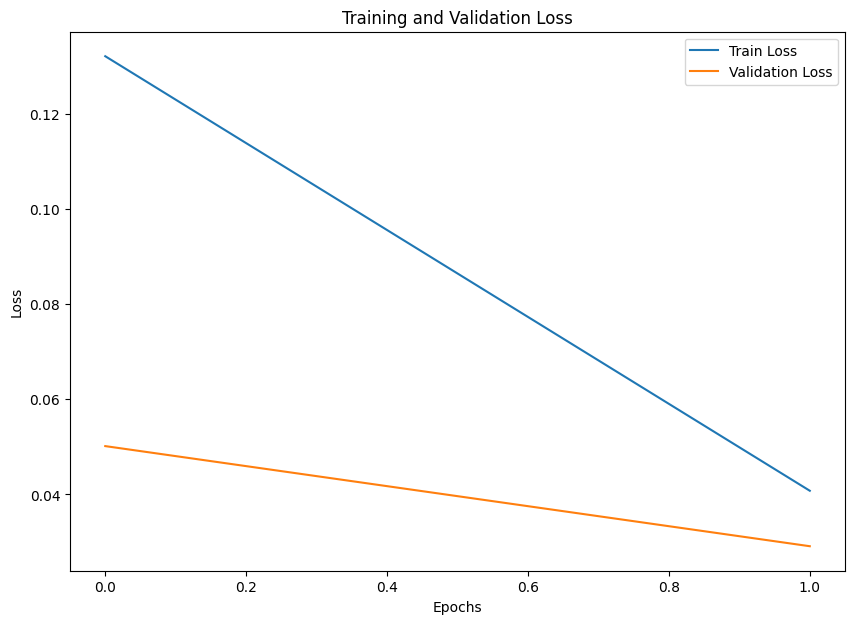

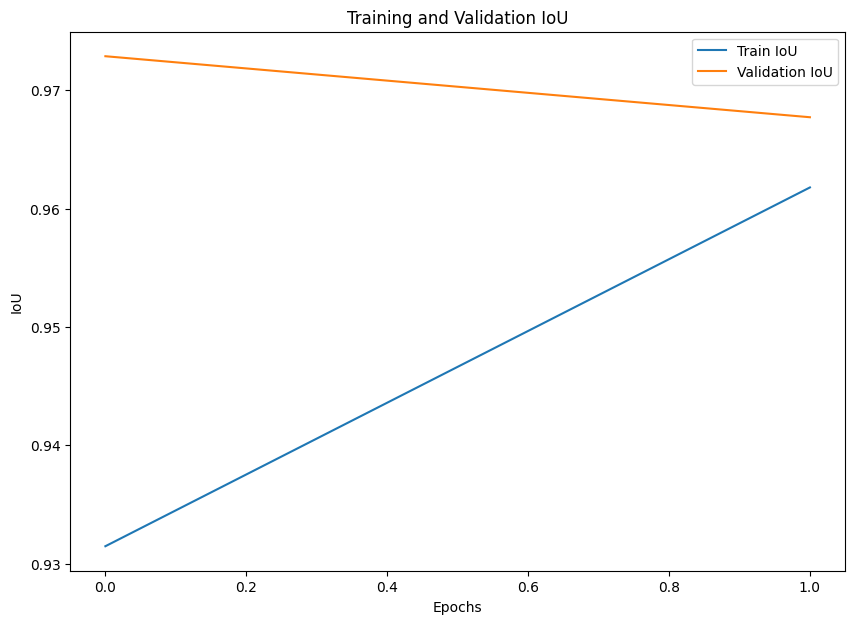

In [ ]:
train_loss, val_loss = [], []
train_iou, val_iou = [], []
model = UNet().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss, train_epoch_iou = fit(model, train_dataloader, train_data, optimizer, criterion)
    val_epoch_loss, val_epoch_iou = validate(model, valid_dataloader, valid_data, criterion)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_iou.append(train_epoch_iou)
    val_iou.append(val_epoch_iou)
    print(f"Train Loss: {train_epoch_loss:.4f}, Train IoU: {train_epoch_iou:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}, Val IoU: {val_epoch_iou:.4f}")

# Plot the training and validation metrics
plt.figure(figsize=(10, 7))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 7))
plt.plot(train_iou, label='Train IoU')
plt.plot(val_iou, label='Validation IoU')
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.title("Training and Validation IoU")
plt.legend()
plt.show()
